In [67]:
import json
from datetime import datetime
from pathlib import Path
from typing import TypedDict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from constants import DATA_DIR
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from xgboost import XGBRegressor

from astrofit.utils import AsteroidLoader

sns.set_theme()

In [3]:
asteroid_loader = AsteroidLoader(DATA_DIR)

In [4]:
FEATURES_DIR = DATA_DIR / "features"

feature_files = [file for file in FEATURES_DIR.iterdir() if file.suffix == ".json"]
len(feature_files)

192

In [5]:
class AsteroidData(TypedDict):
    is_failed: bool
    reason: str | None
    period: float
    processing_time: float
    features: np.ndarray

In [6]:
with open(feature_files[0], "r") as f:
    loaded_data = json.load(f)

config, asteroids_data = loaded_data["config"], loaded_data["asteroids"]

filtered_data = {
    name: AsteroidData(**data)
    for name, data in asteroids_data.items()
    if not data["is_failed"] and data["period"] <= 40
}

In [55]:
MAX_PERIOD = 40


def prepare_data(feature_file: Path, random_state: int = 88688, with_test: bool = True):
    with open(feature_file, "r") as f:
        loaded_data = json.load(f)

    _, asteroids_data = loaded_data["config"], loaded_data["asteroids"]

    filtered_data = {
        name: AsteroidData(**data)
        for name, data in asteroids_data.items()
        if not data["is_failed"] and data["period"] <= MAX_PERIOD
    }

    clipped_data = []
    periods = []
    for _, data in filtered_data.items():
        arr = np.array(data["features"])

        idx = np.argsort(arr[:, :, 1].flatten())[::-1][:50]
        seq_idx, row_idx = np.unravel_index(idx, arr[:, :, 1].shape)

        clipped_data.append(arr[seq_idx, row_idx])
        periods.append(data["period"])

    clipped_data = np.array(clipped_data)
    periods = np.array(periods)

    frequencies = 24 / periods

    X_train, X_val_test, y_train, y_val_test = train_test_split(
        clipped_data,
        frequencies,
        test_size=0.2,
        random_state=random_state,
    )

    _, seq_len, no_features = X_train.shape
    X_train = X_train.reshape(-1, seq_len * no_features)

    if not with_test:
        X_val_test = X_val_test.reshape(-1, seq_len * no_features)

        return X_train, X_val_test, y_train, y_val_test

    X_val, X_test, y_val, y_test = train_test_split(
        X_val_test,
        y_val_test,
        test_size=0.33,
        random_state=random_state,
    )

    X_val = X_val.reshape(-1, seq_len * no_features)
    X_test = X_test.reshape(-1, seq_len * no_features)

    return X_train, X_val, X_test, y_train, y_val, y_test


def process_dataset(feature_file: Path, verbose: bool = False, random_state: int = 88688):
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(feature_file, random_state=random_state)  # type: ignore

    model = XGBRegressor(
        n_estimators=1000,
        max_depth=10,
        learning_rate=0.01,
        eval_metric=root_mean_squared_error,
        early_stopping_rounds=100,
        n_jobs=-1,
        random_state=88688,
    )

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    pred = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, pred)

    if verbose:
        print(f"RMSE: {rmse}")
        print("----")
        for i in np.random.choice(len(y_test), 20):
            print(f"True: {24 / y_test[i]:.4f} | Pred: {24 / pred[i]:.4f}")

    return rmse

In [28]:
process_dataset(feature_files[0], verbose=True)

RMSE: 0.8294892931138776
----
True: 7.9281 | Pred: 8.3334
True: 6.5811 | Pred: 7.5467
True: 16.2960 | Pred: 16.2003
True: 5.0133 | Pred: 6.9556
True: 23.7427 | Pred: 10.1677
True: 9.6585 | Pred: 7.6229
True: 5.0133 | Pred: 6.9556
True: 32.1200 | Pred: 15.4195
True: 32.1200 | Pred: 15.4195
True: 32.1200 | Pred: 15.4195
True: 6.5811 | Pred: 7.5467
True: 9.0742 | Pred: 14.8245
True: 13.1720 | Pred: 7.6501
True: 9.0742 | Pred: 14.8245
True: 8.0495 | Pred: 7.5626
True: 12.8667 | Pred: 15.3614
True: 16.2960 | Pred: 16.2003
True: 16.2960 | Pred: 16.2003
True: 2.9533 | Pred: 3.2846
True: 32.1200 | Pred: 15.4195


np.float64(0.8294892931138776)

In [31]:
dataset_results = {}
best = np.inf
for feature_file in tqdm(feature_files):
    res = process_dataset(feature_file, verbose=False)

    if res < best:
        print(f"New best: {res} ({feature_file.stem})")
        best = res

    dataset_results[feature_file.stem] = res

  1%|          | 1/192 [00:13<42:21, 13.31s/it]

New best: 0.8294892931138776 (asteroids_freq_data_93)


  6%|▌         | 11/192 [01:19<21:28,  7.12s/it]

New best: 0.7799656798844503 (asteroids_freq_data_77)


 16%|█▌        | 30/192 [03:58<23:44,  8.79s/it]

New best: 0.77950745027538 (asteroids_freq_data_90)


 26%|██▌       | 50/192 [06:56<16:58,  7.17s/it]

New best: 0.7518738503878809 (asteroids_freq_data_38)


 27%|██▋       | 51/192 [07:00<15:02,  6.40s/it]

New best: 0.7042426200238459 (asteroids_freq_data_180)


 44%|████▍     | 84/192 [11:41<16:01,  8.91s/it]

New best: 0.6834735921890681 (asteroids_freq_data_94)


 54%|█████▎    | 103/192 [14:34<12:30,  8.43s/it]

New best: 0.6271775825716402 (asteroids_freq_data_45)


100%|██████████| 192/192 [28:29<00:00,  8.90s/it]


In [40]:
with open(DATA_DIR / f"xgboost_datasets_{datetime.now().isoformat()}.json", "w") as f:
    json.dump(dataset_results, f, indent=2)

In [ ]:
with open(DATA_DIR / "xgboost_datasets_2021-07-07T15:12:41.288905.json", "r") as f:
    dataset_results = json.load(f)


In [35]:
sorted_results = sorted(dataset_results.items(), key=lambda x: x[1])
sorted_results[:10]

[('asteroids_freq_data_45', np.float64(0.6271775825716402)),
 ('asteroids_freq_data_192', np.float64(0.6572994447675086)),
 ('asteroids_freq_data_94', np.float64(0.6834735921890681)),
 ('asteroids_freq_data_180', np.float64(0.7042426200238459)),
 ('asteroids_freq_data_44', np.float64(0.716611340735579)),
 ('asteroids_freq_data_26', np.float64(0.7234681941833062)),
 ('asteroids_freq_data_39', np.float64(0.7249488815783047)),
 ('asteroids_freq_data_28', np.float64(0.7473887632984136)),
 ('asteroids_freq_data_89', np.float64(0.7475521692200768)),
 ('asteroids_freq_data_96', np.float64(0.7493403581572635))]

In [43]:
space = {
    "max_depth": scope.int(hp.quniform("max_depth", 3, 18, 1)),
    "gamma": hp.uniform("gamma", 1, 9),
    "reg_alpha": hp.quniform("reg_alpha", 1, 100, 1),
    "reg_lambda": hp.quniform("reg_lambda", 1, 100, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
    "n_estimators": scope.int(hp.quniform("n_estimators", 100, 2000, 1)),
    "eta": hp.uniform("eta", 0.01, 0.3),
    "tree_method": hp.choice("tree_method", ["auto", "exact", "approx", "hist"]),
    "max_leaves": scope.int(hp.uniform("max_leaves", 2, 2**10)),
    "max_bin": scope.int(hp.uniform("max_bin", 2, 2**10)),
    "num_parallel_tree": scope.int(hp.quniform("num_parallel_tree", 1, 10, 1)),
    "early_stopping_rounds": scope.int(hp.uniform("early_stopping_rounds", 10, 100)),
}

In [44]:
import logging

logging.basicConfig(level=logging.DEBUG, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")

logger = logging.getLogger(__name__)

In [58]:
best_params = {}
for file_stem, _ in sorted_results[:5]:
    logger.info(f"Processing dataset: {file_stem}")
    feature_file = FEATURES_DIR / f"{file_stem}.json"

    X_train, X_val, y_train, y_val = prepare_data(feature_file, with_test=False)  # type: ignore

    def objective(space):
        model = XGBRegressor(
            **space,
            n_jobs=-1,
            random_state=8888,
        )

        logger.debug(f"Training with hyperparameters: {space}")

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            verbose=False,
        )

        logger.debug("Predicting on validation set")

        predictions = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, predictions)

        # Select 15 random predictions and print them
        for i in np.random.choice(len(y_val), 15):
            logger.debug(f"True: {y_val[i]:.4f} | Pred: {predictions[i]:.4f}")

        logger.debug(f"Validation RMSE: {rmse}")

        return {"loss": rmse, "status": STATUS_OK}


    trials = Trials()

    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials,
    )

    print("Best hyperparameters:", best)

    best_params[file_stem] = best

2024-08-26 19:16:14,209 - __main__ - INFO - Processing dataset: asteroids_freq_data_45


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

2024-08-26 19:16:14,374 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001797 seconds
2024-08-26 19:16:14,374 - hyperopt.tpe - INFO - TPE using 0 trials
2024-08-26 19:16:14,375 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7768826089548085, 'early_stopping_rounds': 96, 'eta': 0.09227190343150966, 'gamma': 6.004924048147527, 'max_bin': 856, 'max_depth': 4, 'max_leaves': 623, 'min_child_weight': 5.0, 'n_estimators': 1950, 'num_parallel_tree': 6, 'reg_alpha': 43.0, 'reg_lambda': 13.0, 'tree_method': 'hist'}
2024-08-26 19:16:15,588 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:15,589 - __main__ - DEBUG - True: 5.4049 | Pred: 4.7572
2024-08-26 19:16:15,589 - __main__ - DEBUG - True: 1.4728 | Pred: 2.1108
2024-08-26 19:16:15,590 - __main__ - DEBUG - True: 2.8659 | Pred: 2.4956
2024-08-26 19:16:15,590 - __main__ - DEBUG - True: 6.9088 | Pred: 5.2629
2024-08-26 19:16:15,590 - __main__ - DEBUG - True: 2.7656 | Pred: 3.2327
2024-08-26 19:

  1%|          | 1/100 [00:01<02:00,  1.22s/trial, best loss: 0.9024057839552465]

2024-08-26 19:16:15,597 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002143 seconds
2024-08-26 19:16:15,598 - hyperopt.tpe - INFO - TPE using 1/1 trials with best loss 0.902406
2024-08-26 19:16:15,599 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8284818001763257, 'early_stopping_rounds': 79, 'eta': 0.026981653487228356, 'gamma': 6.484248474606771, 'max_bin': 722, 'max_depth': 16, 'max_leaves': 117, 'min_child_weight': 5.0, 'n_estimators': 1055, 'num_parallel_tree': 2, 'reg_alpha': 81.0, 'reg_lambda': 41.0, 'tree_method': 'exact'}
2024-08-26 19:16:17,281 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:17,282 - __main__ - DEBUG - True: 4.8808 | Pred: 4.4469
2024-08-26 19:16:17,282 - __main__ - DEBUG - True: 1.6936 | Pred: 2.6590
2024-08-26 19:16:17,283 - __main__ - DEBUG - True: 0.8073 | Pred: 2.6258
2024-08-26 19:16:17,283 - __main__ - DEBUG - True: 6.9088 | Pred: 4.5316
2024-08-26 19:16:17,283 - __main__ - DEBUG - True: 3.8764 

  2%|▏         | 2/100 [00:02<02:26,  1.50s/trial, best loss: 0.9024057839552465]

2024-08-26 19:16:17,290 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002126 seconds
2024-08-26 19:16:17,290 - hyperopt.tpe - INFO - TPE using 2/2 trials with best loss 0.902406
2024-08-26 19:16:17,291 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.718937711029042, 'early_stopping_rounds': 50, 'eta': 0.07719402158014792, 'gamma': 1.5845758276337838, 'max_bin': 912, 'max_depth': 8, 'max_leaves': 932, 'min_child_weight': 3.0, 'n_estimators': 1047, 'num_parallel_tree': 8, 'reg_alpha': 81.0, 'reg_lambda': 71.0, 'tree_method': 'exact'}
2024-08-26 19:16:23,965 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:23,967 - __main__ - DEBUG - True: 3.3619 | Pred: 2.6578
2024-08-26 19:16:23,968 - __main__ - DEBUG - True: 1.8920 | Pred: 2.8896
2024-08-26 19:16:23,968 - __main__ - DEBUG - True: 2.2391 | Pred: 2.4818
2024-08-26 19:16:23,968 - __main__ - DEBUG - True: 6.3916 | Pred: 4.7480
2024-08-26 19:16:23,969 - __main__ - DEBUG - True: 3.7148 | 

  3%|▎         | 3/100 [00:09<06:15,  3.87s/trial, best loss: 0.9024057839552465]

2024-08-26 19:16:23,977 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001985 seconds
2024-08-26 19:16:23,979 - hyperopt.tpe - INFO - TPE using 3/3 trials with best loss 0.902406
2024-08-26 19:16:23,982 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8939448860587009, 'early_stopping_rounds': 79, 'eta': 0.0590533490197441, 'gamma': 3.4826425011221884, 'max_bin': 960, 'max_depth': 11, 'max_leaves': 892, 'min_child_weight': 6.0, 'n_estimators': 595, 'num_parallel_tree': 8, 'reg_alpha': 45.0, 'reg_lambda': 48.0, 'tree_method': 'hist'}
2024-08-26 19:16:26,576 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:26,581 - __main__ - DEBUG - True: 1.6578 | Pred: 2.2912
2024-08-26 19:16:26,581 - __main__ - DEBUG - True: 3.6011 | Pred: 3.0188
2024-08-26 19:16:26,582 - __main__ - DEBUG - True: 3.6715 | Pred: 3.6715
2024-08-26 19:16:26,582 - __main__ - DEBUG - True: 2.7569 | Pred: 2.8462
2024-08-26 19:16:26,582 - __main__ - DEBUG - True: 1.9478 | P

  4%|▍         | 4/100 [00:12<05:23,  3.37s/trial, best loss: 0.9004991292911978]

2024-08-26 19:16:26,589 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001966 seconds
2024-08-26 19:16:26,590 - hyperopt.tpe - INFO - TPE using 4/4 trials with best loss 0.900499
2024-08-26 19:16:26,591 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5964329694531745, 'early_stopping_rounds': 91, 'eta': 0.2018733609082721, 'gamma': 1.2950844938139472, 'max_bin': 308, 'max_depth': 13, 'max_leaves': 857, 'min_child_weight': 8.0, 'n_estimators': 1891, 'num_parallel_tree': 2, 'reg_alpha': 38.0, 'reg_lambda': 72.0, 'tree_method': 'hist'}
2024-08-26 19:16:26,887 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:26,894 - __main__ - DEBUG - True: 0.7523 | Pred: 1.8747
2024-08-26 19:16:26,895 - __main__ - DEBUG - True: 1.6578 | Pred: 2.1935
2024-08-26 19:16:26,895 - __main__ - DEBUG - True: 2.2943 | Pred: 2.3830
2024-08-26 19:16:26,895 - __main__ - DEBUG - True: 5.0258 | Pred: 5.4721
2024-08-26 19:16:26,896 - __main__ - DEBUG - True: 0.9804 | 

  5%|▌         | 5/100 [00:12<03:35,  2.27s/trial, best loss: 0.8398001796533936]

2024-08-26 19:16:26,912 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001923 seconds
2024-08-26 19:16:26,912 - hyperopt.tpe - INFO - TPE using 5/5 trials with best loss 0.839800
2024-08-26 19:16:26,916 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.928560022927279, 'early_stopping_rounds': 86, 'eta': 0.0556709773974118, 'gamma': 8.164210816986493, 'max_bin': 168, 'max_depth': 9, 'max_leaves': 443, 'min_child_weight': 9.0, 'n_estimators': 1822, 'num_parallel_tree': 8, 'reg_alpha': 51.0, 'reg_lambda': 39.0, 'tree_method': 'auto'}
2024-08-26 19:16:28,241 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:28,243 - __main__ - DEBUG - True: 3.3496 | Pred: 3.2969
2024-08-26 19:16:28,244 - __main__ - DEBUG - True: 0.9215 | Pred: 2.3392
2024-08-26 19:16:28,244 - __main__ - DEBUG - True: 3.2786 | Pred: 2.8439
2024-08-26 19:16:28,245 - __main__ - DEBUG - True: 7.5773 | Pred: 4.9674
2024-08-26 19:16:28,245 - __main__ - DEBUG - True: 1.2897 | Pre

  6%|▌         | 6/100 [00:13<03:03,  1.96s/trial, best loss: 0.8398001796533936]

2024-08-26 19:16:28,256 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002019 seconds
2024-08-26 19:16:28,257 - hyperopt.tpe - INFO - TPE using 6/6 trials with best loss 0.839800
2024-08-26 19:16:28,258 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5928442050889733, 'early_stopping_rounds': 42, 'eta': 0.11635651973367334, 'gamma': 4.454109112583038, 'max_bin': 109, 'max_depth': 6, 'max_leaves': 194, 'min_child_weight': 6.0, 'n_estimators': 1309, 'num_parallel_tree': 7, 'reg_alpha': 67.0, 'reg_lambda': 59.0, 'tree_method': 'hist'}
2024-08-26 19:16:28,789 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:28,791 - __main__ - DEBUG - True: 4.9885 | Pred: 4.6199
2024-08-26 19:16:28,792 - __main__ - DEBUG - True: 4.1537 | Pred: 4.1742
2024-08-26 19:16:28,792 - __main__ - DEBUG - True: 6.3916 | Pred: 4.7837
2024-08-26 19:16:28,793 - __main__ - DEBUG - True: 2.6208 | Pred: 2.6461
2024-08-26 19:16:28,793 - __main__ - DEBUG - True: 4.0553 | P

  7%|▋         | 7/100 [00:14<02:19,  1.50s/trial, best loss: 0.8398001796533936]

2024-08-26 19:16:28,802 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001925 seconds
2024-08-26 19:16:28,803 - hyperopt.tpe - INFO - TPE using 7/7 trials with best loss 0.839800
2024-08-26 19:16:28,804 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7455166800185447, 'early_stopping_rounds': 46, 'eta': 0.20881034073602045, 'gamma': 6.390776608567714, 'max_bin': 64, 'max_depth': 12, 'max_leaves': 80, 'min_child_weight': 4.0, 'n_estimators': 1874, 'num_parallel_tree': 3, 'reg_alpha': 40.0, 'reg_lambda': 97.0, 'tree_method': 'auto'}
2024-08-26 19:16:29,065 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:29,068 - __main__ - DEBUG - True: 2.7656 | Pred: 3.1276
2024-08-26 19:16:29,070 - __main__ - DEBUG - True: 4.0553 | Pred: 3.5847
2024-08-26 19:16:29,070 - __main__ - DEBUG - True: 2.5813 | Pred: 2.8989
2024-08-26 19:16:29,071 - __main__ - DEBUG - True: 2.9317 | Pred: 2.9864
2024-08-26 19:16:29,071 - __main__ - DEBUG - True: 2.2943 | Pr

  8%|▊         | 8/100 [00:14<01:42,  1.11s/trial, best loss: 0.8398001796533936]

2024-08-26 19:16:29,086 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001910 seconds
2024-08-26 19:16:29,089 - hyperopt.tpe - INFO - TPE using 8/8 trials with best loss 0.839800
2024-08-26 19:16:29,091 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6005289670162888, 'early_stopping_rounds': 79, 'eta': 0.05591420177302143, 'gamma': 7.681424356605992, 'max_bin': 114, 'max_depth': 11, 'max_leaves': 656, 'min_child_weight': 4.0, 'n_estimators': 1503, 'num_parallel_tree': 7, 'reg_alpha': 93.0, 'reg_lambda': 8.0, 'tree_method': 'hist'}
2024-08-26 19:16:29,799 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:29,801 - __main__ - DEBUG - True: 4.9885 | Pred: 4.1892
2024-08-26 19:16:29,802 - __main__ - DEBUG - True: 3.8893 | Pred: 3.3596
2024-08-26 19:16:29,803 - __main__ - DEBUG - True: 4.3236 | Pred: 3.9015
2024-08-26 19:16:29,803 - __main__ - DEBUG - True: 4.0149 | Pred: 3.5491
2024-08-26 19:16:29,803 - __main__ - DEBUG - True: 4.2995 | P

  9%|▉         | 9/100 [00:15<01:30,  1.01trial/s, best loss: 0.8398001796533936]

2024-08-26 19:16:29,813 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002536 seconds
2024-08-26 19:16:29,814 - hyperopt.tpe - INFO - TPE using 9/9 trials with best loss 0.839800
2024-08-26 19:16:29,816 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9358797646717099, 'early_stopping_rounds': 50, 'eta': 0.26121721106203905, 'gamma': 1.2900756726559637, 'max_bin': 323, 'max_depth': 11, 'max_leaves': 981, 'min_child_weight': 3.0, 'n_estimators': 1194, 'num_parallel_tree': 3, 'reg_alpha': 37.0, 'reg_lambda': 85.0, 'tree_method': 'approx'}
2024-08-26 19:16:30,275 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:30,277 - __main__ - DEBUG - True: 5.5607 | Pred: 5.1672
2024-08-26 19:16:30,277 - __main__ - DEBUG - True: 1.3667 | Pred: 2.4099
2024-08-26 19:16:30,277 - __main__ - DEBUG - True: 2.7390 | Pred: 2.9826
2024-08-26 19:16:30,277 - __main__ - DEBUG - True: 3.9726 | Pred: 5.0607
2024-08-26 19:16:30,278 - __main__ - DEBUG - True: 1.0139

 10%|█         | 10/100 [00:15<01:14,  1.20trial/s, best loss: 0.8398001796533936]

2024-08-26 19:16:30,284 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002008 seconds
2024-08-26 19:16:30,285 - hyperopt.tpe - INFO - TPE using 10/10 trials with best loss 0.839800
2024-08-26 19:16:30,286 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.512649787577986, 'early_stopping_rounds': 76, 'eta': 0.03947574660559557, 'gamma': 3.384276894553225, 'max_bin': 247, 'max_depth': 10, 'max_leaves': 7, 'min_child_weight': 6.0, 'n_estimators': 859, 'num_parallel_tree': 2, 'reg_alpha': 73.0, 'reg_lambda': 12.0, 'tree_method': 'exact'}
2024-08-26 19:16:31,844 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:31,848 - __main__ - DEBUG - True: 1.0746 | Pred: 2.4022
2024-08-26 19:16:31,850 - __main__ - DEBUG - True: 2.6457 | Pred: 3.1292
2024-08-26 19:16:31,851 - __main__ - DEBUG - True: 4.3236 | Pred: 4.0699
2024-08-26 19:16:31,853 - __main__ - DEBUG - True: 0.9804 | Pred: 2.5175
2024-08-26 19:16:31,856 - __main__ - DEBUG - True: 3.3496 | P

 11%|█         | 11/100 [00:17<01:34,  1.06s/trial, best loss: 0.8398001796533936]

2024-08-26 19:16:31,868 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001918 seconds
2024-08-26 19:16:31,869 - hyperopt.tpe - INFO - TPE using 11/11 trials with best loss 0.839800
2024-08-26 19:16:31,870 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9841837574428913, 'early_stopping_rounds': 45, 'eta': 0.2939380436731381, 'gamma': 8.701785491201694, 'max_bin': 427, 'max_depth': 12, 'max_leaves': 973, 'min_child_weight': 8.0, 'n_estimators': 1776, 'num_parallel_tree': 10, 'reg_alpha': 32.0, 'reg_lambda': 87.0, 'tree_method': 'approx'}
2024-08-26 19:16:32,703 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:32,704 - __main__ - DEBUG - True: 5.4049 | Pred: 4.7566
2024-08-26 19:16:32,705 - __main__ - DEBUG - True: 2.4718 | Pred: 3.4255
2024-08-26 19:16:32,705 - __main__ - DEBUG - True: 3.8764 | Pred: 3.6665
2024-08-26 19:16:32,705 - __main__ - DEBUG - True: 5.0258 | Pred: 5.2036
2024-08-26 19:16:32,706 - __main__ - DEBUG - True: 1.657

 12%|█▏        | 12/100 [00:18<01:27,  1.00trial/s, best loss: 0.8398001796533936]

2024-08-26 19:16:32,713 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001886 seconds
2024-08-26 19:16:32,714 - hyperopt.tpe - INFO - TPE using 12/12 trials with best loss 0.839800
2024-08-26 19:16:32,715 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6962527377155203, 'early_stopping_rounds': 40, 'eta': 0.11781557713879606, 'gamma': 8.285876277797488, 'max_bin': 928, 'max_depth': 11, 'max_leaves': 609, 'min_child_weight': 4.0, 'n_estimators': 1517, 'num_parallel_tree': 10, 'reg_alpha': 28.0, 'reg_lambda': 9.0, 'tree_method': 'hist'}
2024-08-26 19:16:33,894 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:33,898 - __main__ - DEBUG - True: 1.4541 | Pred: 1.9858
2024-08-26 19:16:33,899 - __main__ - DEBUG - True: 3.6715 | Pred: 3.6499
2024-08-26 19:16:33,899 - __main__ - DEBUG - True: 2.7579 | Pred: 3.3247
2024-08-26 19:16:33,900 - __main__ - DEBUG - True: 4.0973 | Pred: 3.6544
2024-08-26 19:16:33,900 - __main__ - DEBUG - True: 3.0564 

 13%|█▎        | 13/100 [00:19<01:31,  1.06s/trial, best loss: 0.8398001796533936]

2024-08-26 19:16:33,911 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001946 seconds
2024-08-26 19:16:33,914 - hyperopt.tpe - INFO - TPE using 13/13 trials with best loss 0.839800
2024-08-26 19:16:33,915 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6614008315344211, 'early_stopping_rounds': 18, 'eta': 0.0490605174202919, 'gamma': 7.278393463977601, 'max_bin': 849, 'max_depth': 9, 'max_leaves': 765, 'min_child_weight': 2.0, 'n_estimators': 160, 'num_parallel_tree': 8, 'reg_alpha': 34.0, 'reg_lambda': 27.0, 'tree_method': 'auto'}
2024-08-26 19:16:35,589 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:35,591 - __main__ - DEBUG - True: 5.8297 | Pred: 5.3194
2024-08-26 19:16:35,592 - __main__ - DEBUG - True: 2.1965 | Pred: 3.1857
2024-08-26 19:16:35,592 - __main__ - DEBUG - True: 0.7523 | Pred: 2.0537
2024-08-26 19:16:35,593 - __main__ - DEBUG - True: 1.2897 | Pred: 2.2878
2024-08-26 19:16:35,593 - __main__ - DEBUG - True: 2.1965 | P

 14%|█▍        | 14/100 [00:21<01:47,  1.25s/trial, best loss: 0.8398001796533936]

2024-08-26 19:16:35,606 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002198 seconds
2024-08-26 19:16:35,606 - hyperopt.tpe - INFO - TPE using 14/14 trials with best loss 0.839800
2024-08-26 19:16:35,608 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8157330206351621, 'early_stopping_rounds': 14, 'eta': 0.24007682059500712, 'gamma': 8.336129470999953, 'max_bin': 955, 'max_depth': 17, 'max_leaves': 23, 'min_child_weight': 3.0, 'n_estimators': 1995, 'num_parallel_tree': 10, 'reg_alpha': 9.0, 'reg_lambda': 18.0, 'tree_method': 'auto'}
2024-08-26 19:16:36,110 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:36,112 - __main__ - DEBUG - True: 1.8920 | Pred: 2.1240
2024-08-26 19:16:36,112 - __main__ - DEBUG - True: 1.4870 | Pred: 2.7206
2024-08-26 19:16:36,112 - __main__ - DEBUG - True: 3.0651 | Pred: 2.6466
2024-08-26 19:16:36,113 - __main__ - DEBUG - True: 3.4253 | Pred: 2.1722
2024-08-26 19:16:36,113 - __main__ - DEBUG - True: 5.8297 |

 15%|█▌        | 15/100 [00:21<01:27,  1.03s/trial, best loss: 0.7729827038699346]

2024-08-26 19:16:36,120 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002052 seconds
2024-08-26 19:16:36,121 - hyperopt.tpe - INFO - TPE using 15/15 trials with best loss 0.772983
2024-08-26 19:16:36,122 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5849488828902084, 'early_stopping_rounds': 60, 'eta': 0.1946385432833145, 'gamma': 5.88052906283968, 'max_bin': 349, 'max_depth': 6, 'max_leaves': 723, 'min_child_weight': 5.0, 'n_estimators': 1378, 'num_parallel_tree': 8, 'reg_alpha': 81.0, 'reg_lambda': 58.0, 'tree_method': 'approx'}
2024-08-26 19:16:36,710 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:36,712 - __main__ - DEBUG - True: 6.3916 | Pred: 4.5514
2024-08-26 19:16:36,713 - __main__ - DEBUG - True: 1.8920 | Pred: 2.8199
2024-08-26 19:16:36,713 - __main__ - DEBUG - True: 1.3667 | Pred: 2.5528
2024-08-26 19:16:36,713 - __main__ - DEBUG - True: 1.6578 | Pred: 2.6426
2024-08-26 19:16:36,714 - __main__ - DEBUG - True: 1.5279 |

 16%|█▌        | 16/100 [00:22<01:15,  1.11trial/s, best loss: 0.7729827038699346]

2024-08-26 19:16:36,721 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002046 seconds
2024-08-26 19:16:36,721 - hyperopt.tpe - INFO - TPE using 16/16 trials with best loss 0.772983
2024-08-26 19:16:36,723 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.934800068481926, 'early_stopping_rounds': 41, 'eta': 0.14147915684820433, 'gamma': 8.788284062486433, 'max_bin': 607, 'max_depth': 17, 'max_leaves': 797, 'min_child_weight': 6.0, 'n_estimators': 304, 'num_parallel_tree': 4, 'reg_alpha': 80.0, 'reg_lambda': 80.0, 'tree_method': 'approx'}
2024-08-26 19:16:37,147 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:37,149 - __main__ - DEBUG - True: 4.4881 | Pred: 4.1505
2024-08-26 19:16:37,150 - __main__ - DEBUG - True: 4.1537 | Pred: 3.9694
2024-08-26 19:16:37,150 - __main__ - DEBUG - True: 2.2391 | Pred: 2.7085
2024-08-26 19:16:37,150 - __main__ - DEBUG - True: 2.9340 | Pred: 2.5477
2024-08-26 19:16:37,151 - __main__ - DEBUG - True: 2.7390 

 17%|█▋        | 17/100 [00:22<01:03,  1.31trial/s, best loss: 0.7729827038699346]

2024-08-26 19:16:37,160 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001943 seconds
2024-08-26 19:16:37,163 - hyperopt.tpe - INFO - TPE using 17/17 trials with best loss 0.772983
2024-08-26 19:16:37,165 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.682880405413523, 'early_stopping_rounds': 16, 'eta': 0.22543397797476378, 'gamma': 6.409044078852259, 'max_bin': 353, 'max_depth': 12, 'max_leaves': 344, 'min_child_weight': 3.0, 'n_estimators': 1749, 'num_parallel_tree': 8, 'reg_alpha': 72.0, 'reg_lambda': 82.0, 'tree_method': 'exact'}
2024-08-26 19:16:38,567 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:38,568 - __main__ - DEBUG - True: 2.2391 | Pred: 2.5852
2024-08-26 19:16:38,568 - __main__ - DEBUG - True: 7.1717 | Pred: 4.5997
2024-08-26 19:16:38,569 - __main__ - DEBUG - True: 3.3496 | Pred: 3.4495
2024-08-26 19:16:38,569 - __main__ - DEBUG - True: 6.9088 | Pred: 4.6203
2024-08-26 19:16:38,569 - __main__ - DEBUG - True: 3.4253 

 18%|█▊        | 18/100 [00:24<01:18,  1.04trial/s, best loss: 0.7729827038699346]

2024-08-26 19:16:38,576 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002008 seconds
2024-08-26 19:16:38,576 - hyperopt.tpe - INFO - TPE using 18/18 trials with best loss 0.772983
2024-08-26 19:16:38,577 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.528806221673014, 'early_stopping_rounds': 80, 'eta': 0.07987948990670386, 'gamma': 5.700089199103773, 'max_bin': 824, 'max_depth': 18, 'max_leaves': 481, 'min_child_weight': 2.0, 'n_estimators': 1621, 'num_parallel_tree': 3, 'reg_alpha': 17.0, 'reg_lambda': 90.0, 'tree_method': 'auto'}
2024-08-26 19:16:39,468 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:39,472 - __main__ - DEBUG - True: 7.4970 | Pred: 5.3356
2024-08-26 19:16:39,473 - __main__ - DEBUG - True: 2.5600 | Pred: 2.5223
2024-08-26 19:16:39,474 - __main__ - DEBUG - True: 1.3246 | Pred: 2.2234
2024-08-26 19:16:39,474 - __main__ - DEBUG - True: 2.2391 | Pred: 2.1634
2024-08-26 19:16:39,475 - __main__ - DEBUG - True: 1.3667 |

 19%|█▉        | 19/100 [00:25<01:16,  1.06trial/s, best loss: 0.7729827038699346]

2024-08-26 19:16:39,484 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001993 seconds
2024-08-26 19:16:39,488 - hyperopt.tpe - INFO - TPE using 19/19 trials with best loss 0.772983
2024-08-26 19:16:39,489 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6499145382723698, 'early_stopping_rounds': 94, 'eta': 0.058490462044243234, 'gamma': 7.271258553615509, 'max_bin': 617, 'max_depth': 13, 'max_leaves': 259, 'min_child_weight': 4.0, 'n_estimators': 1763, 'num_parallel_tree': 8, 'reg_alpha': 89.0, 'reg_lambda': 73.0, 'tree_method': 'approx'}
2024-08-26 19:16:41,073 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:41,075 - __main__ - DEBUG - True: 3.8764 | Pred: 3.5814
2024-08-26 19:16:41,075 - __main__ - DEBUG - True: 1.5250 | Pred: 2.6217
2024-08-26 19:16:41,075 - __main__ - DEBUG - True: 1.5624 | Pred: 2.6096
2024-08-26 19:16:41,076 - __main__ - DEBUG - True: 4.3110 | Pred: 4.0480
2024-08-26 19:16:41,076 - __main__ - DEBUG - True: 6.17

 20%|██        | 20/100 [00:26<01:31,  1.14s/trial, best loss: 0.7729827038699346]

2024-08-26 19:16:41,089 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001948 seconds
2024-08-26 19:16:41,090 - hyperopt.tpe - INFO - TPE using 20/20 trials with best loss 0.772983
2024-08-26 19:16:41,101 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8187791139222319, 'early_stopping_rounds': 63, 'eta': 0.16762271232124648, 'gamma': 4.93684460816666, 'max_bin': 1019, 'max_depth': 15, 'max_leaves': 476, 'min_child_weight': 1.0, 'n_estimators': 1614, 'num_parallel_tree': 5, 'reg_alpha': 1.0, 'reg_lambda': 22.0, 'tree_method': 'auto'}
2024-08-26 19:16:42,177 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:42,179 - __main__ - DEBUG - True: 1.3246 | Pred: 2.5257
2024-08-26 19:16:42,180 - __main__ - DEBUG - True: 1.0139 | Pred: 1.4748
2024-08-26 19:16:42,180 - __main__ - DEBUG - True: 1.9478 | Pred: 2.0136
2024-08-26 19:16:42,181 - __main__ - DEBUG - True: 1.0746 | Pred: 1.7385
2024-08-26 19:16:42,181 - __main__ - DEBUG - True: 1.2070 |

 21%|██        | 21/100 [00:27<01:29,  1.13s/trial, best loss: 0.727109580138961] 

2024-08-26 19:16:42,191 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002477 seconds
2024-08-26 19:16:42,192 - hyperopt.tpe - INFO - TPE using 21/21 trials with best loss 0.727110
2024-08-26 19:16:42,203 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8212868961039299, 'early_stopping_rounds': 28, 'eta': 0.1644688273374372, 'gamma': 4.410571124103494, 'max_bin': 998, 'max_depth': 15, 'max_leaves': 366, 'min_child_weight': 1.0, 'n_estimators': 1998, 'num_parallel_tree': 5, 'reg_alpha': 1.0, 'reg_lambda': 23.0, 'tree_method': 'auto'}
2024-08-26 19:16:43,051 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:43,053 - __main__ - DEBUG - True: 2.9633 | Pred: 2.8387
2024-08-26 19:16:43,053 - __main__ - DEBUG - True: 3.7148 | Pred: 3.8620
2024-08-26 19:16:43,054 - __main__ - DEBUG - True: 4.8415 | Pred: 3.1897
2024-08-26 19:16:43,055 - __main__ - DEBUG - True: 2.7569 | Pred: 2.7709
2024-08-26 19:16:43,055 - __main__ - DEBUG - True: 1.2109 | 

 22%|██▏       | 22/100 [00:28<01:22,  1.06s/trial, best loss: 0.7252634480468597]

2024-08-26 19:16:43,073 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002725 seconds
2024-08-26 19:16:43,077 - hyperopt.tpe - INFO - TPE using 22/22 trials with best loss 0.725263
2024-08-26 19:16:43,087 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8512938885533725, 'early_stopping_rounds': 28, 'eta': 0.16864403204394085, 'gamma': 4.621728406109766, 'max_bin': 754, 'max_depth': 15, 'max_leaves': 390, 'min_child_weight': 1.0, 'n_estimators': 1607, 'num_parallel_tree': 5, 'reg_alpha': 1.0, 'reg_lambda': 26.0, 'tree_method': 'auto'}
2024-08-26 19:16:43,860 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:43,862 - __main__ - DEBUG - True: 7.1717 | Pred: 5.9826
2024-08-26 19:16:43,862 - __main__ - DEBUG - True: 4.5539 | Pred: 5.7631
2024-08-26 19:16:43,863 - __main__ - DEBUG - True: 3.8893 | Pred: 3.6882
2024-08-26 19:16:43,863 - __main__ - DEBUG - True: 1.4285 | Pred: 2.5493
2024-08-26 19:16:43,864 - __main__ - DEBUG - True: 1.4285 |

 23%|██▎       | 23/100 [00:29<01:15,  1.02trial/s, best loss: 0.7156555597407835]

2024-08-26 19:16:43,876 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001957 seconds
2024-08-26 19:16:43,877 - hyperopt.tpe - INFO - TPE using 23/23 trials with best loss 0.715656
2024-08-26 19:16:43,888 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8666018585627894, 'early_stopping_rounds': 25, 'eta': 0.17476567086753633, 'gamma': 2.406731360899684, 'max_bin': 770, 'max_depth': 15, 'max_leaves': 308, 'min_child_weight': 1.0, 'n_estimators': 790, 'num_parallel_tree': 5, 'reg_alpha': 1.0, 'reg_lambda': 30.0, 'tree_method': 'auto'}
2024-08-26 19:16:44,772 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:44,774 - __main__ - DEBUG - True: 6.2260 | Pred: 5.1570
2024-08-26 19:16:44,774 - __main__ - DEBUG - True: 1.5279 | Pred: 1.6315
2024-08-26 19:16:44,774 - __main__ - DEBUG - True: 2.2391 | Pred: 1.7573
2024-08-26 19:16:44,774 - __main__ - DEBUG - True: 3.8893 | Pred: 3.7165
2024-08-26 19:16:44,775 - __main__ - DEBUG - True: 3.9726 | 

 24%|██▍       | 24/100 [00:30<01:12,  1.04trial/s, best loss: 0.6904627907432187]

2024-08-26 19:16:44,781 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002147 seconds
2024-08-26 19:16:44,782 - hyperopt.tpe - INFO - TPE using 24/24 trials with best loss 0.690463
2024-08-26 19:16:44,793 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.864861589796902, 'early_stopping_rounds': 25, 'eta': 0.17906227229133434, 'gamma': 2.2700244794766835, 'max_bin': 753, 'max_depth': 14, 'max_leaves': 274, 'min_child_weight': 1.0, 'n_estimators': 652, 'num_parallel_tree': 4, 'reg_alpha': 21.0, 'reg_lambda': 32.0, 'tree_method': 'auto'}
2024-08-26 19:16:45,349 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:45,352 - __main__ - DEBUG - True: 2.7390 | Pred: 3.0957
2024-08-26 19:16:45,352 - __main__ - DEBUG - True: 0.7472 | Pred: 1.7267
2024-08-26 19:16:45,352 - __main__ - DEBUG - True: 2.8659 | Pred: 2.4129
2024-08-26 19:16:45,353 - __main__ - DEBUG - True: 0.8073 | Pred: 2.6077
2024-08-26 19:16:45,353 - __main__ - DEBUG - True: 1.5250 |

 25%|██▌       | 25/100 [00:30<01:03,  1.18trial/s, best loss: 0.6904627907432187]

2024-08-26 19:16:45,359 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002044 seconds
2024-08-26 19:16:45,360 - hyperopt.tpe - INFO - TPE using 25/25 trials with best loss 0.690463
2024-08-26 19:16:45,371 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9956312711483325, 'early_stopping_rounds': 33, 'eta': 0.14254447492451078, 'gamma': 2.727598648895371, 'max_bin': 556, 'max_depth': 18, 'max_leaves': 550, 'min_child_weight': 2.0, 'n_estimators': 514, 'num_parallel_tree': 6, 'reg_alpha': 8.0, 'reg_lambda': 3.0, 'tree_method': 'auto'}
2024-08-26 19:16:46,528 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:46,530 - __main__ - DEBUG - True: 3.6715 | Pred: 3.3568
2024-08-26 19:16:46,531 - __main__ - DEBUG - True: 1.2070 | Pred: 1.6351
2024-08-26 19:16:46,531 - __main__ - DEBUG - True: 3.9274 | Pred: 3.2513
2024-08-26 19:16:46,532 - __main__ - DEBUG - True: 2.1965 | Pred: 3.0964
2024-08-26 19:16:46,532 - __main__ - DEBUG - True: 1.5624 | P

 26%|██▌       | 26/100 [00:32<01:09,  1.06trial/s, best loss: 0.6904627907432187]

2024-08-26 19:16:46,543 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001966 seconds
2024-08-26 19:16:46,547 - hyperopt.tpe - INFO - TPE using 26/26 trials with best loss 0.690463
2024-08-26 19:16:46,571 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9976999238832884, 'early_stopping_rounds': 32, 'eta': 0.13973271989500652, 'gamma': 2.5218756283802204, 'max_bin': 501, 'max_depth': 18, 'max_leaves': 544, 'min_child_weight': 2.0, 'n_estimators': 427, 'num_parallel_tree': 6, 'reg_alpha': 13.0, 'reg_lambda': 33.0, 'tree_method': 'auto'}
2024-08-26 19:16:47,961 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:47,963 - __main__ - DEBUG - True: 2.3534 | Pred: 3.2406
2024-08-26 19:16:47,963 - __main__ - DEBUG - True: 7.1717 | Pred: 5.7632
2024-08-26 19:16:47,964 - __main__ - DEBUG - True: 4.5539 | Pred: 5.7261
2024-08-26 19:16:47,964 - __main__ - DEBUG - True: 1.5624 | Pred: 1.5968
2024-08-26 19:16:47,965 - __main__ - DEBUG - True: 3.9726 

 27%|██▋       | 27/100 [00:33<01:19,  1.09s/trial, best loss: 0.6904627907432187]

2024-08-26 19:16:47,974 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002254 seconds
2024-08-26 19:16:47,976 - hyperopt.tpe - INFO - TPE using 27/27 trials with best loss 0.690463
2024-08-26 19:16:47,991 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9714237195109338, 'early_stopping_rounds': 10, 'eta': 0.12116680040482389, 'gamma': 3.5435973203426494, 'max_bin': 607, 'max_depth': 17, 'max_leaves': 559, 'min_child_weight': 2.0, 'n_estimators': 772, 'num_parallel_tree': 4, 'reg_alpha': 7.0, 'reg_lambda': 5.0, 'tree_method': 'auto'}
2024-08-26 19:16:48,638 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:48,640 - __main__ - DEBUG - True: 5.8297 | Pred: 6.1597
2024-08-26 19:16:48,640 - __main__ - DEBUG - True: 3.3496 | Pred: 3.6189
2024-08-26 19:16:48,641 - __main__ - DEBUG - True: 4.5539 | Pred: 5.6293
2024-08-26 19:16:48,641 - __main__ - DEBUG - True: 2.8802 | Pred: 2.7977
2024-08-26 19:16:48,642 - __main__ - DEBUG - True: 1.4302 | 

 28%|██▊       | 28/100 [00:34<01:09,  1.03trial/s, best loss: 0.6904627907432187]

2024-08-26 19:16:48,650 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001937 seconds
2024-08-26 19:16:48,652 - hyperopt.tpe - INFO - TPE using 28/28 trials with best loss 0.690463
2024-08-26 19:16:48,665 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7671282583632809, 'early_stopping_rounds': 35, 'eta': 0.10341349601860823, 'gamma': 2.1960119595861327, 'max_bin': 521, 'max_depth': 3, 'max_leaves': 207, 'min_child_weight': 7.0, 'n_estimators': 469, 'num_parallel_tree': 6, 'reg_alpha': 24.0, 'reg_lambda': 3.0, 'tree_method': 'auto'}
2024-08-26 19:16:49,481 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:49,482 - __main__ - DEBUG - True: 6.9088 | Pred: 5.8907
2024-08-26 19:16:49,483 - __main__ - DEBUG - True: 1.3667 | Pred: 2.3840
2024-08-26 19:16:49,483 - __main__ - DEBUG - True: 3.9726 | Pred: 5.0897
2024-08-26 19:16:49,483 - __main__ - DEBUG - True: 1.7360 | Pred: 2.3271
2024-08-26 19:16:49,483 - __main__ - DEBUG - True: 5.0258 | 

 29%|██▉       | 29/100 [00:35<01:05,  1.08trial/s, best loss: 0.6904627907432187]

2024-08-26 19:16:49,490 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001967 seconds
2024-08-26 19:16:49,490 - hyperopt.tpe - INFO - TPE using 29/29 trials with best loss 0.690463
2024-08-26 19:16:49,501 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9090167921831228, 'early_stopping_rounds': 58, 'eta': 0.24593186481112125, 'gamma': 2.8567848089563737, 'max_bin': 681, 'max_depth': 16, 'max_leaves': 655, 'min_child_weight': 10.0, 'n_estimators': 144, 'num_parallel_tree': 7, 'reg_alpha': 62.0, 'reg_lambda': 16.0, 'tree_method': 'auto'}
2024-08-26 19:16:50,076 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:50,077 - __main__ - DEBUG - True: 4.5539 | Pred: 4.9555
2024-08-26 19:16:50,078 - __main__ - DEBUG - True: 4.9921 | Pred: 4.6786
2024-08-26 19:16:50,078 - __main__ - DEBUG - True: 3.8893 | Pred: 3.5800
2024-08-26 19:16:50,078 - __main__ - DEBUG - True: 1.5250 | Pred: 2.2588
2024-08-26 19:16:50,078 - __main__ - DEBUG - True: 0.9215

 30%|███       | 30/100 [00:35<00:58,  1.21trial/s, best loss: 0.6904627907432187]

2024-08-26 19:16:50,089 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.005025 seconds
2024-08-26 19:16:50,090 - hyperopt.tpe - INFO - TPE using 30/30 trials with best loss 0.690463
2024-08-26 19:16:50,108 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9630866352649534, 'early_stopping_rounds': 21, 'eta': 0.29367800708961134, 'gamma': 1.7542450288728708, 'max_bin': 495, 'max_depth': 16, 'max_leaves': 174, 'min_child_weight': 2.0, 'n_estimators': 940, 'num_parallel_tree': 6, 'reg_alpha': 55.0, 'reg_lambda': 48.0, 'tree_method': 'exact'}
2024-08-26 19:16:51,986 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:51,987 - __main__ - DEBUG - True: 1.6717 | Pred: 2.3280
2024-08-26 19:16:51,988 - __main__ - DEBUG - True: 3.6715 | Pred: 3.8362
2024-08-26 19:16:51,988 - __main__ - DEBUG - True: 3.7965 | Pred: 3.6806
2024-08-26 19:16:51,988 - __main__ - DEBUG - True: 1.2109 | Pred: 2.0636
2024-08-26 19:16:51,988 - __main__ - DEBUG - True: 1.6936

 31%|███       | 31/100 [00:37<01:19,  1.15s/trial, best loss: 0.6904627907432187]

2024-08-26 19:16:51,996 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001903 seconds
2024-08-26 19:16:51,997 - hyperopt.tpe - INFO - TPE using 31/31 trials with best loss 0.690463
2024-08-26 19:16:52,011 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8547385087259249, 'early_stopping_rounds': 35, 'eta': 0.1456945541433132, 'gamma': 3.989206369373609, 'max_bin': 689, 'max_depth': 14, 'max_leaves': 300, 'min_child_weight': 1.0, 'n_estimators': 708, 'num_parallel_tree': 9, 'reg_alpha': 9.0, 'reg_lambda': 1.0, 'tree_method': 'auto'}
2024-08-26 19:16:53,484 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:53,486 - __main__ - DEBUG - True: 1.0438 | Pred: 1.7586
2024-08-26 19:16:53,486 - __main__ - DEBUG - True: 1.8920 | Pred: 2.1660
2024-08-26 19:16:53,487 - __main__ - DEBUG - True: 1.3667 | Pred: 2.1423
2024-08-26 19:16:53,487 - __main__ - DEBUG - True: 1.4728 | Pred: 1.6850
2024-08-26 19:16:53,488 - __main__ - DEBUG - True: 3.6519 | Pr

 32%|███▏      | 32/100 [00:39<01:25,  1.26s/trial, best loss: 0.6904627907432187]

2024-08-26 19:16:53,497 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002096 seconds
2024-08-26 19:16:53,497 - hyperopt.tpe - INFO - TPE using 32/32 trials with best loss 0.690463
2024-08-26 19:16:53,511 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.882115548712174, 'early_stopping_rounds': 23, 'eta': 0.09222949643639045, 'gamma': 2.9575623039091807, 'max_bin': 796, 'max_depth': 18, 'max_leaves': 444, 'min_child_weight': 3.0, 'n_estimators': 486, 'num_parallel_tree': 5, 'reg_alpha': 17.0, 'reg_lambda': 37.0, 'tree_method': 'exact'}
2024-08-26 19:16:55,822 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:55,826 - __main__ - DEBUG - True: 5.4668 | Pred: 5.3982
2024-08-26 19:16:55,826 - __main__ - DEBUG - True: 7.5773 | Pred: 5.8496
2024-08-26 19:16:55,827 - __main__ - DEBUG - True: 5.8297 | Pred: 5.9930
2024-08-26 19:16:55,827 - __main__ - DEBUG - True: 3.7965 | Pred: 4.2067
2024-08-26 19:16:55,827 - __main__ - DEBUG - True: 0.7523 

 33%|███▎      | 33/100 [00:41<01:45,  1.58s/trial, best loss: 0.6904627907432187]

2024-08-26 19:16:55,833 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001908 seconds
2024-08-26 19:16:55,834 - hyperopt.tpe - INFO - TPE using 33/33 trials with best loss 0.690463
2024-08-26 19:16:55,847 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9976096573062407, 'early_stopping_rounds': 10, 'eta': 0.27118682168951114, 'gamma': 1.820751363309307, 'max_bin': 640, 'max_depth': 16, 'max_leaves': 99, 'min_child_weight': 5.0, 'n_estimators': 1027, 'num_parallel_tree': 7, 'reg_alpha': 45.0, 'reg_lambda': 55.0, 'tree_method': 'auto'}
2024-08-26 19:16:56,393 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:56,394 - __main__ - DEBUG - True: 4.5539 | Pred: 5.3660
2024-08-26 19:16:56,394 - __main__ - DEBUG - True: 2.1965 | Pred: 3.0585
2024-08-26 19:16:56,395 - __main__ - DEBUG - True: 5.0258 | Pred: 5.3363
2024-08-26 19:16:56,395 - __main__ - DEBUG - True: 2.6208 | Pred: 2.4458
2024-08-26 19:16:56,395 - __main__ - DEBUG - True: 2.5813 |

 34%|███▍      | 34/100 [00:42<01:24,  1.28s/trial, best loss: 0.6904627907432187]

2024-08-26 19:16:56,401 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001973 seconds
2024-08-26 19:16:56,402 - hyperopt.tpe - INFO - TPE using 34/34 trials with best loss 0.690463
2024-08-26 19:16:56,414 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7917299491384785, 'early_stopping_rounds': 68, 'eta': 0.18937245237858621, 'gamma': 1.0784762989963212, 'max_bin': 903, 'max_depth': 14, 'max_leaves': 409, 'min_child_weight': 2.0, 'n_estimators': 274, 'num_parallel_tree': 1, 'reg_alpha': 4.0, 'reg_lambda': 43.0, 'tree_method': 'hist'}
2024-08-26 19:16:56,749 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:56,753 - __main__ - DEBUG - True: 3.8764 | Pred: 3.9434
2024-08-26 19:16:56,754 - __main__ - DEBUG - True: 1.4302 | Pred: 1.7018
2024-08-26 19:16:56,755 - __main__ - DEBUG - True: 1.4274 | Pred: 1.3436
2024-08-26 19:16:56,755 - __main__ - DEBUG - True: 6.1734 | Pred: 5.5562
2024-08-26 19:16:56,756 - __main__ - DEBUG - True: 3.7148 |

 35%|███▌      | 35/100 [00:42<01:05,  1.00s/trial, best loss: 0.6904627907432187]

2024-08-26 19:16:56,765 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001966 seconds
2024-08-26 19:16:56,772 - hyperopt.tpe - INFO - TPE using 35/35 trials with best loss 0.690463
2024-08-26 19:16:56,792 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7853135080920783, 'early_stopping_rounds': 67, 'eta': 0.18628162929707534, 'gamma': 1.5038635921324035, 'max_bin': 878, 'max_depth': 13, 'max_leaves': 410, 'min_child_weight': 7.0, 'n_estimators': 324, 'num_parallel_tree': 1, 'reg_alpha': 27.0, 'reg_lambda': 65.0, 'tree_method': 'hist'}
2024-08-26 19:16:57,029 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:57,030 - __main__ - DEBUG - True: 1.5279 | Pred: 1.8027
2024-08-26 19:16:57,031 - __main__ - DEBUG - True: 1.7360 | Pred: 2.3710
2024-08-26 19:16:57,031 - __main__ - DEBUG - True: 3.3496 | Pred: 3.6609
2024-08-26 19:16:57,032 - __main__ - DEBUG - True: 2.8659 | Pred: 2.0773
2024-08-26 19:16:57,032 - __main__ - DEBUG - True: 6.3916 

 36%|███▌      | 36/100 [00:42<00:50,  1.27trial/s, best loss: 0.6904627907432187]

2024-08-26 19:16:57,043 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001935 seconds
2024-08-26 19:16:57,045 - hyperopt.tpe - INFO - TPE using 36/36 trials with best loss 0.690463
2024-08-26 19:16:57,070 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7311759850698224, 'early_stopping_rounds': 99, 'eta': 0.21526985137752697, 'gamma': 1.0847253960799235, 'max_bin': 895, 'max_depth': 14, 'max_leaves': 304, 'min_child_weight': 10.0, 'n_estimators': 229, 'num_parallel_tree': 1, 'reg_alpha': 4.0, 'reg_lambda': 45.0, 'tree_method': 'hist'}
2024-08-26 19:16:57,421 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:57,425 - __main__ - DEBUG - True: 3.7872 | Pred: 4.0325
2024-08-26 19:16:57,426 - __main__ - DEBUG - True: 3.2786 | Pred: 3.6488
2024-08-26 19:16:57,427 - __main__ - DEBUG - True: 1.0438 | Pred: 1.5892
2024-08-26 19:16:57,428 - __main__ - DEBUG - True: 2.7569 | Pred: 3.0279
2024-08-26 19:16:57,428 - __main__ - DEBUG - True: 1.0438 

 37%|███▋      | 37/100 [00:43<00:42,  1.49trial/s, best loss: 0.6904627907432187]

2024-08-26 19:16:57,444 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002037 seconds
2024-08-26 19:16:57,446 - hyperopt.tpe - INFO - TPE using 37/37 trials with best loss 0.690463
2024-08-26 19:16:57,462 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7905791590542787, 'early_stopping_rounds': 72, 'eta': 0.01988319827843754, 'gamma': 5.374607481873587, 'max_bin': 788, 'max_depth': 7, 'max_leaves': 131, 'min_child_weight': 4.0, 'n_estimators': 1149, 'num_parallel_tree': 2, 'reg_alpha': 52.0, 'reg_lambda': 43.0, 'tree_method': 'hist'}
2024-08-26 19:16:58,937 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:58,946 - __main__ - DEBUG - True: 1.6717 | Pred: 2.4039
2024-08-26 19:16:58,947 - __main__ - DEBUG - True: 3.6011 | Pred: 2.9827
2024-08-26 19:16:58,947 - __main__ - DEBUG - True: 4.7478 | Pred: 3.6992
2024-08-26 19:16:58,948 - __main__ - DEBUG - True: 1.2897 | Pred: 2.3977
2024-08-26 19:16:58,948 - __main__ - DEBUG - True: 1.0746 |

 38%|███▊      | 38/100 [00:44<00:57,  1.08trial/s, best loss: 0.6904627907432187]

2024-08-26 19:16:58,958 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002865 seconds
2024-08-26 19:16:58,960 - hyperopt.tpe - INFO - TPE using 38/38 trials with best loss 0.690463
2024-08-26 19:16:58,983 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7108866359050889, 'early_stopping_rounds': 86, 'eta': 0.22542366874253175, 'gamma': 1.0052597256814335, 'max_bin': 986, 'max_depth': 10, 'max_leaves': 242, 'min_child_weight': 1.0, 'n_estimators': 841, 'num_parallel_tree': 1, 'reg_alpha': 16.0, 'reg_lambda': 52.0, 'tree_method': 'hist'}
2024-08-26 19:16:59,335 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:59,338 - __main__ - DEBUG - True: 2.5813 | Pred: 2.3115
2024-08-26 19:16:59,339 - __main__ - DEBUG - True: 2.3534 | Pred: 3.2166
2024-08-26 19:16:59,340 - __main__ - DEBUG - True: 2.3534 | Pred: 3.2166
2024-08-26 19:16:59,340 - __main__ - DEBUG - True: 1.4728 | Pred: 1.5994
2024-08-26 19:16:59,341 - __main__ - DEBUG - True: 2.7390 

 39%|███▉      | 39/100 [00:44<00:46,  1.31trial/s, best loss: 0.6904627907432187]

2024-08-26 19:16:59,350 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001970 seconds
2024-08-26 19:16:59,353 - hyperopt.tpe - INFO - TPE using 39/39 trials with best loss 0.690463
2024-08-26 19:16:59,376 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7581068069595015, 'early_stopping_rounds': 52, 'eta': 0.2684099906916681, 'gamma': 3.880058001894845, 'max_bin': 712, 'max_depth': 9, 'max_leaves': 624, 'min_child_weight': 3.0, 'n_estimators': 620, 'num_parallel_tree': 3, 'reg_alpha': 98.0, 'reg_lambda': 64.0, 'tree_method': 'hist'}
2024-08-26 19:16:59,735 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:16:59,739 - __main__ - DEBUG - True: 1.5250 | Pred: 2.5673
2024-08-26 19:16:59,740 - __main__ - DEBUG - True: 1.0746 | Pred: 2.5673
2024-08-26 19:16:59,740 - __main__ - DEBUG - True: 1.5250 | Pred: 2.5673
2024-08-26 19:16:59,741 - __main__ - DEBUG - True: 2.1753 | Pred: 2.6103
2024-08-26 19:16:59,741 - __main__ - DEBUG - True: 2.6563 | P

 40%|████      | 40/100 [00:45<00:39,  1.53trial/s, best loss: 0.6904627907432187]

2024-08-26 19:16:59,751 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002036 seconds
2024-08-26 19:16:59,754 - hyperopt.tpe - INFO - TPE using 40/40 trials with best loss 0.690463
2024-08-26 19:16:59,779 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9031711910424004, 'early_stopping_rounds': 68, 'eta': 0.19568428659720644, 'gamma': 2.203017373995025, 'max_bin': 926, 'max_depth': 13, 'max_leaves': 317, 'min_child_weight': 9.0, 'n_estimators': 368, 'num_parallel_tree': 9, 'reg_alpha': 21.0, 'reg_lambda': 37.0, 'tree_method': 'hist'}
2024-08-26 19:17:01,206 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:01,208 - __main__ - DEBUG - True: 2.6208 | Pred: 2.2638
2024-08-26 19:17:01,208 - __main__ - DEBUG - True: 1.3246 | Pred: 2.1004
2024-08-26 19:17:01,209 - __main__ - DEBUG - True: 1.3246 | Pred: 2.1004
2024-08-26 19:17:01,209 - __main__ - DEBUG - True: 2.3534 | Pred: 3.4809
2024-08-26 19:17:01,209 - __main__ - DEBUG - True: 4.9885 |

 41%|████      | 41/100 [00:46<00:53,  1.11trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:01,219 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002070 seconds
2024-08-26 19:17:01,220 - hyperopt.tpe - INFO - TPE using 41/41 trials with best loss 0.690463
2024-08-26 19:17:01,237 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7943789060794414, 'early_stopping_rounds': 56, 'eta': 0.13002842206100618, 'gamma': 3.2867096180861184, 'max_bin': 432, 'max_depth': 14, 'max_leaves': 47, 'min_child_weight': 7.0, 'n_estimators': 960, 'num_parallel_tree': 2, 'reg_alpha': 58.0, 'reg_lambda': 29.0, 'tree_method': 'hist'}
2024-08-26 19:17:01,548 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:01,549 - __main__ - DEBUG - True: 0.7472 | Pred: 2.1918
2024-08-26 19:17:01,549 - __main__ - DEBUG - True: 3.2786 | Pred: 2.7717
2024-08-26 19:17:01,550 - __main__ - DEBUG - True: 1.8920 | Pred: 2.6166
2024-08-26 19:17:01,550 - __main__ - DEBUG - True: 3.2786 | Pred: 2.7717
2024-08-26 19:17:01,551 - __main__ - DEBUG - True: 4.4881 |

 42%|████▏     | 42/100 [00:47<00:42,  1.37trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:01,560 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001948 seconds
2024-08-26 19:17:01,561 - hyperopt.tpe - INFO - TPE using 42/42 trials with best loss 0.690463
2024-08-26 19:17:01,592 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6340463359063709, 'early_stopping_rounds': 86, 'eta': 0.2510127125172776, 'gamma': 1.3819623726156176, 'max_bin': 7, 'max_depth': 12, 'max_leaves': 157, 'min_child_weight': 5.0, 'n_estimators': 1252, 'num_parallel_tree': 4, 'reg_alpha': 45.0, 'reg_lambda': 49.0, 'tree_method': 'exact'}
2024-08-26 19:17:03,469 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:03,471 - __main__ - DEBUG - True: 4.0553 | Pred: 3.5245
2024-08-26 19:17:03,472 - __main__ - DEBUG - True: 1.4285 | Pred: 2.6120
2024-08-26 19:17:03,472 - __main__ - DEBUG - True: 1.5624 | Pred: 1.9163
2024-08-26 19:17:03,472 - __main__ - DEBUG - True: 1.6717 | Pred: 2.1848
2024-08-26 19:17:03,473 - __main__ - DEBUG - True: 2.6563 |

 43%|████▎     | 43/100 [00:49<01:02,  1.09s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:03,483 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001985 seconds
2024-08-26 19:17:03,483 - hyperopt.tpe - INFO - TPE using 43/43 trials with best loss 0.690463
2024-08-26 19:17:03,496 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8402268169265728, 'early_stopping_rounds': 47, 'eta': 0.2188834679763155, 'gamma': 1.8927230579364442, 'max_bin': 854, 'max_depth': 8, 'max_leaves': 869, 'min_child_weight': 3.0, 'n_estimators': 548, 'num_parallel_tree': 9, 'reg_alpha': 32.0, 'reg_lambda': 100.0, 'tree_method': 'hist'}
2024-08-26 19:17:04,840 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:04,842 - __main__ - DEBUG - True: 1.5937 | Pred: 3.2745
2024-08-26 19:17:04,843 - __main__ - DEBUG - True: 1.0746 | Pred: 2.1592
2024-08-26 19:17:04,844 - __main__ - DEBUG - True: 1.2897 | Pred: 2.0807
2024-08-26 19:17:04,844 - __main__ - DEBUG - True: 1.4728 | Pred: 1.8708
2024-08-26 19:17:04,845 - __main__ - DEBUG - True: 1.5624 |

 44%|████▍     | 44/100 [00:50<01:05,  1.17s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:04,854 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002019 seconds
2024-08-26 19:17:04,857 - hyperopt.tpe - INFO - TPE using 44/44 trials with best loss 0.690463
2024-08-26 19:17:04,882 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8808651149918901, 'early_stopping_rounds': 64, 'eta': 0.1578796691894458, 'gamma': 4.01825574516613, 'max_bin': 1022, 'max_depth': 15, 'max_leaves': 693, 'min_child_weight': 4.0, 'n_estimators': 728, 'num_parallel_tree': 2, 'reg_alpha': 39.0, 'reg_lambda': 63.0, 'tree_method': 'approx'}
2024-08-26 19:17:05,283 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:05,285 - __main__ - DEBUG - True: 4.4881 | Pred: 4.8567
2024-08-26 19:17:05,286 - __main__ - DEBUG - True: 1.9478 | Pred: 2.4089
2024-08-26 19:17:05,286 - __main__ - DEBUG - True: 4.9921 | Pred: 4.8508
2024-08-26 19:17:05,287 - __main__ - DEBUG - True: 2.7390 | Pred: 3.1848
2024-08-26 19:17:05,288 - __main__ - DEBUG - True: 3.9274 

 45%|████▌     | 45/100 [00:50<00:52,  1.05trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:05,299 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001977 seconds
2024-08-26 19:17:05,303 - hyperopt.tpe - INFO - TPE using 45/45 trials with best loss 0.690463
2024-08-26 19:17:05,327 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7392080581285678, 'early_stopping_rounds': 75, 'eta': 0.1773725899334785, 'gamma': 1.055074027617283, 'max_bin': 954, 'max_depth': 10, 'max_leaves': 210, 'min_child_weight': 2.0, 'n_estimators': 102, 'num_parallel_tree': 3, 'reg_alpha': 13.0, 'reg_lambda': 39.0, 'tree_method': 'hist'}
2024-08-26 19:17:05,941 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:05,943 - __main__ - DEBUG - True: 6.1734 | Pred: 5.3806
2024-08-26 19:17:05,944 - __main__ - DEBUG - True: 5.8297 | Pred: 6.1591
2024-08-26 19:17:05,944 - __main__ - DEBUG - True: 1.2109 | Pred: 1.6638
2024-08-26 19:17:05,944 - __main__ - DEBUG - True: 4.2995 | Pred: 3.7243
2024-08-26 19:17:05,944 - __main__ - DEBUG - True: 3.6715 | 

 46%|████▌     | 46/100 [00:51<00:46,  1.16trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:05,951 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001960 seconds
2024-08-26 19:17:05,952 - hyperopt.tpe - INFO - TPE using 46/46 trials with best loss 0.690463
2024-08-26 19:17:05,965 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9523523713585214, 'early_stopping_rounds': 84, 'eta': 0.07770718113218354, 'gamma': 3.22355464518593, 'max_bin': 255, 'max_depth': 17, 'max_leaves': 419, 'min_child_weight': 5.0, 'n_estimators': 1108, 'num_parallel_tree': 1, 'reg_alpha': 28.0, 'reg_lambda': 13.0, 'tree_method': 'exact'}
2024-08-26 19:17:06,529 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:06,530 - __main__ - DEBUG - True: 4.0149 | Pred: 3.3286
2024-08-26 19:17:06,531 - __main__ - DEBUG - True: 3.6715 | Pred: 4.1439
2024-08-26 19:17:06,531 - __main__ - DEBUG - True: 2.8802 | Pred: 2.8877
2024-08-26 19:17:06,532 - __main__ - DEBUG - True: 3.2967 | Pred: 3.7977
2024-08-26 19:17:06,532 - __main__ - DEBUG - True: 0.9804 

 47%|████▋     | 47/100 [00:52<00:41,  1.28trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:06,541 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001958 seconds
2024-08-26 19:17:06,542 - hyperopt.tpe - INFO - TPE using 47/47 trials with best loss 0.690463
2024-08-26 19:17:06,557 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6778045602761292, 'early_stopping_rounds': 43, 'eta': 0.20442541319083152, 'gamma': 5.055807013016048, 'max_bin': 654, 'max_depth': 5, 'max_leaves': 504, 'min_child_weight': 8.0, 'n_estimators': 243, 'num_parallel_tree': 3, 'reg_alpha': 4.0, 'reg_lambda': 70.0, 'tree_method': 'approx'}
2024-08-26 19:17:06,839 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:06,841 - __main__ - DEBUG - True: 4.5539 | Pred: 5.5203
2024-08-26 19:17:06,842 - __main__ - DEBUG - True: 4.9921 | Pred: 4.7405
2024-08-26 19:17:06,843 - __main__ - DEBUG - True: 2.1965 | Pred: 2.8616
2024-08-26 19:17:06,844 - __main__ - DEBUG - True: 2.6563 | Pred: 2.3047
2024-08-26 19:17:06,844 - __main__ - DEBUG - True: 1.3667 |

 48%|████▊     | 48/100 [00:52<00:33,  1.56trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:06,854 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003773 seconds
2024-08-26 19:17:06,855 - hyperopt.tpe - INFO - TPE using 48/48 trials with best loss 0.690463
2024-08-26 19:17:06,874 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5470944007576672, 'early_stopping_rounds': 53, 'eta': 0.11000761590292484, 'gamma': 3.760155841986744, 'max_bin': 567, 'max_depth': 11, 'max_leaves': 582, 'min_child_weight': 1.0, 'n_estimators': 1346, 'num_parallel_tree': 4, 'reg_alpha': 35.0, 'reg_lambda': 32.0, 'tree_method': 'hist'}
2024-08-26 19:17:07,429 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:07,433 - __main__ - DEBUG - True: 3.6715 | Pred: 3.5056
2024-08-26 19:17:07,434 - __main__ - DEBUG - True: 4.3110 | Pred: 4.1206
2024-08-26 19:17:07,434 - __main__ - DEBUG - True: 1.5624 | Pred: 1.9378
2024-08-26 19:17:07,435 - __main__ - DEBUG - True: 4.2995 | Pred: 3.7209
2024-08-26 19:17:07,435 - __main__ - DEBUG - True: 2.7656 

 49%|████▉     | 49/100 [00:53<00:31,  1.60trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:07,446 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002024 seconds
2024-08-26 19:17:07,449 - hyperopt.tpe - INFO - TPE using 49/49 trials with best loss 0.690463
2024-08-26 19:17:07,473 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7143551562519523, 'early_stopping_rounds': 90, 'eta': 0.2772203358753088, 'gamma': 2.6542533439612477, 'max_bin': 740, 'max_depth': 12, 'max_leaves': 926, 'min_child_weight': 3.0, 'n_estimators': 825, 'num_parallel_tree': 7, 'reg_alpha': 12.0, 'reg_lambda': 20.0, 'tree_method': 'hist'}
2024-08-26 19:17:08,256 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:08,259 - __main__ - DEBUG - True: 5.4668 | Pred: 5.4816
2024-08-26 19:17:08,260 - __main__ - DEBUG - True: 4.7478 | Pred: 3.4452
2024-08-26 19:17:08,261 - __main__ - DEBUG - True: 2.2391 | Pred: 2.1251
2024-08-26 19:17:08,261 - __main__ - DEBUG - True: 1.4541 | Pred: 1.5884
2024-08-26 19:17:08,262 - __main__ - DEBUG - True: 5.3800 |

 50%|█████     | 50/100 [00:53<00:34,  1.45trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:08,274 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001966 seconds
2024-08-26 19:17:08,275 - hyperopt.tpe - INFO - TPE using 50/50 trials with best loss 0.690463
2024-08-26 19:17:08,289 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.914673017940737, 'early_stopping_rounds': 38, 'eta': 0.28484368121698833, 'gamma': 6.662128454135114, 'max_bin': 455, 'max_depth': 8, 'max_leaves': 353, 'min_child_weight': 6.0, 'n_estimators': 957, 'num_parallel_tree': 2, 'reg_alpha': 42.0, 'reg_lambda': 58.0, 'tree_method': 'exact'}
2024-08-26 19:17:08,553 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:08,556 - __main__ - DEBUG - True: 6.1734 | Pred: 4.7695
2024-08-26 19:17:08,557 - __main__ - DEBUG - True: 4.5539 | Pred: 5.0859
2024-08-26 19:17:08,557 - __main__ - DEBUG - True: 1.2070 | Pred: 2.2277
2024-08-26 19:17:08,558 - __main__ - DEBUG - True: 2.3534 | Pred: 3.1220
2024-08-26 19:17:08,558 - __main__ - DEBUG - True: 1.4274 | 

 51%|█████     | 51/100 [00:54<00:27,  1.75trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:08,572 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001952 seconds
2024-08-26 19:17:08,575 - hyperopt.tpe - INFO - TPE using 51/51 trials with best loss 0.690463
2024-08-26 19:17:08,606 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.81332089719686, 'early_stopping_rounds': 48, 'eta': 0.2342308514483266, 'gamma': 2.007354816403168, 'max_bin': 877, 'max_depth': 13, 'max_leaves': 69, 'min_child_weight': 4.0, 'n_estimators': 1413, 'num_parallel_tree': 1, 'reg_alpha': 68.0, 'reg_lambda': 52.0, 'tree_method': 'approx'}
2024-08-26 19:17:08,822 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:08,824 - __main__ - DEBUG - True: 1.4728 | Pred: 2.2291
2024-08-26 19:17:08,825 - __main__ - DEBUG - True: 3.0564 | Pred: 3.0663
2024-08-26 19:17:08,826 - __main__ - DEBUG - True: 1.8920 | Pred: 2.6471
2024-08-26 19:17:08,827 - __main__ - DEBUG - True: 5.4049 | Pred: 4.8903
2024-08-26 19:17:08,827 - __main__ - DEBUG - True: 3.8893 | 

 52%|█████▏    | 52/100 [00:54<00:22,  2.09trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:08,837 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001958 seconds
2024-08-26 19:17:08,840 - hyperopt.tpe - INFO - TPE using 52/52 trials with best loss 0.690463
2024-08-26 19:17:08,869 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6271997481549828, 'early_stopping_rounds': 73, 'eta': 0.035238173603653375, 'gamma': 2.421490877893841, 'max_bin': 802, 'max_depth': 16, 'max_leaves': 753, 'min_child_weight': 2.0, 'n_estimators': 402, 'num_parallel_tree': 5, 'reg_alpha': 21.0, 'reg_lambda': 42.0, 'tree_method': 'hist'}
2024-08-26 19:17:11,537 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:11,539 - __main__ - DEBUG - True: 3.3619 | Pred: 2.3338
2024-08-26 19:17:11,539 - __main__ - DEBUG - True: 3.4253 | Pred: 2.3026
2024-08-26 19:17:11,540 - __main__ - DEBUG - True: 1.0746 | Pred: 2.0880
2024-08-26 19:17:11,540 - __main__ - DEBUG - True: 3.0564 | Pred: 2.8307
2024-08-26 19:17:11,540 - __main__ - DEBUG - True: 0.9804 

 53%|█████▎    | 53/100 [00:57<00:53,  1.15s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:11,547 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001966 seconds
2024-08-26 19:17:11,548 - hyperopt.tpe - INFO - TPE using 53/53 trials with best loss 0.690463
2024-08-26 19:17:11,562 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8353546499499227, 'early_stopping_rounds': 58, 'eta': 0.2538760882710199, 'gamma': 4.454728637088701, 'max_bin': 827, 'max_depth': 15, 'max_leaves': 464, 'min_child_weight': 1.0, 'n_estimators': 642, 'num_parallel_tree': 9, 'reg_alpha': 48.0, 'reg_lambda': 76.0, 'tree_method': 'approx'}
2024-08-26 19:17:12,334 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:12,335 - __main__ - DEBUG - True: 1.8375 | Pred: 2.4193
2024-08-26 19:17:12,336 - __main__ - DEBUG - True: 6.0062 | Pred: 4.6567
2024-08-26 19:17:12,336 - __main__ - DEBUG - True: 2.6457 | Pred: 3.2322
2024-08-26 19:17:12,336 - __main__ - DEBUG - True: 1.5279 | Pred: 2.1159
2024-08-26 19:17:12,337 - __main__ - DEBUG - True: 1.3416 

 54%|█████▍    | 54/100 [00:57<00:47,  1.04s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:12,343 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001929 seconds
2024-08-26 19:17:12,344 - hyperopt.tpe - INFO - TPE using 54/54 trials with best loss 0.690463
2024-08-26 19:17:12,358 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8846862978120928, 'early_stopping_rounds': 14, 'eta': 0.15194738364304752, 'gamma': 1.5609233265687252, 'max_bin': 160, 'max_depth': 9, 'max_leaves': 507, 'min_child_weight': 9.0, 'n_estimators': 1241, 'num_parallel_tree': 3, 'reg_alpha': 83.0, 'reg_lambda': 93.0, 'tree_method': 'auto'}
2024-08-26 19:17:12,675 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:12,678 - __main__ - DEBUG - True: 4.4881 | Pred: 4.3185
2024-08-26 19:17:12,679 - __main__ - DEBUG - True: 5.8584 | Pred: 4.6250
2024-08-26 19:17:12,679 - __main__ - DEBUG - True: 5.3800 | Pred: 4.1407
2024-08-26 19:17:12,680 - __main__ - DEBUG - True: 1.7360 | Pred: 2.7518
2024-08-26 19:17:12,680 - __main__ - DEBUG - True: 6.8745 

 55%|█████▌    | 55/100 [00:58<00:37,  1.20trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:12,691 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002899 seconds
2024-08-26 19:17:12,694 - hyperopt.tpe - INFO - TPE using 55/55 trials with best loss 0.690463
2024-08-26 19:17:12,723 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9248199669791599, 'early_stopping_rounds': 99, 'eta': 0.1265723919115466, 'gamma': 6.850965451212391, 'max_bin': 395, 'max_depth': 11, 'max_leaves': 817, 'min_child_weight': 4.0, 'n_estimators': 563, 'num_parallel_tree': 7, 'reg_alpha': 4.0, 'reg_lambda': 25.0, 'tree_method': 'auto'}
2024-08-26 19:17:14,225 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:14,227 - __main__ - DEBUG - True: 2.9340 | Pred: 1.9584
2024-08-26 19:17:14,227 - __main__ - DEBUG - True: 1.3416 | Pred: 1.8234
2024-08-26 19:17:14,228 - __main__ - DEBUG - True: 7.5773 | Pred: 6.0435
2024-08-26 19:17:14,228 - __main__ - DEBUG - True: 2.8659 | Pred: 2.6965
2024-08-26 19:17:14,229 - __main__ - DEBUG - True: 0.9804 | P

 56%|█████▌    | 56/100 [00:59<00:46,  1.05s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:14,237 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002017 seconds
2024-08-26 19:17:14,238 - hyperopt.tpe - INFO - TPE using 56/56 trials with best loss 0.690463
2024-08-26 19:17:14,256 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7751851586751843, 'early_stopping_rounds': 81, 'eta': 0.1849150904688786, 'gamma': 4.205537458450066, 'max_bin': 567, 'max_depth': 14, 'max_leaves': 10, 'min_child_weight': 2.0, 'n_estimators': 232, 'num_parallel_tree': 10, 'reg_alpha': 32.0, 'reg_lambda': 9.0, 'tree_method': 'exact'}
2024-08-26 19:17:19,346 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:19,348 - __main__ - DEBUG - True: 1.3667 | Pred: 2.4159
2024-08-26 19:17:19,348 - __main__ - DEBUG - True: 5.8584 | Pred: 5.2432
2024-08-26 19:17:19,349 - __main__ - DEBUG - True: 1.6936 | Pred: 2.3499
2024-08-26 19:17:19,349 - __main__ - DEBUG - True: 1.7360 | Pred: 2.4958
2024-08-26 19:17:19,349 - __main__ - DEBUG - True: 4.4881 | 

 57%|█████▋    | 57/100 [01:04<01:37,  2.27s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:19,357 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001994 seconds
2024-08-26 19:17:19,357 - hyperopt.tpe - INFO - TPE using 57/57 trials with best loss 0.690463
2024-08-26 19:17:19,374 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5759698503295387, 'early_stopping_rounds': 66, 'eta': 0.09501892767834642, 'gamma': 6.062356360802352, 'max_bin': 968, 'max_depth': 17, 'max_leaves': 235, 'min_child_weight': 3.0, 'n_estimators': 108, 'num_parallel_tree': 5, 'reg_alpha': 1.0, 'reg_lambda': 16.0, 'tree_method': 'hist'}
2024-08-26 19:17:20,316 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:20,318 - __main__ - DEBUG - True: 6.1734 | Pred: 5.3736
2024-08-26 19:17:20,319 - __main__ - DEBUG - True: 2.4718 | Pred: 3.4096
2024-08-26 19:17:20,319 - __main__ - DEBUG - True: 3.9274 | Pred: 3.4318
2024-08-26 19:17:20,319 - __main__ - DEBUG - True: 2.1753 | Pred: 2.2427
2024-08-26 19:17:20,320 - __main__ - DEBUG - True: 6.9088 | 

 58%|█████▊    | 58/100 [01:05<01:18,  1.88s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:20,330 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002399 seconds
2024-08-26 19:17:20,331 - hyperopt.tpe - INFO - TPE using 58/58 trials with best loss 0.690463
2024-08-26 19:17:20,352 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8046076861891006, 'early_stopping_rounds': 95, 'eta': 0.06880900500051775, 'gamma': 1.244219452639995, 'max_bin': 778, 'max_depth': 12, 'max_leaves': 135, 'min_child_weight': 1.0, 'n_estimators': 1027, 'num_parallel_tree': 4, 'reg_alpha': 76.0, 'reg_lambda': 35.0, 'tree_method': 'auto'}
2024-08-26 19:17:21,526 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:21,528 - __main__ - DEBUG - True: 3.6715 | Pred: 3.6707
2024-08-26 19:17:21,528 - __main__ - DEBUG - True: 2.9633 | Pred: 2.5597
2024-08-26 19:17:21,529 - __main__ - DEBUG - True: 3.6519 | Pred: 3.0898
2024-08-26 19:17:21,529 - __main__ - DEBUG - True: 3.0651 | Pred: 2.9323
2024-08-26 19:17:21,529 - __main__ - DEBUG - True: 2.6208 

 59%|█████▉    | 59/100 [01:07<01:08,  1.68s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:21,536 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001936 seconds
2024-08-26 19:17:21,536 - hyperopt.tpe - INFO - TPE using 59/59 trials with best loss 0.690463
2024-08-26 19:17:21,590 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6978587399483219, 'early_stopping_rounds': 38, 'eta': 0.23201566613453056, 'gamma': 7.725486501783472, 'max_bin': 931, 'max_depth': 16, 'max_leaves': 373, 'min_child_weight': 2.0, 'n_estimators': 1456, 'num_parallel_tree': 6, 'reg_alpha': 64.0, 'reg_lambda': 29.0, 'tree_method': 'approx'}
2024-08-26 19:17:21,962 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:21,963 - __main__ - DEBUG - True: 2.7390 | Pred: 3.3311
2024-08-26 19:17:21,964 - __main__ - DEBUG - True: 4.4881 | Pred: 4.4521
2024-08-26 19:17:21,964 - __main__ - DEBUG - True: 3.4253 | Pred: 2.5506
2024-08-26 19:17:21,965 - __main__ - DEBUG - True: 2.8949 | Pred: 2.5295
2024-08-26 19:17:21,965 - __main__ - DEBUG - True: 2.645

 60%|██████    | 60/100 [01:07<00:52,  1.31s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:21,971 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001942 seconds
2024-08-26 19:17:21,972 - hyperopt.tpe - INFO - TPE using 60/60 trials with best loss 0.690463
2024-08-26 19:17:21,987 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7482548600592136, 'early_stopping_rounds': 62, 'eta': 0.1954512557503929, 'gamma': 3.58339658728511, 'max_bin': 722, 'max_depth': 7, 'max_leaves': 329, 'min_child_weight': 5.0, 'n_estimators': 698, 'num_parallel_tree': 2, 'reg_alpha': 89.0, 'reg_lambda': 60.0, 'tree_method': 'auto'}
2024-08-26 19:17:22,324 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:22,328 - __main__ - DEBUG - True: 3.6672 | Pred: 3.5105
2024-08-26 19:17:22,329 - __main__ - DEBUG - True: 1.8375 | Pred: 2.5818
2024-08-26 19:17:22,329 - __main__ - DEBUG - True: 4.8415 | Pred: 3.0359
2024-08-26 19:17:22,330 - __main__ - DEBUG - True: 3.6519 | Pred: 3.0244
2024-08-26 19:17:22,330 - __main__ - DEBUG - True: 4.1537 | Pr

 61%|██████    | 61/100 [01:07<00:39,  1.02s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:22,342 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004339 seconds
2024-08-26 19:17:22,344 - hyperopt.tpe - INFO - TPE using 61/61 trials with best loss 0.690463
2024-08-26 19:17:22,373 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8640953995287406, 'early_stopping_rounds': 44, 'eta': 0.13151370195011325, 'gamma': 2.9756392118204067, 'max_bin': 681, 'max_depth': 13, 'max_leaves': 584, 'min_child_weight': 1.0, 'n_estimators': 904, 'num_parallel_tree': 8, 'reg_alpha': 25.0, 'reg_lambda': 67.0, 'tree_method': 'hist'}
2024-08-26 19:17:24,079 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:24,081 - __main__ - DEBUG - True: 5.8297 | Pred: 5.6033
2024-08-26 19:17:24,082 - __main__ - DEBUG - True: 2.7579 | Pred: 3.3664
2024-08-26 19:17:24,082 - __main__ - DEBUG - True: 1.5624 | Pred: 1.8264
2024-08-26 19:17:24,083 - __main__ - DEBUG - True: 4.5936 | Pred: 5.2942
2024-08-26 19:17:24,083 - __main__ - DEBUG - True: 1.2029 

 62%|██████▏   | 62/100 [01:09<00:47,  1.24s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:24,094 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003291 seconds
2024-08-26 19:17:24,097 - hyperopt.tpe - INFO - TPE using 62/62 trials with best loss 0.690463
2024-08-26 19:17:24,138 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6637263616601075, 'early_stopping_rounds': 29, 'eta': 0.20781668111125323, 'gamma': 4.903244823823316, 'max_bin': 1012, 'max_depth': 10, 'max_leaves': 279, 'min_child_weight': 6.0, 'n_estimators': 758, 'num_parallel_tree': 4, 'reg_alpha': 18.0, 'reg_lambda': 45.0, 'tree_method': 'auto'}
2024-08-26 19:17:24,542 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:24,544 - __main__ - DEBUG - True: 2.6563 | Pred: 2.2256
2024-08-26 19:17:24,544 - __main__ - DEBUG - True: 1.5250 | Pred: 2.0618
2024-08-26 19:17:24,545 - __main__ - DEBUG - True: 0.7523 | Pred: 1.7550
2024-08-26 19:17:24,545 - __main__ - DEBUG - True: 2.8949 | Pred: 2.6342
2024-08-26 19:17:24,545 - __main__ - DEBUG - True: 4.9921 

 63%|██████▎   | 63/100 [01:10<00:37,  1.01s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:24,551 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001931 seconds
2024-08-26 19:17:24,552 - hyperopt.tpe - INFO - TPE using 63/63 trials with best loss 0.690463
2024-08-26 19:17:24,574 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9454583161208612, 'early_stopping_rounds': 19, 'eta': 0.16136777906949176, 'gamma': 3.2032587253253797, 'max_bin': 830, 'max_depth': 15, 'max_leaves': 708, 'min_child_weight': 2.0, 'n_estimators': 306, 'num_parallel_tree': 7, 'reg_alpha': 7.0, 'reg_lambda': 10.0, 'tree_method': 'exact'}
2024-08-26 19:17:26,791 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:26,796 - __main__ - DEBUG - True: 1.5937 | Pred: 3.3627
2024-08-26 19:17:26,797 - __main__ - DEBUG - True: 4.3110 | Pred: 4.4812
2024-08-26 19:17:26,797 - __main__ - DEBUG - True: 2.2391 | Pred: 1.8150
2024-08-26 19:17:26,798 - __main__ - DEBUG - True: 2.9340 | Pred: 1.8056
2024-08-26 19:17:26,798 - __main__ - DEBUG - True: 4.8415 

 64%|██████▍   | 64/100 [01:12<00:49,  1.38s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:26,809 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002184 seconds
2024-08-26 19:17:26,809 - hyperopt.tpe - INFO - TPE using 64/64 trials with best loss 0.690463
2024-08-26 19:17:26,830 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9732569077672821, 'early_stopping_rounds': 72, 'eta': 0.17227047426124717, 'gamma': 5.407416212079403, 'max_bin': 766, 'max_depth': 18, 'max_leaves': 407, 'min_child_weight': 8.0, 'n_estimators': 188, 'num_parallel_tree': 3, 'reg_alpha': 99.0, 'reg_lambda': 22.0, 'tree_method': 'auto'}
2024-08-26 19:17:27,322 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:27,328 - __main__ - DEBUG - True: 2.8659 | Pred: 2.6136
2024-08-26 19:17:27,329 - __main__ - DEBUG - True: 2.1965 | Pred: 3.0805
2024-08-26 19:17:27,330 - __main__ - DEBUG - True: 2.9317 | Pred: 3.2542
2024-08-26 19:17:27,331 - __main__ - DEBUG - True: 1.2029 | Pred: 2.6136
2024-08-26 19:17:27,333 - __main__ - DEBUG - True: 2.8802 |

 65%|██████▌   | 65/100 [01:12<00:39,  1.13s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:27,350 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001975 seconds
2024-08-26 19:17:27,357 - hyperopt.tpe - INFO - TPE using 65/65 trials with best loss 0.690463
2024-08-26 19:17:27,394 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7622222406854313, 'early_stopping_rounds': 92, 'eta': 0.21814739432081395, 'gamma': 1.092039174115858, 'max_bin': 893, 'max_depth': 14, 'max_leaves': 303, 'min_child_weight': 10.0, 'n_estimators': 237, 'num_parallel_tree': 1, 'reg_alpha': 4.0, 'reg_lambda': 55.0, 'tree_method': 'hist'}
2024-08-26 19:17:27,912 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:27,916 - __main__ - DEBUG - True: 2.9340 | Pred: 1.5761
2024-08-26 19:17:27,917 - __main__ - DEBUG - True: 4.5936 | Pred: 5.4350
2024-08-26 19:17:27,917 - __main__ - DEBUG - True: 1.6717 | Pred: 2.3221
2024-08-26 19:17:27,917 - __main__ - DEBUG - True: 1.3416 | Pred: 1.8588
2024-08-26 19:17:27,918 - __main__ - DEBUG - True: 3.0564 |

 66%|██████▌   | 66/100 [01:13<00:32,  1.04trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:27,927 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002799 seconds
2024-08-26 19:17:27,929 - hyperopt.tpe - INFO - TPE using 66/66 trials with best loss 0.690463
2024-08-26 19:17:27,960 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6954599016384957, 'early_stopping_rounds': 96, 'eta': 0.21121924082431262, 'gamma': 1.7057590035122197, 'max_bin': 911, 'max_depth': 14, 'max_leaves': 451, 'min_child_weight': 9.0, 'n_estimators': 436, 'num_parallel_tree': 1, 'reg_alpha': 12.0, 'reg_lambda': 47.0, 'tree_method': 'hist'}
2024-08-26 19:17:28,227 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:28,228 - __main__ - DEBUG - True: 4.3110 | Pred: 4.5273
2024-08-26 19:17:28,229 - __main__ - DEBUG - True: 4.2995 | Pred: 3.8902
2024-08-26 19:17:28,229 - __main__ - DEBUG - True: 1.4302 | Pred: 1.7860
2024-08-26 19:17:28,230 - __main__ - DEBUG - True: 6.9088 | Pred: 5.8633
2024-08-26 19:17:28,230 - __main__ - DEBUG - True: 6.3916 

 67%|██████▋   | 67/100 [01:13<00:25,  1.30trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:28,239 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001979 seconds
2024-08-26 19:17:28,240 - hyperopt.tpe - INFO - TPE using 67/67 trials with best loss 0.690463
2024-08-26 19:17:28,260 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7402078141078704, 'early_stopping_rounds': 99, 'eta': 0.14994307277800517, 'gamma': 2.024801799830167, 'max_bin': 854, 'max_depth': 17, 'max_leaves': 187, 'min_child_weight': 7.0, 'n_estimators': 370, 'num_parallel_tree': 2, 'reg_alpha': 11.0, 'reg_lambda': 41.0, 'tree_method': 'hist'}
2024-08-26 19:17:28,765 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:28,769 - __main__ - DEBUG - True: 4.2995 | Pred: 3.5575
2024-08-26 19:17:28,770 - __main__ - DEBUG - True: 3.2967 | Pred: 3.6261
2024-08-26 19:17:28,770 - __main__ - DEBUG - True: 3.0651 | Pred: 2.6706
2024-08-26 19:17:28,770 - __main__ - DEBUG - True: 7.4970 | Pred: 5.8569
2024-08-26 19:17:28,770 - __main__ - DEBUG - True: 4.7478 |

 68%|██████▊   | 68/100 [01:14<00:22,  1.43trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:28,777 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001964 seconds
2024-08-26 19:17:28,779 - hyperopt.tpe - INFO - TPE using 68/68 trials with best loss 0.690463
2024-08-26 19:17:28,801 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7366468038699983, 'early_stopping_rounds': 89, 'eta': 0.1896220564948645, 'gamma': 1.3224625459953008, 'max_bin': 948, 'max_depth': 15, 'max_leaves': 526, 'min_child_weight': 10.0, 'n_estimators': 175, 'num_parallel_tree': 1, 'reg_alpha': 15.0, 'reg_lambda': 46.0, 'tree_method': 'hist'}
2024-08-26 19:17:29,025 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:29,027 - __main__ - DEBUG - True: 2.9340 | Pred: 1.6886
2024-08-26 19:17:29,027 - __main__ - DEBUG - True: 4.9885 | Pred: 5.4879
2024-08-26 19:17:29,028 - __main__ - DEBUG - True: 7.5773 | Pred: 6.0359
2024-08-26 19:17:29,028 - __main__ - DEBUG - True: 1.4541 | Pred: 1.5121
2024-08-26 19:17:29,029 - __main__ - DEBUG - True: 1.5250 

 69%|██████▉   | 69/100 [01:14<00:17,  1.76trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:29,038 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002031 seconds
2024-08-26 19:17:29,038 - hyperopt.tpe - INFO - TPE using 69/69 trials with best loss 0.690463
2024-08-26 19:17:29,059 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7213932182233804, 'early_stopping_rounds': 26, 'eta': 0.2600077839868103, 'gamma': 2.536836352627142, 'max_bin': 976, 'max_depth': 13, 'max_leaves': 370, 'min_child_weight': 7.0, 'n_estimators': 519, 'num_parallel_tree': 1, 'reg_alpha': 6.0, 'reg_lambda': 31.0, 'tree_method': 'hist'}
2024-08-26 19:17:29,168 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:29,170 - __main__ - DEBUG - True: 3.9726 | Pred: 5.2243
2024-08-26 19:17:29,171 - __main__ - DEBUG - True: 2.8949 | Pred: 2.6509
2024-08-26 19:17:29,171 - __main__ - DEBUG - True: 3.9726 | Pred: 5.2243
2024-08-26 19:17:29,172 - __main__ - DEBUG - True: 4.9921 | Pred: 4.6260
2024-08-26 19:17:29,172 - __main__ - DEBUG - True: 4.0553 | P

 70%|███████   | 70/100 [01:14<00:13,  2.27trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:29,184 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.005279 seconds
2024-08-26 19:17:29,185 - hyperopt.tpe - INFO - TPE using 70/70 trials with best loss 0.690463
2024-08-26 19:17:29,207 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.611479172570619, 'early_stopping_rounds': 50, 'eta': 0.24244212321069963, 'gamma': 1.0651458253087274, 'max_bin': 718, 'max_depth': 14, 'max_leaves': 425, 'min_child_weight': 8.0, 'n_estimators': 269, 'num_parallel_tree': 2, 'reg_alpha': 21.0, 'reg_lambda': 39.0, 'tree_method': 'hist'}
2024-08-26 19:17:29,487 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:29,488 - __main__ - DEBUG - True: 0.8073 | Pred: 2.7116
2024-08-26 19:17:29,488 - __main__ - DEBUG - True: 2.6563 | Pred: 2.1694
2024-08-26 19:17:29,489 - __main__ - DEBUG - True: 3.6672 | Pred: 3.5940
2024-08-26 19:17:29,489 - __main__ - DEBUG - True: 1.9478 | Pred: 2.4044
2024-08-26 19:17:29,489 - __main__ - DEBUG - True: 2.7390 |

 71%|███████   | 71/100 [01:15<00:11,  2.48trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:29,496 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001981 seconds
2024-08-26 19:17:29,496 - hyperopt.tpe - INFO - TPE using 71/71 trials with best loss 0.690463
2024-08-26 19:17:29,513 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8492829661273931, 'early_stopping_rounds': 81, 'eta': 0.2154728400096874, 'gamma': 2.4017040914016947, 'max_bin': 890, 'max_depth': 16, 'max_leaves': 233, 'min_child_weight': 9.0, 'n_estimators': 578, 'num_parallel_tree': 2, 'reg_alpha': 2.0, 'reg_lambda': 55.0, 'tree_method': 'hist'}
2024-08-26 19:17:29,980 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:29,983 - __main__ - DEBUG - True: 1.0438 | Pred: 1.5591
2024-08-26 19:17:29,984 - __main__ - DEBUG - True: 2.7656 | Pred: 2.9541
2024-08-26 19:17:29,984 - __main__ - DEBUG - True: 5.0258 | Pred: 5.8369
2024-08-26 19:17:29,985 - __main__ - DEBUG - True: 6.2260 | Pred: 5.4431
2024-08-26 19:17:29,985 - __main__ - DEBUG - True: 4.8909 | 

 72%|███████▏  | 72/100 [01:15<00:12,  2.32trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:29,994 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001975 seconds
2024-08-26 19:17:29,998 - hyperopt.tpe - INFO - TPE using 72/72 trials with best loss 0.690463
2024-08-26 19:17:30,089 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8274002938344094, 'early_stopping_rounds': 77, 'eta': 0.17786867734114073, 'gamma': 1.6221741933849256, 'max_bin': 651, 'max_depth': 12, 'max_leaves': 274, 'min_child_weight': 3.0, 'n_estimators': 787, 'num_parallel_tree': 3, 'reg_alpha': 10.0, 'reg_lambda': 35.0, 'tree_method': 'hist'}
2024-08-26 19:17:31,051 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:31,054 - __main__ - DEBUG - True: 4.8909 | Pred: 3.0439
2024-08-26 19:17:31,055 - __main__ - DEBUG - True: 2.1965 | Pred: 2.9445
2024-08-26 19:17:31,055 - __main__ - DEBUG - True: 2.4718 | Pred: 3.0387
2024-08-26 19:17:31,056 - __main__ - DEBUG - True: 4.0149 | Pred: 3.4715
2024-08-26 19:17:31,056 - __main__ - DEBUG - True: 1.6578 

 73%|███████▎  | 73/100 [01:16<00:16,  1.60trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:31,066 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002001 seconds
2024-08-26 19:17:31,070 - hyperopt.tpe - INFO - TPE using 73/73 trials with best loss 0.690463
2024-08-26 19:17:31,101 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7276972113984348, 'early_stopping_rounds': 31, 'eta': 0.22703571569164582, 'gamma': 3.0463822417975956, 'max_bin': 821, 'max_depth': 17, 'max_leaves': 96, 'min_child_weight': 5.0, 'n_estimators': 337, 'num_parallel_tree': 1, 'reg_alpha': 19.0, 'reg_lambda': 44.0, 'tree_method': 'hist'}
2024-08-26 19:17:31,283 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:31,285 - __main__ - DEBUG - True: 7.5773 | Pred: 5.7768
2024-08-26 19:17:31,286 - __main__ - DEBUG - True: 2.6457 | Pred: 3.2148
2024-08-26 19:17:31,287 - __main__ - DEBUG - True: 2.8802 | Pred: 3.0185
2024-08-26 19:17:31,287 - __main__ - DEBUG - True: 4.0973 | Pred: 3.8572
2024-08-26 19:17:31,288 - __main__ - DEBUG - True: 1.4870 |

 74%|███████▍  | 74/100 [01:16<00:13,  1.98trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:31,297 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002027 seconds
2024-08-26 19:17:31,301 - hyperopt.tpe - INFO - TPE using 74/74 trials with best loss 0.690463
2024-08-26 19:17:31,332 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7996545600064784, 'early_stopping_rounds': 70, 'eta': 0.20153017193199319, 'gamma': 2.1441409575253108, 'max_bin': 587, 'max_depth': 14, 'max_leaves': 154, 'min_child_weight': 10.0, 'n_estimators': 683, 'num_parallel_tree': 5, 'reg_alpha': 26.0, 'reg_lambda': 50.0, 'tree_method': 'auto'}
2024-08-26 19:17:33,170 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:33,174 - __main__ - DEBUG - True: 2.4718 | Pred: 3.1148
2024-08-26 19:17:33,178 - __main__ - DEBUG - True: 4.9921 | Pred: 4.9130
2024-08-26 19:17:33,179 - __main__ - DEBUG - True: 4.9885 | Pred: 5.2388
2024-08-26 19:17:33,180 - __main__ - DEBUG - True: 1.9478 | Pred: 2.3994
2024-08-26 19:17:33,181 - __main__ - DEBUG - True: 1.6717

 75%|███████▌  | 75/100 [01:18<00:23,  1.08trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:33,199 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002187 seconds
2024-08-26 19:17:33,204 - hyperopt.tpe - INFO - TPE using 75/75 trials with best loss 0.690463
2024-08-26 19:17:33,272 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7827240535237077, 'early_stopping_rounds': 12, 'eta': 0.17054401400107572, 'gamma': 1.2265776520346547, 'max_bin': 477, 'max_depth': 15, 'max_leaves': 654, 'min_child_weight': 1.0, 'n_estimators': 879, 'num_parallel_tree': 10, 'reg_alpha': 31.0, 'reg_lambda': 61.0, 'tree_method': 'hist'}
2024-08-26 19:17:35,751 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:35,753 - __main__ - DEBUG - True: 1.9478 | Pred: 2.2536
2024-08-26 19:17:35,753 - __main__ - DEBUG - True: 0.9804 | Pred: 2.4281
2024-08-26 19:17:35,754 - __main__ - DEBUG - True: 2.7579 | Pred: 3.1562
2024-08-26 19:17:35,754 - __main__ - DEBUG - True: 1.8375 | Pred: 2.2415
2024-08-26 19:17:35,754 - __main__ - DEBUG - True: 4.2995

 76%|███████▌  | 76/100 [01:21<00:33,  1.42s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:35,762 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001998 seconds
2024-08-26 19:17:35,763 - hyperopt.tpe - INFO - TPE using 76/76 trials with best loss 0.690463
2024-08-26 19:17:35,790 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7729767347725103, 'early_stopping_rounds': 17, 'eta': 0.13615033181516087, 'gamma': 1.4540192428062664, 'max_bin': 623, 'max_depth': 12, 'max_leaves': 485, 'min_child_weight': 6.0, 'n_estimators': 444, 'num_parallel_tree': 2, 'reg_alpha': 15.0, 'reg_lambda': 19.0, 'tree_method': 'approx'}
2024-08-26 19:17:36,286 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:36,288 - __main__ - DEBUG - True: 3.7872 | Pred: 4.1016
2024-08-26 19:17:36,289 - __main__ - DEBUG - True: 3.9726 | Pred: 5.0133
2024-08-26 19:17:36,289 - __main__ - DEBUG - True: 2.5813 | Pred: 2.5962
2024-08-26 19:17:36,290 - __main__ - DEBUG - True: 4.5936 | Pred: 5.2484
2024-08-26 19:17:36,290 - __main__ - DEBUG - True: 6.006

 77%|███████▋  | 77/100 [01:21<00:26,  1.15s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:36,301 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002012 seconds
2024-08-26 19:17:36,301 - hyperopt.tpe - INFO - TPE using 77/77 trials with best loss 0.690463
2024-08-26 19:17:36,329 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8694317097973001, 'early_stopping_rounds': 58, 'eta': 0.15727384254115906, 'gamma': 2.794354305514586, 'max_bin': 1001, 'max_depth': 11, 'max_leaves': 334, 'min_child_weight': 3.0, 'n_estimators': 1935, 'num_parallel_tree': 4, 'reg_alpha': 29.0, 'reg_lambda': 28.0, 'tree_method': 'auto'}
2024-08-26 19:17:37,199 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:37,205 - __main__ - DEBUG - True: 2.6208 | Pred: 2.5420
2024-08-26 19:17:37,205 - __main__ - DEBUG - True: 7.5773 | Pred: 5.6217
2024-08-26 19:17:37,205 - __main__ - DEBUG - True: 4.9885 | Pred: 5.2789
2024-08-26 19:17:37,206 - __main__ - DEBUG - True: 3.6519 | Pred: 3.1556
2024-08-26 19:17:37,206 - __main__ - DEBUG - True: 1.9478

 78%|███████▊  | 78/100 [01:22<00:23,  1.08s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:37,221 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.005376 seconds
2024-08-26 19:17:37,227 - hyperopt.tpe - INFO - TPE using 78/78 trials with best loss 0.690463
2024-08-26 19:17:37,266 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6568115847810974, 'early_stopping_rounds': 39, 'eta': 0.23943340559670234, 'gamma': 1.9548494104256802, 'max_bin': 913, 'max_depth': 18, 'max_leaves': 385, 'min_child_weight': 8.0, 'n_estimators': 105, 'num_parallel_tree': 6, 'reg_alpha': 35.0, 'reg_lambda': 25.0, 'tree_method': 'exact'}
2024-08-26 19:17:39,292 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:39,297 - __main__ - DEBUG - True: 3.8764 | Pred: 3.8206
2024-08-26 19:17:39,298 - __main__ - DEBUG - True: 4.9885 | Pred: 5.3174
2024-08-26 19:17:39,299 - __main__ - DEBUG - True: 2.8949 | Pred: 2.6973
2024-08-26 19:17:39,299 - __main__ - DEBUG - True: 7.1717 | Pred: 5.6324
2024-08-26 19:17:39,299 - __main__ - DEBUG - True: 1.0139

 79%|███████▉  | 79/100 [01:24<00:29,  1.39s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:39,315 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002039 seconds
2024-08-26 19:17:39,316 - hyperopt.tpe - INFO - TPE using 79/79 trials with best loss 0.690463
2024-08-26 19:17:39,339 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8989051969344529, 'early_stopping_rounds': 24, 'eta': 0.19996505716999, 'gamma': 4.235816105319645, 'max_bin': 745, 'max_depth': 13, 'max_leaves': 40, 'min_child_weight': 4.0, 'n_estimators': 1140, 'num_parallel_tree': 3, 'reg_alpha': 23.0, 'reg_lambda': 77.0, 'tree_method': 'hist'}
2024-08-26 19:17:40,047 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:40,050 - __main__ - DEBUG - True: 1.6578 | Pred: 2.0818
2024-08-26 19:17:40,051 - __main__ - DEBUG - True: 2.7390 | Pred: 3.1288
2024-08-26 19:17:40,051 - __main__ - DEBUG - True: 0.7472 | Pred: 1.9331
2024-08-26 19:17:40,052 - __main__ - DEBUG - True: 1.8375 | Pred: 2.3035
2024-08-26 19:17:40,052 - __main__ - DEBUG - True: 1.3416 | Pr

 80%|████████  | 80/100 [01:25<00:23,  1.19s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:40,062 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003265 seconds
2024-08-26 19:17:40,063 - hyperopt.tpe - INFO - TPE using 80/80 trials with best loss 0.690463
2024-08-26 19:17:40,089 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7557518788799913, 'early_stopping_rounds': 61, 'eta': 0.12097449616227464, 'gamma': 3.423048217152338, 'max_bin': 540, 'max_depth': 15, 'max_leaves': 1013, 'min_child_weight': 1.0, 'n_estimators': 1006, 'num_parallel_tree': 1, 'reg_alpha': 5.0, 'reg_lambda': 67.0, 'tree_method': 'hist'}
2024-08-26 19:17:40,653 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:40,658 - __main__ - DEBUG - True: 3.4253 | Pred: 2.5287
2024-08-26 19:17:40,659 - __main__ - DEBUG - True: 2.9340 | Pred: 1.8137
2024-08-26 19:17:40,660 - __main__ - DEBUG - True: 3.6519 | Pred: 3.3656
2024-08-26 19:17:40,660 - __main__ - DEBUG - True: 1.2070 | Pred: 1.9333
2024-08-26 19:17:40,660 - __main__ - DEBUG - True: 2.9633 

 81%|████████  | 81/100 [01:26<00:19,  1.02s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:40,674 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001998 seconds
2024-08-26 19:17:40,679 - hyperopt.tpe - INFO - TPE using 81/81 trials with best loss 0.690463
2024-08-26 19:17:40,723 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8130612282733845, 'early_stopping_rounds': 36, 'eta': 0.2980715618403156, 'gamma': 3.6712644079623766, 'max_bin': 285, 'max_depth': 16, 'max_leaves': 288, 'min_child_weight': 3.0, 'n_estimators': 516, 'num_parallel_tree': 8, 'reg_alpha': 9.0, 'reg_lambda': 34.0, 'tree_method': 'auto'}
2024-08-26 19:17:41,410 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:41,411 - __main__ - DEBUG - True: 4.8415 | Pred: 3.1251
2024-08-26 19:17:41,412 - __main__ - DEBUG - True: 2.8659 | Pred: 2.6343
2024-08-26 19:17:41,413 - __main__ - DEBUG - True: 1.4302 | Pred: 1.9642
2024-08-26 19:17:41,413 - __main__ - DEBUG - True: 1.0139 | Pred: 1.5092
2024-08-26 19:17:41,413 - __main__ - DEBUG - True: 5.4049 | 

 82%|████████▏ | 82/100 [01:27<00:16,  1.07trial/s, best loss: 0.6904627907432187]

2024-08-26 19:17:41,422 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002652 seconds
2024-08-26 19:17:41,423 - hyperopt.tpe - INFO - TPE using 82/82 trials with best loss 0.690463
2024-08-26 19:17:41,451 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6432920120331275, 'early_stopping_rounds': 77, 'eta': 0.010415943516474402, 'gamma': 2.2890539591091112, 'max_bin': 686, 'max_depth': 4, 'max_leaves': 625, 'min_child_weight': 6.0, 'n_estimators': 1689, 'num_parallel_tree': 3, 'reg_alpha': 1.0, 'reg_lambda': 38.0, 'tree_method': 'approx'}
2024-08-26 19:17:51,626 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:51,632 - __main__ - DEBUG - True: 3.7872 | Pred: 3.7488
2024-08-26 19:17:51,633 - __main__ - DEBUG - True: 3.8893 | Pred: 3.8275
2024-08-26 19:17:51,633 - __main__ - DEBUG - True: 1.0746 | Pred: 1.7104
2024-08-26 19:17:51,633 - __main__ - DEBUG - True: 2.7569 | Pred: 2.6408
2024-08-26 19:17:51,634 - __main__ - DEBUG - True: 5.829

 83%|████████▎ | 83/100 [01:37<01:03,  3.72s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:51,648 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003333 seconds
2024-08-26 19:17:51,649 - hyperopt.tpe - INFO - TPE using 83/83 trials with best loss 0.690463
2024-08-26 19:17:51,678 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9219033284879496, 'early_stopping_rounds': 42, 'eta': 0.10742972073369098, 'gamma': 8.480217987530652, 'max_bin': 805, 'max_depth': 9, 'max_leaves': 214, 'min_child_weight': 2.0, 'n_estimators': 1090, 'num_parallel_tree': 1, 'reg_alpha': 41.0, 'reg_lambda': 16.0, 'tree_method': 'hist'}
2024-08-26 19:17:51,952 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:51,955 - __main__ - DEBUG - True: 4.9885 | Pred: 5.0525
2024-08-26 19:17:51,956 - __main__ - DEBUG - True: 2.1753 | Pred: 2.5332
2024-08-26 19:17:51,956 - __main__ - DEBUG - True: 1.2029 | Pred: 2.2809
2024-08-26 19:17:51,957 - __main__ - DEBUG - True: 1.4274 | Pred: 2.2479
2024-08-26 19:17:51,957 - __main__ - DEBUG - True: 1.4870 |

 84%|████████▍ | 84/100 [01:37<00:43,  2.70s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:51,968 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002085 seconds
2024-08-26 19:17:51,969 - hyperopt.tpe - INFO - TPE using 84/84 trials with best loss 0.690463
2024-08-26 19:17:52,015 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6856527674068795, 'early_stopping_rounds': 55, 'eta': 0.18708678858702357, 'gamma': 1.800793155485937, 'max_bin': 878, 'max_depth': 13, 'max_leaves': 573, 'min_child_weight': 1.0, 'n_estimators': 610, 'num_parallel_tree': 2, 'reg_alpha': 55.0, 'reg_lambda': 53.0, 'tree_method': 'exact'}
2024-08-26 19:17:53,131 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:53,134 - __main__ - DEBUG - True: 1.5279 | Pred: 2.1906
2024-08-26 19:17:53,134 - __main__ - DEBUG - True: 3.2992 | Pred: 4.0683
2024-08-26 19:17:53,135 - __main__ - DEBUG - True: 2.1753 | Pred: 2.2820
2024-08-26 19:17:53,135 - __main__ - DEBUG - True: 6.1734 | Pred: 4.9164
2024-08-26 19:17:53,136 - __main__ - DEBUG - True: 2.1965 

 85%|████████▌ | 85/100 [01:38<00:33,  2.25s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:53,148 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002038 seconds
2024-08-26 19:17:53,149 - hyperopt.tpe - INFO - TPE using 85/85 trials with best loss 0.690463
2024-08-26 19:17:53,170 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8450622942152891, 'early_stopping_rounds': 46, 'eta': 0.2594763927549862, 'gamma': 2.595321427809406, 'max_bin': 943, 'max_depth': 10, 'max_leaves': 253, 'min_child_weight': 2.0, 'n_estimators': 475, 'num_parallel_tree': 5, 'reg_alpha': 37.0, 'reg_lambda': 42.0, 'tree_method': 'auto'}
2024-08-26 19:17:54,072 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:54,075 - __main__ - DEBUG - True: 2.5813 | Pred: 2.6444
2024-08-26 19:17:54,076 - __main__ - DEBUG - True: 1.4541 | Pred: 1.8823
2024-08-26 19:17:54,077 - __main__ - DEBUG - True: 2.2391 | Pred: 2.2370
2024-08-26 19:17:54,077 - __main__ - DEBUG - True: 6.1734 | Pred: 4.9282
2024-08-26 19:17:54,078 - __main__ - DEBUG - True: 2.8949 | 

 86%|████████▌ | 86/100 [01:39<00:25,  1.85s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:54,088 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002001 seconds
2024-08-26 19:17:54,089 - hyperopt.tpe - INFO - TPE using 86/86 trials with best loss 0.690463
2024-08-26 19:17:54,107 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6716297614476838, 'early_stopping_rounds': 83, 'eta': 0.2808387553384295, 'gamma': 6.142252807461347, 'max_bin': 839, 'max_depth': 14, 'max_leaves': 532, 'min_child_weight': 5.0, 'n_estimators': 1562, 'num_parallel_tree': 4, 'reg_alpha': 14.0, 'reg_lambda': 7.0, 'tree_method': 'hist'}
2024-08-26 19:17:54,755 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:54,759 - __main__ - DEBUG - True: 6.2260 | Pred: 5.0533
2024-08-26 19:17:54,760 - __main__ - DEBUG - True: 3.7872 | Pred: 3.6368
2024-08-26 19:17:54,760 - __main__ - DEBUG - True: 4.0149 | Pred: 3.3682
2024-08-26 19:17:54,761 - __main__ - DEBUG - True: 2.8949 | Pred: 2.6338
2024-08-26 19:17:54,761 - __main__ - DEBUG - True: 0.7523 | 

 87%|████████▋ | 87/100 [01:40<00:19,  1.50s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:54,772 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002011 seconds
2024-08-26 19:17:54,775 - hyperopt.tpe - INFO - TPE using 87/87 trials with best loss 0.690463
2024-08-26 19:17:54,813 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8291502038151055, 'early_stopping_rounds': 85, 'eta': 0.1630737144470483, 'gamma': 8.96174068752552, 'max_bin': 984, 'max_depth': 17, 'max_leaves': 351, 'min_child_weight': 7.0, 'n_estimators': 1294, 'num_parallel_tree': 6, 'reg_alpha': 23.0, 'reg_lambda': 56.0, 'tree_method': 'auto'}
2024-08-26 19:17:56,009 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:56,012 - __main__ - DEBUG - True: 2.9340 | Pred: 2.0627
2024-08-26 19:17:56,013 - __main__ - DEBUG - True: 1.0139 | Pred: 1.9966
2024-08-26 19:17:56,013 - __main__ - DEBUG - True: 2.5813 | Pred: 2.6097
2024-08-26 19:17:56,014 - __main__ - DEBUG - True: 6.8745 | Pred: 5.3842
2024-08-26 19:17:56,014 - __main__ - DEBUG - True: 5.3800 | 

 88%|████████▊ | 88/100 [01:41<00:17,  1.43s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:56,022 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001984 seconds
2024-08-26 19:17:56,022 - hyperopt.tpe - INFO - TPE using 88/88 trials with best loss 0.690463
2024-08-26 19:17:56,052 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5048504657170401, 'early_stopping_rounds': 79, 'eta': 0.14546298876949637, 'gamma': 1.050095527781718, 'max_bin': 15, 'max_depth': 12, 'max_leaves': 312, 'min_child_weight': 4.0, 'n_estimators': 148, 'num_parallel_tree': 8, 'reg_alpha': 3.0, 'reg_lambda': 13.0, 'tree_method': 'approx'}
2024-08-26 19:17:57,231 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:57,236 - __main__ - DEBUG - True: 1.3667 | Pred: 3.0063
2024-08-26 19:17:57,237 - __main__ - DEBUG - True: 3.6672 | Pred: 3.3658
2024-08-26 19:17:57,237 - __main__ - DEBUG - True: 5.3800 | Pred: 4.3704
2024-08-26 19:17:57,238 - __main__ - DEBUG - True: 6.8745 | Pred: 5.9123
2024-08-26 19:17:57,238 - __main__ - DEBUG - True: 5.8297 |

 89%|████████▉ | 89/100 [01:42<00:15,  1.37s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:57,257 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002010 seconds
2024-08-26 19:17:57,259 - hyperopt.tpe - INFO - TPE using 89/89 trials with best loss 0.690463
2024-08-26 19:17:57,300 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8908270806268758, 'early_stopping_rounds': 65, 'eta': 0.26802265373561507, 'gamma': 1.5218801009662977, 'max_bin': 771, 'max_depth': 18, 'max_leaves': 486, 'min_child_weight': 2.0, 'n_estimators': 215, 'num_parallel_tree': 9, 'reg_alpha': 6.0, 'reg_lambda': 30.0, 'tree_method': 'hist'}
2024-08-26 19:17:59,338 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:17:59,340 - __main__ - DEBUG - True: 1.2070 | Pred: 1.7261
2024-08-26 19:17:59,340 - __main__ - DEBUG - True: 3.3619 | Pred: 2.5952
2024-08-26 19:17:59,341 - __main__ - DEBUG - True: 1.5937 | Pred: 3.2656
2024-08-26 19:17:59,342 - __main__ - DEBUG - True: 2.3534 | Pred: 3.0286
2024-08-26 19:17:59,342 - __main__ - DEBUG - True: 2.6457 |

 90%|█████████ | 90/100 [01:44<00:15,  1.59s/trial, best loss: 0.6904627907432187]

2024-08-26 19:17:59,352 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002738 seconds
2024-08-26 19:17:59,353 - hyperopt.tpe - INFO - TPE using 90/90 trials with best loss 0.690463
2024-08-26 19:17:59,375 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7021034598856765, 'early_stopping_rounds': 87, 'eta': 0.09786367403334521, 'gamma': 4.742651926568608, 'max_bin': 382, 'max_depth': 11, 'max_leaves': 435, 'min_child_weight': 4.0, 'n_estimators': 398, 'num_parallel_tree': 3, 'reg_alpha': 45.0, 'reg_lambda': 72.0, 'tree_method': 'exact'}
2024-08-26 19:18:02,085 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:02,089 - __main__ - DEBUG - True: 3.7148 | Pred: 3.7663
2024-08-26 19:18:02,090 - __main__ - DEBUG - True: 1.6936 | Pred: 2.4631
2024-08-26 19:18:02,090 - __main__ - DEBUG - True: 4.9921 | Pred: 4.7024
2024-08-26 19:18:02,091 - __main__ - DEBUG - True: 6.9088 | Pred: 5.1146
2024-08-26 19:18:02,092 - __main__ - DEBUG - True: 3.9726 

 91%|█████████ | 91/100 [01:47<00:17,  1.94s/trial, best loss: 0.6904627907432187]

2024-08-26 19:18:02,110 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004291 seconds
2024-08-26 19:18:02,110 - hyperopt.tpe - INFO - TPE using 91/91 trials with best loss 0.690463
2024-08-26 19:18:02,137 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5542442433061627, 'early_stopping_rounds': 20, 'eta': 0.2520109458818277, 'gamma': 5.513884496364368, 'max_bin': 588, 'max_depth': 15, 'max_leaves': 393, 'min_child_weight': 9.0, 'n_estimators': 279, 'num_parallel_tree': 2, 'reg_alpha': 11.0, 'reg_lambda': 83.0, 'tree_method': 'auto'}
2024-08-26 19:18:02,420 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:02,423 - __main__ - DEBUG - True: 1.5250 | Pred: 2.0722
2024-08-26 19:18:02,424 - __main__ - DEBUG - True: 3.2967 | Pred: 4.0028
2024-08-26 19:18:02,424 - __main__ - DEBUG - True: 1.6578 | Pred: 2.1830
2024-08-26 19:18:02,425 - __main__ - DEBUG - True: 1.5279 | Pred: 1.7294
2024-08-26 19:18:02,425 - __main__ - DEBUG - True: 1.8920 | 

 92%|█████████▏| 92/100 [01:48<00:11,  1.45s/trial, best loss: 0.6904627907432187]

2024-08-26 19:18:02,436 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004543 seconds
2024-08-26 19:18:02,437 - hyperopt.tpe - INFO - TPE using 92/92 trials with best loss 0.690463
2024-08-26 19:18:02,459 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8646905460399253, 'early_stopping_rounds': 22, 'eta': 0.08815876351499698, 'gamma': 1.2331780596190907, 'max_bin': 522, 'max_depth': 16, 'max_leaves': 116, 'min_child_weight': 1.0, 'n_estimators': 1197, 'num_parallel_tree': 4, 'reg_alpha': 18.0, 'reg_lambda': 24.0, 'tree_method': 'hist'}
2024-08-26 19:18:04,103 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:04,104 - __main__ - DEBUG - True: 2.8949 | Pred: 2.6777
2024-08-26 19:18:04,105 - __main__ - DEBUG - True: 2.3534 | Pred: 3.1266
2024-08-26 19:18:04,105 - __main__ - DEBUG - True: 4.3236 | Pred: 4.0246
2024-08-26 19:18:04,105 - __main__ - DEBUG - True: 2.8659 | Pred: 2.5046
2024-08-26 19:18:04,106 - __main__ - DEBUG - True: 2.2516

 93%|█████████▎| 93/100 [01:49<00:10,  1.52s/trial, best loss: 0.6904627907432187]

2024-08-26 19:18:04,112 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001992 seconds
2024-08-26 19:18:04,113 - hyperopt.tpe - INFO - TPE using 93/93 trials with best loss 0.690463
2024-08-26 19:18:04,132 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.80687940859671, 'early_stopping_rounds': 51, 'eta': 0.2217569653949809, 'gamma': 2.0865759961453043, 'max_bin': 701, 'max_depth': 10, 'max_leaves': 172, 'min_child_weight': 3.0, 'n_estimators': 647, 'num_parallel_tree': 7, 'reg_alpha': 29.0, 'reg_lambda': 48.0, 'tree_method': 'hist'}
2024-08-26 19:18:05,620 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:05,625 - __main__ - DEBUG - True: 1.7360 | Pred: 2.4597
2024-08-26 19:18:05,626 - __main__ - DEBUG - True: 2.1965 | Pred: 2.9991
2024-08-26 19:18:05,626 - __main__ - DEBUG - True: 1.5250 | Pred: 2.1424
2024-08-26 19:18:05,627 - __main__ - DEBUG - True: 4.9921 | Pred: 4.9441
2024-08-26 19:18:05,629 - __main__ - DEBUG - True: 6.1734 | P

 94%|█████████▍| 94/100 [01:51<00:09,  1.52s/trial, best loss: 0.6904627907432187]

2024-08-26 19:18:05,646 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003852 seconds
2024-08-26 19:18:05,650 - hyperopt.tpe - INFO - TPE using 94/94 trials with best loss 0.690463
2024-08-26 19:18:05,691 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9408114146887159, 'early_stopping_rounds': 97, 'eta': 0.18092264189768603, 'gamma': 7.979103834160941, 'max_bin': 733, 'max_depth': 13, 'max_leaves': 62, 'min_child_weight': 2.0, 'n_estimators': 910, 'num_parallel_tree': 1, 'reg_alpha': 49.0, 'reg_lambda': 51.0, 'tree_method': 'auto'}
2024-08-26 19:18:06,077 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:06,084 - __main__ - DEBUG - True: 1.0139 | Pred: 2.2321
2024-08-26 19:18:06,085 - __main__ - DEBUG - True: 6.9088 | Pred: 4.9823
2024-08-26 19:18:06,086 - __main__ - DEBUG - True: 0.9215 | Pred: 2.3062
2024-08-26 19:18:06,089 - __main__ - DEBUG - True: 3.6519 | Pred: 3.2319
2024-08-26 19:18:06,091 - __main__ - DEBUG - True: 4.5539 | 

 95%|█████████▌| 95/100 [01:51<00:06,  1.20s/trial, best loss: 0.6904627907432187]

2024-08-26 19:18:06,105 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.006200 seconds
2024-08-26 19:18:06,106 - hyperopt.tpe - INFO - TPE using 95/95 trials with best loss 0.690463
2024-08-26 19:18:06,134 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7277888970186689, 'early_stopping_rounds': 37, 'eta': 0.23283102596349267, 'gamma': 7.123343230133956, 'max_bin': 198, 'max_depth': 16, 'max_leaves': 674, 'min_child_weight': 5.0, 'n_estimators': 743, 'num_parallel_tree': 5, 'reg_alpha': 8.0, 'reg_lambda': 27.0, 'tree_method': 'approx'}
2024-08-26 19:18:06,618 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:06,619 - __main__ - DEBUG - True: 3.2992 | Pred: 4.2927
2024-08-26 19:18:06,619 - __main__ - DEBUG - True: 1.4870 | Pred: 3.1878
2024-08-26 19:18:06,620 - __main__ - DEBUG - True: 4.4881 | Pred: 4.9483
2024-08-26 19:18:06,620 - __main__ - DEBUG - True: 4.0553 | Pred: 3.7307
2024-08-26 19:18:06,620 - __main__ - DEBUG - True: 1.8920 

 96%|█████████▌| 96/100 [01:52<00:04,  1.00s/trial, best loss: 0.6904627907432187]

2024-08-26 19:18:06,627 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001965 seconds
2024-08-26 19:18:06,627 - hyperopt.tpe - INFO - TPE using 96/96 trials with best loss 0.690463
2024-08-26 19:18:06,667 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6193664378972018, 'early_stopping_rounds': 93, 'eta': 0.2891147208996473, 'gamma': 3.108000782502788, 'max_bin': 1022, 'max_depth': 17, 'max_leaves': 263, 'min_child_weight': 1.0, 'n_estimators': 793, 'num_parallel_tree': 6, 'reg_alpha': 72.0, 'reg_lambda': 36.0, 'tree_method': 'hist'}
2024-08-26 19:18:08,164 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:08,170 - __main__ - DEBUG - True: 4.1537 | Pred: 4.2467
2024-08-26 19:18:08,170 - __main__ - DEBUG - True: 5.4049 | Pred: 4.5662
2024-08-26 19:18:08,170 - __main__ - DEBUG - True: 2.1965 | Pred: 3.1643
2024-08-26 19:18:08,171 - __main__ - DEBUG - True: 3.3619 | Pred: 2.5197
2024-08-26 19:18:08,171 - __main__ - DEBUG - True: 5.5607 |

 97%|█████████▋| 97/100 [01:53<00:03,  1.17s/trial, best loss: 0.6904627907432187]

2024-08-26 19:18:08,177 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002027 seconds
2024-08-26 19:18:08,178 - hyperopt.tpe - INFO - TPE using 97/97 trials with best loss 0.690463
2024-08-26 19:18:08,207 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7700966632985842, 'early_stopping_rounds': 33, 'eta': 0.20855271680321172, 'gamma': 5.217163420276141, 'max_bin': 868, 'max_depth': 7, 'max_leaves': 748, 'min_child_weight': 10.0, 'n_estimators': 346, 'num_parallel_tree': 2, 'reg_alpha': 21.0, 'reg_lambda': 40.0, 'tree_method': 'exact'}
2024-08-26 19:18:09,117 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:09,119 - __main__ - DEBUG - True: 1.2029 | Pred: 1.9623
2024-08-26 19:18:09,120 - __main__ - DEBUG - True: 1.3416 | Pred: 1.8777
2024-08-26 19:18:09,120 - __main__ - DEBUG - True: 1.5624 | Pred: 1.8285
2024-08-26 19:18:09,121 - __main__ - DEBUG - True: 2.4718 | Pred: 3.0970
2024-08-26 19:18:09,124 - __main__ - DEBUG - True: 6.9088 

 98%|█████████▊| 98/100 [01:54<00:02,  1.10s/trial, best loss: 0.6904627907432187]

2024-08-26 19:18:09,137 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001967 seconds
2024-08-26 19:18:09,138 - hyperopt.tpe - INFO - TPE using 98/98 trials with best loss 0.690463
2024-08-26 19:18:09,216 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5920441951115997, 'early_stopping_rounds': 11, 'eta': 0.06554017790342591, 'gamma': 2.8355129776396817, 'max_bin': 906, 'max_depth': 14, 'max_leaves': 802, 'min_child_weight': 7.0, 'n_estimators': 984, 'num_parallel_tree': 3, 'reg_alpha': 76.0, 'reg_lambda': 21.0, 'tree_method': 'auto'}
2024-08-26 19:18:10,210 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:10,214 - __main__ - DEBUG - True: 2.8949 | Pred: 2.6889
2024-08-26 19:18:10,215 - __main__ - DEBUG - True: 1.4541 | Pred: 2.3303
2024-08-26 19:18:10,215 - __main__ - DEBUG - True: 3.6011 | Pred: 3.0481
2024-08-26 19:18:10,216 - __main__ - DEBUG - True: 3.2967 | Pred: 3.6618
2024-08-26 19:18:10,217 - __main__ - DEBUG - True: 4.2995 

 99%|█████████▉| 99/100 [01:55<00:01,  1.10s/trial, best loss: 0.6904627907432187]

2024-08-26 19:18:10,235 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004426 seconds
2024-08-26 19:18:10,235 - hyperopt.tpe - INFO - TPE using 99/99 trials with best loss 0.690463
2024-08-26 19:18:10,269 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9855570735774544, 'early_stopping_rounds': 68, 'eta': 0.1899911365489535, 'gamma': 2.336837299315169, 'max_bin': 808, 'max_depth': 12, 'max_leaves': 468, 'min_child_weight': 1.0, 'n_estimators': 1838, 'num_parallel_tree': 1, 'reg_alpha': 60.0, 'reg_lambda': 69.0, 'tree_method': 'hist'}
2024-08-26 19:18:10,575 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:10,576 - __main__ - DEBUG - True: 0.9215 | Pred: 2.2226
2024-08-26 19:18:10,577 - __main__ - DEBUG - True: 1.4541 | Pred: 2.1756
2024-08-26 19:18:10,577 - __main__ - DEBUG - True: 2.7579 | Pred: 3.2190
2024-08-26 19:18:10,577 - __main__ - DEBUG - True: 3.3619 | Pred: 2.6954
2024-08-26 19:18:10,578 - __main__ - DEBUG - True: 2.6457 |

100%|██████████| 100/100 [01:56<00:00,  1.16s/trial, best loss: 0.6904627907432187]

2024-08-26 19:18:10,583 - __main__ - INFO - Processing dataset: asteroids_freq_data_192



Best hyperparameters: {'colsample_bytree': np.float64(0.8666018585627894), 'early_stopping_rounds': np.float64(25.85898291042171), 'eta': np.float64(0.17476567086753633), 'gamma': np.float64(2.406731360899684), 'max_bin': np.float64(770.8711895289414), 'max_depth': np.float64(15.0), 'max_leaves': np.float64(308.4239607417644), 'min_child_weight': np.float64(1.0), 'n_estimators': np.float64(790.0), 'num_parallel_tree': np.float64(5.0), 'reg_alpha': np.float64(1.0), 'reg_lambda': np.float64(30.0), 'tree_method': np.int64(0)}
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

2024-08-26 19:18:10,793 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002195 seconds
2024-08-26 19:18:10,793 - hyperopt.tpe - INFO - TPE using 0 trials
2024-08-26 19:18:10,795 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5906158850807424, 'early_stopping_rounds': 69, 'eta': 0.032075825328805506, 'gamma': 7.757774645781784, 'max_bin': 93, 'max_depth': 14, 'max_leaves': 19, 'min_child_weight': 8.0, 'n_estimators': 355, 'num_parallel_tree': 4, 'reg_alpha': 45.0, 'reg_lambda': 97.0, 'tree_method': 'approx'}
2024-08-26 19:18:12,096 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:12,103 - __main__ - DEBUG - True: 4.3755 | Pred: 4.7902
2024-08-26 19:18:12,104 - __main__ - DEBUG - True: 1.4274 | Pred: 2.6079
2024-08-26 19:18:12,105 - __main__ - DEBUG - True: 3.2141 | Pred: 3.7807
2024-08-26 19:18:12,105 - __main__ - DEBUG - True: 3.0258 | Pred: 3.1414
2024-08-26 19:18:12,106 - __main__ - DEBUG - True: 1.3778 | Pred: 2.5399
2024-08-26 19

  1%|          | 1/100 [00:01<02:11,  1.33s/trial, best loss: 1.179446075957903]

2024-08-26 19:18:12,127 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001912 seconds
2024-08-26 19:18:12,131 - hyperopt.tpe - INFO - TPE using 1/1 trials with best loss 1.179446
2024-08-26 19:18:12,133 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6138811200025369, 'early_stopping_rounds': 72, 'eta': 0.022673364571557508, 'gamma': 6.717620541907196, 'max_bin': 190, 'max_depth': 12, 'max_leaves': 352, 'min_child_weight': 4.0, 'n_estimators': 1665, 'num_parallel_tree': 6, 'reg_alpha': 52.0, 'reg_lambda': 85.0, 'tree_method': 'exact'}
2024-08-26 19:18:19,368 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:19,370 - __main__ - DEBUG - True: 2.2347 | Pred: 3.0106
2024-08-26 19:18:19,371 - __main__ - DEBUG - True: 5.7579 | Pred: 4.8243
2024-08-26 19:18:19,371 - __main__ - DEBUG - True: 3.3730 | Pred: 2.5390
2024-08-26 19:18:19,371 - __main__ - DEBUG - True: 1.5937 | Pred: 2.8493
2024-08-26 19:18:19,372 - __main__ - DEBUG - True: 1.9560 

  2%|▏         | 2/100 [00:08<07:51,  4.82s/trial, best loss: 1.179446075957903]

2024-08-26 19:18:19,379 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001871 seconds
2024-08-26 19:18:19,380 - hyperopt.tpe - INFO - TPE using 2/2 trials with best loss 1.179446
2024-08-26 19:18:19,381 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7343339742909629, 'early_stopping_rounds': 97, 'eta': 0.04249946124045012, 'gamma': 3.629140528547895, 'max_bin': 290, 'max_depth': 7, 'max_leaves': 967, 'min_child_weight': 1.0, 'n_estimators': 512, 'num_parallel_tree': 1, 'reg_alpha': 66.0, 'reg_lambda': 86.0, 'tree_method': 'hist'}
2024-08-26 19:18:19,842 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:19,845 - __main__ - DEBUG - True: 6.2260 | Pred: 4.7428
2024-08-26 19:18:19,845 - __main__ - DEBUG - True: 2.4065 | Pred: 2.6357
2024-08-26 19:18:19,845 - __main__ - DEBUG - True: 1.0250 | Pred: 2.2803
2024-08-26 19:18:19,846 - __main__ - DEBUG - True: 1.5162 | Pred: 2.3914
2024-08-26 19:18:19,846 - __main__ - DEBUG - True: 3.6081 | Pr

  3%|▎         | 3/100 [00:09<04:34,  2.83s/trial, best loss: 1.179446075957903]

2024-08-26 19:18:19,855 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002118 seconds
2024-08-26 19:18:19,857 - hyperopt.tpe - INFO - TPE using 3/3 trials with best loss 1.179446
2024-08-26 19:18:19,860 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7614006678816863, 'early_stopping_rounds': 75, 'eta': 0.25673592764309394, 'gamma': 2.7089262532225273, 'max_bin': 827, 'max_depth': 15, 'max_leaves': 306, 'min_child_weight': 8.0, 'n_estimators': 1731, 'num_parallel_tree': 5, 'reg_alpha': 24.0, 'reg_lambda': 9.0, 'tree_method': 'exact'}
2024-08-26 19:18:23,571 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:23,573 - __main__ - DEBUG - True: 2.6143 | Pred: 3.2869
2024-08-26 19:18:23,574 - __main__ - DEBUG - True: 1.7054 | Pred: 3.4007
2024-08-26 19:18:23,574 - __main__ - DEBUG - True: 1.0542 | Pred: 1.9602
2024-08-26 19:18:23,574 - __main__ - DEBUG - True: 1.4870 | Pred: 2.0833
2024-08-26 19:18:23,575 - __main__ - DEBUG - True: 4.0361 |

  4%|▍         | 4/100 [00:12<05:05,  3.19s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:23,584 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002278 seconds
2024-08-26 19:18:23,584 - hyperopt.tpe - INFO - TPE using 4/4 trials with best loss 1.064967
2024-08-26 19:18:23,586 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6090388270478619, 'early_stopping_rounds': 29, 'eta': 0.06258862262559728, 'gamma': 2.881427362704204, 'max_bin': 156, 'max_depth': 11, 'max_leaves': 450, 'min_child_weight': 4.0, 'n_estimators': 1814, 'num_parallel_tree': 5, 'reg_alpha': 10.0, 'reg_lambda': 7.0, 'tree_method': 'exact'}
2024-08-26 19:18:28,100 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:28,103 - __main__ - DEBUG - True: 3.3730 | Pred: 2.4333
2024-08-26 19:18:28,103 - __main__ - DEBUG - True: 2.5214 | Pred: 2.2717
2024-08-26 19:18:28,104 - __main__ - DEBUG - True: 4.7873 | Pred: 3.7434
2024-08-26 19:18:28,104 - __main__ - DEBUG - True: 2.9324 | Pred: 3.1752
2024-08-26 19:18:28,104 - __main__ - DEBUG - True: 3.3956 | 

  5%|▌         | 5/100 [00:17<05:48,  3.67s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:28,111 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002016 seconds
2024-08-26 19:18:28,112 - hyperopt.tpe - INFO - TPE using 5/5 trials with best loss 1.064967
2024-08-26 19:18:28,113 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8148906644444819, 'early_stopping_rounds': 42, 'eta': 0.011788420239331574, 'gamma': 2.4212027861529997, 'max_bin': 791, 'max_depth': 16, 'max_leaves': 955, 'min_child_weight': 8.0, 'n_estimators': 284, 'num_parallel_tree': 3, 'reg_alpha': 33.0, 'reg_lambda': 7.0, 'tree_method': 'approx'}
2024-08-26 19:18:34,472 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:34,475 - __main__ - DEBUG - True: 1.9073 | Pred: 2.2814
2024-08-26 19:18:34,477 - __main__ - DEBUG - True: 2.5214 | Pred: 2.4496
2024-08-26 19:18:34,477 - __main__ - DEBUG - True: 2.7997 | Pred: 3.1919
2024-08-26 19:18:34,478 - __main__ - DEBUG - True: 7.1469 | Pred: 5.6674
2024-08-26 19:18:34,479 - __main__ - DEBUG - True: 2.5346 

  6%|▌         | 6/100 [00:23<07:11,  4.59s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:34,494 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001928 seconds
2024-08-26 19:18:34,495 - hyperopt.tpe - INFO - TPE using 6/6 trials with best loss 1.064967
2024-08-26 19:18:34,497 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8012494122616252, 'early_stopping_rounds': 55, 'eta': 0.16313313136606933, 'gamma': 8.791163240336296, 'max_bin': 33, 'max_depth': 16, 'max_leaves': 19, 'min_child_weight': 4.0, 'n_estimators': 1257, 'num_parallel_tree': 2, 'reg_alpha': 88.0, 'reg_lambda': 12.0, 'tree_method': 'exact'}
2024-08-26 19:18:35,368 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:35,369 - __main__ - DEBUG - True: 3.5072 | Pred: 2.9644
2024-08-26 19:18:35,370 - __main__ - DEBUG - True: 3.6465 | Pred: 2.7157
2024-08-26 19:18:35,370 - __main__ - DEBUG - True: 3.2786 | Pred: 2.7063
2024-08-26 19:18:35,370 - __main__ - DEBUG - True: 7.0667 | Pred: 4.4344
2024-08-26 19:18:35,370 - __main__ - DEBUG - True: 3.2967 | P

  7%|▋         | 7/100 [00:24<05:14,  3.38s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:35,376 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001912 seconds
2024-08-26 19:18:35,377 - hyperopt.tpe - INFO - TPE using 7/7 trials with best loss 1.064967
2024-08-26 19:18:35,378 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8604477477015366, 'early_stopping_rounds': 58, 'eta': 0.22878701867905454, 'gamma': 6.0748398747345265, 'max_bin': 625, 'max_depth': 5, 'max_leaves': 996, 'min_child_weight': 8.0, 'n_estimators': 708, 'num_parallel_tree': 3, 'reg_alpha': 27.0, 'reg_lambda': 88.0, 'tree_method': 'exact'}
2024-08-26 19:18:36,509 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:36,512 - __main__ - DEBUG - True: 4.7873 | Pred: 4.0455
2024-08-26 19:18:36,513 - __main__ - DEBUG - True: 1.3180 | Pred: 1.9751
2024-08-26 19:18:36,513 - __main__ - DEBUG - True: 1.9843 | Pred: 2.2590
2024-08-26 19:18:36,513 - __main__ - DEBUG - True: 3.3956 | Pred: 2.9860
2024-08-26 19:18:36,513 - __main__ - DEBUG - True: 2.4156 | 

  8%|▊         | 8/100 [00:25<04:05,  2.67s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:36,521 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001952 seconds
2024-08-26 19:18:36,523 - hyperopt.tpe - INFO - TPE using 8/8 trials with best loss 1.064967
2024-08-26 19:18:36,525 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.712717393791138, 'early_stopping_rounds': 20, 'eta': 0.04718137798157303, 'gamma': 5.959369388227132, 'max_bin': 340, 'max_depth': 6, 'max_leaves': 476, 'min_child_weight': 3.0, 'n_estimators': 252, 'num_parallel_tree': 5, 'reg_alpha': 14.0, 'reg_lambda': 37.0, 'tree_method': 'approx'}
2024-08-26 19:18:38,473 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:38,475 - __main__ - DEBUG - True: 4.6437 | Pred: 3.4746
2024-08-26 19:18:38,475 - __main__ - DEBUG - True: 3.2967 | Pred: 2.9550
2024-08-26 19:18:38,476 - __main__ - DEBUG - True: 4.9257 | Pred: 3.1712
2024-08-26 19:18:38,476 - __main__ - DEBUG - True: 1.0542 | Pred: 1.6969
2024-08-26 19:18:38,477 - __main__ - DEBUG - True: 4.7347 | P

  9%|▉         | 9/100 [00:27<03:42,  2.45s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:38,488 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004683 seconds
2024-08-26 19:18:38,489 - hyperopt.tpe - INFO - TPE using 9/9 trials with best loss 1.064967
2024-08-26 19:18:38,490 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7006301486537776, 'early_stopping_rounds': 18, 'eta': 0.10630646830588394, 'gamma': 3.9738580999290587, 'max_bin': 259, 'max_depth': 15, 'max_leaves': 262, 'min_child_weight': 1.0, 'n_estimators': 1438, 'num_parallel_tree': 5, 'reg_alpha': 38.0, 'reg_lambda': 3.0, 'tree_method': 'approx'}
2024-08-26 19:18:39,473 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:39,477 - __main__ - DEBUG - True: 3.6081 | Pred: 3.1962
2024-08-26 19:18:39,478 - __main__ - DEBUG - True: 3.7261 | Pred: 3.2527
2024-08-26 19:18:39,479 - __main__ - DEBUG - True: 4.0836 | Pred: 2.8179
2024-08-26 19:18:39,480 - __main__ - DEBUG - True: 4.8450 | Pred: 3.9118
2024-08-26 19:18:39,480 - __main__ - DEBUG - True: 1.1830 

 10%|█         | 10/100 [00:28<03:00,  2.00s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:39,489 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001944 seconds
2024-08-26 19:18:39,494 - hyperopt.tpe - INFO - TPE using 10/10 trials with best loss 1.064967
2024-08-26 19:18:39,496 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8483551897095162, 'early_stopping_rounds': 67, 'eta': 0.242114146362969, 'gamma': 2.5734408080608056, 'max_bin': 352, 'max_depth': 15, 'max_leaves': 276, 'min_child_weight': 5.0, 'n_estimators': 1788, 'num_parallel_tree': 10, 'reg_alpha': 32.0, 'reg_lambda': 1.0, 'tree_method': 'exact'}
2024-08-26 19:18:44,818 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:44,820 - __main__ - DEBUG - True: 4.4526 | Pred: 5.3314
2024-08-26 19:18:44,820 - __main__ - DEBUG - True: 7.1469 | Pred: 5.8957
2024-08-26 19:18:44,820 - __main__ - DEBUG - True: 1.3246 | Pred: 2.6024
2024-08-26 19:18:44,821 - __main__ - DEBUG - True: 2.2296 | Pred: 2.2963
2024-08-26 19:18:44,821 - __main__ - DEBUG - True: 2.0185 

 11%|█         | 11/100 [00:34<04:29,  3.02s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:44,830 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001990 seconds
2024-08-26 19:18:44,831 - hyperopt.tpe - INFO - TPE using 11/11 trials with best loss 1.064967
2024-08-26 19:18:44,832 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5123513038893603, 'early_stopping_rounds': 53, 'eta': 0.2571293289477741, 'gamma': 3.6025825482443388, 'max_bin': 519, 'max_depth': 6, 'max_leaves': 512, 'min_child_weight': 9.0, 'n_estimators': 1231, 'num_parallel_tree': 8, 'reg_alpha': 24.0, 'reg_lambda': 19.0, 'tree_method': 'approx'}
2024-08-26 19:18:45,667 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:45,669 - __main__ - DEBUG - True: 1.7088 | Pred: 2.3570
2024-08-26 19:18:45,669 - __main__ - DEBUG - True: 3.7815 | Pred: 4.0311
2024-08-26 19:18:45,670 - __main__ - DEBUG - True: 2.0743 | Pred: 2.3566
2024-08-26 19:18:45,670 - __main__ - DEBUG - True: 5.2803 | Pred: 5.1112
2024-08-26 19:18:45,670 - __main__ - DEBUG - True: 3.4377

 12%|█▏        | 12/100 [00:34<03:27,  2.36s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:45,679 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002135 seconds
2024-08-26 19:18:45,679 - hyperopt.tpe - INFO - TPE using 12/12 trials with best loss 1.064967
2024-08-26 19:18:45,680 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.775100581426367, 'early_stopping_rounds': 95, 'eta': 0.019652451413812354, 'gamma': 7.022442806787343, 'max_bin': 977, 'max_depth': 15, 'max_leaves': 813, 'min_child_weight': 4.0, 'n_estimators': 1453, 'num_parallel_tree': 2, 'reg_alpha': 88.0, 'reg_lambda': 88.0, 'tree_method': 'approx'}
2024-08-26 19:18:47,280 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:47,282 - __main__ - DEBUG - True: 4.1726 | Pred: 3.5249
2024-08-26 19:18:47,283 - __main__ - DEBUG - True: 1.1830 | Pred: 3.7779
2024-08-26 19:18:47,283 - __main__ - DEBUG - True: 2.3272 | Pred: 2.5095
2024-08-26 19:18:47,283 - __main__ - DEBUG - True: 1.3180 | Pred: 2.4953
2024-08-26 19:18:47,284 - __main__ - DEBUG - True: 4.173

 13%|█▎        | 13/100 [00:36<03:05,  2.14s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:47,294 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001915 seconds
2024-08-26 19:18:47,296 - hyperopt.tpe - INFO - TPE using 13/13 trials with best loss 1.064967
2024-08-26 19:18:47,300 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6711469528981346, 'early_stopping_rounds': 39, 'eta': 0.03836142731849998, 'gamma': 3.8905703891077295, 'max_bin': 460, 'max_depth': 13, 'max_leaves': 410, 'min_child_weight': 10.0, 'n_estimators': 752, 'num_parallel_tree': 3, 'reg_alpha': 43.0, 'reg_lambda': 74.0, 'tree_method': 'auto'}
2024-08-26 19:18:48,884 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:48,887 - __main__ - DEBUG - True: 3.2141 | Pred: 3.6750
2024-08-26 19:18:48,887 - __main__ - DEBUG - True: 2.6143 | Pred: 3.2013
2024-08-26 19:18:48,888 - __main__ - DEBUG - True: 2.1805 | Pred: 2.8470
2024-08-26 19:18:48,888 - __main__ - DEBUG - True: 4.9257 | Pred: 2.9219
2024-08-26 19:18:48,888 - __main__ - DEBUG - True: 4.1726

 14%|█▍        | 14/100 [00:38<02:49,  1.97s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:48,897 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002872 seconds
2024-08-26 19:18:48,897 - hyperopt.tpe - INFO - TPE using 14/14 trials with best loss 1.064967
2024-08-26 19:18:48,898 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.868138164412759, 'early_stopping_rounds': 41, 'eta': 0.08503878695901153, 'gamma': 4.432036032321775, 'max_bin': 280, 'max_depth': 11, 'max_leaves': 498, 'min_child_weight': 6.0, 'n_estimators': 1860, 'num_parallel_tree': 5, 'reg_alpha': 4.0, 'reg_lambda': 11.0, 'tree_method': 'approx'}
2024-08-26 19:18:50,000 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:50,002 - __main__ - DEBUG - True: 3.7261 | Pred: 3.7623
2024-08-26 19:18:50,002 - __main__ - DEBUG - True: 2.3059 | Pred: 2.5807
2024-08-26 19:18:50,003 - __main__ - DEBUG - True: 0.9215 | Pred: 1.7835
2024-08-26 19:18:50,004 - __main__ - DEBUG - True: 1.5937 | Pred: 2.2121
2024-08-26 19:18:50,005 - __main__ - DEBUG - True: 2.2347 

 15%|█▌        | 15/100 [00:39<02:25,  1.72s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:50,013 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002055 seconds
2024-08-26 19:18:50,013 - hyperopt.tpe - INFO - TPE using 15/15 trials with best loss 1.064967
2024-08-26 19:18:50,014 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9650849464702487, 'early_stopping_rounds': 32, 'eta': 0.14307778954287878, 'gamma': 4.643292589355936, 'max_bin': 862, 'max_depth': 6, 'max_leaves': 669, 'min_child_weight': 4.0, 'n_estimators': 983, 'num_parallel_tree': 6, 'reg_alpha': 52.0, 'reg_lambda': 94.0, 'tree_method': 'exact'}
2024-08-26 19:18:51,715 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:51,717 - __main__ - DEBUG - True: 4.7478 | Pred: 3.3824
2024-08-26 19:18:51,717 - __main__ - DEBUG - True: 2.7997 | Pred: 3.4100
2024-08-26 19:18:51,718 - __main__ - DEBUG - True: 2.2499 | Pred: 2.8498
2024-08-26 19:18:51,718 - __main__ - DEBUG - True: 3.6465 | Pred: 2.7871
2024-08-26 19:18:51,720 - __main__ - DEBUG - True: 4.9480 |

 16%|█▌        | 16/100 [00:40<02:24,  1.72s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:51,734 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002536 seconds
2024-08-26 19:18:51,734 - hyperopt.tpe - INFO - TPE using 16/16 trials with best loss 1.064967
2024-08-26 19:18:51,736 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9969001691538001, 'early_stopping_rounds': 45, 'eta': 0.1569496043996899, 'gamma': 2.7403309162724057, 'max_bin': 328, 'max_depth': 9, 'max_leaves': 749, 'min_child_weight': 7.0, 'n_estimators': 1140, 'num_parallel_tree': 8, 'reg_alpha': 68.0, 'reg_lambda': 48.0, 'tree_method': 'approx'}
2024-08-26 19:18:53,203 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:53,205 - __main__ - DEBUG - True: 1.9843 | Pred: 2.3392
2024-08-26 19:18:53,205 - __main__ - DEBUG - True: 5.2803 | Pred: 4.3301
2024-08-26 19:18:53,206 - __main__ - DEBUG - True: 2.0743 | Pred: 2.3410
2024-08-26 19:18:53,206 - __main__ - DEBUG - True: 2.5214 | Pred: 2.4706
2024-08-26 19:18:53,206 - __main__ - DEBUG - True: 5.0885

 17%|█▋        | 17/100 [00:42<02:16,  1.65s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:53,219 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001943 seconds
2024-08-26 19:18:53,219 - hyperopt.tpe - INFO - TPE using 17/17 trials with best loss 1.064967
2024-08-26 19:18:53,221 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7823442295325522, 'early_stopping_rounds': 14, 'eta': 0.19280031550059545, 'gamma': 2.3240954821307094, 'max_bin': 630, 'max_depth': 14, 'max_leaves': 737, 'min_child_weight': 4.0, 'n_estimators': 1418, 'num_parallel_tree': 2, 'reg_alpha': 64.0, 'reg_lambda': 64.0, 'tree_method': 'approx'}
2024-08-26 19:18:53,554 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:53,556 - __main__ - DEBUG - True: 4.4926 | Pred: 3.3460
2024-08-26 19:18:53,556 - __main__ - DEBUG - True: 7.0667 | Pred: 4.9087
2024-08-26 19:18:53,556 - __main__ - DEBUG - True: 4.0361 | Pred: 4.3248
2024-08-26 19:18:53,557 - __main__ - DEBUG - True: 5.1795 | Pred: 4.6944
2024-08-26 19:18:53,557 - __main__ - DEBUG - True: 2.52

 18%|█▊        | 18/100 [00:42<01:43,  1.26s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:53,576 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.006983 seconds
2024-08-26 19:18:53,578 - hyperopt.tpe - INFO - TPE using 18/18 trials with best loss 1.064967
2024-08-26 19:18:53,580 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5280159896105963, 'early_stopping_rounds': 56, 'eta': 0.1479211866337151, 'gamma': 8.293566466239449, 'max_bin': 497, 'max_depth': 5, 'max_leaves': 1013, 'min_child_weight': 6.0, 'n_estimators': 702, 'num_parallel_tree': 7, 'reg_alpha': 18.0, 'reg_lambda': 64.0, 'tree_method': 'approx'}
2024-08-26 19:18:54,543 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:54,549 - __main__ - DEBUG - True: 3.7261 | Pred: 3.2145
2024-08-26 19:18:54,550 - __main__ - DEBUG - True: 3.5072 | Pred: 2.7629
2024-08-26 19:18:54,551 - __main__ - DEBUG - True: 5.0885 | Pred: 4.5823
2024-08-26 19:18:54,552 - __main__ - DEBUG - True: 3.0813 | Pred: 2.6805
2024-08-26 19:18:54,552 - __main__ - DEBUG - True: 3.7261 

 19%|█▉        | 19/100 [00:43<01:35,  1.18s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:54,574 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003694 seconds
2024-08-26 19:18:54,577 - hyperopt.tpe - INFO - TPE using 19/19 trials with best loss 1.064967
2024-08-26 19:18:54,583 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9978682435738604, 'early_stopping_rounds': 87, 'eta': 0.12740542326885487, 'gamma': 5.6835515087440225, 'max_bin': 764, 'max_depth': 17, 'max_leaves': 415, 'min_child_weight': 2.0, 'n_estimators': 1902, 'num_parallel_tree': 2, 'reg_alpha': 4.0, 'reg_lambda': 81.0, 'tree_method': 'approx'}
2024-08-26 19:18:55,696 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:55,697 - __main__ - DEBUG - True: 2.0663 | Pred: 3.8433
2024-08-26 19:18:55,698 - __main__ - DEBUG - True: 2.3059 | Pred: 2.3373
2024-08-26 19:18:55,700 - __main__ - DEBUG - True: 1.9560 | Pred: 2.1637
2024-08-26 19:18:55,701 - __main__ - DEBUG - True: 4.7873 | Pred: 3.9244
2024-08-26 19:18:55,701 - __main__ - DEBUG - True: 4.630

 20%|██        | 20/100 [00:44<01:33,  1.17s/trial, best loss: 1.0649665634545782]

2024-08-26 19:18:55,715 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002056 seconds
2024-08-26 19:18:55,720 - hyperopt.tpe - INFO - TPE using 20/20 trials with best loss 1.064967
2024-08-26 19:18:55,744 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6305035674069412, 'early_stopping_rounds': 85, 'eta': 0.2974615308316284, 'gamma': 1.0661855318680424, 'max_bin': 961, 'max_depth': 9, 'max_leaves': 121, 'min_child_weight': 10.0, 'n_estimators': 1992, 'num_parallel_tree': 7, 'reg_alpha': 12.0, 'reg_lambda': 25.0, 'tree_method': 'hist'}
2024-08-26 19:18:57,112 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:18:57,115 - __main__ - DEBUG - True: 4.0744 | Pred: 5.4532
2024-08-26 19:18:57,118 - __main__ - DEBUG - True: 9.3245 | Pred: 2.7800
2024-08-26 19:18:57,119 - __main__ - DEBUG - True: 3.0258 | Pred: 2.6871
2024-08-26 19:18:57,119 - __main__ - DEBUG - True: 5.0885 | Pred: 4.7408
2024-08-26 19:18:57,119 - __main__ - DEBUG - True: 2.6143 

 21%|██        | 21/100 [00:46<01:38,  1.24s/trial, best loss: 1.0162912344956723]

2024-08-26 19:18:57,125 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001952 seconds
2024-08-26 19:18:57,126 - hyperopt.tpe - INFO - TPE using 21/21 trials with best loss 1.016291
2024-08-26 19:18:57,136 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6556519595832391, 'early_stopping_rounds': 82, 'eta': 0.2943573079082593, 'gamma': 1.0781565177449872, 'max_bin': 1023, 'max_depth': 9, 'max_leaves': 150, 'min_child_weight': 10.0, 'n_estimators': 1633, 'num_parallel_tree': 10, 'reg_alpha': 2.0, 'reg_lambda': 22.0, 'tree_method': 'hist'}
2024-08-26 19:19:00,197 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:00,207 - __main__ - DEBUG - True: 3.4377 | Pred: 3.6468
2024-08-26 19:19:00,209 - __main__ - DEBUG - True: 2.5214 | Pred: 2.2512
2024-08-26 19:19:00,210 - __main__ - DEBUG - True: 4.7347 | Pred: 3.6938
2024-08-26 19:19:00,210 - __main__ - DEBUG - True: 1.7296 | Pred: 1.7808
2024-08-26 19:19:00,211 - __main__ - DEBUG - True: 1.2184

 22%|██▏       | 22/100 [00:49<02:20,  1.80s/trial, best loss: 0.9666355639554921]

2024-08-26 19:19:00,246 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001985 seconds
2024-08-26 19:19:00,260 - hyperopt.tpe - INFO - TPE using 22/22 trials with best loss 0.966636
2024-08-26 19:19:00,306 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6571242468283748, 'early_stopping_rounds': 84, 'eta': 0.29421257371273174, 'gamma': 1.1945970058806494, 'max_bin': 1002, 'max_depth': 3, 'max_leaves': 139, 'min_child_weight': 10.0, 'n_estimators': 1966, 'num_parallel_tree': 10, 'reg_alpha': 7.0, 'reg_lambda': 31.0, 'tree_method': 'hist'}
2024-08-26 19:19:02,574 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:02,576 - __main__ - DEBUG - True: 2.3272 | Pred: 1.7569
2024-08-26 19:19:02,578 - __main__ - DEBUG - True: 3.5072 | Pred: 3.1136
2024-08-26 19:19:02,578 - __main__ - DEBUG - True: 2.2457 | Pred: 3.8095
2024-08-26 19:19:02,579 - __main__ - DEBUG - True: 3.7261 | Pred: 3.6809
2024-08-26 19:19:02,579 - __main__ - DEBUG - True: 1.054

 23%|██▎       | 23/100 [00:51<02:31,  1.97s/trial, best loss: 0.9666355639554921]

2024-08-26 19:19:02,596 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002331 seconds
2024-08-26 19:19:02,597 - hyperopt.tpe - INFO - TPE using 23/23 trials with best loss 0.966636
2024-08-26 19:19:02,612 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5531843476962933, 'early_stopping_rounds': 82, 'eta': 0.2904979139996067, 'gamma': 1.204623079435161, 'max_bin': 943, 'max_depth': 9, 'max_leaves': 140, 'min_child_weight': 9.0, 'n_estimators': 1607, 'num_parallel_tree': 9, 'reg_alpha': 16.0, 'reg_lambda': 27.0, 'tree_method': 'hist'}
2024-08-26 19:19:04,130 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:04,133 - __main__ - DEBUG - True: 4.0744 | Pred: 5.0997
2024-08-26 19:19:04,134 - __main__ - DEBUG - True: 1.0542 | Pred: 1.6860
2024-08-26 19:19:04,134 - __main__ - DEBUG - True: 1.3778 | Pred: 2.0947
2024-08-26 19:19:04,134 - __main__ - DEBUG - True: 6.4151 | Pred: 6.2235
2024-08-26 19:19:04,135 - __main__ - DEBUG - True: 2.3272 | 

 24%|██▍       | 24/100 [00:53<02:20,  1.84s/trial, best loss: 0.9666355639554921]

2024-08-26 19:19:04,142 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001961 seconds
2024-08-26 19:19:04,144 - hyperopt.tpe - INFO - TPE using 24/24 trials with best loss 0.966636
2024-08-26 19:19:04,160 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6546576458511865, 'early_stopping_rounds': 92, 'eta': 0.19828839801598683, 'gamma': 1.6766767782589038, 'max_bin': 903, 'max_depth': 9, 'max_leaves': 165, 'min_child_weight': 9.0, 'n_estimators': 1994, 'num_parallel_tree': 9, 'reg_alpha': 100.0, 'reg_lambda': 40.0, 'tree_method': 'hist'}
2024-08-26 19:19:05,714 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:05,717 - __main__ - DEBUG - True: 3.3492 | Pred: 2.8927
2024-08-26 19:19:05,718 - __main__ - DEBUG - True: 2.2296 | Pred: 2.5273
2024-08-26 19:19:05,718 - __main__ - DEBUG - True: 3.8893 | Pred: 4.0395
2024-08-26 19:19:05,719 - __main__ - DEBUG - True: 3.0291 | Pred: 3.2245
2024-08-26 19:19:05,719 - __main__ - DEBUG - True: 3.4377

 25%|██▌       | 25/100 [00:54<02:12,  1.77s/trial, best loss: 0.9666355639554921]

2024-08-26 19:19:05,731 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003421 seconds
2024-08-26 19:19:05,731 - hyperopt.tpe - INFO - TPE using 25/25 trials with best loss 0.966636
2024-08-26 19:19:05,744 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5683964391009497, 'early_stopping_rounds': 77, 'eta': 0.28119323930190215, 'gamma': 1.8198228158087755, 'max_bin': 689, 'max_depth': 8, 'max_leaves': 606, 'min_child_weight': 10.0, 'n_estimators': 1542, 'num_parallel_tree': 7, 'reg_alpha': 4.0, 'reg_lambda': 20.0, 'tree_method': 'hist'}
2024-08-26 19:19:07,132 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:07,134 - __main__ - DEBUG - True: 4.6300 | Pred: 4.6157
2024-08-26 19:19:07,134 - __main__ - DEBUG - True: 3.5277 | Pred: 2.7894
2024-08-26 19:19:07,134 - __main__ - DEBUG - True: 5.2803 | Pred: 5.2456
2024-08-26 19:19:07,135 - __main__ - DEBUG - True: 2.5214 | Pred: 2.3685
2024-08-26 19:19:07,135 - __main__ - DEBUG - True: 4.0361 

 26%|██▌       | 26/100 [00:56<02:02,  1.66s/trial, best loss: 0.9666355639554921]

2024-08-26 19:19:07,142 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002104 seconds
2024-08-26 19:19:07,145 - hyperopt.tpe - INFO - TPE using 26/26 trials with best loss 0.966636
2024-08-26 19:19:07,156 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5717981598759758, 'early_stopping_rounds': 77, 'eta': 0.2776322092114392, 'gamma': 1.8950068067716392, 'max_bin': 706, 'max_depth': 3, 'max_leaves': 609, 'min_child_weight': 7.0, 'n_estimators': 1015, 'num_parallel_tree': 9, 'reg_alpha': 4.0, 'reg_lambda': 19.0, 'tree_method': 'auto'}
2024-08-26 19:19:09,253 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:09,260 - __main__ - DEBUG - True: 2.0743 | Pred: 2.3384
2024-08-26 19:19:09,261 - __main__ - DEBUG - True: 0.9061 | Pred: 1.5768
2024-08-26 19:19:09,262 - __main__ - DEBUG - True: 1.3778 | Pred: 2.2193
2024-08-26 19:19:09,263 - __main__ - DEBUG - True: 2.3272 | Pred: 1.7940
2024-08-26 19:19:09,263 - __main__ - DEBUG - True: 9.3245 | 

 27%|██▋       | 27/100 [00:58<02:11,  1.80s/trial, best loss: 0.9666355639554921]

2024-08-26 19:19:09,279 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004925 seconds
2024-08-26 19:19:09,281 - hyperopt.tpe - INFO - TPE using 27/27 trials with best loss 0.966636
2024-08-26 19:19:09,308 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5424138024598582, 'early_stopping_rounds': 63, 'eta': 0.20936846418076988, 'gamma': 1.7038434497650883, 'max_bin': 620, 'max_depth': 8, 'max_leaves': 584, 'min_child_weight': 9.0, 'n_estimators': 1511, 'num_parallel_tree': 8, 'reg_alpha': 1.0, 'reg_lambda': 52.0, 'tree_method': 'hist'}
2024-08-26 19:19:11,598 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:11,600 - __main__ - DEBUG - True: 1.1830 | Pred: 4.0629
2024-08-26 19:19:11,600 - __main__ - DEBUG - True: 1.7054 | Pred: 3.4735
2024-08-26 19:19:11,601 - __main__ - DEBUG - True: 2.0575 | Pred: 2.5810
2024-08-26 19:19:11,601 - __main__ - DEBUG - True: 1.3180 | Pred: 1.9782
2024-08-26 19:19:11,602 - __main__ - DEBUG - True: 0.9942 |

 28%|██▊       | 28/100 [01:00<02:21,  1.96s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:11,619 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001977 seconds
2024-08-26 19:19:11,624 - hyperopt.tpe - INFO - TPE using 28/28 trials with best loss 0.962803
2024-08-26 19:19:11,636 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5263033358826679, 'early_stopping_rounds': 64, 'eta': 0.2066472426186885, 'gamma': 5.196358490803373, 'max_bin': 426, 'max_depth': 10, 'max_leaves': 881, 'min_child_weight': 9.0, 'n_estimators': 1313, 'num_parallel_tree': 8, 'reg_alpha': 75.0, 'reg_lambda': 55.0, 'tree_method': 'hist'}
2024-08-26 19:19:12,492 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:12,494 - __main__ - DEBUG - True: 4.0361 | Pred: 4.0090
2024-08-26 19:19:12,494 - __main__ - DEBUG - True: 2.7997 | Pred: 3.3973
2024-08-26 19:19:12,495 - __main__ - DEBUG - True: 2.2391 | Pred: 2.4980
2024-08-26 19:19:12,495 - __main__ - DEBUG - True: 9.3245 | Pred: 2.7901
2024-08-26 19:19:12,495 - __main__ - DEBUG - True: 4.6437 |

 29%|██▉       | 29/100 [01:01<01:56,  1.64s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:12,507 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003945 seconds
2024-08-26 19:19:12,508 - hyperopt.tpe - INFO - TPE using 29/29 trials with best loss 0.962803
2024-08-26 19:19:12,521 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5040226986916014, 'early_stopping_rounds': 65, 'eta': 0.22098954362838494, 'gamma': 3.3033137113553503, 'max_bin': 555, 'max_depth': 4, 'max_leaves': 611, 'min_child_weight': 7.0, 'n_estimators': 1556, 'num_parallel_tree': 10, 'reg_alpha': 19.0, 'reg_lambda': 48.0, 'tree_method': 'hist'}
2024-08-26 19:19:13,788 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:13,790 - __main__ - DEBUG - True: 1.7088 | Pred: 2.0219
2024-08-26 19:19:13,791 - __main__ - DEBUG - True: 7.2867 | Pred: 5.7597
2024-08-26 19:19:13,791 - __main__ - DEBUG - True: 4.6300 | Pred: 4.8364
2024-08-26 19:19:13,791 - __main__ - DEBUG - True: 1.7296 | Pred: 1.8042
2024-08-26 19:19:13,791 - __main__ - DEBUG - True: 2.2391

 30%|███       | 30/100 [01:03<01:47,  1.54s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:13,804 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004131 seconds
2024-08-26 19:19:13,805 - hyperopt.tpe - INFO - TPE using 30/30 trials with best loss 0.962803
2024-08-26 19:19:13,820 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5850902054872026, 'early_stopping_rounds': 49, 'eta': 0.18349862449900062, 'gamma': 1.5235328445003633, 'max_bin': 585, 'max_depth': 12, 'max_leaves': 358, 'min_child_weight': 8.0, 'n_estimators': 854, 'num_parallel_tree': 9, 'reg_alpha': 50.0, 'reg_lambda': 58.0, 'tree_method': 'auto'}
2024-08-26 19:19:15,911 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:15,913 - __main__ - DEBUG - True: 2.0185 | Pred: 2.0432
2024-08-26 19:19:15,913 - __main__ - DEBUG - True: 1.7296 | Pred: 2.1334
2024-08-26 19:19:15,914 - __main__ - DEBUG - True: 6.4151 | Pred: 5.1877
2024-08-26 19:19:15,915 - __main__ - DEBUG - True: 5.8297 | Pred: 4.9449
2024-08-26 19:19:15,916 - __main__ - DEBUG - True: 2.3272 

 31%|███       | 31/100 [01:05<01:58,  1.71s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:15,934 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.007171 seconds
2024-08-26 19:19:15,935 - hyperopt.tpe - INFO - TPE using 31/31 trials with best loss 0.962803
2024-08-26 19:19:15,961 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6950610165071178, 'early_stopping_rounds': 71, 'eta': 0.26239345077219034, 'gamma': 3.19885696832838, 'max_bin': 1022, 'max_depth': 7, 'max_leaves': 564, 'min_child_weight': 9.0, 'n_estimators': 1681, 'num_parallel_tree': 8, 'reg_alpha': 59.0, 'reg_lambda': 42.0, 'tree_method': 'hist'}
2024-08-26 19:19:17,310 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:17,312 - __main__ - DEBUG - True: 4.9257 | Pred: 2.9764
2024-08-26 19:19:17,312 - __main__ - DEBUG - True: 5.2803 | Pred: 4.4521
2024-08-26 19:19:17,312 - __main__ - DEBUG - True: 1.3778 | Pred: 2.4087
2024-08-26 19:19:17,313 - __main__ - DEBUG - True: 1.9606 | Pred: 2.4210
2024-08-26 19:19:17,313 - __main__ - DEBUG - True: 5.0885 |

 32%|███▏      | 32/100 [01:06<01:50,  1.62s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:17,323 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002126 seconds
2024-08-26 19:19:17,324 - hyperopt.tpe - INFO - TPE using 32/32 trials with best loss 0.962803
2024-08-26 19:19:17,337 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6317319491260638, 'early_stopping_rounds': 62, 'eta': 0.16945757537974102, 'gamma': 6.946106089031179, 'max_bin': 7, 'max_depth': 8, 'max_leaves': 231, 'min_child_weight': 10.0, 'n_estimators': 1152, 'num_parallel_tree': 6, 'reg_alpha': 31.0, 'reg_lambda': 71.0, 'tree_method': 'hist'}
2024-08-26 19:19:17,844 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:17,847 - __main__ - DEBUG - True: 3.3730 | Pred: 2.8410
2024-08-26 19:19:17,848 - __main__ - DEBUG - True: 1.3778 | Pred: 2.3258
2024-08-26 19:19:17,849 - __main__ - DEBUG - True: 2.9324 | Pred: 3.1374
2024-08-26 19:19:17,849 - __main__ - DEBUG - True: 3.2141 | Pred: 3.7633
2024-08-26 19:19:17,850 - __main__ - DEBUG - True: 5.0885 | 

 33%|███▎      | 33/100 [01:07<01:26,  1.29s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:17,860 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001976 seconds
2024-08-26 19:19:17,863 - hyperopt.tpe - INFO - TPE using 33/33 trials with best loss 0.962803
2024-08-26 19:19:17,886 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.732963924488551, 'early_stopping_rounds': 92, 'eta': 0.23781197707723611, 'gamma': 2.080606549628464, 'max_bin': 150, 'max_depth': 12, 'max_leaves': 83, 'min_child_weight': 6.0, 'n_estimators': 1351, 'num_parallel_tree': 10, 'reg_alpha': 40.0, 'reg_lambda': 36.0, 'tree_method': 'hist'}
2024-08-26 19:19:18,891 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:18,892 - __main__ - DEBUG - True: 2.2296 | Pred: 2.0788
2024-08-26 19:19:18,893 - __main__ - DEBUG - True: 5.7579 | Pred: 5.4431
2024-08-26 19:19:18,893 - __main__ - DEBUG - True: 4.7478 | Pred: 3.2497
2024-08-26 19:19:18,894 - __main__ - DEBUG - True: 4.1737 | Pred: 2.9125
2024-08-26 19:19:18,894 - __main__ - DEBUG - True: 4.9480 |

 34%|███▍      | 34/100 [01:08<01:20,  1.22s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:18,909 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001980 seconds
2024-08-26 19:19:18,912 - hyperopt.tpe - INFO - TPE using 34/34 trials with best loss 0.962803
2024-08-26 19:19:18,935 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.609660328703781, 'early_stopping_rounds': 72, 'eta': 0.12039340171602106, 'gamma': 7.82255371330605, 'max_bin': 715, 'max_depth': 10, 'max_leaves': 340, 'min_child_weight': 7.0, 'n_estimators': 473, 'num_parallel_tree': 7, 'reg_alpha': 22.0, 'reg_lambda': 52.0, 'tree_method': 'hist'}
2024-08-26 19:19:20,290 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:20,292 - __main__ - DEBUG - True: 5.7812 | Pred: 5.4149
2024-08-26 19:19:20,292 - __main__ - DEBUG - True: 1.3246 | Pred: 2.6059
2024-08-26 19:19:20,293 - __main__ - DEBUG - True: 1.5971 | Pred: 2.1137
2024-08-26 19:19:20,293 - __main__ - DEBUG - True: 1.9606 | Pred: 2.3023
2024-08-26 19:19:20,293 - __main__ - DEBUG - True: 1.5937 | P

 35%|███▌      | 35/100 [01:09<01:22,  1.27s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:20,301 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002053 seconds
2024-08-26 19:19:20,302 - hyperopt.tpe - INFO - TPE using 35/35 trials with best loss 0.962803
2024-08-26 19:19:20,317 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9186143974503667, 'early_stopping_rounds': 99, 'eta': 0.21515588745145575, 'gamma': 1.3855167991832382, 'max_bin': 864, 'max_depth': 7, 'max_leaves': 716, 'min_child_weight': 5.0, 'n_estimators': 113, 'num_parallel_tree': 4, 'reg_alpha': 10.0, 'reg_lambda': 45.0, 'tree_method': 'auto'}
2024-08-26 19:19:21,341 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:21,343 - __main__ - DEBUG - True: 1.0542 | Pred: 1.7793
2024-08-26 19:19:21,343 - __main__ - DEBUG - True: 2.3059 | Pred: 2.2842
2024-08-26 19:19:21,344 - __main__ - DEBUG - True: 3.5277 | Pred: 3.2167
2024-08-26 19:19:21,344 - __main__ - DEBUG - True: 1.9560 | Pred: 2.0577
2024-08-26 19:19:21,344 - __main__ - DEBUG - True: 2.2296 |

 36%|███▌      | 36/100 [01:10<01:17,  1.21s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:21,351 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001981 seconds
2024-08-26 19:19:21,351 - hyperopt.tpe - INFO - TPE using 36/36 trials with best loss 0.962803
2024-08-26 19:19:21,363 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5491733224957389, 'early_stopping_rounds': 80, 'eta': 0.17902035045968046, 'gamma': 4.375071941805084, 'max_bin': 404, 'max_depth': 8, 'max_leaves': 849, 'min_child_weight': 8.0, 'n_estimators': 1745, 'num_parallel_tree': 9, 'reg_alpha': 98.0, 'reg_lambda': 62.0, 'tree_method': 'hist'}
2024-08-26 19:19:22,013 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:22,015 - __main__ - DEBUG - True: 2.1805 | Pred: 2.9647
2024-08-26 19:19:22,015 - __main__ - DEBUG - True: 1.5971 | Pred: 2.5937
2024-08-26 19:19:22,016 - __main__ - DEBUG - True: 4.0744 | Pred: 4.2953
2024-08-26 19:19:22,017 - __main__ - DEBUG - True: 7.1469 | Pred: 4.3431
2024-08-26 19:19:22,017 - __main__ - DEBUG - True: 1.4939 |

 37%|███▋      | 37/100 [01:11<01:05,  1.05s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:22,027 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002078 seconds
2024-08-26 19:19:22,028 - hyperopt.tpe - INFO - TPE using 37/37 trials with best loss 0.962803
2024-08-26 19:19:22,042 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7322194279620285, 'early_stopping_rounds': 32, 'eta': 0.2475424132661013, 'gamma': 3.005632075816724, 'max_bin': 793, 'max_depth': 11, 'max_leaves': 57, 'min_child_weight': 9.0, 'n_estimators': 1656, 'num_parallel_tree': 8, 'reg_alpha': 80.0, 'reg_lambda': 33.0, 'tree_method': 'hist'}
2024-08-26 19:19:22,646 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:22,647 - __main__ - DEBUG - True: 2.1262 | Pred: 2.7823
2024-08-26 19:19:22,648 - __main__ - DEBUG - True: 6.4151 | Pred: 4.6779
2024-08-26 19:19:22,649 - __main__ - DEBUG - True: 4.7347 | Pred: 3.4006
2024-08-26 19:19:22,649 - __main__ - DEBUG - True: 2.3059 | Pred: 2.6739
2024-08-26 19:19:22,649 - __main__ - DEBUG - True: 2.0575 | 

 38%|███▊      | 38/100 [01:11<00:57,  1.09trial/s, best loss: 0.9628034305228905]

2024-08-26 19:19:22,659 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002089 seconds
2024-08-26 19:19:22,663 - hyperopt.tpe - INFO - TPE using 38/38 trials with best loss 0.962803
2024-08-26 19:19:22,683 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6807580651826248, 'early_stopping_rounds': 61, 'eta': 0.27432577579091016, 'gamma': 5.033213411935545, 'max_bin': 188, 'max_depth': 13, 'max_leaves': 566, 'min_child_weight': 8.0, 'n_estimators': 1526, 'num_parallel_tree': 10, 'reg_alpha': 27.0, 'reg_lambda': 71.0, 'tree_method': 'hist'}
2024-08-26 19:19:23,304 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:23,311 - __main__ - DEBUG - True: 1.7296 | Pred: 2.0417
2024-08-26 19:19:23,312 - __main__ - DEBUG - True: 7.7883 | Pred: 5.0071
2024-08-26 19:19:23,313 - __main__ - DEBUG - True: 5.1795 | Pred: 5.0378
2024-08-26 19:19:23,314 - __main__ - DEBUG - True: 2.0743 | Pred: 2.2842
2024-08-26 19:19:23,314 - __main__ - DEBUG - True: 2.0575

 39%|███▉      | 39/100 [01:12<00:51,  1.18trial/s, best loss: 0.9628034305228905]

2024-08-26 19:19:23,335 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002074 seconds
2024-08-26 19:19:23,341 - hyperopt.tpe - INFO - TPE using 39/39 trials with best loss 0.962803
2024-08-26 19:19:23,385 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5993690375015974, 'early_stopping_rounds': 49, 'eta': 0.07446980101385314, 'gamma': 1.0346613324509482, 'max_bin': 65, 'max_depth': 5, 'max_leaves': 6, 'min_child_weight': 3.0, 'n_estimators': 1108, 'num_parallel_tree': 6, 'reg_alpha': 2.0, 'reg_lambda': 100.0, 'tree_method': 'exact'}
2024-08-26 19:19:26,255 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:26,262 - __main__ - DEBUG - True: 1.6769 | Pred: 1.7694
2024-08-26 19:19:26,262 - __main__ - DEBUG - True: 1.3180 | Pred: 1.8613
2024-08-26 19:19:26,263 - __main__ - DEBUG - True: 5.2803 | Pred: 5.3096
2024-08-26 19:19:26,263 - __main__ - DEBUG - True: 2.2391 | Pred: 1.5569
2024-08-26 19:19:26,263 - __main__ - DEBUG - True: 2.3059 | 

 40%|████      | 40/100 [01:15<01:28,  1.47s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:26,273 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004648 seconds
2024-08-26 19:19:26,277 - hyperopt.tpe - INFO - TPE using 40/40 trials with best loss 0.962803
2024-08-26 19:19:26,297 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6350679484155533, 'early_stopping_rounds': 73, 'eta': 0.22944832959324352, 'gamma': 2.284224492857405, 'max_bin': 758, 'max_depth': 4, 'max_leaves': 439, 'min_child_weight': 10.0, 'n_estimators': 1258, 'num_parallel_tree': 9, 'reg_alpha': 37.0, 'reg_lambda': 25.0, 'tree_method': 'auto'}
2024-08-26 19:19:27,487 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:27,494 - __main__ - DEBUG - True: 1.5162 | Pred: 2.1768
2024-08-26 19:19:27,495 - __main__ - DEBUG - True: 2.2347 | Pred: 2.8872
2024-08-26 19:19:27,496 - __main__ - DEBUG - True: 3.3956 | Pred: 3.1809
2024-08-26 19:19:27,496 - __main__ - DEBUG - True: 5.7812 | Pred: 5.5043
2024-08-26 19:19:27,497 - __main__ - DEBUG - True: 2.7301 

 41%|████      | 41/100 [01:16<01:22,  1.40s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:27,507 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002101 seconds
2024-08-26 19:19:27,510 - hyperopt.tpe - INFO - TPE using 41/41 trials with best loss 0.962803
2024-08-26 19:19:27,533 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.83158602371181, 'early_stopping_rounds': 69, 'eta': 0.2718579872760195, 'gamma': 3.476140951857376, 'max_bin': 643, 'max_depth': 10, 'max_leaves': 207, 'min_child_weight': 5.0, 'n_estimators': 875, 'num_parallel_tree': 7, 'reg_alpha': 49.0, 'reg_lambda': 6.0, 'tree_method': 'hist'}
2024-08-26 19:19:28,336 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:28,337 - __main__ - DEBUG - True: 3.2967 | Pred: 2.7893
2024-08-26 19:19:28,338 - __main__ - DEBUG - True: 3.4377 | Pred: 3.3329
2024-08-26 19:19:28,338 - __main__ - DEBUG - True: 7.7883 | Pred: 4.6886
2024-08-26 19:19:28,339 - __main__ - DEBUG - True: 1.7296 | Pred: 2.1886
2024-08-26 19:19:28,339 - __main__ - DEBUG - True: 1.4939 | Pre

 42%|████▏     | 42/100 [01:17<01:11,  1.23s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:28,346 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001968 seconds
2024-08-26 19:19:28,346 - hyperopt.tpe - INFO - TPE using 42/42 trials with best loss 0.962803
2024-08-26 19:19:28,364 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.756282088731571, 'early_stopping_rounds': 89, 'eta': 0.09738954933898934, 'gamma': 3.9187660734571916, 'max_bin': 902, 'max_depth': 12, 'max_leaves': 668, 'min_child_weight': 9.0, 'n_estimators': 1814, 'num_parallel_tree': 4, 'reg_alpha': 8.0, 'reg_lambda': 14.0, 'tree_method': 'exact'}
2024-08-26 19:19:30,863 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:30,867 - __main__ - DEBUG - True: 4.0361 | Pred: 4.5158
2024-08-26 19:19:30,867 - __main__ - DEBUG - True: 2.1262 | Pred: 2.5752
2024-08-26 19:19:30,868 - __main__ - DEBUG - True: 5.1795 | Pred: 5.0979
2024-08-26 19:19:30,868 - __main__ - DEBUG - True: 1.7565 | Pred: 1.6069
2024-08-26 19:19:30,869 - __main__ - DEBUG - True: 4.4526 

 43%|████▎     | 43/100 [01:20<01:32,  1.62s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:30,884 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002222 seconds
2024-08-26 19:19:30,886 - hyperopt.tpe - INFO - TPE using 43/43 trials with best loss 0.962803
2024-08-26 19:19:30,925 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5891711526138796, 'early_stopping_rounds': 26, 'eta': 0.25003703781653147, 'gamma': 6.3799361245597765, 'max_bin': 114, 'max_depth': 7, 'max_leaves': 932, 'min_child_weight': 8.0, 'n_estimators': 1373, 'num_parallel_tree': 10, 'reg_alpha': 14.0, 'reg_lambda': 79.0, 'tree_method': 'hist'}
2024-08-26 19:19:31,244 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:31,247 - __main__ - DEBUG - True: 2.0663 | Pred: 3.7376
2024-08-26 19:19:31,248 - __main__ - DEBUG - True: 7.0667 | Pred: 5.3566
2024-08-26 19:19:31,249 - __main__ - DEBUG - True: 2.7997 | Pred: 3.1129
2024-08-26 19:19:31,249 - __main__ - DEBUG - True: 2.2391 | Pred: 1.8814
2024-08-26 19:19:31,250 - __main__ - DEBUG - True: 5.7579

 44%|████▍     | 44/100 [01:20<01:10,  1.25s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:31,260 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002129 seconds
2024-08-26 19:19:31,260 - hyperopt.tpe - INFO - TPE using 44/44 trials with best loss 0.962803
2024-08-26 19:19:31,277 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5417826741865025, 'early_stopping_rounds': 58, 'eta': 0.05790037814976268, 'gamma': 5.519413314579252, 'max_bin': 826, 'max_depth': 13, 'max_leaves': 372, 'min_child_weight': 3.0, 'n_estimators': 1467, 'num_parallel_tree': 8, 'reg_alpha': 28.0, 'reg_lambda': 16.0, 'tree_method': 'hist'}
2024-08-26 19:19:32,845 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:32,847 - __main__ - DEBUG - True: 4.0744 | Pred: 4.9088
2024-08-26 19:19:32,848 - __main__ - DEBUG - True: 3.4377 | Pred: 3.4019
2024-08-26 19:19:32,848 - __main__ - DEBUG - True: 7.0667 | Pred: 5.2094
2024-08-26 19:19:32,850 - __main__ - DEBUG - True: 2.4065 | Pred: 2.7511
2024-08-26 19:19:32,851 - __main__ - DEBUG - True: 2.4156 

 45%|████▌     | 45/100 [01:22<01:14,  1.36s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:32,870 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002015 seconds
2024-08-26 19:19:32,874 - hyperopt.tpe - INFO - TPE using 45/45 trials with best loss 0.962803
2024-08-26 19:19:32,898 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7138785765690938, 'early_stopping_rounds': 51, 'eta': 0.2113884513149612, 'gamma': 2.858445628222967, 'max_bin': 238, 'max_depth': 6, 'max_leaves': 295, 'min_child_weight': 7.0, 'n_estimators': 1890, 'num_parallel_tree': 6, 'reg_alpha': 59.0, 'reg_lambda': 60.0, 'tree_method': 'auto'}
2024-08-26 19:19:33,334 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:33,335 - __main__ - DEBUG - True: 3.2967 | Pred: 3.1069
2024-08-26 19:19:33,336 - __main__ - DEBUG - True: 2.6457 | Pred: 2.9851
2024-08-26 19:19:33,336 - __main__ - DEBUG - True: 4.0080 | Pred: 4.3604
2024-08-26 19:19:33,336 - __main__ - DEBUG - True: 2.7390 | Pred: 3.0688
2024-08-26 19:19:33,337 - __main__ - DEBUG - True: 4.0744 | 

 46%|████▌     | 46/100 [01:22<00:59,  1.09s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:33,344 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001942 seconds
2024-08-26 19:19:33,344 - hyperopt.tpe - INFO - TPE using 46/46 trials with best loss 0.962803
2024-08-26 19:19:33,361 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5014349396151787, 'early_stopping_rounds': 36, 'eta': 0.2622524064760655, 'gamma': 7.3810716124194995, 'max_bin': 388, 'max_depth': 11, 'max_leaves': 474, 'min_child_weight': 6.0, 'n_estimators': 1715, 'num_parallel_tree': 9, 'reg_alpha': 21.0, 'reg_lambda': 67.0, 'tree_method': 'exact'}
2024-08-26 19:19:34,658 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:34,663 - __main__ - DEBUG - True: 1.7296 | Pred: 1.9896
2024-08-26 19:19:34,664 - __main__ - DEBUG - True: 4.0361 | Pred: 4.4858
2024-08-26 19:19:34,664 - __main__ - DEBUG - True: 4.0744 | Pred: 4.8399
2024-08-26 19:19:34,665 - __main__ - DEBUG - True: 3.3492 | Pred: 2.5713
2024-08-26 19:19:34,665 - __main__ - DEBUG - True: 2.7301

 47%|████▋     | 47/100 [01:23<01:01,  1.16s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:34,676 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002046 seconds
2024-08-26 19:19:34,680 - hyperopt.tpe - INFO - TPE using 47/47 trials with best loss 0.962803
2024-08-26 19:19:34,708 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.893754760655548, 'early_stopping_rounds': 94, 'eta': 0.1389347558083855, 'gamma': 2.5192399957042837, 'max_bin': 491, 'max_depth': 8, 'max_leaves': 785, 'min_child_weight': 2.0, 'n_estimators': 1212, 'num_parallel_tree': 8, 'reg_alpha': 45.0, 'reg_lambda': 54.0, 'tree_method': 'hist'}
2024-08-26 19:19:36,179 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:36,181 - __main__ - DEBUG - True: 2.7301 | Pred: 3.0351
2024-08-26 19:19:36,181 - __main__ - DEBUG - True: 2.2347 | Pred: 2.9513
2024-08-26 19:19:36,182 - __main__ - DEBUG - True: 5.5176 | Pred: 5.0263
2024-08-26 19:19:36,182 - __main__ - DEBUG - True: 5.7579 | Pred: 5.2047
2024-08-26 19:19:36,183 - __main__ - DEBUG - True: 0.9061 | 

 48%|████▊     | 48/100 [01:25<01:06,  1.27s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:36,190 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002907 seconds
2024-08-26 19:19:36,192 - hyperopt.tpe - INFO - TPE using 48/48 trials with best loss 0.962803
2024-08-26 19:19:36,213 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6539789842274153, 'early_stopping_rounds': 97, 'eta': 0.17115741183681202, 'gamma': 4.315347476097967, 'max_bin': 538, 'max_depth': 5, 'max_leaves': 548, 'min_child_weight': 10.0, 'n_estimators': 1082, 'num_parallel_tree': 10, 'reg_alpha': 90.0, 'reg_lambda': 93.0, 'tree_method': 'hist'}
2024-08-26 19:19:37,437 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:37,439 - __main__ - DEBUG - True: 3.2786 | Pred: 2.7537
2024-08-26 19:19:37,440 - __main__ - DEBUG - True: 1.3246 | Pred: 2.8237
2024-08-26 19:19:37,440 - __main__ - DEBUG - True: 2.2499 | Pred: 2.9592
2024-08-26 19:19:37,441 - __main__ - DEBUG - True: 3.7815 | Pred: 3.7291
2024-08-26 19:19:37,441 - __main__ - DEBUG - True: 3.2967

 49%|████▉     | 49/100 [01:26<01:04,  1.27s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:37,448 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001957 seconds
2024-08-26 19:19:37,449 - hyperopt.tpe - INFO - TPE using 49/49 trials with best loss 0.962803
2024-08-26 19:19:37,465 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7768795823256883, 'early_stopping_rounds': 44, 'eta': 0.22979363202178468, 'gamma': 4.70825363153549, 'max_bin': 311, 'max_depth': 4, 'max_leaves': 214, 'min_child_weight': 9.0, 'n_estimators': 900, 'num_parallel_tree': 7, 'reg_alpha': 34.0, 'reg_lambda': 3.0, 'tree_method': 'exact'}
2024-08-26 19:19:38,477 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:38,478 - __main__ - DEBUG - True: 2.5346 | Pred: 2.3837
2024-08-26 19:19:38,479 - __main__ - DEBUG - True: 4.1737 | Pred: 2.8984
2024-08-26 19:19:38,480 - __main__ - DEBUG - True: 3.6465 | Pred: 2.6171
2024-08-26 19:19:38,480 - __main__ - DEBUG - True: 2.1262 | Pred: 2.5904
2024-08-26 19:19:38,480 - __main__ - DEBUG - True: 1.2184 | P

 50%|█████     | 50/100 [01:27<00:59,  1.20s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:38,491 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002081 seconds
2024-08-26 19:19:38,491 - hyperopt.tpe - INFO - TPE using 50/50 trials with best loss 0.962803
2024-08-26 19:19:38,509 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6243790155254427, 'early_stopping_rounds': 81, 'eta': 0.19126824645552917, 'gamma': 1.9168643295412924, 'max_bin': 596, 'max_depth': 18, 'max_leaves': 692, 'min_child_weight': 8.0, 'n_estimators': 1613, 'num_parallel_tree': 5, 'reg_alpha': 72.0, 'reg_lambda': 30.0, 'tree_method': 'auto'}
2024-08-26 19:19:39,209 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:39,210 - __main__ - DEBUG - True: 2.8606 | Pred: 2.8341
2024-08-26 19:19:39,211 - __main__ - DEBUG - True: 2.3059 | Pred: 2.7087
2024-08-26 19:19:39,211 - __main__ - DEBUG - True: 4.0836 | Pred: 2.5320
2024-08-26 19:19:39,212 - __main__ - DEBUG - True: 1.7088 | Pred: 2.2139
2024-08-26 19:19:39,212 - __main__ - DEBUG - True: 1.0542

 51%|█████     | 51/100 [01:28<00:51,  1.06s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:39,221 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001994 seconds
2024-08-26 19:19:39,222 - hyperopt.tpe - INFO - TPE using 51/51 trials with best loss 0.962803
2024-08-26 19:19:39,238 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8062436316178577, 'early_stopping_rounds': 67, 'eta': 0.12688140658068991, 'gamma': 3.676989522165839, 'max_bin': 227, 'max_depth': 14, 'max_leaves': 313, 'min_child_weight': 10.0, 'n_estimators': 617, 'num_parallel_tree': 8, 'reg_alpha': 8.0, 'reg_lambda': 38.0, 'tree_method': 'hist'}
2024-08-26 19:19:40,498 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:40,500 - __main__ - DEBUG - True: 2.8606 | Pred: 2.7775
2024-08-26 19:19:40,500 - __main__ - DEBUG - True: 4.3755 | Pred: 4.8869
2024-08-26 19:19:40,501 - __main__ - DEBUG - True: 2.6143 | Pred: 3.1757
2024-08-26 19:19:40,501 - __main__ - DEBUG - True: 3.3571 | Pred: 1.4569
2024-08-26 19:19:40,501 - __main__ - DEBUG - True: 3.4253 |

 52%|█████▏    | 52/100 [01:29<00:54,  1.13s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:40,509 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002285 seconds
2024-08-26 19:19:40,510 - hyperopt.tpe - INFO - TPE using 52/52 trials with best loss 0.962803
2024-08-26 19:19:40,528 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5264427807083488, 'early_stopping_rounds': 74, 'eta': 0.10796704621799345, 'gamma': 1.4921547720195083, 'max_bin': 924, 'max_depth': 10, 'max_leaves': 395, 'min_child_weight': 1.0, 'n_estimators': 952, 'num_parallel_tree': 9, 'reg_alpha': 1.0, 'reg_lambda': 43.0, 'tree_method': 'approx'}
2024-08-26 19:19:43,718 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:43,720 - __main__ - DEBUG - True: 3.2786 | Pred: 2.7590
2024-08-26 19:19:43,720 - __main__ - DEBUG - True: 0.9061 | Pred: 1.7365
2024-08-26 19:19:43,721 - __main__ - DEBUG - True: 3.0258 | Pred: 2.6958
2024-08-26 19:19:43,721 - __main__ - DEBUG - True: 2.2499 | Pred: 2.9996
2024-08-26 19:19:43,721 - __main__ - DEBUG - True: 3.6465

 53%|█████▎    | 53/100 [01:32<01:22,  1.76s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:43,728 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002080 seconds
2024-08-26 19:19:43,729 - hyperopt.tpe - INFO - TPE using 53/53 trials with best loss 0.962803
2024-08-26 19:19:43,743 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6783814489435319, 'early_stopping_rounds': 55, 'eta': 0.2853002575113553, 'gamma': 8.632291893797179, 'max_bin': 663, 'max_depth': 16, 'max_leaves': 650, 'min_child_weight': 7.0, 'n_estimators': 1778, 'num_parallel_tree': 10, 'reg_alpha': 56.0, 'reg_lambda': 48.0, 'tree_method': 'hist'}
2024-08-26 19:19:44,438 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:44,440 - __main__ - DEBUG - True: 3.3571 | Pred: 2.2332
2024-08-26 19:19:44,441 - __main__ - DEBUG - True: 6.2260 | Pred: 4.7838
2024-08-26 19:19:44,441 - __main__ - DEBUG - True: 4.3755 | Pred: 4.6679
2024-08-26 19:19:44,442 - __main__ - DEBUG - True: 2.5346 | Pred: 2.4409
2024-08-26 19:19:44,442 - __main__ - DEBUG - True: 5.7579 

 54%|█████▍    | 54/100 [01:33<01:06,  1.44s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:44,452 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004627 seconds
2024-08-26 19:19:44,452 - hyperopt.tpe - INFO - TPE using 54/54 trials with best loss 0.962803
2024-08-26 19:19:44,481 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7037396994901827, 'early_stopping_rounds': 84, 'eta': 0.2990535375845701, 'gamma': 6.39649024987682, 'max_bin': 458, 'max_depth': 9, 'max_leaves': 787, 'min_child_weight': 9.0, 'n_estimators': 1929, 'num_parallel_tree': 6, 'reg_alpha': 25.0, 'reg_lambda': 23.0, 'tree_method': 'exact'}
2024-08-26 19:19:46,113 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:46,115 - __main__ - DEBUG - True: 3.7261 | Pred: 3.1744
2024-08-26 19:19:46,115 - __main__ - DEBUG - True: 4.1726 | Pred: 3.5745
2024-08-26 19:19:46,116 - __main__ - DEBUG - True: 1.9606 | Pred: 2.4377
2024-08-26 19:19:46,116 - __main__ - DEBUG - True: 0.9061 | Pred: 1.7972
2024-08-26 19:19:46,116 - __main__ - DEBUG - True: 4.1726 | 

 55%|█████▌    | 55/100 [01:35<01:08,  1.51s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:46,123 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001952 seconds
2024-08-26 19:19:46,124 - hyperopt.tpe - INFO - TPE using 55/55 trials with best loss 0.962803
2024-08-26 19:19:46,139 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9589055654058027, 'early_stopping_rounds': 88, 'eta': 0.23499497373810582, 'gamma': 1.0006696923222482, 'max_bin': 748, 'max_depth': 6, 'max_leaves': 523, 'min_child_weight': 6.0, 'n_estimators': 1477, 'num_parallel_tree': 1, 'reg_alpha': 17.0, 'reg_lambda': 9.0, 'tree_method': 'approx'}
2024-08-26 19:19:46,450 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:46,452 - __main__ - DEBUG - True: 2.7301 | Pred: 2.7048
2024-08-26 19:19:46,452 - __main__ - DEBUG - True: 4.1537 | Pred: 3.9508
2024-08-26 19:19:46,452 - __main__ - DEBUG - True: 4.0744 | Pred: 4.9982
2024-08-26 19:19:46,452 - __main__ - DEBUG - True: 2.0663 | Pred: 3.6535
2024-08-26 19:19:46,453 - __main__ - DEBUG - True: 2.9324

 56%|█████▌    | 56/100 [01:35<00:51,  1.16s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:46,462 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002367 seconds
2024-08-26 19:19:46,463 - hyperopt.tpe - INFO - TPE using 56/56 trials with best loss 0.962803
2024-08-26 19:19:46,479 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5784654284413729, 'early_stopping_rounds': 24, 'eta': 0.20009319084444943, 'gamma': 4.143923151955629, 'max_bin': 838, 'max_depth': 8, 'max_leaves': 69, 'min_child_weight': 8.0, 'n_estimators': 1277, 'num_parallel_tree': 3, 'reg_alpha': 13.0, 'reg_lambda': 77.0, 'tree_method': 'hist'}
2024-08-26 19:19:46,922 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:46,924 - __main__ - DEBUG - True: 3.3730 | Pred: 2.3669
2024-08-26 19:19:46,924 - __main__ - DEBUG - True: 2.1262 | Pred: 2.2958
2024-08-26 19:19:46,924 - __main__ - DEBUG - True: 1.9606 | Pred: 2.2163
2024-08-26 19:19:46,925 - __main__ - DEBUG - True: 3.7261 | Pred: 3.7512
2024-08-26 19:19:46,925 - __main__ - DEBUG - True: 2.4065 | 

 57%|█████▋    | 57/100 [01:36<00:41,  1.05trial/s, best loss: 0.9628034305228905]

2024-08-26 19:19:46,933 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001964 seconds
2024-08-26 19:19:46,934 - hyperopt.tpe - INFO - TPE using 57/57 trials with best loss 0.962803
2024-08-26 19:19:46,950 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6443647780264575, 'early_stopping_rounds': 39, 'eta': 0.1548638037376248, 'gamma': 2.3801879064896125, 'max_bin': 980, 'max_depth': 11, 'max_leaves': 253, 'min_child_weight': 10.0, 'n_estimators': 1383, 'num_parallel_tree': 7, 'reg_alpha': 1.0, 'reg_lambda': 34.0, 'tree_method': 'hist'}
2024-08-26 19:19:47,946 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:47,948 - __main__ - DEBUG - True: 2.1262 | Pred: 2.5879
2024-08-26 19:19:47,948 - __main__ - DEBUG - True: 2.4156 | Pred: 2.3933
2024-08-26 19:19:47,949 - __main__ - DEBUG - True: 3.2786 | Pred: 2.4086
2024-08-26 19:19:47,949 - __main__ - DEBUG - True: 4.7873 | Pred: 3.9369
2024-08-26 19:19:47,950 - __main__ - DEBUG - True: 3.4377 

 58%|█████▊    | 58/100 [01:37<00:40,  1.03trial/s, best loss: 0.9628034305228905]

2024-08-26 19:19:47,957 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001938 seconds
2024-08-26 19:19:47,957 - hyperopt.tpe - INFO - TPE using 58/58 trials with best loss 0.962803
2024-08-26 19:19:47,972 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5592621669386533, 'early_stopping_rounds': 62, 'eta': 0.011783256043891494, 'gamma': 2.0927796120275737, 'max_bin': 1008, 'max_depth': 7, 'max_leaves': 927, 'min_child_weight': 5.0, 'n_estimators': 1608, 'num_parallel_tree': 1, 'reg_alpha': 43.0, 'reg_lambda': 56.0, 'tree_method': 'auto'}
2024-08-26 19:19:49,255 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:49,256 - __main__ - DEBUG - True: 4.9257 | Pred: 2.9540
2024-08-26 19:19:49,257 - __main__ - DEBUG - True: 1.5937 | Pred: 2.9631
2024-08-26 19:19:49,257 - __main__ - DEBUG - True: 2.1805 | Pred: 2.9001
2024-08-26 19:19:49,258 - __main__ - DEBUG - True: 2.2499 | Pred: 2.8042
2024-08-26 19:19:49,259 - __main__ - DEBUG - True: 3.425

 59%|█████▉    | 59/100 [01:38<00:44,  1.08s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:49,268 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002099 seconds
2024-08-26 19:19:49,269 - hyperopt.tpe - INFO - TPE using 59/59 trials with best loss 0.962803
2024-08-26 19:19:49,284 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6145618717844898, 'early_stopping_rounds': 10, 'eta': 0.025772031742952034, 'gamma': 2.6285259386671713, 'max_bin': 600, 'max_depth': 13, 'max_leaves': 490, 'min_child_weight': 4.0, 'n_estimators': 1858, 'num_parallel_tree': 5, 'reg_alpha': 31.0, 'reg_lambda': 84.0, 'tree_method': 'approx'}
2024-08-26 19:19:54,183 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:54,188 - __main__ - DEBUG - True: 2.2296 | Pred: 2.0613
2024-08-26 19:19:54,189 - __main__ - DEBUG - True: 7.7883 | Pred: 4.8599
2024-08-26 19:19:54,190 - __main__ - DEBUG - True: 1.9560 | Pred: 2.3344
2024-08-26 19:19:54,190 - __main__ - DEBUG - True: 5.7579 | Pred: 5.3195
2024-08-26 19:19:54,191 - __main__ - DEBUG - True: 4.9

 60%|██████    | 60/100 [01:43<01:29,  2.23s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:54,209 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003482 seconds
2024-08-26 19:19:54,215 - hyperopt.tpe - INFO - TPE using 60/60 trials with best loss 0.962803
2024-08-26 19:19:54,246 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7438218110401, 'early_stopping_rounds': 70, 'eta': 0.26525530386930796, 'gamma': 3.260488959046069, 'max_bin': 355, 'max_depth': 5, 'max_leaves': 441, 'min_child_weight': 2.0, 'n_estimators': 1189, 'num_parallel_tree': 4, 'reg_alpha': 82.0, 'reg_lambda': 68.0, 'tree_method': 'hist'}
2024-08-26 19:19:54,946 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:19:54,950 - __main__ - DEBUG - True: 5.5176 | Pred: 4.5189
2024-08-26 19:19:54,951 - __main__ - DEBUG - True: 5.2803 | Pred: 4.1463
2024-08-26 19:19:54,953 - __main__ - DEBUG - True: 2.0743 | Pred: 2.4577
2024-08-26 19:19:54,953 - __main__ - DEBUG - True: 3.8020 | Pred: 4.0170
2024-08-26 19:19:54,954 - __main__ - DEBUG - True: 2.8606 | Pr

 61%|██████    | 61/100 [01:44<01:09,  1.79s/trial, best loss: 0.9628034305228905]

2024-08-26 19:19:54,972 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004326 seconds
2024-08-26 19:19:54,978 - hyperopt.tpe - INFO - TPE using 61/61 trials with best loss 0.962803
2024-08-26 19:19:55,021 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7952813030867907, 'early_stopping_rounds': 76, 'eta': 0.22314527183192404, 'gamma': 1.3312334786297284, 'max_bin': 669, 'max_depth': 9, 'max_leaves': 171, 'min_child_weight': 9.0, 'n_estimators': 1047, 'num_parallel_tree': 9, 'reg_alpha': 37.0, 'reg_lambda': 51.0, 'tree_method': 'exact'}
2024-08-26 19:20:03,934 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:03,945 - __main__ - DEBUG - True: 2.7997 | Pred: 3.0871
2024-08-26 19:20:03,946 - __main__ - DEBUG - True: 3.6465 | Pred: 3.1980
2024-08-26 19:20:03,947 - __main__ - DEBUG - True: 3.2967 | Pred: 3.1419
2024-08-26 19:20:03,947 - __main__ - DEBUG - True: 1.9073 | Pred: 2.3120
2024-08-26 19:20:03,948 - __main__ - DEBUG - True: 1.9560

 62%|██████▏   | 62/100 [01:53<02:30,  3.95s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:03,964 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004109 seconds
2024-08-26 19:20:03,966 - hyperopt.tpe - INFO - TPE using 62/62 trials with best loss 0.962803
2024-08-26 19:20:03,998 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5174710193135974, 'early_stopping_rounds': 99, 'eta': 0.24595357765537315, 'gamma': 3.003019109642948, 'max_bin': 453, 'max_depth': 6, 'max_leaves': 627, 'min_child_weight': 10.0, 'n_estimators': 346, 'num_parallel_tree': 10, 'reg_alpha': 6.0, 'reg_lambda': 28.0, 'tree_method': 'hist'}
2024-08-26 19:20:06,196 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:06,206 - __main__ - DEBUG - True: 2.2457 | Pred: 3.5413
2024-08-26 19:20:06,207 - __main__ - DEBUG - True: 1.5971 | Pred: 2.0959
2024-08-26 19:20:06,208 - __main__ - DEBUG - True: 4.0361 | Pred: 4.5120
2024-08-26 19:20:06,208 - __main__ - DEBUG - True: 3.7815 | Pred: 4.2722
2024-08-26 19:20:06,209 - __main__ - DEBUG - True: 3.8893 |

 63%|██████▎   | 63/100 [01:55<02:07,  3.45s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:06,239 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001966 seconds
2024-08-26 19:20:06,251 - hyperopt.tpe - INFO - TPE using 63/63 trials with best loss 0.962803
2024-08-26 19:20:06,313 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6668348451224619, 'early_stopping_rounds': 46, 'eta': 0.1828722165577864, 'gamma': 1.6442255956111744, 'max_bin': 805, 'max_depth': 10, 'max_leaves': 104, 'min_child_weight': 7.0, 'n_estimators': 1314, 'num_parallel_tree': 7, 'reg_alpha': 65.0, 'reg_lambda': 20.0, 'tree_method': 'hist'}
2024-08-26 19:20:07,631 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:07,634 - __main__ - DEBUG - True: 4.3755 | Pred: 4.8292
2024-08-26 19:20:07,635 - __main__ - DEBUG - True: 2.0663 | Pred: 3.4131
2024-08-26 19:20:07,636 - __main__ - DEBUG - True: 3.0813 | Pred: 2.4758
2024-08-26 19:20:07,637 - __main__ - DEBUG - True: 4.4926 | Pred: 3.3112
2024-08-26 19:20:07,637 - __main__ - DEBUG - True: 2.8396 

 64%|██████▍   | 64/100 [01:56<01:42,  2.84s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:07,656 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003381 seconds
2024-08-26 19:20:07,658 - hyperopt.tpe - INFO - TPE using 64/64 trials with best loss 0.962803
2024-08-26 19:20:07,690 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7196936725069378, 'early_stopping_rounds': 58, 'eta': 0.2562630586276752, 'gamma': 8.975707073730792, 'max_bin': 733, 'max_depth': 3, 'max_leaves': 336, 'min_child_weight': 8.0, 'n_estimators': 1509, 'num_parallel_tree': 8, 'reg_alpha': 20.0, 'reg_lambda': 47.0, 'tree_method': 'approx'}
2024-08-26 19:20:08,635 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:08,637 - __main__ - DEBUG - True: 5.7579 | Pred: 5.4153
2024-08-26 19:20:08,637 - __main__ - DEBUG - True: 1.4939 | Pred: 2.1544
2024-08-26 19:20:08,638 - __main__ - DEBUG - True: 1.5162 | Pred: 2.0453
2024-08-26 19:20:08,639 - __main__ - DEBUG - True: 4.4526 | Pred: 5.2182
2024-08-26 19:20:08,639 - __main__ - DEBUG - True: 2.7713 

 65%|██████▌   | 65/100 [01:57<01:20,  2.29s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:08,655 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002229 seconds
2024-08-26 19:20:08,656 - hyperopt.tpe - INFO - TPE using 65/65 trials with best loss 0.962803
2024-08-26 19:20:08,690 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6452671679243563, 'early_stopping_rounds': 41, 'eta': 0.15582459893053846, 'gamma': 2.3819712304943272, 'max_bin': 978, 'max_depth': 11, 'max_leaves': 246, 'min_child_weight': 10.0, 'n_estimators': 1409, 'num_parallel_tree': 7, 'reg_alpha': 11.0, 'reg_lambda': 34.0, 'tree_method': 'hist'}
2024-08-26 19:20:10,294 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:10,300 - __main__ - DEBUG - True: 4.0744 | Pred: 5.0336
2024-08-26 19:20:10,301 - __main__ - DEBUG - True: 2.0185 | Pred: 2.0384
2024-08-26 19:20:10,302 - __main__ - DEBUG - True: 1.7565 | Pred: 1.7140
2024-08-26 19:20:10,302 - __main__ - DEBUG - True: 2.2114 | Pred: 1.6432
2024-08-26 19:20:10,302 - __main__ - DEBUG - True: 3.608

 66%|██████▌   | 66/100 [01:59<01:11,  2.10s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:10,316 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003989 seconds
2024-08-26 19:20:10,317 - hyperopt.tpe - INFO - TPE using 66/66 trials with best loss 0.962803
2024-08-26 19:20:10,353 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6003485375611488, 'early_stopping_rounds': 15, 'eta': 0.14407181747445308, 'gamma': 2.155582944873187, 'max_bin': 876, 'max_depth': 12, 'max_leaves': 28, 'min_child_weight': 9.0, 'n_estimators': 1679, 'num_parallel_tree': 6, 'reg_alpha': 2.0, 'reg_lambda': 37.0, 'tree_method': 'hist'}
2024-08-26 19:20:12,177 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:12,181 - __main__ - DEBUG - True: 1.1830 | Pred: 4.0493
2024-08-26 19:20:12,183 - __main__ - DEBUG - True: 1.0250 | Pred: 2.1861
2024-08-26 19:20:12,183 - __main__ - DEBUG - True: 1.1830 | Pred: 4.0493
2024-08-26 19:20:12,184 - __main__ - DEBUG - True: 1.9073 | Pred: 2.3699
2024-08-26 19:20:12,184 - __main__ - DEBUG - True: 3.3571 | 

 67%|██████▋   | 67/100 [02:01<01:07,  2.03s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:12,202 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.009484 seconds
2024-08-26 19:20:12,204 - hyperopt.tpe - INFO - TPE using 67/67 trials with best loss 0.962803
2024-08-26 19:20:12,247 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5967880012233601, 'early_stopping_rounds': 14, 'eta': 0.13885818720245582, 'gamma': 2.065603222533513, 'max_bin': 873, 'max_depth': 15, 'max_leaves': 21, 'min_child_weight': 9.0, 'n_estimators': 1718, 'num_parallel_tree': 6, 'reg_alpha': 15.0, 'reg_lambda': 41.0, 'tree_method': 'hist'}
2024-08-26 19:20:13,497 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:13,501 - __main__ - DEBUG - True: 2.4156 | Pred: 2.3994
2024-08-26 19:20:13,501 - __main__ - DEBUG - True: 2.2296 | Pred: 1.9857
2024-08-26 19:20:13,501 - __main__ - DEBUG - True: 3.3571 | Pred: 1.4789
2024-08-26 19:20:13,501 - __main__ - DEBUG - True: 1.9073 | Pred: 2.1044
2024-08-26 19:20:13,502 - __main__ - DEBUG - True: 4.0361 |

 68%|██████▊   | 68/100 [02:02<00:58,  1.82s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:13,511 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004451 seconds
2024-08-26 19:20:13,511 - hyperopt.tpe - INFO - TPE using 68/68 trials with best loss 0.962803
2024-08-26 19:20:13,532 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5387279625148512, 'early_stopping_rounds': 78, 'eta': 0.11229641075222982, 'gamma': 1.2127043835533473, 'max_bin': 894, 'max_depth': 9, 'max_leaves': 183, 'min_child_weight': 8.0, 'n_estimators': 1966, 'num_parallel_tree': 6, 'reg_alpha': 23.0, 'reg_lambda': 23.0, 'tree_method': 'hist'}
2024-08-26 19:20:15,685 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:15,688 - __main__ - DEBUG - True: 2.6143 | Pred: 3.3533
2024-08-26 19:20:15,688 - __main__ - DEBUG - True: 3.7815 | Pred: 4.2308
2024-08-26 19:20:15,689 - __main__ - DEBUG - True: 4.7347 | Pred: 3.4777
2024-08-26 19:20:15,689 - __main__ - DEBUG - True: 4.7873 | Pred: 3.6296
2024-08-26 19:20:15,689 - __main__ - DEBUG - True: 1.4870 

 69%|██████▉   | 69/100 [02:04<00:59,  1.93s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:15,698 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002002 seconds
2024-08-26 19:20:15,698 - hyperopt.tpe - INFO - TPE using 69/69 trials with best loss 0.962803
2024-08-26 19:20:15,724 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5659279873138419, 'early_stopping_rounds': 64, 'eta': 0.08484864839681192, 'gamma': 1.6818909341294308, 'max_bin': 923, 'max_depth': 14, 'max_leaves': 52, 'min_child_weight': 9.0, 'n_estimators': 1664, 'num_parallel_tree': 5, 'reg_alpha': 5.0, 'reg_lambda': 38.0, 'tree_method': 'hist'}
2024-08-26 19:20:18,605 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:18,606 - __main__ - DEBUG - True: 1.4274 | Pred: 2.0544
2024-08-26 19:20:18,607 - __main__ - DEBUG - True: 1.9606 | Pred: 2.0996
2024-08-26 19:20:18,607 - __main__ - DEBUG - True: 2.1805 | Pred: 2.7060
2024-08-26 19:20:18,607 - __main__ - DEBUG - True: 5.7579 | Pred: 5.8697
2024-08-26 19:20:18,608 - __main__ - DEBUG - True: 2.1262 |

 70%|███████   | 70/100 [02:07<01:06,  2.23s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:18,615 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002003 seconds
2024-08-26 19:20:18,616 - hyperopt.tpe - INFO - TPE using 70/70 trials with best loss 0.962803
2024-08-26 19:20:18,632 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6923285126185524, 'early_stopping_rounds': 17, 'eta': 0.09688615643563954, 'gamma': 3.5408471107821997, 'max_bin': 777, 'max_depth': 12, 'max_leaves': 29, 'min_child_weight': 10.0, 'n_estimators': 786, 'num_parallel_tree': 4, 'reg_alpha': 1.0, 'reg_lambda': 44.0, 'tree_method': 'hist'}
2024-08-26 19:20:20,517 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:20,519 - __main__ - DEBUG - True: 2.7997 | Pred: 3.1729
2024-08-26 19:20:20,522 - __main__ - DEBUG - True: 4.4526 | Pred: 5.2229
2024-08-26 19:20:20,525 - __main__ - DEBUG - True: 2.2296 | Pred: 1.8083
2024-08-26 19:20:20,531 - __main__ - DEBUG - True: 3.5072 | Pred: 3.1761
2024-08-26 19:20:20,532 - __main__ - DEBUG - True: 5.0904 |

 71%|███████   | 71/100 [02:09<01:02,  2.14s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:20,567 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.008510 seconds
2024-08-26 19:20:20,567 - hyperopt.tpe - INFO - TPE using 71/71 trials with best loss 0.962803
2024-08-26 19:20:20,608 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6049824245536436, 'early_stopping_rounds': 53, 'eta': 0.1651339812318805, 'gamma': 2.77139283969695, 'max_bin': 1023, 'max_depth': 8, 'max_leaves': 136, 'min_child_weight': 8.0, 'n_estimators': 1565, 'num_parallel_tree': 8, 'reg_alpha': 10.0, 'reg_lambda': 16.0, 'tree_method': 'hist'}
2024-08-26 19:20:22,445 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:22,447 - __main__ - DEBUG - True: 3.5072 | Pred: 3.2752
2024-08-26 19:20:22,452 - __main__ - DEBUG - True: 1.9606 | Pred: 2.2652
2024-08-26 19:20:22,453 - __main__ - DEBUG - True: 1.9843 | Pred: 2.0707
2024-08-26 19:20:22,454 - __main__ - DEBUG - True: 1.6769 | Pred: 1.9931
2024-08-26 19:20:22,454 - __main__ - DEBUG - True: 3.2786 | 

 72%|███████▏  | 72/100 [02:11<00:57,  2.07s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:22,465 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002159 seconds
2024-08-26 19:20:22,466 - hyperopt.tpe - INFO - TPE using 72/72 trials with best loss 0.962803
2024-08-26 19:20:22,484 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5117152943961409, 'early_stopping_rounds': 35, 'eta': 0.14552989289939874, 'gamma': 1.0350811535427205, 'max_bin': 831, 'max_depth': 17, 'max_leaves': 582, 'min_child_weight': 9.0, 'n_estimators': 1765, 'num_parallel_tree': 5, 'reg_alpha': 16.0, 'reg_lambda': 30.0, 'tree_method': 'hist'}
2024-08-26 19:20:23,847 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:23,849 - __main__ - DEBUG - True: 2.0185 | Pred: 1.9965
2024-08-26 19:20:23,849 - __main__ - DEBUG - True: 5.7579 | Pred: 5.6905
2024-08-26 19:20:23,849 - __main__ - DEBUG - True: 1.3778 | Pred: 2.1694
2024-08-26 19:20:23,850 - __main__ - DEBUG - True: 1.5971 | Pred: 2.0603
2024-08-26 19:20:23,850 - __main__ - DEBUG - True: 1.0542

 73%|███████▎  | 73/100 [02:13<00:50,  1.87s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:23,859 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002109 seconds
2024-08-26 19:20:23,860 - hyperopt.tpe - INFO - TPE using 73/73 trials with best loss 0.962803
2024-08-26 19:20:23,881 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6210975205290329, 'early_stopping_rounds': 83, 'eta': 0.12463104884203903, 'gamma': 4.67456935967241, 'max_bin': 550, 'max_depth': 10, 'max_leaves': 95, 'min_child_weight': 10.0, 'n_estimators': 1841, 'num_parallel_tree': 9, 'reg_alpha': 28.0, 'reg_lambda': 53.0, 'tree_method': 'auto'}
2024-08-26 19:20:25,809 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:25,812 - __main__ - DEBUG - True: 3.3571 | Pred: 1.8319
2024-08-26 19:20:25,813 - __main__ - DEBUG - True: 1.2184 | Pred: 1.8726
2024-08-26 19:20:25,814 - __main__ - DEBUG - True: 1.4939 | Pred: 2.1881
2024-08-26 19:20:25,815 - __main__ - DEBUG - True: 3.5277 | Pred: 2.7204
2024-08-26 19:20:25,815 - __main__ - DEBUG - True: 1.2184 |

 74%|███████▍  | 74/100 [02:15<00:49,  1.90s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:25,839 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004264 seconds
2024-08-26 19:20:25,841 - hyperopt.tpe - INFO - TPE using 74/74 trials with best loss 0.962803
2024-08-26 19:20:25,877 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5869186910771231, 'early_stopping_rounds': 24, 'eta': 0.05040520121395764, 'gamma': 1.8395984049277874, 'max_bin': 956, 'max_depth': 13, 'max_leaves': 289, 'min_child_weight': 8.0, 'n_estimators': 1588, 'num_parallel_tree': 7, 'reg_alpha': 3.0, 'reg_lambda': 57.0, 'tree_method': 'hist'}
2024-08-26 19:20:32,166 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:32,171 - __main__ - DEBUG - True: 1.7565 | Pred: 1.5748
2024-08-26 19:20:32,173 - __main__ - DEBUG - True: 2.2347 | Pred: 3.0017
2024-08-26 19:20:32,173 - __main__ - DEBUG - True: 3.3496 | Pred: 3.3978
2024-08-26 19:20:32,174 - __main__ - DEBUG - True: 2.0663 | Pred: 3.7373
2024-08-26 19:20:32,174 - __main__ - DEBUG - True: 1.3778 

 75%|███████▌  | 75/100 [02:21<01:20,  3.24s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:32,187 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002031 seconds
2024-08-26 19:20:32,190 - hyperopt.tpe - INFO - TPE using 75/75 trials with best loss 0.962803
2024-08-26 19:20:32,222 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6686716181159417, 'early_stopping_rounds': 10, 'eta': 0.06923258936368204, 'gamma': 2.205378539501811, 'max_bin': 697, 'max_depth': 11, 'max_leaves': 519, 'min_child_weight': 7.0, 'n_estimators': 1450, 'num_parallel_tree': 6, 'reg_alpha': 8.0, 'reg_lambda': 60.0, 'tree_method': 'hist'}
2024-08-26 19:20:37,044 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:37,047 - __main__ - DEBUG - True: 4.7347 | Pred: 3.5633
2024-08-26 19:20:37,047 - __main__ - DEBUG - True: 1.4870 | Pred: 1.9231
2024-08-26 19:20:37,047 - __main__ - DEBUG - True: 1.9606 | Pred: 2.2322
2024-08-26 19:20:37,048 - __main__ - DEBUG - True: 2.1805 | Pred: 2.5181
2024-08-26 19:20:37,048 - __main__ - DEBUG - True: 3.8893 |

 76%|███████▌  | 76/100 [02:26<01:29,  3.73s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:37,064 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002343 seconds
2024-08-26 19:20:37,065 - hyperopt.tpe - INFO - TPE using 76/76 trials with best loss 0.962803
2024-08-26 19:20:37,114 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5407557398136219, 'early_stopping_rounds': 89, 'eta': 0.17627812867917808, 'gamma': 3.6839569617205346, 'max_bin': 623, 'max_depth': 12, 'max_leaves': 393, 'min_child_weight': 9.0, 'n_estimators': 1936, 'num_parallel_tree': 8, 'reg_alpha': 18.0, 'reg_lambda': 2.0, 'tree_method': 'hist'}
2024-08-26 19:20:38,296 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:38,298 - __main__ - DEBUG - True: 3.3956 | Pred: 3.1962
2024-08-26 19:20:38,298 - __main__ - DEBUG - True: 4.4926 | Pred: 3.3036
2024-08-26 19:20:38,299 - __main__ - DEBUG - True: 5.0885 | Pred: 4.3143
2024-08-26 19:20:38,299 - __main__ - DEBUG - True: 1.0542 | Pred: 1.8114
2024-08-26 19:20:38,300 - __main__ - DEBUG - True: 1.0250 

 77%|███████▋  | 77/100 [02:27<01:08,  2.98s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:38,310 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002139 seconds
2024-08-26 19:20:38,311 - hyperopt.tpe - INFO - TPE using 77/77 trials with best loss 0.962803
2024-08-26 19:20:38,328 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6844536780477992, 'early_stopping_rounds': 73, 'eta': 0.18827772694279854, 'gamma': 5.3517371731985, 'max_bin': 877, 'max_depth': 14, 'max_leaves': 734, 'min_child_weight': 10.0, 'n_estimators': 1315, 'num_parallel_tree': 9, 'reg_alpha': 96.0, 'reg_lambda': 12.0, 'tree_method': 'exact'}
2024-08-26 19:20:42,866 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:42,870 - __main__ - DEBUG - True: 3.3492 | Pred: 2.9267
2024-08-26 19:20:42,870 - __main__ - DEBUG - True: 3.6465 | Pred: 2.8381
2024-08-26 19:20:42,871 - __main__ - DEBUG - True: 4.7478 | Pred: 3.2508
2024-08-26 19:20:42,872 - __main__ - DEBUG - True: 6.4151 | Pred: 4.4219
2024-08-26 19:20:42,872 - __main__ - DEBUG - True: 3.5189 

 78%|███████▊  | 78/100 [02:32<01:16,  3.46s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:42,883 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002334 seconds
2024-08-26 19:20:42,883 - hyperopt.tpe - INFO - TPE using 78/78 trials with best loss 0.962803
2024-08-26 19:20:42,902 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7665658356921895, 'early_stopping_rounds': 60, 'eta': 0.20526433214891382, 'gamma': 3.0538099144746598, 'max_bin': 722, 'max_depth': 7, 'max_leaves': 197, 'min_child_weight': 6.0, 'n_estimators': 2000, 'num_parallel_tree': 5, 'reg_alpha': 25.0, 'reg_lambda': 6.0, 'tree_method': 'hist'}
2024-08-26 19:20:44,009 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:44,010 - __main__ - DEBUG - True: 2.2391 | Pred: 1.9511
2024-08-26 19:20:44,010 - __main__ - DEBUG - True: 5.5176 | Pred: 5.2512
2024-08-26 19:20:44,011 - __main__ - DEBUG - True: 3.3496 | Pred: 3.1939
2024-08-26 19:20:44,011 - __main__ - DEBUG - True: 1.3180 | Pred: 1.9976
2024-08-26 19:20:44,011 - __main__ - DEBUG - True: 2.1262 |

 79%|███████▉  | 79/100 [02:33<00:58,  2.76s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:44,019 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001956 seconds
2024-08-26 19:20:44,019 - hyperopt.tpe - INFO - TPE using 79/79 trials with best loss 0.962803
2024-08-26 19:20:44,038 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5759337763909387, 'early_stopping_rounds': 86, 'eta': 0.11531931100315594, 'gamma': 1.3726757849000764, 'max_bin': 492, 'max_depth': 8, 'max_leaves': 887, 'min_child_weight': 9.0, 'n_estimators': 1688, 'num_parallel_tree': 10, 'reg_alpha': 35.0, 'reg_lambda': 27.0, 'tree_method': 'auto'}
2024-08-26 19:20:47,655 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:47,659 - __main__ - DEBUG - True: 3.0291 | Pred: 3.1832
2024-08-26 19:20:47,660 - __main__ - DEBUG - True: 4.9257 | Pred: 3.0140
2024-08-26 19:20:47,661 - __main__ - DEBUG - True: 0.9061 | Pred: 1.7783
2024-08-26 19:20:47,661 - __main__ - DEBUG - True: 5.2803 | Pred: 4.7319
2024-08-26 19:20:47,662 - __main__ - DEBUG - True: 4.0836

 80%|████████  | 80/100 [02:36<01:00,  3.03s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:47,674 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002357 seconds
2024-08-26 19:20:47,674 - hyperopt.tpe - INFO - TPE using 80/80 trials with best loss 0.962803
2024-08-26 19:20:47,692 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6400439925845796, 'early_stopping_rounds': 63, 'eta': 0.13246521947415152, 'gamma': 5.870179736212092, 'max_bin': 930, 'max_depth': 16, 'max_leaves': 471, 'min_child_weight': 7.0, 'n_estimators': 1145, 'num_parallel_tree': 7, 'reg_alpha': 41.0, 'reg_lambda': 40.0, 'tree_method': 'approx'}
2024-08-26 19:20:48,373 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:48,378 - __main__ - DEBUG - True: 3.7815 | Pred: 4.1325
2024-08-26 19:20:48,379 - __main__ - DEBUG - True: 2.4156 | Pred: 2.5612
2024-08-26 19:20:48,379 - __main__ - DEBUG - True: 3.5189 | Pred: 3.9081
2024-08-26 19:20:48,379 - __main__ - DEBUG - True: 2.0185 | Pred: 2.0611
2024-08-26 19:20:48,379 - __main__ - DEBUG - True: 4.172

 81%|████████  | 81/100 [02:37<00:44,  2.34s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:48,387 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002306 seconds
2024-08-26 19:20:48,388 - hyperopt.tpe - INFO - TPE using 81/81 trials with best loss 0.962803
2024-08-26 19:20:48,408 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5587474391573475, 'early_stopping_rounds': 66, 'eta': 0.21826249344858428, 'gamma': 4.918952649975967, 'max_bin': 570, 'max_depth': 9, 'max_leaves': 323, 'min_child_weight': 8.0, 'n_estimators': 164, 'num_parallel_tree': 3, 'reg_alpha': 12.0, 'reg_lambda': 64.0, 'tree_method': 'hist'}
2024-08-26 19:20:48,833 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:48,835 - __main__ - DEBUG - True: 2.4156 | Pred: 2.4189
2024-08-26 19:20:48,836 - __main__ - DEBUG - True: 3.8893 | Pred: 3.9917
2024-08-26 19:20:48,836 - __main__ - DEBUG - True: 1.4939 | Pred: 2.1057
2024-08-26 19:20:48,837 - __main__ - DEBUG - True: 1.3246 | Pred: 2.3030
2024-08-26 19:20:48,837 - __main__ - DEBUG - True: 2.2347 | 

 82%|████████▏ | 82/100 [02:38<00:31,  1.77s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:48,848 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001941 seconds
2024-08-26 19:20:48,849 - hyperopt.tpe - INFO - TPE using 82/82 trials with best loss 0.962803
2024-08-26 19:20:48,871 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7430029477520106, 'early_stopping_rounds': 68, 'eta': 0.16216480443689849, 'gamma': 2.5560544030090186, 'max_bin': 849, 'max_depth': 10, 'max_leaves': 698, 'min_child_weight': 10.0, 'n_estimators': 1811, 'num_parallel_tree': 8, 'reg_alpha': 47.0, 'reg_lambda': 46.0, 'tree_method': 'hist'}
2024-08-26 19:20:50,901 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:50,903 - __main__ - DEBUG - True: 5.0904 | Pred: 5.1270
2024-08-26 19:20:50,903 - __main__ - DEBUG - True: 2.6457 | Pred: 3.1144
2024-08-26 19:20:50,903 - __main__ - DEBUG - True: 3.0291 | Pred: 2.9411
2024-08-26 19:20:50,904 - __main__ - DEBUG - True: 4.0744 | Pred: 4.9197
2024-08-26 19:20:50,904 - __main__ - DEBUG - True: 5.280

 83%|████████▎ | 83/100 [02:40<00:31,  1.86s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:50,911 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002223 seconds
2024-08-26 19:20:50,911 - hyperopt.tpe - INFO - TPE using 83/83 trials with best loss 0.962803
2024-08-26 19:20:50,934 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.722798242148726, 'early_stopping_rounds': 96, 'eta': 0.2843992842972772, 'gamma': 1.5366438938347977, 'max_bin': 817, 'max_depth': 15, 'max_leaves': 829, 'min_child_weight': 3.0, 'n_estimators': 1499, 'num_parallel_tree': 4, 'reg_alpha': 7.0, 'reg_lambda': 49.0, 'tree_method': 'exact'}
2024-08-26 19:20:54,278 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:54,280 - __main__ - DEBUG - True: 3.3492 | Pred: 2.8633
2024-08-26 19:20:54,281 - __main__ - DEBUG - True: 5.7579 | Pred: 5.8614
2024-08-26 19:20:54,281 - __main__ - DEBUG - True: 5.0904 | Pred: 5.5563
2024-08-26 19:20:54,282 - __main__ - DEBUG - True: 4.9257 | Pred: 3.4024
2024-08-26 19:20:54,282 - __main__ - DEBUG - True: 3.0291 |

 84%|████████▍ | 84/100 [02:43<00:37,  2.32s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:54,291 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001973 seconds
2024-08-26 19:20:54,292 - hyperopt.tpe - INFO - TPE using 84/84 trials with best loss 0.962803
2024-08-26 19:20:54,328 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8237565094461787, 'early_stopping_rounds': 49, 'eta': 0.09630974142715233, 'gamma': 4.154893669759283, 'max_bin': 986, 'max_depth': 6, 'max_leaves': 542, 'min_child_weight': 9.0, 'n_estimators': 1627, 'num_parallel_tree': 9, 'reg_alpha': 30.0, 'reg_lambda': 23.0, 'tree_method': 'hist'}
2024-08-26 19:20:56,453 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:56,458 - __main__ - DEBUG - True: 7.7883 | Pred: 4.8065
2024-08-26 19:20:56,459 - __main__ - DEBUG - True: 2.2457 | Pred: 3.5709
2024-08-26 19:20:56,460 - __main__ - DEBUG - True: 3.0258 | Pred: 3.0639
2024-08-26 19:20:56,460 - __main__ - DEBUG - True: 7.1469 | Pred: 5.5216
2024-08-26 19:20:56,461 - __main__ - DEBUG - True: 1.1830 |

 85%|████████▌ | 85/100 [02:45<00:34,  2.28s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:56,475 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003891 seconds
2024-08-26 19:20:56,476 - hyperopt.tpe - INFO - TPE using 85/85 trials with best loss 0.962803
2024-08-26 19:20:56,512 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6576160138584219, 'early_stopping_rounds': 29, 'eta': 0.15092843822355229, 'gamma': 3.446223496079274, 'max_bin': 673, 'max_depth': 11, 'max_leaves': 776, 'min_child_weight': 8.0, 'n_estimators': 1356, 'num_parallel_tree': 6, 'reg_alpha': 3.0, 'reg_lambda': 35.0, 'tree_method': 'auto'}
2024-08-26 19:20:57,571 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:57,579 - __main__ - DEBUG - True: 2.3059 | Pred: 2.5344
2024-08-26 19:20:57,579 - __main__ - DEBUG - True: 2.2114 | Pred: 1.7413
2024-08-26 19:20:57,579 - __main__ - DEBUG - True: 3.5189 | Pred: 3.8806
2024-08-26 19:20:57,579 - __main__ - DEBUG - True: 2.3059 | Pred: 2.5344
2024-08-26 19:20:57,580 - __main__ - DEBUG - True: 1.7565 |

 86%|████████▌ | 86/100 [02:46<00:26,  1.93s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:57,588 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002210 seconds
2024-08-26 19:20:57,589 - hyperopt.tpe - INFO - TPE using 86/86 trials with best loss 0.962803
2024-08-26 19:20:57,639 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5014773200427428, 'early_stopping_rounds': 80, 'eta': 0.19885398706285676, 'gamma': 1.1755733154515329, 'max_bin': 768, 'max_depth': 12, 'max_leaves': 275, 'min_child_weight': 6.0, 'n_estimators': 1892, 'num_parallel_tree': 8, 'reg_alpha': 10.0, 'reg_lambda': 18.0, 'tree_method': 'hist'}
2024-08-26 19:20:59,448 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:20:59,456 - __main__ - DEBUG - True: 3.3571 | Pred: 1.2681
2024-08-26 19:20:59,456 - __main__ - DEBUG - True: 2.7713 | Pred: 3.5985
2024-08-26 19:20:59,457 - __main__ - DEBUG - True: 1.2184 | Pred: 1.3752
2024-08-26 19:20:59,457 - __main__ - DEBUG - True: 4.0836 | Pred: 3.0735
2024-08-26 19:20:59,458 - __main__ - DEBUG - True: 2.7713

 87%|████████▋ | 87/100 [02:48<00:24,  1.91s/trial, best loss: 0.9628034305228905]

2024-08-26 19:20:59,471 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003604 seconds
2024-08-26 19:20:59,473 - hyperopt.tpe - INFO - TPE using 87/87 trials with best loss 0.962803
2024-08-26 19:20:59,505 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7032384927215088, 'early_stopping_rounds': 44, 'eta': 0.0866697932914996, 'gamma': 1.8469723843957575, 'max_bin': 954, 'max_depth': 7, 'max_leaves': 38, 'min_child_weight': 5.0, 'n_estimators': 1423, 'num_parallel_tree': 10, 'reg_alpha': 20.0, 'reg_lambda': 32.0, 'tree_method': 'approx'}
2024-08-26 19:21:02,802 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:02,805 - __main__ - DEBUG - True: 2.6143 | Pred: 3.4442
2024-08-26 19:21:02,805 - __main__ - DEBUG - True: 2.0743 | Pred: 2.1841
2024-08-26 19:21:02,805 - __main__ - DEBUG - True: 2.5346 | Pred: 2.3536
2024-08-26 19:21:02,806 - __main__ - DEBUG - True: 4.7478 | Pred: 3.2053
2024-08-26 19:21:02,807 - __main__ - DEBUG - True: 2.2499

 88%|████████▊ | 88/100 [02:52<00:28,  2.34s/trial, best loss: 0.9628034305228905]

2024-08-26 19:21:02,820 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001956 seconds
2024-08-26 19:21:02,824 - hyperopt.tpe - INFO - TPE using 88/88 trials with best loss 0.962803
2024-08-26 19:21:02,860 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6223565581929104, 'early_stopping_rounds': 92, 'eta': 0.2914097500096071, 'gamma': 3.8102251054983203, 'max_bin': 528, 'max_depth': 13, 'max_leaves': 365, 'min_child_weight': 10.0, 'n_estimators': 1553, 'num_parallel_tree': 9, 'reg_alpha': 14.0, 'reg_lambda': 75.0, 'tree_method': 'hist'}
2024-08-26 19:21:04,273 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:04,275 - __main__ - DEBUG - True: 5.7579 | Pred: 5.7044
2024-08-26 19:21:04,276 - __main__ - DEBUG - True: 1.4870 | Pred: 2.2999
2024-08-26 19:21:04,276 - __main__ - DEBUG - True: 1.7565 | Pred: 1.8887
2024-08-26 19:21:04,276 - __main__ - DEBUG - True: 1.6769 | Pred: 1.9988
2024-08-26 19:21:04,276 - __main__ - DEBUG - True: 3.7261

 89%|████████▉ | 89/100 [02:53<00:22,  2.08s/trial, best loss: 0.9628034305228905]

2024-08-26 19:21:04,285 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003420 seconds
2024-08-26 19:21:04,286 - hyperopt.tpe - INFO - TPE using 89/89 trials with best loss 0.962803
2024-08-26 19:21:04,311 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5211967910616975, 'early_stopping_rounds': 55, 'eta': 0.1331573667575077, 'gamma': 3.160374381176264, 'max_bin': 629, 'max_depth': 9, 'max_leaves': 986, 'min_child_weight': 9.0, 'n_estimators': 555, 'num_parallel_tree': 7, 'reg_alpha': 23.0, 'reg_lambda': 25.0, 'tree_method': 'hist'}
2024-08-26 19:21:05,441 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:05,443 - __main__ - DEBUG - True: 1.0542 | Pred: 1.9825
2024-08-26 19:21:05,444 - __main__ - DEBUG - True: 7.7883 | Pred: 4.5898
2024-08-26 19:21:05,445 - __main__ - DEBUG - True: 3.2967 | Pred: 2.8495
2024-08-26 19:21:05,445 - __main__ - DEBUG - True: 1.3778 | Pred: 2.2021
2024-08-26 19:21:05,446 - __main__ - DEBUG - True: 2.2114 | P

 90%|█████████ | 90/100 [02:54<00:18,  1.81s/trial, best loss: 0.9628034305228905]

2024-08-26 19:21:05,456 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001952 seconds
2024-08-26 19:21:05,466 - hyperopt.tpe - INFO - TPE using 90/90 trials with best loss 0.962803
2024-08-26 19:21:05,521 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8542295740311293, 'early_stopping_rounds': 74, 'eta': 0.2103539444973282, 'gamma': 2.0359536772930453, 'max_bin': 1006, 'max_depth': 10, 'max_leaves': 420, 'min_child_weight': 10.0, 'n_estimators': 1244, 'num_parallel_tree': 6, 'reg_alpha': 54.0, 'reg_lambda': 50.0, 'tree_method': 'exact'}
2024-08-26 19:21:07,434 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:07,436 - __main__ - DEBUG - True: 1.3180 | Pred: 2.0265
2024-08-26 19:21:07,437 - __main__ - DEBUG - True: 3.4377 | Pred: 3.6617
2024-08-26 19:21:07,437 - __main__ - DEBUG - True: 1.6769 | Pred: 2.2855
2024-08-26 19:21:07,437 - __main__ - DEBUG - True: 5.1795 | Pred: 4.9459
2024-08-26 19:21:07,438 - __main__ - DEBUG - True: 5.17

 91%|█████████ | 91/100 [02:56<00:16,  1.86s/trial, best loss: 0.9628034305228905]

2024-08-26 19:21:07,451 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.005256 seconds
2024-08-26 19:21:07,454 - hyperopt.tpe - INFO - TPE using 91/91 trials with best loss 0.962803
2024-08-26 19:21:07,511 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.595665941391572, 'early_stopping_rounds': 20, 'eta': 0.254418640697631, 'gamma': 2.861249557325959, 'max_bin': 380, 'max_depth': 4, 'max_leaves': 593, 'min_child_weight': 8.0, 'n_estimators': 964, 'num_parallel_tree': 8, 'reg_alpha': 72.0, 'reg_lambda': 38.0, 'tree_method': 'hist'}
2024-08-26 19:21:07,955 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:07,956 - __main__ - DEBUG - True: 5.0904 | Pred: 4.8073
2024-08-26 19:21:07,957 - __main__ - DEBUG - True: 1.3180 | Pred: 2.2291
2024-08-26 19:21:07,957 - __main__ - DEBUG - True: 4.7478 | Pred: 3.2548
2024-08-26 19:21:07,959 - __main__ - DEBUG - True: 4.7478 | Pred: 3.2548
2024-08-26 19:21:07,959 - __main__ - DEBUG - True: 2.8606 | Pre

 92%|█████████▏| 92/100 [02:57<00:11,  1.46s/trial, best loss: 0.9628034305228905]

2024-08-26 19:21:07,972 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002105 seconds
2024-08-26 19:21:07,972 - hyperopt.tpe - INFO - TPE using 92/92 trials with best loss 0.962803
2024-08-26 19:21:07,991 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7890147794954134, 'early_stopping_rounds': 51, 'eta': 0.19399609094127326, 'gamma': 2.19837098451405, 'max_bin': 425, 'max_depth': 12, 'max_leaves': 148, 'min_child_weight': 9.0, 'n_estimators': 1090, 'num_parallel_tree': 3, 'reg_alpha': 9.0, 'reg_lambda': 67.0, 'tree_method': 'auto'}
2024-08-26 19:21:08,711 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:08,712 - __main__ - DEBUG - True: 4.7347 | Pred: 3.5186
2024-08-26 19:21:08,713 - __main__ - DEBUG - True: 1.0542 | Pred: 1.9652
2024-08-26 19:21:08,713 - __main__ - DEBUG - True: 2.8606 | Pred: 2.8001
2024-08-26 19:21:08,714 - __main__ - DEBUG - True: 5.0904 | Pred: 5.4988
2024-08-26 19:21:08,714 - __main__ - DEBUG - True: 6.4151 | 

 93%|█████████▎| 93/100 [02:57<00:08,  1.25s/trial, best loss: 0.9628034305228905]

2024-08-26 19:21:08,723 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001988 seconds
2024-08-26 19:21:08,724 - hyperopt.tpe - INFO - TPE using 93/93 trials with best loss 0.962803
2024-08-26 19:21:08,763 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.608487683398806, 'early_stopping_rounds': 47, 'eta': 0.1762222913448981, 'gamma': 1.7281575056573784, 'max_bin': 788, 'max_depth': 8, 'max_leaves': 658, 'min_child_weight': 7.0, 'n_estimators': 1201, 'num_parallel_tree': 7, 'reg_alpha': 26.0, 'reg_lambda': 9.0, 'tree_method': 'approx'}
2024-08-26 19:21:09,683 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:09,685 - __main__ - DEBUG - True: 3.3956 | Pred: 3.2310
2024-08-26 19:21:09,685 - __main__ - DEBUG - True: 1.9843 | Pred: 2.4277
2024-08-26 19:21:09,686 - __main__ - DEBUG - True: 0.9942 | Pred: 1.9515
2024-08-26 19:21:09,686 - __main__ - DEBUG - True: 5.8297 | Pred: 5.4657
2024-08-26 19:21:09,687 - __main__ - DEBUG - True: 4.1537 |

 94%|█████████▍| 94/100 [02:58<00:07,  1.17s/trial, best loss: 0.9628034305228905]

2024-08-26 19:21:09,701 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003054 seconds
2024-08-26 19:21:09,703 - hyperopt.tpe - INFO - TPE using 94/94 trials with best loss 0.962803
2024-08-26 19:21:09,741 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5502372881053135, 'early_stopping_rounds': 70, 'eta': 0.23954912039006343, 'gamma': 7.784750843193078, 'max_bin': 283, 'max_depth': 17, 'max_leaves': 117, 'min_child_weight': 1.0, 'n_estimators': 1727, 'num_parallel_tree': 10, 'reg_alpha': 5.0, 'reg_lambda': 14.0, 'tree_method': 'hist'}
2024-08-26 19:21:11,183 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:11,187 - __main__ - DEBUG - True: 2.2114 | Pred: 1.7377
2024-08-26 19:21:11,188 - __main__ - DEBUG - True: 1.9606 | Pred: 2.3224
2024-08-26 19:21:11,188 - __main__ - DEBUG - True: 3.6081 | Pred: 3.1587
2024-08-26 19:21:11,188 - __main__ - DEBUG - True: 3.7815 | Pred: 4.3585
2024-08-26 19:21:11,189 - __main__ - DEBUG - True: 5.7812 

 95%|█████████▌| 95/100 [03:00<00:06,  1.27s/trial, best loss: 0.9628034305228905]

2024-08-26 19:21:11,206 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002089 seconds
2024-08-26 19:21:11,210 - hyperopt.tpe - INFO - TPE using 95/95 trials with best loss 0.962803
2024-08-26 19:21:11,255 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5307058569202397, 'early_stopping_rounds': 82, 'eta': 0.2697515970143133, 'gamma': 6.74679168726191, 'max_bin': 853, 'max_depth': 6, 'max_leaves': 242, 'min_child_weight': 7.0, 'n_estimators': 1640, 'num_parallel_tree': 2, 'reg_alpha': 18.0, 'reg_lambda': 28.0, 'tree_method': 'hist'}
2024-08-26 19:21:11,607 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:11,608 - __main__ - DEBUG - True: 1.7088 | Pred: 2.0994
2024-08-26 19:21:11,608 - __main__ - DEBUG - True: 1.5937 | Pred: 2.9755
2024-08-26 19:21:11,608 - __main__ - DEBUG - True: 4.7478 | Pred: 3.4984
2024-08-26 19:21:11,609 - __main__ - DEBUG - True: 0.9942 | Pred: 2.0169
2024-08-26 19:21:11,609 - __main__ - DEBUG - True: 2.2457 | P

 96%|█████████▌| 96/100 [03:00<00:04,  1.01s/trial, best loss: 0.9628034305228905]

2024-08-26 19:21:11,616 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001960 seconds
2024-08-26 19:21:11,617 - hyperopt.tpe - INFO - TPE using 96/96 trials with best loss 0.962803
2024-08-26 19:21:11,641 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6320490209234603, 'early_stopping_rounds': 77, 'eta': 0.03374483356289007, 'gamma': 3.372157986927387, 'max_bin': 738, 'max_depth': 7, 'max_leaves': 7, 'min_child_weight': 10.0, 'n_estimators': 1043, 'num_parallel_tree': 5, 'reg_alpha': 29.0, 'reg_lambda': 69.0, 'tree_method': 'exact'}
2024-08-26 19:21:16,052 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:16,055 - __main__ - DEBUG - True: 5.5176 | Pred: 5.1107
2024-08-26 19:21:16,055 - __main__ - DEBUG - True: 2.2347 | Pred: 2.8870
2024-08-26 19:21:16,055 - __main__ - DEBUG - True: 5.7579 | Pred: 5.3975
2024-08-26 19:21:16,056 - __main__ - DEBUG - True: 3.6465 | Pred: 2.9422
2024-08-26 19:21:16,057 - __main__ - DEBUG - True: 4.7347 |

 97%|█████████▋| 97/100 [03:05<00:06,  2.04s/trial, best loss: 0.9628034305228905]

2024-08-26 19:21:16,070 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002334 seconds
2024-08-26 19:21:16,071 - hyperopt.tpe - INFO - TPE using 97/97 trials with best loss 0.962803
2024-08-26 19:21:16,093 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8774272230534137, 'early_stopping_rounds': 57, 'eta': 0.1697309252128347, 'gamma': 2.47447159020284, 'max_bin': 646, 'max_depth': 11, 'max_leaves': 456, 'min_child_weight': 9.0, 'n_estimators': 1787, 'num_parallel_tree': 4, 'reg_alpha': 32.0, 'reg_lambda': 61.0, 'tree_method': 'hist'}
2024-08-26 19:21:17,152 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:17,157 - __main__ - DEBUG - True: 5.0885 | Pred: 4.7283
2024-08-26 19:21:17,158 - __main__ - DEBUG - True: 5.0904 | Pred: 5.3349
2024-08-26 19:21:17,159 - __main__ - DEBUG - True: 4.6300 | Pred: 4.8565
2024-08-26 19:21:17,159 - __main__ - DEBUG - True: 2.1805 | Pred: 2.6937
2024-08-26 19:21:17,159 - __main__ - DEBUG - True: 3.3496 | 

 98%|█████████▊| 98/100 [03:06<00:03,  1.76s/trial, best loss: 0.9628034305228905]

2024-08-26 19:21:17,169 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002303 seconds
2024-08-26 19:21:17,172 - hyperopt.tpe - INFO - TPE using 98/98 trials with best loss 0.962803
2024-08-26 19:21:17,195 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6600696508504562, 'early_stopping_rounds': 54, 'eta': 0.22234352938378385, 'gamma': 4.086931283314768, 'max_bin': 902, 'max_depth': 14, 'max_leaves': 645, 'min_child_weight': 5.0, 'n_estimators': 1285, 'num_parallel_tree': 9, 'reg_alpha': 81.0, 'reg_lambda': 90.0, 'tree_method': 'hist'}
2024-08-26 19:21:18,091 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:18,093 - __main__ - DEBUG - True: 6.2260 | Pred: 4.5456
2024-08-26 19:21:18,093 - __main__ - DEBUG - True: 4.0836 | Pred: 2.7393
2024-08-26 19:21:18,094 - __main__ - DEBUG - True: 4.7873 | Pred: 3.8523
2024-08-26 19:21:18,094 - __main__ - DEBUG - True: 3.3956 | Pred: 3.1417
2024-08-26 19:21:18,095 - __main__ - DEBUG - True: 2.4065 

 99%|█████████▉| 99/100 [03:07<00:01,  1.51s/trial, best loss: 0.9628034305228905]

2024-08-26 19:21:18,106 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001988 seconds
2024-08-26 19:21:18,107 - hyperopt.tpe - INFO - TPE using 99/99 trials with best loss 0.962803
2024-08-26 19:21:18,126 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5666780478247552, 'early_stopping_rounds': 38, 'eta': 0.10144124521379366, 'gamma': 4.546897354554504, 'max_bin': 810, 'max_depth': 9, 'max_leaves': 81, 'min_child_weight': 6.0, 'n_estimators': 802, 'num_parallel_tree': 8, 'reg_alpha': 13.0, 'reg_lambda': 63.0, 'tree_method': 'auto'}
2024-08-26 19:21:19,793 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:19,795 - __main__ - DEBUG - True: 4.8450 | Pred: 4.4124
2024-08-26 19:21:19,795 - __main__ - DEBUG - True: 2.3059 | Pred: 2.3844
2024-08-26 19:21:19,796 - __main__ - DEBUG - True: 7.2867 | Pred: 5.7397
2024-08-26 19:21:19,796 - __main__ - DEBUG - True: 5.8297 | Pred: 5.3973
2024-08-26 19:21:19,797 - __main__ - DEBUG - True: 3.6081 | P

100%|██████████| 100/100 [03:09<00:00,  1.89s/trial, best loss: 0.9628034305228905]

2024-08-26 19:21:19,803 - __main__ - INFO - Processing dataset: asteroids_freq_data_94



Best hyperparameters: {'colsample_bytree': np.float64(0.5424138024598582), 'early_stopping_rounds': np.float64(63.77996904460312), 'eta': np.float64(0.20936846418076988), 'gamma': np.float64(1.7038434497650883), 'max_bin': np.float64(620.450646071841), 'max_depth': np.float64(8.0), 'max_leaves': np.float64(584.6326329618169), 'min_child_weight': np.float64(9.0), 'n_estimators': np.float64(1511.0), 'num_parallel_tree': np.float64(8.0), 'reg_alpha': np.float64(1.0), 'reg_lambda': np.float64(52.0), 'tree_method': np.int64(3)}
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

2024-08-26 19:21:20,064 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002112 seconds
2024-08-26 19:21:20,064 - hyperopt.tpe - INFO - TPE using 0 trials
2024-08-26 19:21:20,066 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.813622083662296, 'early_stopping_rounds': 60, 'eta': 0.06739703310785228, 'gamma': 7.284278558462349, 'max_bin': 521, 'max_depth': 10, 'max_leaves': 647, 'min_child_weight': 2.0, 'n_estimators': 1159, 'num_parallel_tree': 3, 'reg_alpha': 58.0, 'reg_lambda': 55.0, 'tree_method': 'auto'}
2024-08-26 19:21:20,805 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:20,810 - __main__ - DEBUG - True: 2.3846 | Pred: 3.0518
2024-08-26 19:21:20,811 - __main__ - DEBUG - True: 2.9406 | Pred: 3.5953
2024-08-26 19:21:20,811 - __main__ - DEBUG - True: 4.3224 | Pred: 3.3975
2024-08-26 19:21:20,812 - __main__ - DEBUG - True: 1.2897 | Pred: 2.3918
2024-08-26 19:21:20,813 - __main__ - DEBUG - True: 5.5607 | Pred: 4.4487
2024-08-26 19:

  1%|          | 1/100 [00:00<01:15,  1.32trial/s, best loss: 1.0520600110911833]

2024-08-26 19:21:20,823 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002256 seconds
2024-08-26 19:21:20,824 - hyperopt.tpe - INFO - TPE using 1/1 trials with best loss 1.052060
2024-08-26 19:21:20,826 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7902490176396805, 'early_stopping_rounds': 75, 'eta': 0.067165533172547, 'gamma': 1.077945802057216, 'max_bin': 430, 'max_depth': 7, 'max_leaves': 7, 'min_child_weight': 1.0, 'n_estimators': 643, 'num_parallel_tree': 3, 'reg_alpha': 96.0, 'reg_lambda': 53.0, 'tree_method': 'exact'}
2024-08-26 19:21:27,261 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:27,262 - __main__ - DEBUG - True: 4.8415 | Pred: 2.7801
2024-08-26 19:21:27,263 - __main__ - DEBUG - True: 7.2867 | Pred: 4.7441
2024-08-26 19:21:27,263 - __main__ - DEBUG - True: 0.8810 | Pred: 2.4195
2024-08-26 19:21:27,264 - __main__ - DEBUG - True: 3.6715 | Pred: 3.5564
2024-08-26 19:21:27,265 - __main__ - DEBUG - True: 1.3416 | Pred:

  2%|▏         | 2/100 [00:07<06:42,  4.11s/trial, best loss: 1.0520600110911833]

2024-08-26 19:21:27,277 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002225 seconds
2024-08-26 19:21:27,277 - hyperopt.tpe - INFO - TPE using 2/2 trials with best loss 1.052060
2024-08-26 19:21:27,279 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9047360010682162, 'early_stopping_rounds': 45, 'eta': 0.2488660003559074, 'gamma': 5.942698321346644, 'max_bin': 330, 'max_depth': 11, 'max_leaves': 945, 'min_child_weight': 2.0, 'n_estimators': 841, 'num_parallel_tree': 7, 'reg_alpha': 35.0, 'reg_lambda': 32.0, 'tree_method': 'auto'}
2024-08-26 19:21:27,904 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:27,905 - __main__ - DEBUG - True: 1.5937 | Pred: 3.3205
2024-08-26 19:21:27,905 - __main__ - DEBUG - True: 6.3916 | Pred: 5.3077
2024-08-26 19:21:27,906 - __main__ - DEBUG - True: 1.8697 | Pred: 2.2405
2024-08-26 19:21:27,907 - __main__ - DEBUG - True: 1.0139 | Pred: 2.0746
2024-08-26 19:21:27,908 - __main__ - DEBUG - True: 3.6715 | Pr

  3%|▎         | 3/100 [00:07<04:04,  2.53s/trial, best loss: 0.939810390681646] 

2024-08-26 19:21:27,920 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003567 seconds
2024-08-26 19:21:27,920 - hyperopt.tpe - INFO - TPE using 3/3 trials with best loss 0.939810
2024-08-26 19:21:27,922 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6342393659861965, 'early_stopping_rounds': 38, 'eta': 0.2795987505957494, 'gamma': 3.4795065835004637, 'max_bin': 223, 'max_depth': 11, 'max_leaves': 69, 'min_child_weight': 7.0, 'n_estimators': 1520, 'num_parallel_tree': 2, 'reg_alpha': 71.0, 'reg_lambda': 64.0, 'tree_method': 'approx'}
2024-08-26 19:21:28,084 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:28,087 - __main__ - DEBUG - True: 6.2260 | Pred: 4.8625
2024-08-26 19:21:28,087 - __main__ - DEBUG - True: 1.2184 | Pred: 2.3970
2024-08-26 19:21:28,088 - __main__ - DEBUG - True: 4.8415 | Pred: 2.7020
2024-08-26 19:21:28,089 - __main__ - DEBUG - True: 1.1075 | Pred: 2.3218
2024-08-26 19:21:28,089 - __main__ - DEBUG - True: 1.1075 |

  4%|▍         | 4/100 [00:08<02:33,  1.60s/trial, best loss: 0.939810390681646]

2024-08-26 19:21:28,099 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001906 seconds
2024-08-26 19:21:28,100 - hyperopt.tpe - INFO - TPE using 4/4 trials with best loss 0.939810
2024-08-26 19:21:28,101 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9618100133817197, 'early_stopping_rounds': 53, 'eta': 0.12874493911772422, 'gamma': 4.400615126921295, 'max_bin': 100, 'max_depth': 6, 'max_leaves': 481, 'min_child_weight': 8.0, 'n_estimators': 1192, 'num_parallel_tree': 5, 'reg_alpha': 45.0, 'reg_lambda': 12.0, 'tree_method': 'approx'}
2024-08-26 19:21:28,405 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:28,407 - __main__ - DEBUG - True: 2.2545 | Pred: 3.0542
2024-08-26 19:21:28,407 - __main__ - DEBUG - True: 0.7869 | Pred: 2.0715
2024-08-26 19:21:28,407 - __main__ - DEBUG - True: 2.7883 | Pred: 2.7442
2024-08-26 19:21:28,408 - __main__ - DEBUG - True: 1.9606 | Pred: 2.8669
2024-08-26 19:21:28,408 - __main__ - DEBUG - True: 4.9885 |

  5%|▌         | 5/100 [00:08<01:47,  1.14s/trial, best loss: 0.939810390681646]

2024-08-26 19:21:28,415 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001899 seconds
2024-08-26 19:21:28,415 - hyperopt.tpe - INFO - TPE using 5/5 trials with best loss 0.939810
2024-08-26 19:21:28,417 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7135333708571834, 'early_stopping_rounds': 47, 'eta': 0.21417110245662158, 'gamma': 5.700852594492173, 'max_bin': 193, 'max_depth': 3, 'max_leaves': 991, 'min_child_weight': 7.0, 'n_estimators': 742, 'num_parallel_tree': 7, 'reg_alpha': 65.0, 'reg_lambda': 54.0, 'tree_method': 'approx'}
2024-08-26 19:21:28,917 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:28,921 - __main__ - DEBUG - True: 4.5659 | Pred: 4.6758
2024-08-26 19:21:28,922 - __main__ - DEBUG - True: 3.4737 | Pred: 4.0445
2024-08-26 19:21:28,922 - __main__ - DEBUG - True: 1.7490 | Pred: 2.3539
2024-08-26 19:21:28,923 - __main__ - DEBUG - True: 2.5600 | Pred: 2.6484
2024-08-26 19:21:28,923 - __main__ - DEBUG - True: 1.7490 | 

  6%|▌         | 6/100 [00:08<01:27,  1.08trial/s, best loss: 0.939810390681646]

2024-08-26 19:21:28,937 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002029 seconds
2024-08-26 19:21:28,941 - hyperopt.tpe - INFO - TPE using 6/6 trials with best loss 0.939810
2024-08-26 19:21:28,943 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9547415044856304, 'early_stopping_rounds': 47, 'eta': 0.2611342829835479, 'gamma': 3.777409646423293, 'max_bin': 469, 'max_depth': 5, 'max_leaves': 515, 'min_child_weight': 2.0, 'n_estimators': 675, 'num_parallel_tree': 5, 'reg_alpha': 72.0, 'reg_lambda': 85.0, 'tree_method': 'approx'}
2024-08-26 19:21:29,553 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:29,555 - __main__ - DEBUG - True: 1.1075 | Pred: 2.3875
2024-08-26 19:21:29,556 - __main__ - DEBUG - True: 7.0667 | Pred: 4.7685
2024-08-26 19:21:29,556 - __main__ - DEBUG - True: 4.9885 | Pred: 4.2980
2024-08-26 19:21:29,557 - __main__ - DEBUG - True: 2.2516 | Pred: 3.0135
2024-08-26 19:21:29,557 - __main__ - DEBUG - True: 2.7883 | P

  7%|▋         | 7/100 [00:09<01:17,  1.20trial/s, best loss: 0.939810390681646]

2024-08-26 19:21:29,566 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001909 seconds
2024-08-26 19:21:29,567 - hyperopt.tpe - INFO - TPE using 7/7 trials with best loss 0.939810
2024-08-26 19:21:29,568 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.886526324534856, 'early_stopping_rounds': 31, 'eta': 0.06358840327043772, 'gamma': 5.794380702491594, 'max_bin': 152, 'max_depth': 12, 'max_leaves': 280, 'min_child_weight': 4.0, 'n_estimators': 1254, 'num_parallel_tree': 4, 'reg_alpha': 54.0, 'reg_lambda': 52.0, 'tree_method': 'exact'}
2024-08-26 19:21:31,109 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:31,114 - __main__ - DEBUG - True: 2.0349 | Pred: 2.8477
2024-08-26 19:21:31,115 - __main__ - DEBUG - True: 2.2943 | Pred: 2.4214
2024-08-26 19:21:31,116 - __main__ - DEBUG - True: 2.2496 | Pred: 2.7201
2024-08-26 19:21:31,116 - __main__ - DEBUG - True: 1.5882 | Pred: 2.6772
2024-08-26 19:21:31,117 - __main__ - DEBUG - True: 3.0651 | 

  8%|▊         | 8/100 [00:11<01:37,  1.06s/trial, best loss: 0.939810390681646]

2024-08-26 19:21:31,129 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001911 seconds
2024-08-26 19:21:31,133 - hyperopt.tpe - INFO - TPE using 8/8 trials with best loss 0.939810
2024-08-26 19:21:31,135 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9837761850227702, 'early_stopping_rounds': 55, 'eta': 0.18064127052697357, 'gamma': 2.222628502595816, 'max_bin': 644, 'max_depth': 15, 'max_leaves': 501, 'min_child_weight': 2.0, 'n_estimators': 1726, 'num_parallel_tree': 5, 'reg_alpha': 65.0, 'reg_lambda': 19.0, 'tree_method': 'exact'}
2024-08-26 19:21:35,419 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:35,421 - __main__ - DEBUG - True: 1.9606 | Pred: 2.8914
2024-08-26 19:21:35,422 - __main__ - DEBUG - True: 1.8636 | Pred: 2.7523
2024-08-26 19:21:35,422 - __main__ - DEBUG - True: 5.5910 | Pred: 4.7714
2024-08-26 19:21:35,423 - __main__ - DEBUG - True: 1.4904 | Pred: 2.2232
2024-08-26 19:21:35,423 - __main__ - DEBUG - True: 4.0553 |

  9%|▉         | 9/100 [00:15<03:09,  2.08s/trial, best loss: 0.939810390681646]

2024-08-26 19:21:35,435 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002187 seconds
2024-08-26 19:21:35,435 - hyperopt.tpe - INFO - TPE using 9/9 trials with best loss 0.939810
2024-08-26 19:21:35,437 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6764926889833038, 'early_stopping_rounds': 87, 'eta': 0.13675564933335138, 'gamma': 8.779814645548983, 'max_bin': 262, 'max_depth': 6, 'max_leaves': 518, 'min_child_weight': 10.0, 'n_estimators': 1715, 'num_parallel_tree': 4, 'reg_alpha': 15.0, 'reg_lambda': 26.0, 'tree_method': 'auto'}
2024-08-26 19:21:36,050 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:36,052 - __main__ - DEBUG - True: 3.7261 | Pred: 3.7376
2024-08-26 19:21:36,052 - __main__ - DEBUG - True: 2.2457 | Pred: 3.9928
2024-08-26 19:21:36,052 - __main__ - DEBUG - True: 2.2545 | Pred: 3.1533
2024-08-26 19:21:36,053 - __main__ - DEBUG - True: 3.3213 | Pred: 3.1336
2024-08-26 19:21:36,053 - __main__ - DEBUG - True: 3.3213 | 

 10%|█         | 10/100 [00:15<02:26,  1.63s/trial, best loss: 0.8789410428266546]

2024-08-26 19:21:36,059 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002004 seconds
2024-08-26 19:21:36,060 - hyperopt.tpe - INFO - TPE using 10/10 trials with best loss 0.878941
2024-08-26 19:21:36,061 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9313930776909469, 'early_stopping_rounds': 36, 'eta': 0.08577091987520892, 'gamma': 6.391195797069844, 'max_bin': 914, 'max_depth': 12, 'max_leaves': 805, 'min_child_weight': 8.0, 'n_estimators': 1586, 'num_parallel_tree': 2, 'reg_alpha': 47.0, 'reg_lambda': 89.0, 'tree_method': 'auto'}
2024-08-26 19:21:36,611 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:36,614 - __main__ - DEBUG - True: 5.5910 | Pred: 4.6922
2024-08-26 19:21:36,615 - __main__ - DEBUG - True: 6.2260 | Pred: 4.9213
2024-08-26 19:21:36,615 - __main__ - DEBUG - True: 4.7478 | Pred: 3.9198
2024-08-26 19:21:36,615 - __main__ - DEBUG - True: 6.0062 | Pred: 3.7454
2024-08-26 19:21:36,616 - __main__ - DEBUG - True: 1.0901 

 11%|█         | 11/100 [00:16<01:55,  1.30s/trial, best loss: 0.8789410428266546]

2024-08-26 19:21:36,622 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001901 seconds
2024-08-26 19:21:36,622 - hyperopt.tpe - INFO - TPE using 11/11 trials with best loss 0.878941
2024-08-26 19:21:36,623 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.946013563678958, 'early_stopping_rounds': 65, 'eta': 0.15969484768952347, 'gamma': 3.7958499337696088, 'max_bin': 586, 'max_depth': 8, 'max_leaves': 197, 'min_child_weight': 2.0, 'n_estimators': 118, 'num_parallel_tree': 3, 'reg_alpha': 10.0, 'reg_lambda': 26.0, 'tree_method': 'hist'}
2024-08-26 19:21:37,264 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:37,267 - __main__ - DEBUG - True: 3.7261 | Pred: 3.5510
2024-08-26 19:21:37,268 - __main__ - DEBUG - True: 3.3213 | Pred: 2.9138
2024-08-26 19:21:37,269 - __main__ - DEBUG - True: 0.8810 | Pred: 2.2141
2024-08-26 19:21:37,269 - __main__ - DEBUG - True: 1.5968 | Pred: 2.6364
2024-08-26 19:21:37,270 - __main__ - DEBUG - True: 2.2516 | 

 12%|█▏        | 12/100 [00:17<01:37,  1.11s/trial, best loss: 0.8609153480049759]

2024-08-26 19:21:37,280 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002448 seconds
2024-08-26 19:21:37,283 - hyperopt.tpe - INFO - TPE using 12/12 trials with best loss 0.860915
2024-08-26 19:21:37,286 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7429883918652066, 'early_stopping_rounds': 58, 'eta': 0.040753738786271365, 'gamma': 1.9100551723041796, 'max_bin': 462, 'max_depth': 13, 'max_leaves': 411, 'min_child_weight': 10.0, 'n_estimators': 839, 'num_parallel_tree': 7, 'reg_alpha': 94.0, 'reg_lambda': 99.0, 'tree_method': 'auto'}
2024-08-26 19:21:40,214 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:40,216 - __main__ - DEBUG - True: 2.7390 | Pred: 3.4783
2024-08-26 19:21:40,218 - __main__ - DEBUG - True: 3.0651 | Pred: 3.0412
2024-08-26 19:21:40,219 - __main__ - DEBUG - True: 2.6208 | Pred: 2.8607
2024-08-26 19:21:40,219 - __main__ - DEBUG - True: 1.1075 | Pred: 2.5030
2024-08-26 19:21:40,220 - __main__ - DEBUG - True: 1.960

 13%|█▎        | 13/100 [00:20<02:24,  1.66s/trial, best loss: 0.8609153480049759]

2024-08-26 19:21:40,231 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002756 seconds
2024-08-26 19:21:40,236 - hyperopt.tpe - INFO - TPE using 13/13 trials with best loss 0.860915
2024-08-26 19:21:40,238 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.757733026187825, 'early_stopping_rounds': 19, 'eta': 0.027353613346945978, 'gamma': 3.2873098309540287, 'max_bin': 591, 'max_depth': 9, 'max_leaves': 14, 'min_child_weight': 7.0, 'n_estimators': 1183, 'num_parallel_tree': 8, 'reg_alpha': 85.0, 'reg_lambda': 41.0, 'tree_method': 'auto'}
2024-08-26 19:21:43,859 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:43,866 - __main__ - DEBUG - True: 2.6941 | Pred: 3.0382
2024-08-26 19:21:43,867 - __main__ - DEBUG - True: 3.2445 | Pred: 3.1832
2024-08-26 19:21:43,868 - __main__ - DEBUG - True: 5.4049 | Pred: 4.5920
2024-08-26 19:21:43,868 - __main__ - DEBUG - True: 0.7869 | Pred: 2.4800
2024-08-26 19:21:43,870 - __main__ - DEBUG - True: 8.3598 |

 14%|█▍        | 14/100 [00:23<03:14,  2.26s/trial, best loss: 0.8609153480049759]

2024-08-26 19:21:43,882 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002655 seconds
2024-08-26 19:21:43,883 - hyperopt.tpe - INFO - TPE using 14/14 trials with best loss 0.860915
2024-08-26 19:21:43,885 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8975263785521838, 'early_stopping_rounds': 91, 'eta': 0.1787764452303973, 'gamma': 2.9745255178368204, 'max_bin': 977, 'max_depth': 12, 'max_leaves': 458, 'min_child_weight': 10.0, 'n_estimators': 196, 'num_parallel_tree': 8, 'reg_alpha': 92.0, 'reg_lambda': 58.0, 'tree_method': 'approx'}
2024-08-26 19:21:46,715 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:46,722 - __main__ - DEBUG - True: 4.9187 | Pred: 4.1418
2024-08-26 19:21:46,723 - __main__ - DEBUG - True: 1.4939 | Pred: 2.5337
2024-08-26 19:21:46,724 - __main__ - DEBUG - True: 7.2867 | Pred: 4.5552
2024-08-26 19:21:46,724 - __main__ - DEBUG - True: 5.5910 | Pred: 4.4267
2024-08-26 19:21:46,725 - __main__ - DEBUG - True: 1.596

 15%|█▌        | 15/100 [00:26<03:27,  2.44s/trial, best loss: 0.8609153480049759]

2024-08-26 19:21:46,736 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001979 seconds
2024-08-26 19:21:46,736 - hyperopt.tpe - INFO - TPE using 15/15 trials with best loss 0.860915
2024-08-26 19:21:46,738 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.899958352884002, 'early_stopping_rounds': 89, 'eta': 0.28267201253686713, 'gamma': 6.766616745343144, 'max_bin': 513, 'max_depth': 16, 'max_leaves': 496, 'min_child_weight': 6.0, 'n_estimators': 701, 'num_parallel_tree': 4, 'reg_alpha': 75.0, 'reg_lambda': 13.0, 'tree_method': 'auto'}
2024-08-26 19:21:47,386 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:47,387 - __main__ - DEBUG - True: 0.7869 | Pred: 2.4145
2024-08-26 19:21:47,388 - __main__ - DEBUG - True: 2.4156 | Pred: 2.4997
2024-08-26 19:21:47,388 - __main__ - DEBUG - True: 2.2545 | Pred: 3.1696
2024-08-26 19:21:47,388 - __main__ - DEBUG - True: 1.0901 | Pred: 2.4892
2024-08-26 19:21:47,388 - __main__ - DEBUG - True: 3.2786 | 

 16%|█▌        | 16/100 [00:27<02:40,  1.91s/trial, best loss: 0.8609153480049759]

2024-08-26 19:21:47,396 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001950 seconds
2024-08-26 19:21:47,396 - hyperopt.tpe - INFO - TPE using 16/16 trials with best loss 0.860915
2024-08-26 19:21:47,398 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5160632124247195, 'early_stopping_rounds': 28, 'eta': 0.22371527672410257, 'gamma': 3.1012693928756416, 'max_bin': 976, 'max_depth': 7, 'max_leaves': 649, 'min_child_weight': 7.0, 'n_estimators': 200, 'num_parallel_tree': 8, 'reg_alpha': 8.0, 'reg_lambda': 40.0, 'tree_method': 'exact'}
2024-08-26 19:21:49,801 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:49,804 - __main__ - DEBUG - True: 0.8226 | Pred: 2.2524
2024-08-26 19:21:49,805 - __main__ - DEBUG - True: 3.0272 | Pred: 3.3628
2024-08-26 19:21:49,805 - __main__ - DEBUG - True: 3.0651 | Pred: 2.7360
2024-08-26 19:21:49,806 - __main__ - DEBUG - True: 1.4904 | Pred: 1.7411
2024-08-26 19:21:49,806 - __main__ - DEBUG - True: 1.5882 |

 17%|█▋        | 17/100 [00:29<02:51,  2.06s/trial, best loss: 0.7911820639206235]

2024-08-26 19:21:49,818 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001941 seconds
2024-08-26 19:21:49,822 - hyperopt.tpe - INFO - TPE using 17/17 trials with best loss 0.791182
2024-08-26 19:21:49,823 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8093334366219365, 'early_stopping_rounds': 84, 'eta': 0.08457204221624112, 'gamma': 5.540129631869497, 'max_bin': 700, 'max_depth': 11, 'max_leaves': 799, 'min_child_weight': 5.0, 'n_estimators': 1714, 'num_parallel_tree': 2, 'reg_alpha': 53.0, 'reg_lambda': 54.0, 'tree_method': 'approx'}
2024-08-26 19:21:50,522 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:50,524 - __main__ - DEBUG - True: 2.7579 | Pred: 3.1099
2024-08-26 19:21:50,524 - __main__ - DEBUG - True: 3.4737 | Pred: 3.7252
2024-08-26 19:21:50,525 - __main__ - DEBUG - True: 5.4049 | Pred: 4.8906
2024-08-26 19:21:50,525 - __main__ - DEBUG - True: 1.5250 | Pred: 2.2540
2024-08-26 19:21:50,525 - __main__ - DEBUG - True: 3.321

 18%|█▊        | 18/100 [00:30<02:15,  1.66s/trial, best loss: 0.7911820639206235]

2024-08-26 19:21:50,531 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002011 seconds
2024-08-26 19:21:50,531 - hyperopt.tpe - INFO - TPE using 18/18 trials with best loss 0.791182
2024-08-26 19:21:50,532 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8429047266184728, 'early_stopping_rounds': 78, 'eta': 0.27810793815286533, 'gamma': 5.15840903338692, 'max_bin': 589, 'max_depth': 16, 'max_leaves': 932, 'min_child_weight': 9.0, 'n_estimators': 335, 'num_parallel_tree': 9, 'reg_alpha': 87.0, 'reg_lambda': 80.0, 'tree_method': 'auto'}
2024-08-26 19:21:51,694 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:51,697 - __main__ - DEBUG - True: 4.0527 | Pred: 3.5693
2024-08-26 19:21:51,697 - __main__ - DEBUG - True: 1.0139 | Pred: 2.5473
2024-08-26 19:21:51,698 - __main__ - DEBUG - True: 0.6694 | Pred: 2.7227
2024-08-26 19:21:51,699 - __main__ - DEBUG - True: 1.8636 | Pred: 2.7701
2024-08-26 19:21:51,699 - __main__ - DEBUG - True: 4.0553 | 

 19%|█▉        | 19/100 [00:31<02:02,  1.51s/trial, best loss: 0.7911820639206235]

2024-08-26 19:21:51,711 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002100 seconds
2024-08-26 19:21:51,713 - hyperopt.tpe - INFO - TPE using 19/19 trials with best loss 0.791182
2024-08-26 19:21:51,714 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.983942076200218, 'early_stopping_rounds': 73, 'eta': 0.07054690486810886, 'gamma': 2.4175942494055613, 'max_bin': 67, 'max_depth': 13, 'max_leaves': 510, 'min_child_weight': 10.0, 'n_estimators': 1952, 'num_parallel_tree': 9, 'reg_alpha': 3.0, 'reg_lambda': 46.0, 'tree_method': 'approx'}
2024-08-26 19:21:54,499 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:54,508 - __main__ - DEBUG - True: 0.7869 | Pred: 1.2905
2024-08-26 19:21:54,511 - __main__ - DEBUG - True: 4.8415 | Pred: 2.5702
2024-08-26 19:21:54,512 - __main__ - DEBUG - True: 4.0553 | Pred: 4.1306
2024-08-26 19:21:54,512 - __main__ - DEBUG - True: 5.5910 | Pred: 5.1778
2024-08-26 19:21:54,514 - __main__ - DEBUG - True: 3.7261

 20%|██        | 20/100 [00:34<02:32,  1.90s/trial, best loss: 0.7804324187977447]

2024-08-26 19:21:54,525 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001995 seconds
2024-08-26 19:21:54,526 - hyperopt.tpe - INFO - TPE using 20/20 trials with best loss 0.780432
2024-08-26 19:21:54,539 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.50204588059972, 'early_stopping_rounds': 99, 'eta': 0.22473915063356373, 'gamma': 1.164757190518623, 'max_bin': 792, 'max_depth': 14, 'max_leaves': 697, 'min_child_weight': 4.0, 'n_estimators': 1940, 'num_parallel_tree': 10, 'reg_alpha': 23.0, 'reg_lambda': 71.0, 'tree_method': 'hist'}
2024-08-26 19:21:57,283 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:57,284 - __main__ - DEBUG - True: 3.2244 | Pred: 3.0689
2024-08-26 19:21:57,285 - __main__ - DEBUG - True: 3.9726 | Pred: 5.1801
2024-08-26 19:21:57,285 - __main__ - DEBUG - True: 4.9187 | Pred: 4.6314
2024-08-26 19:21:57,285 - __main__ - DEBUG - True: 1.3246 | Pred: 2.3066
2024-08-26 19:21:57,287 - __main__ - DEBUG - True: 3.2786 |

 21%|██        | 21/100 [00:37<02:50,  2.16s/trial, best loss: 0.7804324187977447]

2024-08-26 19:21:57,296 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002036 seconds
2024-08-26 19:21:57,297 - hyperopt.tpe - INFO - TPE using 21/21 trials with best loss 0.780432
2024-08-26 19:21:57,309 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5054750628207212, 'early_stopping_rounds': 10, 'eta': 0.12292915584956468, 'gamma': 2.3653410266396975, 'max_bin': 11, 'max_depth': 3, 'max_leaves': 649, 'min_child_weight': 9.0, 'n_estimators': 417, 'num_parallel_tree': 10, 'reg_alpha': 2.0, 'reg_lambda': 41.0, 'tree_method': 'exact'}
2024-08-26 19:21:58,683 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:21:58,687 - __main__ - DEBUG - True: 2.7883 | Pred: 2.5906
2024-08-26 19:21:58,687 - __main__ - DEBUG - True: 1.2184 | Pred: 1.2660
2024-08-26 19:21:58,688 - __main__ - DEBUG - True: 4.0527 | Pred: 3.9581
2024-08-26 19:21:58,690 - __main__ - DEBUG - True: 3.6519 | Pred: 3.3843
2024-08-26 19:21:58,691 - __main__ - DEBUG - True: 1.2059 |

 22%|██▏       | 22/100 [00:38<02:31,  1.94s/trial, best loss: 0.7804324187977447]

2024-08-26 19:21:58,705 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004236 seconds
2024-08-26 19:21:58,705 - hyperopt.tpe - INFO - TPE using 22/22 trials with best loss 0.780432
2024-08-26 19:21:58,720 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5603012748054317, 'early_stopping_rounds': 16, 'eta': 0.11004684089350149, 'gamma': 2.1873450129459044, 'max_bin': 15, 'max_depth': 17, 'max_leaves': 339, 'min_child_weight': 9.0, 'n_estimators': 451, 'num_parallel_tree': 10, 'reg_alpha': 25.0, 'reg_lambda': 37.0, 'tree_method': 'exact'}
2024-08-26 19:22:02,574 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:22:02,579 - __main__ - DEBUG - True: 1.5968 | Pred: 2.6714
2024-08-26 19:22:02,580 - __main__ - DEBUG - True: 3.2244 | Pred: 3.0186
2024-08-26 19:22:02,580 - __main__ - DEBUG - True: 4.0973 | Pred: 4.0604
2024-08-26 19:22:02,581 - __main__ - DEBUG - True: 3.0258 | Pred: 2.8838
2024-08-26 19:22:02,582 - __main__ - DEBUG - True: 4.9885

 23%|██▎       | 23/100 [00:42<03:14,  2.52s/trial, best loss: 0.7804324187977447]

2024-08-26 19:22:02,600 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003961 seconds
2024-08-26 19:22:02,602 - hyperopt.tpe - INFO - TPE using 23/23 trials with best loss 0.780432
2024-08-26 19:22:02,621 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5588403592423781, 'early_stopping_rounds': 69, 'eta': 0.010232249657918094, 'gamma': 1.5690233193836953, 'max_bin': 6, 'max_depth': 3, 'max_leaves': 745, 'min_child_weight': 9.0, 'n_estimators': 463, 'num_parallel_tree': 9, 'reg_alpha': 1.0, 'reg_lambda': 45.0, 'tree_method': 'exact'}
2024-08-26 19:22:10,969 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:22:10,972 - __main__ - DEBUG - True: 2.2496 | Pred: 2.7783
2024-08-26 19:22:10,973 - __main__ - DEBUG - True: 1.0901 | Pred: 1.5924
2024-08-26 19:22:10,973 - __main__ - DEBUG - True: 1.3246 | Pred: 2.4038
2024-08-26 19:22:10,974 - __main__ - DEBUG - True: 1.4541 | Pred: 1.8824
2024-08-26 19:22:10,975 - __main__ - DEBUG - True: 1.2059 | 

 24%|██▍       | 24/100 [00:50<05:25,  4.29s/trial, best loss: 0.7804324187977447]

2024-08-26 19:22:11,009 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.007586 seconds
2024-08-26 19:22:11,011 - hyperopt.tpe - INFO - TPE using 24/24 trials with best loss 0.780432
2024-08-26 19:22:11,046 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.649320762520837, 'early_stopping_rounds': 10, 'eta': 0.11057221854378009, 'gamma': 2.586202640592577, 'max_bin': 89, 'max_depth': 14, 'max_leaves': 611, 'min_child_weight': 8.0, 'n_estimators': 1413, 'num_parallel_tree': 9, 'reg_alpha': 3.0, 'reg_lambda': 67.0, 'tree_method': 'hist'}
2024-08-26 19:22:12,517 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:22:12,519 - __main__ - DEBUG - True: 1.7105 | Pred: 1.9644
2024-08-26 19:22:12,520 - __main__ - DEBUG - True: 3.3213 | Pred: 3.1669
2024-08-26 19:22:12,521 - __main__ - DEBUG - True: 1.5882 | Pred: 2.2430
2024-08-26 19:22:12,521 - __main__ - DEBUG - True: 4.9187 | Pred: 4.5407
2024-08-26 19:22:12,521 - __main__ - DEBUG - True: 1.8751 | P

 25%|██▌       | 25/100 [00:52<04:19,  3.46s/trial, best loss: 0.7729894743984802]

2024-08-26 19:22:12,531 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002071 seconds
2024-08-26 19:22:12,531 - hyperopt.tpe - INFO - TPE using 25/25 trials with best loss 0.772989
2024-08-26 19:22:12,543 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6413980548461875, 'early_stopping_rounds': 69, 'eta': 0.09404454895796185, 'gamma': 4.461607958021821, 'max_bin': 341, 'max_depth': 18, 'max_leaves': 204, 'min_child_weight': 8.0, 'n_estimators': 1938, 'num_parallel_tree': 9, 'reg_alpha': 32.0, 'reg_lambda': 72.0, 'tree_method': 'hist'}
2024-08-26 19:22:14,750 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:22:14,753 - __main__ - DEBUG - True: 1.7105 | Pred: 2.2986
2024-08-26 19:22:14,753 - __main__ - DEBUG - True: 2.9406 | Pred: 3.7137
2024-08-26 19:22:14,754 - __main__ - DEBUG - True: 2.2516 | Pred: 2.9668
2024-08-26 19:22:14,755 - __main__ - DEBUG - True: 5.5607 | Pred: 4.7820
2024-08-26 19:22:14,755 - __main__ - DEBUG - True: 1.4904 

 26%|██▌       | 26/100 [00:54<03:48,  3.09s/trial, best loss: 0.7729894743984802]

2024-08-26 19:22:14,768 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003393 seconds
2024-08-26 19:22:14,769 - hyperopt.tpe - INFO - TPE using 26/26 trials with best loss 0.772989
2024-08-26 19:22:14,782 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6111083906541301, 'early_stopping_rounds': 95, 'eta': 0.04332284201854695, 'gamma': 4.3533191491638785, 'max_bin': 98, 'max_depth': 14, 'max_leaves': 603, 'min_child_weight': 6.0, 'n_estimators': 1401, 'num_parallel_tree': 6, 'reg_alpha': 17.0, 'reg_lambda': 66.0, 'tree_method': 'hist'}
2024-08-26 19:22:17,275 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:22:17,277 - __main__ - DEBUG - True: 7.2867 | Pred: 5.6492
2024-08-26 19:22:17,278 - __main__ - DEBUG - True: 1.5250 | Pred: 2.0762
2024-08-26 19:22:17,278 - __main__ - DEBUG - True: 4.5659 | Pred: 5.2607
2024-08-26 19:22:17,279 - __main__ - DEBUG - True: 3.3213 | Pred: 3.1332
2024-08-26 19:22:17,280 - __main__ - DEBUG - True: 2.6208 

 27%|██▋       | 27/100 [00:57<03:33,  2.92s/trial, best loss: 0.7729894743984802]

2024-08-26 19:22:17,291 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002011 seconds
2024-08-26 19:22:17,291 - hyperopt.tpe - INFO - TPE using 27/27 trials with best loss 0.772989
2024-08-26 19:22:17,304 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6870841322310217, 'early_stopping_rounds': 78, 'eta': 0.15561429587390418, 'gamma': 2.8793189906435135, 'max_bin': 75, 'max_depth': 14, 'max_leaves': 363, 'min_child_weight': 8.0, 'n_estimators': 985, 'num_parallel_tree': 9, 'reg_alpha': 41.0, 'reg_lambda': 99.0, 'tree_method': 'hist'}
2024-08-26 19:22:18,322 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:22:18,323 - __main__ - DEBUG - True: 1.9606 | Pred: 3.0106
2024-08-26 19:22:18,323 - __main__ - DEBUG - True: 0.9804 | Pred: 2.5262
2024-08-26 19:22:18,324 - __main__ - DEBUG - True: 1.1075 | Pred: 2.0635
2024-08-26 19:22:18,324 - __main__ - DEBUG - True: 2.9977 | Pred: 4.1582
2024-08-26 19:22:18,324 - __main__ - DEBUG - True: 6.2260 |

 28%|██▊       | 28/100 [00:58<02:49,  2.36s/trial, best loss: 0.7729894743984802]

2024-08-26 19:22:18,334 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003143 seconds
2024-08-26 19:22:18,334 - hyperopt.tpe - INFO - TPE using 28/28 trials with best loss 0.772989
2024-08-26 19:22:18,357 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5904644764088516, 'early_stopping_rounds': 63, 'eta': 0.1069352945403749, 'gamma': 7.539122563608469, 'max_bin': 326, 'max_depth': 18, 'max_leaves': 596, 'min_child_weight': 10.0, 'n_estimators': 1339, 'num_parallel_tree': 6, 'reg_alpha': 6.0, 'reg_lambda': 5.0, 'tree_method': 'hist'}
2024-08-26 19:22:19,706 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:22:19,707 - __main__ - DEBUG - True: 4.2995 | Pred: 3.9973
2024-08-26 19:22:19,708 - __main__ - DEBUG - True: 1.5968 | Pred: 2.6784
2024-08-26 19:22:19,708 - __main__ - DEBUG - True: 5.2312 | Pred: 4.0646
2024-08-26 19:22:19,709 - __main__ - DEBUG - True: 1.4541 | Pred: 2.0062
2024-08-26 19:22:19,709 - __main__ - DEBUG - True: 3.0651 | 

 29%|██▉       | 29/100 [00:59<02:26,  2.07s/trial, best loss: 0.7729894743984802]

2024-08-26 19:22:19,721 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002638 seconds
2024-08-26 19:22:19,722 - hyperopt.tpe - INFO - TPE using 29/29 trials with best loss 0.772989
2024-08-26 19:22:19,734 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8455874307870033, 'early_stopping_rounds': 73, 'eta': 0.011620124299911626, 'gamma': 1.5306507660789663, 'max_bin': 267, 'max_depth': 10, 'max_leaves': 847, 'min_child_weight': 5.0, 'n_estimators': 1841, 'num_parallel_tree': 8, 'reg_alpha': 19.0, 'reg_lambda': 61.0, 'tree_method': 'approx'}
2024-08-26 19:22:40,713 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:22:40,716 - __main__ - DEBUG - True: 4.0527 | Pred: 3.8951
2024-08-26 19:22:40,717 - __main__ - DEBUG - True: 1.7105 | Pred: 2.1736
2024-08-26 19:22:40,717 - __main__ - DEBUG - True: 1.8697 | Pred: 2.0181
2024-08-26 19:22:40,717 - __main__ - DEBUG - True: 6.2260 | Pred: 5.4929
2024-08-26 19:22:40,718 - __main__ - DEBUG - True: 1.8

 30%|███       | 30/100 [01:20<09:02,  7.75s/trial, best loss: 0.7729894743984802]

2024-08-26 19:22:40,730 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001955 seconds
2024-08-26 19:22:40,731 - hyperopt.tpe - INFO - TPE using 30/30 trials with best loss 0.772989
2024-08-26 19:22:40,746 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9979806926210792, 'early_stopping_rounds': 23, 'eta': 0.05871850469651922, 'gamma': 2.596167342303599, 'max_bin': 159, 'max_depth': 16, 'max_leaves': 562, 'min_child_weight': 9.0, 'n_estimators': 1053, 'num_parallel_tree': 10, 'reg_alpha': 28.0, 'reg_lambda': 77.0, 'tree_method': 'hist'}
2024-08-26 19:22:43,372 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:22:43,375 - __main__ - DEBUG - True: 2.6941 | Pred: 3.2289
2024-08-26 19:22:43,376 - __main__ - DEBUG - True: 2.0349 | Pred: 2.5759
2024-08-26 19:22:43,377 - __main__ - DEBUG - True: 0.8810 | Pred: 2.0965
2024-08-26 19:22:43,377 - __main__ - DEBUG - True: 7.2867 | Pred: 5.5136
2024-08-26 19:22:43,378 - __main__ - DEBUG - True: 2.2457

 31%|███       | 31/100 [01:23<07:09,  6.22s/trial, best loss: 0.7729894743984802]

2024-08-26 19:22:43,393 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002101 seconds
2024-08-26 19:22:43,398 - hyperopt.tpe - INFO - TPE using 31/31 trials with best loss 0.772989
2024-08-26 19:22:43,438 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.768857584732437, 'early_stopping_rounds': 83, 'eta': 0.18858420610384027, 'gamma': 1.1077982054686364, 'max_bin': 399, 'max_depth': 13, 'max_leaves': 718, 'min_child_weight': 6.0, 'n_estimators': 1514, 'num_parallel_tree': 7, 'reg_alpha': 37.0, 'reg_lambda': 46.0, 'tree_method': 'hist'}
2024-08-26 19:22:44,973 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:22:44,974 - __main__ - DEBUG - True: 5.7376 | Pred: 4.6028
2024-08-26 19:22:44,975 - __main__ - DEBUG - True: 2.9664 | Pred: 2.3153
2024-08-26 19:22:44,975 - __main__ - DEBUG - True: 4.8808 | Pred: 5.3250
2024-08-26 19:22:44,975 - __main__ - DEBUG - True: 2.0349 | Pred: 2.5125
2024-08-26 19:22:44,975 - __main__ - DEBUG - True: 1.8195 

 32%|███▏      | 32/100 [01:24<05:28,  4.83s/trial, best loss: 0.7729894743984802]

2024-08-26 19:22:44,982 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001997 seconds
2024-08-26 19:22:44,983 - hyperopt.tpe - INFO - TPE using 32/32 trials with best loss 0.772989
2024-08-26 19:22:44,994 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7180074000877453, 'early_stopping_rounds': 40, 'eta': 0.07775243579033318, 'gamma': 4.9083258494849735, 'max_bin': 84, 'max_depth': 10, 'max_leaves': 885, 'min_child_weight': 8.0, 'n_estimators': 1023, 'num_parallel_tree': 9, 'reg_alpha': 1.0, 'reg_lambda': 88.0, 'tree_method': 'approx'}
2024-08-26 19:22:46,286 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:22:46,292 - __main__ - DEBUG - True: 4.0973 | Pred: 4.1804
2024-08-26 19:22:46,293 - __main__ - DEBUG - True: 2.6941 | Pred: 3.2610
2024-08-26 19:22:46,295 - __main__ - DEBUG - True: 4.3224 | Pred: 3.6746
2024-08-26 19:22:46,295 - __main__ - DEBUG - True: 2.2516 | Pred: 2.7044
2024-08-26 19:22:46,296 - __main__ - DEBUG - True: 1.2070

 33%|███▎      | 33/100 [01:26<04:13,  3.78s/trial, best loss: 0.7729894743984802]

2024-08-26 19:22:46,324 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004639 seconds
2024-08-26 19:22:46,329 - hyperopt.tpe - INFO - TPE using 33/33 trials with best loss 0.772989
2024-08-26 19:22:46,366 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6577644691904078, 'early_stopping_rounds': 63, 'eta': 0.13638511869431727, 'gamma': 8.016922843549558, 'max_bin': 378, 'max_depth': 15, 'max_leaves': 156, 'min_child_weight': 10.0, 'n_estimators': 1827, 'num_parallel_tree': 1, 'reg_alpha': 12.0, 'reg_lambda': 32.0, 'tree_method': 'approx'}
2024-08-26 19:22:46,695 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:22:46,697 - __main__ - DEBUG - True: 1.7105 | Pred: 2.1478
2024-08-26 19:22:46,698 - __main__ - DEBUG - True: 0.9804 | Pred: 2.4349
2024-08-26 19:22:46,698 - __main__ - DEBUG - True: 3.2244 | Pred: 3.0570
2024-08-26 19:22:46,698 - __main__ - DEBUG - True: 2.7579 | Pred: 3.0139
2024-08-26 19:22:46,699 - __main__ - DEBUG - True: 1.20

 34%|███▍      | 34/100 [01:26<03:02,  2.77s/trial, best loss: 0.7729894743984802]

2024-08-26 19:22:46,706 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002048 seconds
2024-08-26 19:22:46,706 - hyperopt.tpe - INFO - TPE using 34/34 trials with best loss 0.772989
2024-08-26 19:22:46,723 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5409097286527702, 'early_stopping_rounds': 11, 'eta': 0.04818433663072756, 'gamma': 3.865659915833113, 'max_bin': 244, 'max_depth': 9, 'max_leaves': 303, 'min_child_weight': 3.0, 'n_estimators': 1432, 'num_parallel_tree': 6, 'reg_alpha': 31.0, 'reg_lambda': 67.0, 'tree_method': 'hist'}
2024-08-26 19:22:49,247 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:22:49,249 - __main__ - DEBUG - True: 3.6519 | Pred: 3.3696
2024-08-26 19:22:49,250 - __main__ - DEBUG - True: 2.2516 | Pred: 2.9726
2024-08-26 19:22:49,250 - __main__ - DEBUG - True: 1.5882 | Pred: 2.6031
2024-08-26 19:22:49,250 - __main__ - DEBUG - True: 6.2260 | Pred: 5.1848
2024-08-26 19:22:49,251 - __main__ - DEBUG - True: 1.5937 |

 35%|███▌      | 35/100 [01:29<02:55,  2.70s/trial, best loss: 0.7729894743984802]

2024-08-26 19:22:49,261 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002223 seconds
2024-08-26 19:22:49,261 - hyperopt.tpe - INFO - TPE using 35/35 trials with best loss 0.772989
2024-08-26 19:22:49,276 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5995827332894981, 'early_stopping_rounds': 54, 'eta': 0.10080034525225844, 'gamma': 1.6357781929119888, 'max_bin': 43, 'max_depth': 13, 'max_leaves': 413, 'min_child_weight': 7.0, 'n_estimators': 1963, 'num_parallel_tree': 8, 'reg_alpha': 22.0, 'reg_lambda': 48.0, 'tree_method': 'approx'}
2024-08-26 19:22:50,514 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:22:50,516 - __main__ - DEBUG - True: 5.5910 | Pred: 5.1788
2024-08-26 19:22:50,516 - __main__ - DEBUG - True: 1.2059 | Pred: 1.8442
2024-08-26 19:22:50,516 - __main__ - DEBUG - True: 2.2457 | Pred: 3.6910
2024-08-26 19:22:50,517 - __main__ - DEBUG - True: 3.4737 | Pred: 3.4376
2024-08-26 19:22:50,517 - __main__ - DEBUG - True: 1.454

 36%|███▌      | 36/100 [01:30<02:25,  2.27s/trial, best loss: 0.7729894743984802]

2024-08-26 19:22:50,524 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002013 seconds
2024-08-26 19:22:50,524 - hyperopt.tpe - INFO - TPE using 36/36 trials with best loss 0.772989
2024-08-26 19:22:50,537 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7159644316901694, 'early_stopping_rounds': 43, 'eta': 0.12058730606954475, 'gamma': 2.6743860289964023, 'max_bin': 165, 'max_depth': 17, 'max_leaves': 579, 'min_child_weight': 9.0, 'n_estimators': 1614, 'num_parallel_tree': 7, 'reg_alpha': 6.0, 'reg_lambda': 60.0, 'tree_method': 'approx'}
2024-08-26 19:22:52,137 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:22:52,140 - __main__ - DEBUG - True: 1.2070 | Pred: 1.7739
2024-08-26 19:22:52,141 - __main__ - DEBUG - True: 1.2897 | Pred: 1.7835
2024-08-26 19:22:52,141 - __main__ - DEBUG - True: 1.5882 | Pred: 2.5502
2024-08-26 19:22:52,142 - __main__ - DEBUG - True: 1.0901 | Pred: 1.7114
2024-08-26 19:22:52,145 - __main__ - DEBUG - True: 2.022

 37%|███▋      | 37/100 [01:32<02:10,  2.08s/trial, best loss: 0.7729894743984802]

2024-08-26 19:22:52,156 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002107 seconds
2024-08-26 19:22:52,157 - hyperopt.tpe - INFO - TPE using 37/37 trials with best loss 0.772989
2024-08-26 19:22:52,174 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.790543686392392, 'early_stopping_rounds': 51, 'eta': 0.02454001602019941, 'gamma': 3.499793712210624, 'max_bin': 203, 'max_depth': 15, 'max_leaves': 1013, 'min_child_weight': 1.0, 'n_estimators': 1251, 'num_parallel_tree': 9, 'reg_alpha': 61.0, 'reg_lambda': 32.0, 'tree_method': 'hist'}
2024-08-26 19:22:58,403 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:22:58,409 - __main__ - DEBUG - True: 3.6519 | Pred: 3.4256
2024-08-26 19:22:58,410 - __main__ - DEBUG - True: 4.8808 | Pred: 4.9402
2024-08-26 19:22:58,411 - __main__ - DEBUG - True: 1.1075 | Pred: 2.2787
2024-08-26 19:22:58,411 - __main__ - DEBUG - True: 2.8975 | Pred: 4.1263
2024-08-26 19:22:58,412 - __main__ - DEBUG - True: 4.8808 

 38%|███▊      | 38/100 [01:38<03:26,  3.34s/trial, best loss: 0.7729894743984802]

2024-08-26 19:22:58,440 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.006613 seconds
2024-08-26 19:22:58,445 - hyperopt.tpe - INFO - TPE using 38/38 trials with best loss 0.772989
2024-08-26 19:22:58,474 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6236311133497687, 'early_stopping_rounds': 75, 'eta': 0.07233865730349831, 'gamma': 4.013547867934334, 'max_bin': 316, 'max_depth': 11, 'max_leaves': 436, 'min_child_weight': 8.0, 'n_estimators': 1784, 'num_parallel_tree': 10, 'reg_alpha': 38.0, 'reg_lambda': 93.0, 'tree_method': 'approx'}
2024-08-26 19:23:01,509 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:01,511 - __main__ - DEBUG - True: 3.1867 | Pred: 3.1431
2024-08-26 19:23:01,511 - __main__ - DEBUG - True: 1.2897 | Pred: 2.1277
2024-08-26 19:23:01,511 - __main__ - DEBUG - True: 1.3246 | Pred: 2.4699
2024-08-26 19:23:01,512 - __main__ - DEBUG - True: 1.7542 | Pred: 2.8786
2024-08-26 19:23:01,512 - __main__ - DEBUG - True: 2.89

 39%|███▉      | 39/100 [01:41<03:19,  3.27s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:01,529 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002501 seconds
2024-08-26 19:23:01,530 - hyperopt.tpe - INFO - TPE using 39/39 trials with best loss 0.772989
2024-08-26 19:23:01,559 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8502849053811188, 'early_stopping_rounds': 33, 'eta': 0.14848392515728193, 'gamma': 4.948055535273794, 'max_bin': 837, 'max_depth': 12, 'max_leaves': 277, 'min_child_weight': 10.0, 'n_estimators': 1104, 'num_parallel_tree': 7, 'reg_alpha': 13.0, 'reg_lambda': 79.0, 'tree_method': 'approx'}
2024-08-26 19:23:02,851 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:02,855 - __main__ - DEBUG - True: 3.2244 | Pred: 3.0175
2024-08-26 19:23:02,856 - __main__ - DEBUG - True: 4.0712 | Pred: 3.8939
2024-08-26 19:23:02,856 - __main__ - DEBUG - True: 1.5937 | Pred: 3.1226
2024-08-26 19:23:02,857 - __main__ - DEBUG - True: 1.0139 | Pred: 1.9336
2024-08-26 19:23:02,857 - __main__ - DEBUG - True: 3.24

 40%|████      | 40/100 [01:42<02:41,  2.69s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:02,866 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004730 seconds
2024-08-26 19:23:02,868 - hyperopt.tpe - INFO - TPE using 40/40 trials with best loss 0.772989
2024-08-26 19:23:02,885 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.685501182529931, 'early_stopping_rounds': 60, 'eta': 0.1912402362008003, 'gamma': 1.9590610071707322, 'max_bin': 132, 'max_depth': 17, 'max_leaves': 744, 'min_child_weight': 6.0, 'n_estimators': 917, 'num_parallel_tree': 6, 'reg_alpha': 47.0, 'reg_lambda': 1.0, 'tree_method': 'hist'}
2024-08-26 19:23:03,761 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:03,765 - __main__ - DEBUG - True: 3.2445 | Pred: 3.1955
2024-08-26 19:23:03,766 - __main__ - DEBUG - True: 1.8220 | Pred: 2.6500
2024-08-26 19:23:03,766 - __main__ - DEBUG - True: 1.5968 | Pred: 3.0351
2024-08-26 19:23:03,767 - __main__ - DEBUG - True: 2.7390 | Pred: 3.7634
2024-08-26 19:23:03,767 - __main__ - DEBUG - True: 3.3213 | P

 41%|████      | 41/100 [01:43<02:07,  2.16s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:03,781 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002831 seconds
2024-08-26 19:23:03,784 - hyperopt.tpe - INFO - TPE using 41/41 trials with best loss 0.772989
2024-08-26 19:23:03,807 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9728382480464578, 'early_stopping_rounds': 49, 'eta': 0.059743662222882986, 'gamma': 1.1055699588215187, 'max_bin': 440, 'max_depth': 13, 'max_leaves': 136, 'min_child_weight': 7.0, 'n_estimators': 1578, 'num_parallel_tree': 3, 'reg_alpha': 19.0, 'reg_lambda': 23.0, 'tree_method': 'approx'}
2024-08-26 19:23:05,826 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:05,831 - __main__ - DEBUG - True: 3.3213 | Pred: 3.1057
2024-08-26 19:23:05,832 - __main__ - DEBUG - True: 4.9187 | Pred: 4.3717
2024-08-26 19:23:05,832 - __main__ - DEBUG - True: 7.2867 | Pred: 6.2127
2024-08-26 19:23:05,832 - __main__ - DEBUG - True: 4.9885 | Pred: 4.9146
2024-08-26 19:23:05,833 - __main__ - DEBUG - True: 1.0

 42%|████▏     | 42/100 [01:45<02:03,  2.13s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:05,840 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001940 seconds
2024-08-26 19:23:05,841 - hyperopt.tpe - INFO - TPE using 42/42 trials with best loss 0.772989
2024-08-26 19:23:05,856 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5762936555405165, 'early_stopping_rounds': 26, 'eta': 0.14383956921615645, 'gamma': 3.472693896861338, 'max_bin': 291, 'max_depth': 9, 'max_leaves': 524, 'min_child_weight': 4.0, 'n_estimators': 568, 'num_parallel_tree': 5, 'reg_alpha': 4.0, 'reg_lambda': 50.0, 'tree_method': 'hist'}
2024-08-26 19:23:06,618 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:06,620 - __main__ - DEBUG - True: 3.0651 | Pred: 2.8399
2024-08-26 19:23:06,621 - __main__ - DEBUG - True: 1.5882 | Pred: 2.4423
2024-08-26 19:23:06,625 - __main__ - DEBUG - True: 3.6519 | Pred: 3.5386
2024-08-26 19:23:06,626 - __main__ - DEBUG - True: 7.2867 | Pred: 6.1289
2024-08-26 19:23:06,626 - __main__ - DEBUG - True: 1.7105 | P

 43%|████▎     | 43/100 [01:46<01:38,  1.73s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:06,638 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002233 seconds
2024-08-26 19:23:06,640 - hyperopt.tpe - INFO - TPE using 43/43 trials with best loss 0.772989
2024-08-26 19:23:06,655 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7356858278230493, 'early_stopping_rounds': 95, 'eta': 0.16619087459311513, 'gamma': 6.331876367696393, 'max_bin': 218, 'max_depth': 15, 'max_leaves': 374, 'min_child_weight': 8.0, 'n_estimators': 1314, 'num_parallel_tree': 8, 'reg_alpha': 75.0, 'reg_lambda': 72.0, 'tree_method': 'approx'}
2024-08-26 19:23:07,429 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:07,433 - __main__ - DEBUG - True: 1.7542 | Pred: 2.7869
2024-08-26 19:23:07,435 - __main__ - DEBUG - True: 1.8220 | Pred: 2.5925
2024-08-26 19:23:07,435 - __main__ - DEBUG - True: 2.4156 | Pred: 2.4902
2024-08-26 19:23:07,436 - __main__ - DEBUG - True: 3.3213 | Pred: 2.8516
2024-08-26 19:23:07,437 - __main__ - DEBUG - True: 1.525

 44%|████▍     | 44/100 [01:47<01:21,  1.45s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:07,451 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002942 seconds
2024-08-26 19:23:07,454 - hyperopt.tpe - INFO - TPE using 44/44 trials with best loss 0.772989
2024-08-26 19:23:07,478 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9210284468684731, 'early_stopping_rounds': 58, 'eta': 0.027230500232644887, 'gamma': 2.4344575760974903, 'max_bin': 62, 'max_depth': 8, 'max_leaves': 690, 'min_child_weight': 5.0, 'n_estimators': 2000, 'num_parallel_tree': 7, 'reg_alpha': 57.0, 'reg_lambda': 56.0, 'tree_method': 'auto'}
2024-08-26 19:23:10,027 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:10,029 - __main__ - DEBUG - True: 1.5968 | Pred: 2.8552
2024-08-26 19:23:10,030 - __main__ - DEBUG - True: 1.4541 | Pred: 2.2980
2024-08-26 19:23:10,030 - __main__ - DEBUG - True: 2.4156 | Pred: 2.3523
2024-08-26 19:23:10,030 - __main__ - DEBUG - True: 2.6208 | Pred: 2.8077
2024-08-26 19:23:10,031 - __main__ - DEBUG - True: 1.9882 

 45%|████▌     | 45/100 [01:49<01:38,  1.79s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:10,040 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003202 seconds
2024-08-26 19:23:10,040 - hyperopt.tpe - INFO - TPE using 45/45 trials with best loss 0.772989
2024-08-26 19:23:10,059 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8665820659875412, 'early_stopping_rounds': 36, 'eta': 0.11743309836213858, 'gamma': 4.094442956608956, 'max_bin': 140, 'max_depth': 12, 'max_leaves': 801, 'min_child_weight': 3.0, 'n_estimators': 1652, 'num_parallel_tree': 10, 'reg_alpha': 43.0, 'reg_lambda': 84.0, 'tree_method': 'exact'}
2024-08-26 19:23:15,625 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:15,627 - __main__ - DEBUG - True: 1.6717 | Pred: 2.3933
2024-08-26 19:23:15,628 - __main__ - DEBUG - True: 1.2059 | Pred: 2.2478
2024-08-26 19:23:15,629 - __main__ - DEBUG - True: 1.2059 | Pred: 2.2478
2024-08-26 19:23:15,630 - __main__ - DEBUG - True: 1.5250 | Pred: 2.1788
2024-08-26 19:23:15,631 - __main__ - DEBUG - True: 0.786

 46%|████▌     | 46/100 [01:55<02:38,  2.94s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:15,649 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003270 seconds
2024-08-26 19:23:15,651 - hyperopt.tpe - INFO - TPE using 46/46 trials with best loss 0.772989
2024-08-26 19:23:15,689 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6502683921273614, 'early_stopping_rounds': 83, 'eta': 0.09325310662603092, 'gamma': 8.8510509682362, 'max_bin': 685, 'max_depth': 14, 'max_leaves': 547, 'min_child_weight': 7.0, 'n_estimators': 811, 'num_parallel_tree': 8, 'reg_alpha': 99.0, 'reg_lambda': 14.0, 'tree_method': 'hist'}
2024-08-26 19:23:17,279 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:17,288 - __main__ - DEBUG - True: 5.5607 | Pred: 4.1904
2024-08-26 19:23:17,289 - __main__ - DEBUG - True: 1.7542 | Pred: 2.9299
2024-08-26 19:23:17,292 - __main__ - DEBUG - True: 3.6715 | Pred: 3.7516
2024-08-26 19:23:17,293 - __main__ - DEBUG - True: 1.9447 | Pred: 2.7186
2024-08-26 19:23:17,293 - __main__ - DEBUG - True: 2.8975 | P

 47%|████▋     | 47/100 [01:57<02:15,  2.55s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:17,309 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002118 seconds
2024-08-26 19:23:17,309 - hyperopt.tpe - INFO - TPE using 47/47 trials with best loss 0.772989
2024-08-26 19:23:17,336 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.781890630984075, 'early_stopping_rounds': 44, 'eta': 0.05218039433795699, 'gamma': 4.5451005030624465, 'max_bin': 381, 'max_depth': 11, 'max_leaves': 951, 'min_child_weight': 9.0, 'n_estimators': 1502, 'num_parallel_tree': 4, 'reg_alpha': 14.0, 'reg_lambda': 95.0, 'tree_method': 'auto'}
2024-08-26 19:23:19,230 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:19,231 - __main__ - DEBUG - True: 3.3213 | Pred: 3.0096
2024-08-26 19:23:19,233 - __main__ - DEBUG - True: 4.9885 | Pred: 5.0790
2024-08-26 19:23:19,237 - __main__ - DEBUG - True: 1.2184 | Pred: 1.8529
2024-08-26 19:23:19,238 - __main__ - DEBUG - True: 2.8975 | Pred: 4.1744
2024-08-26 19:23:19,238 - __main__ - DEBUG - True: 2.5600 

 48%|████▊     | 48/100 [01:59<02:03,  2.37s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:19,251 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002648 seconds
2024-08-26 19:23:19,252 - hyperopt.tpe - INFO - TPE using 48/48 trials with best loss 0.772989
2024-08-26 19:23:19,268 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8161664516205404, 'early_stopping_rounds': 69, 'eta': 0.13341994185699435, 'gamma': 5.36829261732343, 'max_bin': 497, 'max_depth': 16, 'max_leaves': 464, 'min_child_weight': 8.0, 'n_estimators': 1149, 'num_parallel_tree': 9, 'reg_alpha': 10.0, 'reg_lambda': 35.0, 'tree_method': 'approx'}
2024-08-26 19:23:21,424 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:21,426 - __main__ - DEBUG - True: 0.9804 | Pred: 2.7246
2024-08-26 19:23:21,426 - __main__ - DEBUG - True: 5.5910 | Pred: 4.8981
2024-08-26 19:23:21,426 - __main__ - DEBUG - True: 1.8195 | Pred: 1.8442
2024-08-26 19:23:21,427 - __main__ - DEBUG - True: 2.2545 | Pred: 3.0029
2024-08-26 19:23:21,427 - __main__ - DEBUG - True: 0.8226

 49%|████▉     | 49/100 [02:01<01:58,  2.32s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:21,434 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002049 seconds
2024-08-26 19:23:21,436 - hyperopt.tpe - INFO - TPE using 49/49 trials with best loss 0.772989
2024-08-26 19:23:21,473 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5306236499300514, 'early_stopping_rounds': 14, 'eta': 0.16900816012432598, 'gamma': 3.179555597027227, 'max_bin': 555, 'max_depth': 5, 'max_leaves': 629, 'min_child_weight': 10.0, 'n_estimators': 1855, 'num_parallel_tree': 3, 'reg_alpha': 67.0, 'reg_lambda': 62.0, 'tree_method': 'approx'}
2024-08-26 19:23:21,766 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:21,770 - __main__ - DEBUG - True: 0.9513 | Pred: 2.3452
2024-08-26 19:23:21,770 - __main__ - DEBUG - True: 5.4049 | Pred: 4.8713
2024-08-26 19:23:21,770 - __main__ - DEBUG - True: 1.7614 | Pred: 2.3951
2024-08-26 19:23:21,771 - __main__ - DEBUG - True: 2.0575 | Pred: 2.6291
2024-08-26 19:23:21,771 - __main__ - DEBUG - True: 2.997

 50%|█████     | 50/100 [02:01<01:26,  1.72s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:21,780 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001950 seconds
2024-08-26 19:23:21,781 - hyperopt.tpe - INFO - TPE using 50/50 trials with best loss 0.772989
2024-08-26 19:23:21,798 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6996941806092575, 'early_stopping_rounds': 80, 'eta': 0.06863277138951034, 'gamma': 1.3770535486207809, 'max_bin': 38, 'max_depth': 10, 'max_leaves': 235, 'min_child_weight': 10.0, 'n_estimators': 1698, 'num_parallel_tree': 8, 'reg_alpha': 81.0, 'reg_lambda': 27.0, 'tree_method': 'exact'}
2024-08-26 19:23:33,737 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:33,739 - __main__ - DEBUG - True: 4.9187 | Pred: 4.3335
2024-08-26 19:23:33,739 - __main__ - DEBUG - True: 2.2516 | Pred: 3.0358
2024-08-26 19:23:33,740 - __main__ - DEBUG - True: 4.8808 | Pred: 4.9001
2024-08-26 19:23:33,740 - __main__ - DEBUG - True: 3.0272 | Pred: 3.1372
2024-08-26 19:23:33,740 - __main__ - DEBUG - True: 2.384

 51%|█████     | 51/100 [02:13<03:55,  4.80s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:33,755 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002059 seconds
2024-08-26 19:23:33,757 - hyperopt.tpe - INFO - TPE using 51/51 trials with best loss 0.772989
2024-08-26 19:23:33,773 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6622590076555135, 'early_stopping_rounds': 89, 'eta': 0.2480376921102602, 'gamma': 1.8942033389133597, 'max_bin': 184, 'max_depth': 8, 'max_leaves': 77, 'min_child_weight': 9.0, 'n_estimators': 1420, 'num_parallel_tree': 5, 'reg_alpha': 49.0, 'reg_lambda': 19.0, 'tree_method': 'auto'}
2024-08-26 19:23:34,200 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:34,202 - __main__ - DEBUG - True: 4.3110 | Pred: 3.6554
2024-08-26 19:23:34,203 - __main__ - DEBUG - True: 2.9406 | Pred: 3.5458
2024-08-26 19:23:34,203 - __main__ - DEBUG - True: 1.2059 | Pred: 2.0720
2024-08-26 19:23:34,203 - __main__ - DEBUG - True: 3.0258 | Pred: 2.9674
2024-08-26 19:23:34,204 - __main__ - DEBUG - True: 2.7883 | 

 52%|█████▏    | 52/100 [02:14<02:47,  3.50s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:34,214 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002013 seconds
2024-08-26 19:23:34,214 - hyperopt.tpe - INFO - TPE using 52/52 trials with best loss 0.772989
2024-08-26 19:23:34,242 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.877245821304687, 'early_stopping_rounds': 74, 'eta': 0.08335998470356888, 'gamma': 3.587191680839063, 'max_bin': 751, 'max_depth': 13, 'max_leaves': 680, 'min_child_weight': 6.0, 'n_estimators': 1259, 'num_parallel_tree': 1, 'reg_alpha': 28.0, 'reg_lambda': 76.0, 'tree_method': 'hist'}
2024-08-26 19:23:34,907 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:34,909 - __main__ - DEBUG - True: 1.4904 | Pred: 2.1031
2024-08-26 19:23:34,910 - __main__ - DEBUG - True: 0.8810 | Pred: 2.1666
2024-08-26 19:23:34,910 - __main__ - DEBUG - True: 1.7614 | Pred: 2.2983
2024-08-26 19:23:34,910 - __main__ - DEBUG - True: 3.4294 | Pred: 3.6246
2024-08-26 19:23:34,911 - __main__ - DEBUG - True: 1.2184 |

 53%|█████▎    | 53/100 [02:14<02:05,  2.66s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:34,924 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002946 seconds
2024-08-26 19:23:34,926 - hyperopt.tpe - INFO - TPE using 53/53 trials with best loss 0.772989
2024-08-26 19:23:34,947 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9460851962832713, 'early_stopping_rounds': 32, 'eta': 0.03737069822607318, 'gamma': 2.758761660586282, 'max_bin': 906, 'max_depth': 7, 'max_leaves': 485, 'min_child_weight': 1.0, 'n_estimators': 1909, 'num_parallel_tree': 7, 'reg_alpha': 8.0, 'reg_lambda': 52.0, 'tree_method': 'exact'}
2024-08-26 19:23:43,674 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:43,680 - __main__ - DEBUG - True: 3.3213 | Pred: 2.9712
2024-08-26 19:23:43,682 - __main__ - DEBUG - True: 0.8866 | Pred: 1.7246
2024-08-26 19:23:43,682 - __main__ - DEBUG - True: 5.2023 | Pred: 4.6688
2024-08-26 19:23:43,683 - __main__ - DEBUG - True: 4.8415 | Pred: 2.6848
2024-08-26 19:23:43,684 - __main__ - DEBUG - True: 6.3916 |

 54%|█████▍    | 54/100 [02:23<03:26,  4.50s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:43,702 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002936 seconds
2024-08-26 19:23:43,706 - hyperopt.tpe - INFO - TPE using 54/54 trials with best loss 0.772989
2024-08-26 19:23:43,768 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6245458606673142, 'early_stopping_rounds': 99, 'eta': 0.20224393929686746, 'gamma': 1.935305910018866, 'max_bin': 244, 'max_depth': 12, 'max_leaves': 403, 'min_child_weight': 7.0, 'n_estimators': 1761, 'num_parallel_tree': 10, 'reg_alpha': 33.0, 'reg_lambda': 69.0, 'tree_method': 'hist'}
2024-08-26 19:23:45,666 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:45,668 - __main__ - DEBUG - True: 1.2184 | Pred: 1.9369
2024-08-26 19:23:45,668 - __main__ - DEBUG - True: 3.9726 | Pred: 4.9773
2024-08-26 19:23:45,669 - __main__ - DEBUG - True: 3.6519 | Pred: 3.3046
2024-08-26 19:23:45,669 - __main__ - DEBUG - True: 1.4904 | Pred: 2.0410
2024-08-26 19:23:45,670 - __main__ - DEBUG - True: 1.1075

 55%|█████▌    | 55/100 [02:25<02:48,  3.74s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:45,681 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002030 seconds
2024-08-26 19:23:45,682 - hyperopt.tpe - INFO - TPE using 55/55 trials with best loss 0.772989
2024-08-26 19:23:45,698 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8236594640572692, 'early_stopping_rounds': 21, 'eta': 0.11336229009164994, 'gamma': 6.042083821718439, 'max_bin': 121, 'max_depth': 15, 'max_leaves': 768, 'min_child_weight': 8.0, 'n_estimators': 909, 'num_parallel_tree': 9, 'reg_alpha': 22.0, 'reg_lambda': 43.0, 'tree_method': 'approx'}
2024-08-26 19:23:46,683 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:46,685 - __main__ - DEBUG - True: 0.9513 | Pred: 1.8870
2024-08-26 19:23:46,685 - __main__ - DEBUG - True: 4.8909 | Pred: 2.4420
2024-08-26 19:23:46,685 - __main__ - DEBUG - True: 3.7148 | Pred: 3.4424
2024-08-26 19:23:46,686 - __main__ - DEBUG - True: 1.3416 | Pred: 2.3029
2024-08-26 19:23:46,687 - __main__ - DEBUG - True: 0.8810

 56%|█████▌    | 56/100 [02:26<02:08,  2.92s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:46,701 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002030 seconds
2024-08-26 19:23:46,701 - hyperopt.tpe - INFO - TPE using 56/56 trials with best loss 0.772989
2024-08-26 19:23:46,723 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7326791533532042, 'early_stopping_rounds': 66, 'eta': 0.018078425573074347, 'gamma': 8.208692598422633, 'max_bin': 637, 'max_depth': 17, 'max_leaves': 831, 'min_child_weight': 9.0, 'n_estimators': 608, 'num_parallel_tree': 6, 'reg_alpha': 3.0, 'reg_lambda': 57.0, 'tree_method': 'auto'}
2024-08-26 19:23:53,506 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:53,509 - __main__ - DEBUG - True: 5.5607 | Pred: 4.7923
2024-08-26 19:23:53,510 - __main__ - DEBUG - True: 2.2545 | Pred: 2.9581
2024-08-26 19:23:53,510 - __main__ - DEBUG - True: 3.6672 | Pred: 3.9815
2024-08-26 19:23:53,510 - __main__ - DEBUG - True: 5.5910 | Pred: 5.0416
2024-08-26 19:23:53,511 - __main__ - DEBUG - True: 3.4737 |

 57%|█████▋    | 57/100 [02:33<02:56,  4.09s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:53,527 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002493 seconds
2024-08-26 19:23:53,529 - hyperopt.tpe - INFO - TPE using 57/57 trials with best loss 0.772989
2024-08-26 19:23:53,582 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7512353984625716, 'early_stopping_rounds': 56, 'eta': 0.2953874721970282, 'gamma': 2.2299833755987875, 'max_bin': 547, 'max_depth': 14, 'max_leaves': 903, 'min_child_weight': 3.0, 'n_estimators': 1359, 'num_parallel_tree': 10, 'reg_alpha': 17.0, 'reg_lambda': 38.0, 'tree_method': 'hist'}
2024-08-26 19:23:55,028 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:55,031 - __main__ - DEBUG - True: 3.2085 | Pred: 3.2604
2024-08-26 19:23:55,032 - __main__ - DEBUG - True: 1.0901 | Pred: 1.7709
2024-08-26 19:23:55,033 - __main__ - DEBUG - True: 3.2085 | Pred: 3.2604
2024-08-26 19:23:55,033 - __main__ - DEBUG - True: 2.0220 | Pred: 2.2651
2024-08-26 19:23:55,034 - __main__ - DEBUG - True: 0.9513

 58%|█████▊    | 58/100 [02:34<02:19,  3.32s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:55,047 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002005 seconds
2024-08-26 19:23:55,051 - hyperopt.tpe - INFO - TPE using 58/58 trials with best loss 0.772989
2024-08-26 19:23:55,081 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9246683176223188, 'early_stopping_rounds': 51, 'eta': 0.09894683094050527, 'gamma': 3.2178728677854695, 'max_bin': 1011, 'max_depth': 18, 'max_leaves': 541, 'min_child_weight': 10.0, 'n_estimators': 1480, 'num_parallel_tree': 8, 'reg_alpha': 26.0, 'reg_lambda': 64.0, 'tree_method': 'exact'}
2024-08-26 19:23:58,717 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:58,718 - __main__ - DEBUG - True: 2.7390 | Pred: 3.8005
2024-08-26 19:23:58,719 - __main__ - DEBUG - True: 4.3224 | Pred: 3.6042
2024-08-26 19:23:58,720 - __main__ - DEBUG - True: 2.2943 | Pred: 2.0996
2024-08-26 19:23:58,721 - __main__ - DEBUG - True: 2.4156 | Pred: 2.4616
2024-08-26 19:23:58,721 - __main__ - DEBUG - True: 4.9

 59%|█████▉    | 59/100 [02:38<02:20,  3.43s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:58,732 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001976 seconds
2024-08-26 19:23:58,733 - hyperopt.tpe - INFO - TPE using 59/59 trials with best loss 0.772989
2024-08-26 19:23:58,752 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7957407430835941, 'early_stopping_rounds': 60, 'eta': 0.2151965515861933, 'gamma': 4.551305211553602, 'max_bin': 7, 'max_depth': 6, 'max_leaves': 326, 'min_child_weight': 5.0, 'n_estimators': 736, 'num_parallel_tree': 2, 'reg_alpha': 38.0, 'reg_lambda': 84.0, 'tree_method': 'approx'}
2024-08-26 19:23:58,996 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:23:58,998 - __main__ - DEBUG - True: 4.8808 | Pred: 5.2803
2024-08-26 19:23:58,999 - __main__ - DEBUG - True: 5.1795 | Pred: 5.0049
2024-08-26 19:23:58,999 - __main__ - DEBUG - True: 1.8220 | Pred: 2.4561
2024-08-26 19:23:59,000 - __main__ - DEBUG - True: 5.5607 | Pred: 4.7894
2024-08-26 19:23:59,000 - __main__ - DEBUG - True: 5.5910 | P

 60%|██████    | 60/100 [02:38<01:39,  2.48s/trial, best loss: 0.7729894743984802]

2024-08-26 19:23:59,007 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002028 seconds
2024-08-26 19:23:59,007 - hyperopt.tpe - INFO - TPE using 60/60 trials with best loss 0.772989
2024-08-26 19:23:59,022 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6699650188069254, 'early_stopping_rounds': 86, 'eta': 0.24216659186335782, 'gamma': 6.94454057003605, 'max_bin': 354, 'max_depth': 4, 'max_leaves': 629, 'min_child_weight': 7.0, 'n_estimators': 1594, 'num_parallel_tree': 9, 'reg_alpha': 57.0, 'reg_lambda': 29.0, 'tree_method': 'hist'}
2024-08-26 19:24:00,325 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:24:00,328 - __main__ - DEBUG - True: 3.0651 | Pred: 2.8569
2024-08-26 19:24:00,328 - __main__ - DEBUG - True: 1.7542 | Pred: 2.8397
2024-08-26 19:24:00,331 - __main__ - DEBUG - True: 4.0973 | Pred: 3.9050
2024-08-26 19:24:00,331 - __main__ - DEBUG - True: 0.8866 | Pred: 2.3924
2024-08-26 19:24:00,332 - __main__ - DEBUG - True: 4.2995 | 

 61%|██████    | 61/100 [02:40<01:23,  2.14s/trial, best loss: 0.7729894743984802]

2024-08-26 19:24:00,348 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002238 seconds
2024-08-26 19:24:00,348 - hyperopt.tpe - INFO - TPE using 61/61 trials with best loss 0.772989
2024-08-26 19:24:00,371 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5755895551672751, 'early_stopping_rounds': 91, 'eta': 0.1267853821665731, 'gamma': 1.396137185240069, 'max_bin': 288, 'max_depth': 10, 'max_leaves': 266, 'min_child_weight': 10.0, 'n_estimators': 1671, 'num_parallel_tree': 4, 'reg_alpha': 52.0, 'reg_lambda': 7.0, 'tree_method': 'auto'}
2024-08-26 19:24:01,226 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:24:01,229 - __main__ - DEBUG - True: 6.3916 | Pred: 5.3736
2024-08-26 19:24:01,230 - __main__ - DEBUG - True: 1.0901 | Pred: 2.1078
2024-08-26 19:24:01,230 - __main__ - DEBUG - True: 2.2496 | Pred: 2.6531
2024-08-26 19:24:01,231 - __main__ - DEBUG - True: 4.0712 | Pred: 4.0063
2024-08-26 19:24:01,231 - __main__ - DEBUG - True: 5.5910 |

 62%|██████▏   | 62/100 [02:41<01:07,  1.77s/trial, best loss: 0.7729894743984802]

2024-08-26 19:24:01,242 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002862 seconds
2024-08-26 19:24:01,242 - hyperopt.tpe - INFO - TPE using 62/62 trials with best loss 0.772989
2024-08-26 19:24:01,265 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7020734419805607, 'early_stopping_rounds': 26, 'eta': 0.03700194637957156, 'gamma': 4.25660947777958, 'max_bin': 436, 'max_depth': 16, 'max_leaves': 663, 'min_child_weight': 9.0, 'n_estimators': 1999, 'num_parallel_tree': 5, 'reg_alpha': 9.0, 'reg_lambda': 20.0, 'tree_method': 'approx'}
2024-08-26 19:24:03,788 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:24:03,791 - __main__ - DEBUG - True: 0.8810 | Pred: 2.2008
2024-08-26 19:24:03,792 - __main__ - DEBUG - True: 1.9606 | Pred: 3.1603
2024-08-26 19:24:03,792 - __main__ - DEBUG - True: 4.2995 | Pred: 4.1693
2024-08-26 19:24:03,793 - __main__ - DEBUG - True: 1.7490 | Pred: 1.5167
2024-08-26 19:24:03,794 - __main__ - DEBUG - True: 2.0220 

 63%|██████▎   | 63/100 [02:43<01:14,  2.01s/trial, best loss: 0.7729894743984802]

2024-08-26 19:24:03,805 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002028 seconds
2024-08-26 19:24:03,806 - hyperopt.tpe - INFO - TPE using 63/63 trials with best loss 0.772989
2024-08-26 19:24:03,825 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9886116080342989, 'early_stopping_rounds': 77, 'eta': 0.1454421127213304, 'gamma': 2.9476439634478617, 'max_bin': 474, 'max_depth': 11, 'max_leaves': 3, 'min_child_weight': 4.0, 'n_estimators': 1225, 'num_parallel_tree': 7, 'reg_alpha': 30.0, 'reg_lambda': 46.0, 'tree_method': 'hist'}
2024-08-26 19:24:05,239 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:24:05,242 - __main__ - DEBUG - True: 2.5600 | Pred: 2.8524
2024-08-26 19:24:05,243 - __main__ - DEBUG - True: 2.3846 | Pred: 3.6224
2024-08-26 19:24:05,244 - __main__ - DEBUG - True: 2.7579 | Pred: 3.2156
2024-08-26 19:24:05,244 - __main__ - DEBUG - True: 2.2516 | Pred: 3.0976
2024-08-26 19:24:05,244 - __main__ - DEBUG - True: 2.7390 | 

 64%|██████▍   | 64/100 [02:45<01:06,  1.84s/trial, best loss: 0.7729894743984802]

2024-08-26 19:24:05,259 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.006019 seconds
2024-08-26 19:24:05,259 - hyperopt.tpe - INFO - TPE using 64/64 trials with best loss 0.772989
2024-08-26 19:24:05,283 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7621759634584754, 'early_stopping_rounds': 39, 'eta': 0.17847906932075275, 'gamma': 4.835569038640905, 'max_bin': 110, 'max_depth': 13, 'max_leaves': 437, 'min_child_weight': 6.0, 'n_estimators': 1117, 'num_parallel_tree': 10, 'reg_alpha': 89.0, 'reg_lambda': 50.0, 'tree_method': 'exact'}
2024-08-26 19:24:11,683 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:24:11,694 - __main__ - DEBUG - True: 1.8751 | Pred: 2.8943
2024-08-26 19:24:11,697 - __main__ - DEBUG - True: 4.8909 | Pred: 2.5611
2024-08-26 19:24:11,698 - __main__ - DEBUG - True: 4.0744 | Pred: 3.8285
2024-08-26 19:24:11,698 - __main__ - DEBUG - True: 2.0349 | Pred: 2.8693
2024-08-26 19:24:11,698 - __main__ - DEBUG - True: 0.951

 65%|██████▌   | 65/100 [02:51<01:52,  3.23s/trial, best loss: 0.7729894743984802]

2024-08-26 19:24:11,715 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002971 seconds
2024-08-26 19:24:11,716 - hyperopt.tpe - INFO - TPE using 65/65 trials with best loss 0.772989
2024-08-26 19:24:11,749 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5355413034067205, 'early_stopping_rounds': 11, 'eta': 0.08990694340836858, 'gamma': 2.4254611746026358, 'max_bin': 26, 'max_depth': 4, 'max_leaves': 724, 'min_child_weight': 9.0, 'n_estimators': 264, 'num_parallel_tree': 9, 'reg_alpha': 4.0, 'reg_lambda': 41.0, 'tree_method': 'exact'}
2024-08-26 19:24:14,175 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:24:14,177 - __main__ - DEBUG - True: 3.2244 | Pred: 2.9423
2024-08-26 19:24:14,177 - __main__ - DEBUG - True: 1.4541 | Pred: 1.7426
2024-08-26 19:24:14,178 - __main__ - DEBUG - True: 3.0272 | Pred: 3.2879
2024-08-26 19:24:14,178 - __main__ - DEBUG - True: 4.0744 | Pred: 3.5856
2024-08-26 19:24:14,178 - __main__ - DEBUG - True: 3.7261 | 

 66%|██████▌   | 66/100 [02:54<01:41,  3.00s/trial, best loss: 0.7729894743984802]

2024-08-26 19:24:14,187 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002402 seconds
2024-08-26 19:24:14,187 - hyperopt.tpe - INFO - TPE using 66/66 trials with best loss 0.772989
2024-08-26 19:24:14,220 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5616302330913749, 'early_stopping_rounds': 16, 'eta': 0.07655576441314928, 'gamma': 2.2493683726445464, 'max_bin': 71, 'max_depth': 12, 'max_leaves': 598, 'min_child_weight': 8.0, 'n_estimators': 401, 'num_parallel_tree': 10, 'reg_alpha': 2.0, 'reg_lambda': 53.0, 'tree_method': 'exact'}
2024-08-26 19:24:20,622 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:24:20,632 - __main__ - DEBUG - True: 1.3246 | Pred: 2.3933
2024-08-26 19:24:20,633 - __main__ - DEBUG - True: 3.7148 | Pred: 3.8839
2024-08-26 19:24:20,633 - __main__ - DEBUG - True: 2.7390 | Pred: 3.5234
2024-08-26 19:24:20,634 - __main__ - DEBUG - True: 1.3246 | Pred: 2.3933
2024-08-26 19:24:20,634 - __main__ - DEBUG - True: 1.6717 

 67%|██████▋   | 67/100 [03:00<02:13,  4.04s/trial, best loss: 0.7725727072982072]

2024-08-26 19:24:20,649 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001982 seconds
2024-08-26 19:24:20,649 - hyperopt.tpe - INFO - TPE using 67/67 trials with best loss 0.772573
2024-08-26 19:24:20,669 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5129013318222648, 'early_stopping_rounds': 18, 'eta': 0.07465416298620234, 'gamma': 1.6815880473394196, 'max_bin': 182, 'max_depth': 9, 'max_leaves': 599, 'min_child_weight': 8.0, 'n_estimators': 341, 'num_parallel_tree': 10, 'reg_alpha': 1.0, 'reg_lambda': 55.0, 'tree_method': 'exact'}
2024-08-26 19:24:28,071 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:24:28,079 - __main__ - DEBUG - True: 2.3846 | Pred: 2.9629
2024-08-26 19:24:28,079 - __main__ - DEBUG - True: 4.0712 | Pred: 4.2929
2024-08-26 19:24:28,080 - __main__ - DEBUG - True: 1.8636 | Pred: 2.7905
2024-08-26 19:24:28,080 - __main__ - DEBUG - True: 3.2786 | Pred: 3.0415
2024-08-26 19:24:28,081 - __main__ - DEBUG - True: 3.4737 

 68%|██████▊   | 68/100 [03:08<02:41,  5.06s/trial, best loss: 0.7591897206296492]

2024-08-26 19:24:28,094 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002645 seconds
2024-08-26 19:24:28,094 - hyperopt.tpe - INFO - TPE using 68/68 trials with best loss 0.759190
2024-08-26 19:24:28,124 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5190027423020495, 'early_stopping_rounds': 17, 'eta': 0.07602729503228178, 'gamma': 1.7654442884354455, 'max_bin': 187, 'max_depth': 9, 'max_leaves': 607, 'min_child_weight': 7.0, 'n_estimators': 120, 'num_parallel_tree': 10, 'reg_alpha': 18.0, 'reg_lambda': 60.0, 'tree_method': 'exact'}
2024-08-26 19:24:33,858 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:24:33,862 - __main__ - DEBUG - True: 5.7376 | Pred: 4.6766
2024-08-26 19:24:33,863 - __main__ - DEBUG - True: 1.8195 | Pred: 1.7290
2024-08-26 19:24:33,864 - __main__ - DEBUG - True: 3.1867 | Pred: 3.1678
2024-08-26 19:24:33,864 - __main__ - DEBUG - True: 1.7039 | Pred: 2.7615
2024-08-26 19:24:33,865 - __main__ - DEBUG - True: 2.8975

 69%|██████▉   | 69/100 [03:13<02:43,  5.28s/trial, best loss: 0.7591897206296492]

2024-08-26 19:24:33,875 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003040 seconds
2024-08-26 19:24:33,876 - hyperopt.tpe - INFO - TPE using 69/69 trials with best loss 0.759190
2024-08-26 19:24:33,899 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5635016355468722, 'early_stopping_rounds': 13, 'eta': 0.10645594707406564, 'gamma': 2.123537460509791, 'max_bin': 231, 'max_depth': 8, 'max_leaves': 773, 'min_child_weight': 8.0, 'n_estimators': 506, 'num_parallel_tree': 10, 'reg_alpha': 6.0, 'reg_lambda': 55.0, 'tree_method': 'exact'}
2024-08-26 19:24:39,501 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:24:39,504 - __main__ - DEBUG - True: 1.8697 | Pred: 1.9875
2024-08-26 19:24:39,504 - __main__ - DEBUG - True: 4.8808 | Pred: 5.6258
2024-08-26 19:24:39,505 - __main__ - DEBUG - True: 2.7390 | Pred: 3.5061
2024-08-26 19:24:39,505 - __main__ - DEBUG - True: 1.1075 | Pred: 1.5655
2024-08-26 19:24:39,506 - __main__ - DEBUG - True: 5.4049 |

 70%|███████   | 70/100 [03:19<02:41,  5.39s/trial, best loss: 0.7591897206296492]

2024-08-26 19:24:39,516 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001998 seconds
2024-08-26 19:24:39,517 - hyperopt.tpe - INFO - TPE using 70/70 trials with best loss 0.759190
2024-08-26 19:24:39,534 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5009383606566817, 'early_stopping_rounds': 20, 'eta': 0.05490674356912913, 'gamma': 1.0166685774611386, 'max_bin': 65, 'max_depth': 9, 'max_leaves': 856, 'min_child_weight': 8.0, 'n_estimators': 352, 'num_parallel_tree': 9, 'reg_alpha': 12.0, 'reg_lambda': 73.0, 'tree_method': 'exact'}
2024-08-26 19:24:52,635 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:24:52,646 - __main__ - DEBUG - True: 5.2312 | Pred: 4.4829
2024-08-26 19:24:52,647 - __main__ - DEBUG - True: 5.1795 | Pred: 5.7386
2024-08-26 19:24:52,648 - __main__ - DEBUG - True: 3.2786 | Pred: 2.9392
2024-08-26 19:24:52,648 - __main__ - DEBUG - True: 3.3213 | Pred: 3.2518
2024-08-26 19:24:52,648 - __main__ - DEBUG - True: 4.0712 |

 71%|███████   | 71/100 [03:32<03:43,  7.71s/trial, best loss: 0.7591897206296492]

2024-08-26 19:24:52,662 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002001 seconds
2024-08-26 19:24:52,663 - hyperopt.tpe - INFO - TPE using 71/71 trials with best loss 0.759190
2024-08-26 19:24:52,681 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5042531217376677, 'early_stopping_rounds': 20, 'eta': 0.056462847297952035, 'gamma': 1.3534427179377393, 'max_bin': 51, 'max_depth': 7, 'max_leaves': 999, 'min_child_weight': 8.0, 'n_estimators': 346, 'num_parallel_tree': 10, 'reg_alpha': 11.0, 'reg_lambda': 75.0, 'tree_method': 'exact'}
2024-08-26 19:25:03,746 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:25:03,750 - __main__ - DEBUG - True: 4.0973 | Pred: 4.2880
2024-08-26 19:25:03,751 - __main__ - DEBUG - True: 2.7883 | Pred: 2.7212
2024-08-26 19:25:03,751 - __main__ - DEBUG - True: 1.5250 | Pred: 2.0036
2024-08-26 19:25:03,752 - __main__ - DEBUG - True: 1.9606 | Pred: 3.0173
2024-08-26 19:25:03,752 - __main__ - DEBUG - True: 1.9447

 72%|███████▏  | 72/100 [03:43<04:04,  8.73s/trial, best loss: 0.7591897206296492]

2024-08-26 19:25:03,768 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001972 seconds
2024-08-26 19:25:03,774 - hyperopt.tpe - INFO - TPE using 72/72 trials with best loss 0.759190
2024-08-26 19:25:03,794 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5453795307333292, 'early_stopping_rounds': 24, 'eta': 0.018809614784908092, 'gamma': 1.0578652278745355, 'max_bin': 295, 'max_depth': 9, 'max_leaves': 957, 'min_child_weight': 6.0, 'n_estimators': 187, 'num_parallel_tree': 8, 'reg_alpha': 15.0, 'reg_lambda': 82.0, 'tree_method': 'exact'}
2024-08-26 19:25:13,003 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:25:13,015 - __main__ - DEBUG - True: 2.7579 | Pred: 3.1041
2024-08-26 19:25:13,017 - __main__ - DEBUG - True: 1.9447 | Pred: 1.8300
2024-08-26 19:25:13,018 - __main__ - DEBUG - True: 3.4737 | Pred: 3.5540
2024-08-26 19:25:13,019 - __main__ - DEBUG - True: 5.2023 | Pred: 4.6917
2024-08-26 19:25:13,022 - __main__ - DEBUG - True: 1.9882

 73%|███████▎  | 73/100 [03:52<04:00,  8.90s/trial, best loss: 0.7591897206296492]

2024-08-26 19:25:13,052 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002016 seconds
2024-08-26 19:25:13,059 - hyperopt.tpe - INFO - TPE using 73/73 trials with best loss 0.759190
2024-08-26 19:25:13,135 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5178701103020745, 'early_stopping_rounds': 29, 'eta': 0.04575436974555891, 'gamma': 1.5912375729423922, 'max_bin': 82, 'max_depth': 6, 'max_leaves': 879, 'min_child_weight': 7.0, 'n_estimators': 309, 'num_parallel_tree': 9, 'reg_alpha': 21.0, 'reg_lambda': 88.0, 'tree_method': 'exact'}
2024-08-26 19:25:23,155 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:25:23,159 - __main__ - DEBUG - True: 2.7390 | Pred: 3.6702
2024-08-26 19:25:23,162 - __main__ - DEBUG - True: 1.3246 | Pred: 2.3754
2024-08-26 19:25:23,162 - __main__ - DEBUG - True: 3.0651 | Pred: 2.7641
2024-08-26 19:25:23,163 - __main__ - DEBUG - True: 2.5600 | Pred: 2.7652
2024-08-26 19:25:23,163 - __main__ - DEBUG - True: 2.2545 |

 74%|███████▍  | 74/100 [04:03<04:00,  9.27s/trial, best loss: 0.7591897206296492]

2024-08-26 19:25:23,188 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003862 seconds
2024-08-26 19:25:23,192 - hyperopt.tpe - INFO - TPE using 74/74 trials with best loss 0.759190
2024-08-26 19:25:23,224 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5988241626675004, 'early_stopping_rounds': 19, 'eta': 0.0669177534956948, 'gamma': 1.0134391890498804, 'max_bin': 170, 'max_depth': 10, 'max_leaves': 850, 'min_child_weight': 8.0, 'n_estimators': 394, 'num_parallel_tree': 10, 'reg_alpha': 1.0, 'reg_lambda': 64.0, 'tree_method': 'exact'}
2024-08-26 19:25:31,488 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:25:31,490 - __main__ - DEBUG - True: 0.7869 | Pred: 1.1608
2024-08-26 19:25:31,491 - __main__ - DEBUG - True: 3.0272 | Pred: 3.3036
2024-08-26 19:25:31,491 - __main__ - DEBUG - True: 3.2786 | Pred: 3.1186
2024-08-26 19:25:31,492 - __main__ - DEBUG - True: 4.3110 | Pred: 3.8026
2024-08-26 19:25:31,493 - __main__ - DEBUG - True: 3.2244 

 75%|███████▌  | 75/100 [04:11<03:44,  8.98s/trial, best loss: 0.7456172604464297]

2024-08-26 19:25:31,503 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002458 seconds
2024-08-26 19:25:31,504 - hyperopt.tpe - INFO - TPE using 75/75 trials with best loss 0.745617
2024-08-26 19:25:31,525 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5939432894497743, 'early_stopping_rounds': 18, 'eta': 0.01018029409599644, 'gamma': 1.004567932873716, 'max_bin': 172, 'max_depth': 7, 'max_leaves': 845, 'min_child_weight': 7.0, 'n_estimators': 672, 'num_parallel_tree': 8, 'reg_alpha': 25.0, 'reg_lambda': 92.0, 'tree_method': 'exact'}
2024-08-26 19:25:56,320 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:25:56,332 - __main__ - DEBUG - True: 2.2545 | Pred: 2.8992
2024-08-26 19:25:56,333 - __main__ - DEBUG - True: 2.7579 | Pred: 2.9981
2024-08-26 19:25:56,333 - __main__ - DEBUG - True: 5.4049 | Pred: 5.1047
2024-08-26 19:25:56,334 - __main__ - DEBUG - True: 1.1075 | Pred: 1.7734
2024-08-26 19:25:56,334 - __main__ - DEBUG - True: 3.0258 |

 76%|███████▌  | 76/100 [04:36<05:29, 13.74s/trial, best loss: 0.7456172604464297]

2024-08-26 19:25:56,353 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001944 seconds
2024-08-26 19:25:56,358 - hyperopt.tpe - INFO - TPE using 76/76 trials with best loss 0.745617
2024-08-26 19:25:56,408 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6142667855786803, 'early_stopping_rounds': 32, 'eta': 0.03450667076904937, 'gamma': 1.2693681894174713, 'max_bin': 406, 'max_depth': 10, 'max_leaves': 917, 'min_child_weight': 6.0, 'n_estimators': 553, 'num_parallel_tree': 9, 'reg_alpha': 35.0, 'reg_lambda': 64.0, 'tree_method': 'exact'}
2024-08-26 19:26:08,573 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:26:08,578 - __main__ - DEBUG - True: 4.3224 | Pred: 3.4689
2024-08-26 19:26:08,579 - __main__ - DEBUG - True: 4.8808 | Pred: 5.2771
2024-08-26 19:26:08,579 - __main__ - DEBUG - True: 1.7614 | Pred: 2.3074
2024-08-26 19:26:08,580 - __main__ - DEBUG - True: 4.0712 | Pred: 4.1051
2024-08-26 19:26:08,581 - __main__ - DEBUG - True: 4.3224

 77%|███████▋  | 77/100 [04:48<05:05, 13.29s/trial, best loss: 0.7456172604464297]

2024-08-26 19:26:08,600 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001978 seconds
2024-08-26 19:26:08,604 - hyperopt.tpe - INFO - TPE using 77/77 trials with best loss 0.745617
2024-08-26 19:26:08,651 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5808672330142054, 'early_stopping_rounds': 35, 'eta': 0.06658732243993254, 'gamma': 1.7000006046376228, 'max_bin': 268, 'max_depth': 8, 'max_leaves': 778, 'min_child_weight': 8.0, 'n_estimators': 104, 'num_parallel_tree': 10, 'reg_alpha': 7.0, 'reg_lambda': 71.0, 'tree_method': 'exact'}
2024-08-26 19:26:12,794 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:26:12,796 - __main__ - DEBUG - True: 4.5659 | Pred: 5.3773
2024-08-26 19:26:12,797 - __main__ - DEBUG - True: 1.7490 | Pred: 1.3640
2024-08-26 19:26:12,797 - __main__ - DEBUG - True: 5.7376 | Pred: 4.8106
2024-08-26 19:26:12,797 - __main__ - DEBUG - True: 3.3213 | Pred: 3.2606
2024-08-26 19:26:12,798 - __main__ - DEBUG - True: 2.0349 

 78%|███████▊  | 78/100 [04:52<03:52, 10.57s/trial, best loss: 0.7456172604464297]

2024-08-26 19:26:12,805 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002046 seconds
2024-08-26 19:26:12,806 - hyperopt.tpe - INFO - TPE using 78/78 trials with best loss 0.745617
2024-08-26 19:26:12,828 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5530557429517216, 'early_stopping_rounds': 13, 'eta': 0.03125004128790956, 'gamma': 2.0978370059050144, 'max_bin': 356, 'max_depth': 9, 'max_leaves': 977, 'min_child_weight': 5.0, 'n_estimators': 221, 'num_parallel_tree': 9, 'reg_alpha': 41.0, 'reg_lambda': 79.0, 'tree_method': 'exact'}
2024-08-26 19:26:19,277 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:26:19,281 - __main__ - DEBUG - True: 4.3110 | Pred: 3.6993
2024-08-26 19:26:19,282 - __main__ - DEBUG - True: 2.7883 | Pred: 2.7841
2024-08-26 19:26:19,282 - __main__ - DEBUG - True: 4.8415 | Pred: 2.7140
2024-08-26 19:26:19,283 - __main__ - DEBUG - True: 2.9406 | Pred: 3.5690
2024-08-26 19:26:19,284 - __main__ - DEBUG - True: 1.5968 

 79%|███████▉  | 79/100 [04:59<03:16,  9.34s/trial, best loss: 0.7456172604464297]

2024-08-26 19:26:19,296 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001922 seconds
2024-08-26 19:26:19,297 - hyperopt.tpe - INFO - TPE using 79/79 trials with best loss 0.745617
2024-08-26 19:26:19,319 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5014846642968563, 'early_stopping_rounds': 23, 'eta': 0.08434546656941283, 'gamma': 2.8069012074763524, 'max_bin': 210, 'max_depth': 5, 'max_leaves': 831, 'min_child_weight': 9.0, 'n_estimators': 798, 'num_parallel_tree': 8, 'reg_alpha': 15.0, 'reg_lambda': 69.0, 'tree_method': 'exact'}
2024-08-26 19:26:22,617 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:26:22,621 - __main__ - DEBUG - True: 2.7390 | Pred: 3.6701
2024-08-26 19:26:22,622 - __main__ - DEBUG - True: 1.2070 | Pred: 1.8732
2024-08-26 19:26:22,622 - __main__ - DEBUG - True: 3.2244 | Pred: 3.0425
2024-08-26 19:26:22,622 - __main__ - DEBUG - True: 4.8909 | Pred: 2.4449
2024-08-26 19:26:22,623 - __main__ - DEBUG - True: 3.0272 

 80%|████████  | 80/100 [05:02<02:30,  7.54s/trial, best loss: 0.7456172604464297]

2024-08-26 19:26:22,633 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002440 seconds
2024-08-26 19:26:22,634 - hyperopt.tpe - INFO - TPE using 80/80 trials with best loss 0.745617
2024-08-26 19:26:22,654 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6355385307420682, 'early_stopping_rounds': 27, 'eta': 0.09983800044030519, 'gamma': 1.0021461471132518, 'max_bin': 315, 'max_depth': 11, 'max_leaves': 865, 'min_child_weight': 9.0, 'n_estimators': 394, 'num_parallel_tree': 10, 'reg_alpha': 12.0, 'reg_lambda': 66.0, 'tree_method': 'exact'}
2024-08-26 19:26:28,467 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:26:28,469 - __main__ - DEBUG - True: 8.3598 | Pred: 6.3400
2024-08-26 19:26:28,470 - __main__ - DEBUG - True: 1.7105 | Pred: 1.9270
2024-08-26 19:26:28,470 - __main__ - DEBUG - True: 3.9726 | Pred: 5.1242
2024-08-26 19:26:28,471 - __main__ - DEBUG - True: 5.1795 | Pred: 5.7640
2024-08-26 19:26:28,471 - __main__ - DEBUG - True: 1.490

 81%|████████  | 81/100 [05:08<02:13,  7.03s/trial, best loss: 0.7456172604464297]

2024-08-26 19:26:28,485 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001960 seconds
2024-08-26 19:26:28,485 - hyperopt.tpe - INFO - TPE using 81/81 trials with best loss 0.745617
2024-08-26 19:26:28,509 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5302930989434643, 'early_stopping_rounds': 41, 'eta': 0.052937595868526185, 'gamma': 3.6454474748774928, 'max_bin': 139, 'max_depth': 10, 'max_leaves': 721, 'min_child_weight': 7.0, 'n_estimators': 497, 'num_parallel_tree': 9, 'reg_alpha': 80.0, 'reg_lambda': 73.0, 'tree_method': 'exact'}
2024-08-26 19:26:40,718 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:26:40,728 - __main__ - DEBUG - True: 3.0272 | Pred: 2.9683
2024-08-26 19:26:40,728 - __main__ - DEBUG - True: 2.2545 | Pred: 3.0697
2024-08-26 19:26:40,730 - __main__ - DEBUG - True: 0.8810 | Pred: 2.4417
2024-08-26 19:26:40,731 - __main__ - DEBUG - True: 2.2943 | Pred: 2.5836
2024-08-26 19:26:40,733 - __main__ - DEBUG - True: 1.341

 82%|████████▏ | 82/100 [05:20<02:34,  8.61s/trial, best loss: 0.7456172604464297]

2024-08-26 19:26:40,751 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001913 seconds
2024-08-26 19:26:40,757 - hyperopt.tpe - INFO - TPE using 82/82 trials with best loss 0.745617
2024-08-26 19:26:40,787 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6063977346861709, 'early_stopping_rounds': 38, 'eta': 0.022202516596707404, 'gamma': 3.3492659494411576, 'max_bin': 111, 'max_depth': 7, 'max_leaves': 921, 'min_child_weight': 8.0, 'n_estimators': 627, 'num_parallel_tree': 7, 'reg_alpha': 24.0, 'reg_lambda': 81.0, 'tree_method': 'exact'}
2024-08-26 19:26:48,333 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:26:48,348 - __main__ - DEBUG - True: 5.5910 | Pred: 5.1129
2024-08-26 19:26:48,349 - __main__ - DEBUG - True: 4.3403 | Pred: 3.8939
2024-08-26 19:26:48,350 - __main__ - DEBUG - True: 3.6715 | Pred: 3.8174
2024-08-26 19:26:48,351 - __main__ - DEBUG - True: 5.4049 | Pred: 5.1289
2024-08-26 19:26:48,351 - __main__ - DEBUG - True: 2.2943

 83%|████████▎ | 83/100 [05:28<02:21,  8.31s/trial, best loss: 0.7456172604464297]

2024-08-26 19:26:48,378 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.007909 seconds
2024-08-26 19:26:48,383 - hyperopt.tpe - INFO - TPE using 83/83 trials with best loss 0.745617
2024-08-26 19:26:48,429 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6237632568045978, 'early_stopping_rounds': 21, 'eta': 0.06297603296650728, 'gamma': 3.010799001446487, 'max_bin': 157, 'max_depth': 8, 'max_leaves': 1014, 'min_child_weight': 10.0, 'n_estimators': 145, 'num_parallel_tree': 10, 'reg_alpha': 1.0, 'reg_lambda': 59.0, 'tree_method': 'exact'}
2024-08-26 19:26:54,753 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:26:54,759 - __main__ - DEBUG - True: 4.0712 | Pred: 4.1883
2024-08-26 19:26:54,760 - __main__ - DEBUG - True: 3.6715 | Pred: 3.7661
2024-08-26 19:26:54,760 - __main__ - DEBUG - True: 2.7390 | Pred: 3.6405
2024-08-26 19:26:54,760 - __main__ - DEBUG - True: 2.5600 | Pred: 2.9631
2024-08-26 19:26:54,761 - __main__ - DEBUG - True: 1.7614

 84%|████████▍ | 84/100 [05:34<02:03,  7.74s/trial, best loss: 0.7456172604464297]

2024-08-26 19:26:54,771 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002386 seconds
2024-08-26 19:26:54,772 - hyperopt.tpe - INFO - TPE using 84/84 trials with best loss 0.745617
2024-08-26 19:26:54,790 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5850358361337478, 'early_stopping_rounds': 45, 'eta': 0.041042310462434, 'gamma': 1.471792883709693, 'max_bin': 7, 'max_depth': 6, 'max_leaves': 968, 'min_child_weight': 7.0, 'n_estimators': 261, 'num_parallel_tree': 9, 'reg_alpha': 20.0, 'reg_lambda': 96.0, 'tree_method': 'exact'}
2024-08-26 19:27:02,785 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:27:02,790 - __main__ - DEBUG - True: 2.7883 | Pred: 2.6634
2024-08-26 19:27:02,790 - __main__ - DEBUG - True: 6.3916 | Pred: 5.6519
2024-08-26 19:27:02,791 - __main__ - DEBUG - True: 2.7883 | Pred: 2.6634
2024-08-26 19:27:02,792 - __main__ - DEBUG - True: 1.2070 | Pred: 1.7210
2024-08-26 19:27:02,792 - __main__ - DEBUG - True: 4.5659 | Pre

 85%|████████▌ | 85/100 [05:42<01:57,  7.83s/trial, best loss: 0.7456172604464297]

2024-08-26 19:27:02,815 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002049 seconds
2024-08-26 19:27:02,819 - hyperopt.tpe - INFO - TPE using 85/85 trials with best loss 0.745617
2024-08-26 19:27:02,856 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5144037004644588, 'early_stopping_rounds': 30, 'eta': 0.04992698253162897, 'gamma': 8.481930851044595, 'max_bin': 406, 'max_depth': 11, 'max_leaves': 666, 'min_child_weight': 6.0, 'n_estimators': 891, 'num_parallel_tree': 8, 'reg_alpha': 9.0, 'reg_lambda': 86.0, 'tree_method': 'exact'}
2024-08-26 19:27:07,618 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:27:07,624 - __main__ - DEBUG - True: 3.4807 | Pred: 3.9604
2024-08-26 19:27:07,625 - __main__ - DEBUG - True: 1.3416 | Pred: 2.2282
2024-08-26 19:27:07,625 - __main__ - DEBUG - True: 1.2070 | Pred: 1.8840
2024-08-26 19:27:07,626 - __main__ - DEBUG - True: 4.8909 | Pred: 2.2746
2024-08-26 19:27:07,628 - __main__ - DEBUG - True: 4.0527 |

 86%|████████▌ | 86/100 [05:47<01:36,  6.93s/trial, best loss: 0.7456172604464297]

2024-08-26 19:27:07,642 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003768 seconds
2024-08-26 19:27:07,642 - hyperopt.tpe - INFO - TPE using 86/86 trials with best loss 0.745617
2024-08-26 19:27:07,663 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5464430887245947, 'early_stopping_rounds': 35, 'eta': 0.12693790424946125, 'gamma': 1.2388178978731688, 'max_bin': 251, 'max_depth': 9, 'max_leaves': 810, 'min_child_weight': 9.0, 'n_estimators': 361, 'num_parallel_tree': 6, 'reg_alpha': 61.0, 'reg_lambda': 69.0, 'tree_method': 'exact'}
2024-08-26 19:27:12,693 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:27:12,697 - __main__ - DEBUG - True: 1.8636 | Pred: 2.6576
2024-08-26 19:27:12,698 - __main__ - DEBUG - True: 4.0553 | Pred: 3.8490
2024-08-26 19:27:12,699 - __main__ - DEBUG - True: 2.3846 | Pred: 2.9696
2024-08-26 19:27:12,699 - __main__ - DEBUG - True: 1.5250 | Pred: 2.1980
2024-08-26 19:27:12,700 - __main__ - DEBUG - True: 1.8751 

 87%|████████▋ | 87/100 [05:52<01:22,  6.37s/trial, best loss: 0.7456172604464297]

2024-08-26 19:27:12,715 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001936 seconds
2024-08-26 19:27:12,717 - hyperopt.tpe - INFO - TPE using 87/87 trials with best loss 0.745617
2024-08-26 19:27:12,752 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5258963974010199, 'early_stopping_rounds': 10, 'eta': 0.014525840006990302, 'gamma': 2.5847224674310034, 'max_bin': 200, 'max_depth': 10, 'max_leaves': 750, 'min_child_weight': 5.0, 'n_estimators': 742, 'num_parallel_tree': 9, 'reg_alpha': 29.0, 'reg_lambda': 74.0, 'tree_method': 'exact'}
2024-08-26 19:27:26,024 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:27:26,028 - __main__ - DEBUG - True: 1.2897 | Pred: 1.9589
2024-08-26 19:27:26,029 - __main__ - DEBUG - True: 4.0973 | Pred: 4.1413
2024-08-26 19:27:26,029 - __main__ - DEBUG - True: 4.0553 | Pred: 3.8969
2024-08-26 19:27:26,030 - __main__ - DEBUG - True: 6.3916 | Pred: 5.4473
2024-08-26 19:27:26,031 - __main__ - DEBUG - True: 3.671

 88%|████████▊ | 88/100 [06:05<01:41,  8.46s/trial, best loss: 0.7456172604464297]

2024-08-26 19:27:26,050 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001941 seconds
2024-08-26 19:27:26,051 - hyperopt.tpe - INFO - TPE using 88/88 trials with best loss 0.745617
2024-08-26 19:27:26,096 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5645760753093734, 'early_stopping_rounds': 19, 'eta': 0.15746617884808023, 'gamma': 7.773494712234529, 'max_bin': 612, 'max_depth': 8, 'max_leaves': 894, 'min_child_weight': 8.0, 'n_estimators': 959, 'num_parallel_tree': 8, 'reg_alpha': 5.0, 'reg_lambda': 48.0, 'tree_method': 'auto'}
2024-08-26 19:27:26,964 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:27:26,966 - __main__ - DEBUG - True: 7.0667 | Pred: 5.5358
2024-08-26 19:27:26,966 - __main__ - DEBUG - True: 2.2545 | Pred: 2.9607
2024-08-26 19:27:26,967 - __main__ - DEBUG - True: 0.9804 | Pred: 2.7859
2024-08-26 19:27:26,968 - __main__ - DEBUG - True: 5.1795 | Pred: 5.6435
2024-08-26 19:27:26,968 - __main__ - DEBUG - True: 2.0575 | P

 89%|████████▉ | 89/100 [06:06<01:08,  6.20s/trial, best loss: 0.7456172604464297]

2024-08-26 19:27:26,982 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002643 seconds
2024-08-26 19:27:26,983 - hyperopt.tpe - INFO - TPE using 89/89 trials with best loss 0.745617
2024-08-26 19:27:27,013 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6764108700745523, 'early_stopping_rounds': 13, 'eta': 0.11683969585599033, 'gamma': 1.7865252026302518, 'max_bin': 537, 'max_depth': 4, 'max_leaves': 574, 'min_child_weight': 4.0, 'n_estimators': 458, 'num_parallel_tree': 10, 'reg_alpha': 35.0, 'reg_lambda': 77.0, 'tree_method': 'exact'}
2024-08-26 19:27:29,341 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:27:29,343 - __main__ - DEBUG - True: 4.2995 | Pred: 4.2927
2024-08-26 19:27:29,344 - __main__ - DEBUG - True: 1.9882 | Pred: 2.1013
2024-08-26 19:27:29,344 - __main__ - DEBUG - True: 1.8636 | Pred: 2.4216
2024-08-26 19:27:29,345 - __main__ - DEBUG - True: 0.8866 | Pred: 2.0112
2024-08-26 19:27:29,345 - __main__ - DEBUG - True: 4.8808

 90%|█████████ | 90/100 [06:09<00:50,  5.05s/trial, best loss: 0.7456172604464297]

2024-08-26 19:27:29,353 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002209 seconds
2024-08-26 19:27:29,354 - hyperopt.tpe - INFO - TPE using 90/90 trials with best loss 0.745617
2024-08-26 19:27:29,375 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5073394566044862, 'early_stopping_rounds': 25, 'eta': 0.13912653668057484, 'gamma': 7.152662597293748, 'max_bin': 467, 'max_depth': 5, 'max_leaves': 704, 'min_child_weight': 8.0, 'n_estimators': 580, 'num_parallel_tree': 6, 'reg_alpha': 27.0, 'reg_lambda': 35.0, 'tree_method': 'exact'}
2024-08-26 19:27:30,339 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:27:30,341 - __main__ - DEBUG - True: 1.8751 | Pred: 2.5208
2024-08-26 19:27:30,341 - __main__ - DEBUG - True: 2.9406 | Pred: 3.4799
2024-08-26 19:27:30,342 - __main__ - DEBUG - True: 1.7542 | Pred: 2.8271
2024-08-26 19:27:30,343 - __main__ - DEBUG - True: 1.4939 | Pred: 2.1203
2024-08-26 19:27:30,343 - __main__ - DEBUG - True: 2.4156 |

 91%|█████████ | 91/100 [06:10<00:34,  3.84s/trial, best loss: 0.7456172604464297]

2024-08-26 19:27:30,355 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004445 seconds
2024-08-26 19:27:30,356 - hyperopt.tpe - INFO - TPE using 91/91 trials with best loss 0.745617
2024-08-26 19:27:30,375 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6458071124272257, 'early_stopping_rounds': 16, 'eta': 0.09037280593319455, 'gamma': 5.871223528269651, 'max_bin': 97, 'max_depth': 12, 'max_leaves': 942, 'min_child_weight': 7.0, 'n_estimators': 686, 'num_parallel_tree': 10, 'reg_alpha': 14.0, 'reg_lambda': 63.0, 'tree_method': 'exact'}
2024-08-26 19:27:33,639 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:27:33,643 - __main__ - DEBUG - True: 3.2786 | Pred: 2.9569
2024-08-26 19:27:33,643 - __main__ - DEBUG - True: 2.9664 | Pred: 2.3730
2024-08-26 19:27:33,643 - __main__ - DEBUG - True: 0.9513 | Pred: 1.8100
2024-08-26 19:27:33,644 - __main__ - DEBUG - True: 5.2312 | Pred: 4.1146
2024-08-26 19:27:33,644 - __main__ - DEBUG - True: 3.2244 

 92%|█████████▏| 92/100 [06:13<00:29,  3.68s/trial, best loss: 0.7456172604464297]

2024-08-26 19:27:33,653 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003231 seconds
2024-08-26 19:27:33,656 - hyperopt.tpe - INFO - TPE using 92/92 trials with best loss 0.745617
2024-08-26 19:27:33,683 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6019689209358883, 'early_stopping_rounds': 27, 'eta': 0.02773803263732512, 'gamma': 3.8271972771842644, 'max_bin': 227, 'max_depth': 7, 'max_leaves': 793, 'min_child_weight': 10.0, 'n_estimators': 285, 'num_parallel_tree': 9, 'reg_alpha': 42.0, 'reg_lambda': 90.0, 'tree_method': 'auto'}
2024-08-26 19:27:39,261 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:27:39,276 - __main__ - DEBUG - True: 2.9977 | Pred: 4.1499
2024-08-26 19:27:39,278 - __main__ - DEBUG - True: 0.8226 | Pred: 2.4487
2024-08-26 19:27:39,278 - __main__ - DEBUG - True: 3.0651 | Pred: 2.8624
2024-08-26 19:27:39,280 - __main__ - DEBUG - True: 1.5968 | Pred: 2.8213
2024-08-26 19:27:39,280 - __main__ - DEBUG - True: 1.2070 

 93%|█████████▎| 93/100 [06:19<00:29,  4.27s/trial, best loss: 0.7456172604464297]

2024-08-26 19:27:39,300 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002029 seconds
2024-08-26 19:27:39,309 - hyperopt.tpe - INFO - TPE using 93/93 trials with best loss 0.745617
2024-08-26 19:27:39,356 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5005436200464871, 'early_stopping_rounds': 31, 'eta': 0.10693161083271423, 'gamma': 2.024659397238734, 'max_bin': 679, 'max_depth': 9, 'max_leaves': 633, 'min_child_weight': 9.0, 'n_estimators': 160, 'num_parallel_tree': 3, 'reg_alpha': 11.0, 'reg_lambda': 56.0, 'tree_method': 'exact'}
2024-08-26 19:27:41,894 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:27:41,896 - __main__ - DEBUG - True: 1.0901 | Pred: 1.6348
2024-08-26 19:27:41,896 - __main__ - DEBUG - True: 1.0901 | Pred: 1.6348
2024-08-26 19:27:41,897 - __main__ - DEBUG - True: 1.3416 | Pred: 2.2450
2024-08-26 19:27:41,897 - __main__ - DEBUG - True: 5.5607 | Pred: 4.9287
2024-08-26 19:27:41,899 - __main__ - DEBUG - True: 1.4939 |

 94%|█████████▍| 94/100 [06:21<00:22,  3.77s/trial, best loss: 0.7456172604464297]

2024-08-26 19:27:41,914 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002353 seconds
2024-08-26 19:27:41,914 - hyperopt.tpe - INFO - TPE using 94/94 trials with best loss 0.745617
2024-08-26 19:27:41,962 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5740321321373019, 'early_stopping_rounds': 39, 'eta': 0.0719458464250885, 'gamma': 6.450494159931351, 'max_bin': 340, 'max_depth': 11, 'max_leaves': 873, 'min_child_weight': 6.0, 'n_estimators': 232, 'num_parallel_tree': 2, 'reg_alpha': 16.0, 'reg_lambda': 65.0, 'tree_method': 'exact'}
2024-08-26 19:27:42,791 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:27:42,793 - __main__ - DEBUG - True: 1.3246 | Pred: 2.4677
2024-08-26 19:27:42,793 - __main__ - DEBUG - True: 6.0062 | Pred: 4.0895
2024-08-26 19:27:42,795 - __main__ - DEBUG - True: 2.8975 | Pred: 4.0281
2024-08-26 19:27:42,796 - __main__ - DEBUG - True: 6.3916 | Pred: 5.5035
2024-08-26 19:27:42,797 - __main__ - DEBUG - True: 2.2496 |

 95%|█████████▌| 95/100 [06:22<00:14,  2.91s/trial, best loss: 0.7456172604464297]

2024-08-26 19:27:42,803 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002018 seconds
2024-08-26 19:27:42,803 - hyperopt.tpe - INFO - TPE using 95/95 trials with best loss 0.745617
2024-08-26 19:27:42,823 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6166164682169659, 'early_stopping_rounds': 48, 'eta': 0.16595735630839997, 'gamma': 5.569379721389804, 'max_bin': 373, 'max_depth': 10, 'max_leaves': 523, 'min_child_weight': 8.0, 'n_estimators': 535, 'num_parallel_tree': 7, 'reg_alpha': 69.0, 'reg_lambda': 50.0, 'tree_method': 'exact'}
2024-08-26 19:27:44,494 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:27:44,498 - __main__ - DEBUG - True: 3.2445 | Pred: 3.2065
2024-08-26 19:27:44,498 - __main__ - DEBUG - True: 5.2312 | Pred: 3.9449
2024-08-26 19:27:44,499 - __main__ - DEBUG - True: 1.7105 | Pred: 2.6393
2024-08-26 19:27:44,499 - __main__ - DEBUG - True: 4.2995 | Pred: 3.9985
2024-08-26 19:27:44,499 - __main__ - DEBUG - True: 2.2516 

 96%|█████████▌| 96/100 [06:24<00:10,  2.55s/trial, best loss: 0.7456172604464297]

2024-08-26 19:27:44,510 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002897 seconds
2024-08-26 19:27:44,511 - hyperopt.tpe - INFO - TPE using 96/96 trials with best loss 0.745617
2024-08-26 19:27:44,536 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5542108343357541, 'early_stopping_rounds': 34, 'eta': 0.06118723534321095, 'gamma': 4.756607354016568, 'max_bin': 280, 'max_depth': 8, 'max_leaves': 823, 'min_child_weight': 10.0, 'n_estimators': 849, 'num_parallel_tree': 7, 'reg_alpha': 45.0, 'reg_lambda': 58.0, 'tree_method': 'exact'}
2024-08-26 19:27:46,056 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:27:46,059 - __main__ - DEBUG - True: 3.7148 | Pred: 3.8694
2024-08-26 19:27:46,060 - __main__ - DEBUG - True: 4.2995 | Pred: 4.1782
2024-08-26 19:27:46,060 - __main__ - DEBUG - True: 4.0744 | Pred: 3.7180
2024-08-26 19:27:46,060 - __main__ - DEBUG - True: 5.5607 | Pred: 4.6628
2024-08-26 19:27:46,061 - __main__ - DEBUG - True: 0.9513 

 97%|█████████▋| 97/100 [06:26<00:06,  2.25s/trial, best loss: 0.7456172604464297]

2024-08-26 19:27:46,070 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003007 seconds
2024-08-26 19:27:46,070 - hyperopt.tpe - INFO - TPE using 97/97 trials with best loss 0.745617
2024-08-26 19:27:46,097 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5949493399820899, 'early_stopping_rounds': 20, 'eta': 0.08332237104790705, 'gamma': 5.175045651842789, 'max_bin': 309, 'max_depth': 11, 'max_leaves': 1021, 'min_child_weight': 7.0, 'n_estimators': 417, 'num_parallel_tree': 10, 'reg_alpha': 23.0, 'reg_lambda': 43.0, 'tree_method': 'auto'}
2024-08-26 19:27:48,053 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:27:48,056 - __main__ - DEBUG - True: 8.3598 | Pred: 5.6877
2024-08-26 19:27:48,057 - __main__ - DEBUG - True: 4.0712 | Pred: 4.0730
2024-08-26 19:27:48,057 - __main__ - DEBUG - True: 3.6715 | Pred: 3.7620
2024-08-26 19:27:48,058 - __main__ - DEBUG - True: 2.2545 | Pred: 3.0439
2024-08-26 19:27:48,058 - __main__ - DEBUG - True: 2.2943

 98%|█████████▊| 98/100 [06:28<00:04,  2.18s/trial, best loss: 0.7456172604464297]

2024-08-26 19:27:48,072 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003032 seconds
2024-08-26 19:27:48,075 - hyperopt.tpe - INFO - TPE using 98/98 trials with best loss 0.745617
2024-08-26 19:27:48,119 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7250573071315517, 'early_stopping_rounds': 37, 'eta': 0.04342114865243023, 'gamma': 2.5461586789333, 'max_bin': 31, 'max_depth': 12, 'max_leaves': 743, 'min_child_weight': 9.0, 'n_estimators': 502, 'num_parallel_tree': 9, 'reg_alpha': 99.0, 'reg_lambda': 97.0, 'tree_method': 'exact'}
2024-08-26 19:28:02,145 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:02,148 - __main__ - DEBUG - True: 1.6717 | Pred: 2.6175
2024-08-26 19:28:02,148 - __main__ - DEBUG - True: 3.4807 | Pred: 3.7842
2024-08-26 19:28:02,148 - __main__ - DEBUG - True: 2.6208 | Pred: 2.8445
2024-08-26 19:28:02,149 - __main__ - DEBUG - True: 0.8226 | Pred: 2.6622
2024-08-26 19:28:02,149 - __main__ - DEBUG - True: 1.3416 | P

 99%|█████████▉| 99/100 [06:42<00:05,  5.75s/trial, best loss: 0.7456172604464297]

2024-08-26 19:28:02,164 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001980 seconds
2024-08-26 19:28:02,165 - hyperopt.tpe - INFO - TPE using 99/99 trials with best loss 0.745617
2024-08-26 19:28:02,191 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6893406992280202, 'early_stopping_rounds': 11, 'eta': 0.09774462075644219, 'gamma': 2.279944896665903, 'max_bin': 495, 'max_depth': 6, 'max_leaves': 466, 'min_child_weight': 5.0, 'n_estimators': 655, 'num_parallel_tree': 5, 'reg_alpha': 8.0, 'reg_lambda': 61.0, 'tree_method': 'exact'}
2024-08-26 19:28:03,816 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:03,818 - __main__ - DEBUG - True: 1.5882 | Pred: 2.3898
2024-08-26 19:28:03,819 - __main__ - DEBUG - True: 4.3224 | Pred: 3.7732
2024-08-26 19:28:03,820 - __main__ - DEBUG - True: 2.0220 | Pred: 2.1192
2024-08-26 19:28:03,820 - __main__ - DEBUG - True: 1.7490 | Pred: 1.4368
2024-08-26 19:28:03,820 - __main__ - DEBUG - True: 4.3110 | 

100%|██████████| 100/100 [06:43<00:00,  4.04s/trial, best loss: 0.7456172604464297]

2024-08-26 19:28:03,825 - __main__ - INFO - Processing dataset: asteroids_freq_data_180



Best hyperparameters: {'colsample_bytree': np.float64(0.5988241626675004), 'early_stopping_rounds': np.float64(19.208806468987866), 'eta': np.float64(0.0669177534956948), 'gamma': np.float64(1.0134391890498804), 'max_bin': np.float64(170.91951128895903), 'max_depth': np.float64(10.0), 'max_leaves': np.float64(850.9649715483959), 'min_child_weight': np.float64(8.0), 'n_estimators': np.float64(394.0), 'num_parallel_tree': np.float64(10.0), 'reg_alpha': np.float64(1.0), 'reg_lambda': np.float64(64.0), 'tree_method': np.int64(1)}
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

2024-08-26 19:28:03,994 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002009 seconds
2024-08-26 19:28:03,994 - hyperopt.tpe - INFO - TPE using 0 trials
2024-08-26 19:28:03,996 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7519585000869011, 'early_stopping_rounds': 91, 'eta': 0.29254865063463276, 'gamma': 5.62050936684533, 'max_bin': 471, 'max_depth': 11, 'max_leaves': 618, 'min_child_weight': 2.0, 'n_estimators': 725, 'num_parallel_tree': 9, 'reg_alpha': 22.0, 'reg_lambda': 56.0, 'tree_method': 'auto'}
2024-08-26 19:28:05,027 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:05,028 - __main__ - DEBUG - True: 2.2347 | Pred: 3.1642
2024-08-26 19:28:05,029 - __main__ - DEBUG - True: 2.0743 | Pred: 2.3124
2024-08-26 19:28:05,029 - __main__ - DEBUG - True: 3.4377 | Pred: 3.4952
2024-08-26 19:28:05,030 - __main__ - DEBUG - True: 2.5346 | Pred: 2.1380
2024-08-26 19:28:05,030 - __main__ - DEBUG - True: 5.7812 | Pred: 5.0445
2024-08-26 19:2

  1%|          | 1/100 [00:01<01:43,  1.04s/trial, best loss: 1.0836047139513878]

2024-08-26 19:28:05,037 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001961 seconds
2024-08-26 19:28:05,038 - hyperopt.tpe - INFO - TPE using 1/1 trials with best loss 1.083605
2024-08-26 19:28:05,039 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.788389429365407, 'early_stopping_rounds': 38, 'eta': 0.0944154750662569, 'gamma': 2.5878576345142124, 'max_bin': 772, 'max_depth': 4, 'max_leaves': 447, 'min_child_weight': 9.0, 'n_estimators': 1111, 'num_parallel_tree': 8, 'reg_alpha': 73.0, 'reg_lambda': 60.0, 'tree_method': 'exact'}
2024-08-26 19:28:06,313 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:06,314 - __main__ - DEBUG - True: 2.2114 | Pred: 2.2430
2024-08-26 19:28:06,315 - __main__ - DEBUG - True: 3.0291 | Pred: 3.0552
2024-08-26 19:28:06,315 - __main__ - DEBUG - True: 1.5971 | Pred: 2.3232
2024-08-26 19:28:06,315 - __main__ - DEBUG - True: 7.2867 | Pred: 4.8540
2024-08-26 19:28:06,316 - __main__ - DEBUG - True: 1.9073 | P

  2%|▏         | 2/100 [00:02<01:56,  1.19s/trial, best loss: 1.0836047139513878]

2024-08-26 19:28:06,326 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001928 seconds
2024-08-26 19:28:06,333 - hyperopt.tpe - INFO - TPE using 2/2 trials with best loss 1.083605
2024-08-26 19:28:06,334 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5982819227968927, 'early_stopping_rounds': 99, 'eta': 0.036730205021968915, 'gamma': 6.5247775307052285, 'max_bin': 398, 'max_depth': 9, 'max_leaves': 205, 'min_child_weight': 2.0, 'n_estimators': 1836, 'num_parallel_tree': 3, 'reg_alpha': 86.0, 'reg_lambda': 83.0, 'tree_method': 'exact'}
2024-08-26 19:28:08,697 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:08,700 - __main__ - DEBUG - True: 2.8606 | Pred: 2.9132
2024-08-26 19:28:08,701 - __main__ - DEBUG - True: 2.2347 | Pred: 3.2170
2024-08-26 19:28:08,702 - __main__ - DEBUG - True: 2.2391 | Pred: 2.4702
2024-08-26 19:28:08,702 - __main__ - DEBUG - True: 1.7088 | Pred: 2.5962
2024-08-26 19:28:08,703 - __main__ - DEBUG - True: 4.4926 

  3%|▎         | 3/100 [00:04<02:48,  1.73s/trial, best loss: 1.0836047139513878]

2024-08-26 19:28:08,712 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001914 seconds
2024-08-26 19:28:08,713 - hyperopt.tpe - INFO - TPE using 3/3 trials with best loss 1.083605
2024-08-26 19:28:08,714 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5733634605945359, 'early_stopping_rounds': 54, 'eta': 0.23417324961841623, 'gamma': 7.818508695265152, 'max_bin': 68, 'max_depth': 3, 'max_leaves': 419, 'min_child_weight': 3.0, 'n_estimators': 1713, 'num_parallel_tree': 8, 'reg_alpha': 68.0, 'reg_lambda': 64.0, 'tree_method': 'auto'}
2024-08-26 19:28:08,886 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:08,890 - __main__ - DEBUG - True: 6.4151 | Pred: 4.6625
2024-08-26 19:28:08,891 - __main__ - DEBUG - True: 3.4377 | Pred: 3.4471
2024-08-26 19:28:08,891 - __main__ - DEBUG - True: 1.7088 | Pred: 2.5743
2024-08-26 19:28:08,891 - __main__ - DEBUG - True: 2.8606 | Pred: 2.9934
2024-08-26 19:28:08,892 - __main__ - DEBUG - True: 5.8297 | Pr

  4%|▍         | 4/100 [00:04<01:47,  1.12s/trial, best loss: 1.0836047139513878]

2024-08-26 19:28:08,898 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002036 seconds
2024-08-26 19:28:08,899 - hyperopt.tpe - INFO - TPE using 4/4 trials with best loss 1.083605
2024-08-26 19:28:08,900 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8003756208786256, 'early_stopping_rounds': 35, 'eta': 0.2062925344322682, 'gamma': 6.41312542795539, 'max_bin': 79, 'max_depth': 5, 'max_leaves': 518, 'min_child_weight': 2.0, 'n_estimators': 1404, 'num_parallel_tree': 5, 'reg_alpha': 100.0, 'reg_lambda': 97.0, 'tree_method': 'hist'}
2024-08-26 19:28:09,141 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:09,144 - __main__ - DEBUG - True: 3.5072 | Pred: 2.9903
2024-08-26 19:28:09,145 - __main__ - DEBUG - True: 1.4870 | Pred: 2.9192
2024-08-26 19:28:09,145 - __main__ - DEBUG - True: 5.7579 | Pred: 4.3119
2024-08-26 19:28:09,145 - __main__ - DEBUG - True: 3.2967 | Pred: 3.1165
2024-08-26 19:28:09,145 - __main__ - DEBUG - True: 2.0663 | Pre

  5%|▌         | 5/100 [00:05<01:16,  1.23trial/s, best loss: 1.0836047139513878]

2024-08-26 19:28:09,154 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001909 seconds
2024-08-26 19:28:09,157 - hyperopt.tpe - INFO - TPE using 5/5 trials with best loss 1.083605
2024-08-26 19:28:09,159 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7040690105779037, 'early_stopping_rounds': 74, 'eta': 0.2141382496048011, 'gamma': 4.736332653619473, 'max_bin': 172, 'max_depth': 5, 'max_leaves': 845, 'min_child_weight': 7.0, 'n_estimators': 807, 'num_parallel_tree': 6, 'reg_alpha': 81.0, 'reg_lambda': 24.0, 'tree_method': 'exact'}
2024-08-26 19:28:10,447 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:10,449 - __main__ - DEBUG - True: 1.3246 | Pred: 2.3817
2024-08-26 19:28:10,450 - __main__ - DEBUG - True: 2.2347 | Pred: 3.2441
2024-08-26 19:28:10,450 - __main__ - DEBUG - True: 3.2141 | Pred: 3.5487
2024-08-26 19:28:10,450 - __main__ - DEBUG - True: 5.7579 | Pred: 4.6986
2024-08-26 19:28:10,451 - __main__ - DEBUG - True: 1.7565 | Pr

  6%|▌         | 6/100 [00:06<01:31,  1.02trial/s, best loss: 1.0836047139513878]

2024-08-26 19:28:10,458 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001972 seconds
2024-08-26 19:28:10,458 - hyperopt.tpe - INFO - TPE using 6/6 trials with best loss 1.083605
2024-08-26 19:28:10,459 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5145007803226957, 'early_stopping_rounds': 59, 'eta': 0.1600934284598797, 'gamma': 2.132275892954061, 'max_bin': 844, 'max_depth': 8, 'max_leaves': 466, 'min_child_weight': 3.0, 'n_estimators': 1705, 'num_parallel_tree': 2, 'reg_alpha': 1.0, 'reg_lambda': 57.0, 'tree_method': 'auto'}
2024-08-26 19:28:11,068 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:11,069 - __main__ - DEBUG - True: 3.0258 | Pred: 2.3542
2024-08-26 19:28:11,070 - __main__ - DEBUG - True: 1.9560 | Pred: 1.9329
2024-08-26 19:28:11,070 - __main__ - DEBUG - True: 2.7997 | Pred: 3.3222
2024-08-26 19:28:11,070 - __main__ - DEBUG - True: 2.2499 | Pred: 3.2106
2024-08-26 19:28:11,071 - __main__ - DEBUG - True: 1.6769 | Pre

  7%|▋         | 7/100 [00:07<01:20,  1.16trial/s, best loss: 1.039841779605325] 

2024-08-26 19:28:11,077 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001921 seconds
2024-08-26 19:28:11,077 - hyperopt.tpe - INFO - TPE using 7/7 trials with best loss 1.039842
2024-08-26 19:28:11,079 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8346957923848757, 'early_stopping_rounds': 50, 'eta': 0.029390216745681166, 'gamma': 2.3334565411783927, 'max_bin': 441, 'max_depth': 5, 'max_leaves': 17, 'min_child_weight': 9.0, 'n_estimators': 1428, 'num_parallel_tree': 7, 'reg_alpha': 97.0, 'reg_lambda': 18.0, 'tree_method': 'auto'}
2024-08-26 19:28:14,006 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:14,007 - __main__ - DEBUG - True: 1.7054 | Pred: 3.4072
2024-08-26 19:28:14,008 - __main__ - DEBUG - True: 4.6300 | Pred: 4.4489
2024-08-26 19:28:14,008 - __main__ - DEBUG - True: 5.7579 | Pred: 4.5502
2024-08-26 19:28:14,009 - __main__ - DEBUG - True: 0.9942 | Pred: 2.4430
2024-08-26 19:28:14,009 - __main__ - DEBUG - True: 3.5277 | 

  8%|▊         | 8/100 [00:10<02:20,  1.52s/trial, best loss: 1.039841779605325]

2024-08-26 19:28:14,020 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002344 seconds
2024-08-26 19:28:14,020 - hyperopt.tpe - INFO - TPE using 8/8 trials with best loss 1.039842
2024-08-26 19:28:14,022 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7190148892576781, 'early_stopping_rounds': 12, 'eta': 0.023776148561800617, 'gamma': 8.677693750666295, 'max_bin': 763, 'max_depth': 15, 'max_leaves': 448, 'min_child_weight': 6.0, 'n_estimators': 358, 'num_parallel_tree': 3, 'reg_alpha': 73.0, 'reg_lambda': 42.0, 'tree_method': 'approx'}
2024-08-26 19:28:14,973 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:14,975 - __main__ - DEBUG - True: 3.6465 | Pred: 2.9454
2024-08-26 19:28:14,976 - __main__ - DEBUG - True: 4.6437 | Pred: 2.9637
2024-08-26 19:28:14,976 - __main__ - DEBUG - True: 3.2967 | Pred: 3.1688
2024-08-26 19:28:14,977 - __main__ - DEBUG - True: 1.9073 | Pred: 2.4312
2024-08-26 19:28:14,977 - __main__ - DEBUG - True: 2.9324 

  9%|▉         | 9/100 [00:10<02:02,  1.35s/trial, best loss: 1.039841779605325]

2024-08-26 19:28:14,986 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001936 seconds
2024-08-26 19:28:14,994 - hyperopt.tpe - INFO - TPE using 9/9 trials with best loss 1.039842
2024-08-26 19:28:14,996 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6657862788668871, 'early_stopping_rounds': 37, 'eta': 0.24603026134644704, 'gamma': 1.675774061206421, 'max_bin': 882, 'max_depth': 15, 'max_leaves': 726, 'min_child_weight': 3.0, 'n_estimators': 1151, 'num_parallel_tree': 1, 'reg_alpha': 72.0, 'reg_lambda': 1.0, 'tree_method': 'approx'}
2024-08-26 19:28:15,149 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:15,151 - __main__ - DEBUG - True: 2.0663 | Pred: 3.7831
2024-08-26 19:28:15,153 - __main__ - DEBUG - True: 3.6081 | Pred: 2.9991
2024-08-26 19:28:15,154 - __main__ - DEBUG - True: 6.2260 | Pred: 5.0250
2024-08-26 19:28:15,154 - __main__ - DEBUG - True: 1.8697 | Pred: 2.4884
2024-08-26 19:28:15,154 - __main__ - DEBUG - True: 2.7713 |

 10%|█         | 10/100 [00:11<01:28,  1.01trial/s, best loss: 1.039841779605325]

2024-08-26 19:28:15,161 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001948 seconds
2024-08-26 19:28:15,165 - hyperopt.tpe - INFO - TPE using 10/10 trials with best loss 1.039842
2024-08-26 19:28:15,166 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8656138482431518, 'early_stopping_rounds': 60, 'eta': 0.05403731419106905, 'gamma': 6.280267537366499, 'max_bin': 837, 'max_depth': 11, 'max_leaves': 834, 'min_child_weight': 1.0, 'n_estimators': 202, 'num_parallel_tree': 5, 'reg_alpha': 75.0, 'reg_lambda': 49.0, 'tree_method': 'hist'}
2024-08-26 19:28:16,881 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:16,883 - __main__ - DEBUG - True: 3.5277 | Pred: 3.6155
2024-08-26 19:28:16,883 - __main__ - DEBUG - True: 1.4274 | Pred: 2.4756
2024-08-26 19:28:16,884 - __main__ - DEBUG - True: 3.8893 | Pred: 3.5773
2024-08-26 19:28:16,884 - __main__ - DEBUG - True: 1.7296 | Pred: 2.4313
2024-08-26 19:28:16,885 - __main__ - DEBUG - True: 3.0258 |

 11%|█         | 11/100 [00:12<01:48,  1.21s/trial, best loss: 1.039841779605325]

2024-08-26 19:28:16,893 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002039 seconds
2024-08-26 19:28:16,894 - hyperopt.tpe - INFO - TPE using 11/11 trials with best loss 1.039842
2024-08-26 19:28:16,895 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5510858388460651, 'early_stopping_rounds': 71, 'eta': 0.08920482385050833, 'gamma': 1.0101881803374146, 'max_bin': 893, 'max_depth': 6, 'max_leaves': 49, 'min_child_weight': 4.0, 'n_estimators': 217, 'num_parallel_tree': 2, 'reg_alpha': 66.0, 'reg_lambda': 57.0, 'tree_method': 'auto'}
2024-08-26 19:28:17,440 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:17,442 - __main__ - DEBUG - True: 2.9324 | Pred: 2.9960
2024-08-26 19:28:17,443 - __main__ - DEBUG - True: 1.8697 | Pred: 2.2921
2024-08-26 19:28:17,443 - __main__ - DEBUG - True: 2.2296 | Pred: 2.3732
2024-08-26 19:28:17,444 - __main__ - DEBUG - True: 2.2347 | Pred: 3.1856
2024-08-26 19:28:17,444 - __main__ - DEBUG - True: 3.3492 | 

 12%|█▏        | 12/100 [00:13<01:29,  1.02s/trial, best loss: 1.039841779605325]

2024-08-26 19:28:17,454 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002041 seconds
2024-08-26 19:28:17,455 - hyperopt.tpe - INFO - TPE using 12/12 trials with best loss 1.039842
2024-08-26 19:28:17,456 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8363584412678022, 'early_stopping_rounds': 23, 'eta': 0.010036910832948793, 'gamma': 7.555333604698146, 'max_bin': 309, 'max_depth': 11, 'max_leaves': 130, 'min_child_weight': 8.0, 'n_estimators': 305, 'num_parallel_tree': 4, 'reg_alpha': 25.0, 'reg_lambda': 43.0, 'tree_method': 'exact'}
2024-08-26 19:28:22,171 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:22,175 - __main__ - DEBUG - True: 6.2260 | Pred: 5.0503
2024-08-26 19:28:22,176 - __main__ - DEBUG - True: 3.3496 | Pred: 2.9971
2024-08-26 19:28:22,176 - __main__ - DEBUG - True: 1.5937 | Pred: 2.4855
2024-08-26 19:28:22,177 - __main__ - DEBUG - True: 1.3180 | Pred: 2.5365
2024-08-26 19:28:22,178 - __main__ - DEBUG - True: 3.3492

 13%|█▎        | 13/100 [00:18<03:06,  2.14s/trial, best loss: 1.039841779605325]

2024-08-26 19:28:22,193 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001925 seconds
2024-08-26 19:28:22,196 - hyperopt.tpe - INFO - TPE using 13/13 trials with best loss 1.039842
2024-08-26 19:28:22,198 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5184869030336723, 'early_stopping_rounds': 85, 'eta': 0.010606472657597496, 'gamma': 8.125362421358458, 'max_bin': 218, 'max_depth': 14, 'max_leaves': 468, 'min_child_weight': 3.0, 'n_estimators': 959, 'num_parallel_tree': 8, 'reg_alpha': 41.0, 'reg_lambda': 59.0, 'tree_method': 'approx'}
2024-08-26 19:28:26,375 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:26,379 - __main__ - DEBUG - True: 0.9061 | Pred: 2.1123
2024-08-26 19:28:26,379 - __main__ - DEBUG - True: 2.9324 | Pred: 3.0343
2024-08-26 19:28:26,380 - __main__ - DEBUG - True: 1.0542 | Pred: 2.1283
2024-08-26 19:28:26,380 - __main__ - DEBUG - True: 2.1262 | Pred: 2.3941
2024-08-26 19:28:26,381 - __main__ - DEBUG - True: 7.146

 14%|█▍        | 14/100 [00:22<03:57,  2.76s/trial, best loss: 1.039841779605325]

2024-08-26 19:28:26,393 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003017 seconds
2024-08-26 19:28:26,393 - hyperopt.tpe - INFO - TPE using 14/14 trials with best loss 1.039842
2024-08-26 19:28:26,395 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9559718090138829, 'early_stopping_rounds': 27, 'eta': 0.238175835502045, 'gamma': 3.578938148767917, 'max_bin': 547, 'max_depth': 10, 'max_leaves': 32, 'min_child_weight': 2.0, 'n_estimators': 1856, 'num_parallel_tree': 8, 'reg_alpha': 52.0, 'reg_lambda': 58.0, 'tree_method': 'approx'}
2024-08-26 19:28:27,132 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:27,134 - __main__ - DEBUG - True: 1.7565 | Pred: 2.1479
2024-08-26 19:28:27,135 - __main__ - DEBUG - True: 5.0885 | Pred: 4.1252
2024-08-26 19:28:27,135 - __main__ - DEBUG - True: 2.3059 | Pred: 2.4662
2024-08-26 19:28:27,136 - __main__ - DEBUG - True: 1.9843 | Pred: 2.1227
2024-08-26 19:28:27,136 - __main__ - DEBUG - True: 1.0542 |

 15%|█▌        | 15/100 [00:23<03:03,  2.16s/trial, best loss: 1.039841779605325]

2024-08-26 19:28:27,146 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001913 seconds
2024-08-26 19:28:27,150 - hyperopt.tpe - INFO - TPE using 15/15 trials with best loss 1.039842
2024-08-26 19:28:27,151 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7236153532284431, 'early_stopping_rounds': 68, 'eta': 0.22173183502380708, 'gamma': 8.197064372782162, 'max_bin': 751, 'max_depth': 6, 'max_leaves': 89, 'min_child_weight': 3.0, 'n_estimators': 1681, 'num_parallel_tree': 6, 'reg_alpha': 74.0, 'reg_lambda': 37.0, 'tree_method': 'hist'}
2024-08-26 19:28:27,554 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:27,556 - __main__ - DEBUG - True: 2.7713 | Pred: 2.9609
2024-08-26 19:28:27,556 - __main__ - DEBUG - True: 2.2296 | Pred: 2.4356
2024-08-26 19:28:27,556 - __main__ - DEBUG - True: 2.0743 | Pred: 2.4702
2024-08-26 19:28:27,557 - __main__ - DEBUG - True: 5.0885 | Pred: 3.5756
2024-08-26 19:28:27,557 - __main__ - DEBUG - True: 3.0291 | 

 16%|█▌        | 16/100 [00:23<02:17,  1.63s/trial, best loss: 1.039841779605325]

2024-08-26 19:28:27,563 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002006 seconds
2024-08-26 19:28:27,564 - hyperopt.tpe - INFO - TPE using 16/16 trials with best loss 1.039842
2024-08-26 19:28:27,565 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8332675573342316, 'early_stopping_rounds': 55, 'eta': 0.2914653288324684, 'gamma': 7.629538847125931, 'max_bin': 978, 'max_depth': 17, 'max_leaves': 420, 'min_child_weight': 7.0, 'n_estimators': 385, 'num_parallel_tree': 3, 'reg_alpha': 23.0, 'reg_lambda': 44.0, 'tree_method': 'exact'}
2024-08-26 19:28:28,208 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:28,210 - __main__ - DEBUG - True: 2.8606 | Pred: 2.7235
2024-08-26 19:28:28,210 - __main__ - DEBUG - True: 1.9606 | Pred: 2.5130
2024-08-26 19:28:28,211 - __main__ - DEBUG - True: 3.7815 | Pred: 4.3831
2024-08-26 19:28:28,211 - __main__ - DEBUG - True: 1.5162 | Pred: 1.9389
2024-08-26 19:28:28,212 - __main__ - DEBUG - True: 0.9215 |

 17%|█▋        | 17/100 [00:24<01:51,  1.34s/trial, best loss: 1.039841779605325]

2024-08-26 19:28:28,222 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002224 seconds
2024-08-26 19:28:28,222 - hyperopt.tpe - INFO - TPE using 17/17 trials with best loss 1.039842
2024-08-26 19:28:28,224 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7434599647432018, 'early_stopping_rounds': 66, 'eta': 0.2802452653840191, 'gamma': 4.156941052870296, 'max_bin': 954, 'max_depth': 5, 'max_leaves': 912, 'min_child_weight': 6.0, 'n_estimators': 221, 'num_parallel_tree': 7, 'reg_alpha': 73.0, 'reg_lambda': 3.0, 'tree_method': 'auto'}
2024-08-26 19:28:29,159 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:29,161 - __main__ - DEBUG - True: 7.7883 | Pred: 4.4060
2024-08-26 19:28:29,162 - __main__ - DEBUG - True: 1.9073 | Pred: 2.2681
2024-08-26 19:28:29,162 - __main__ - DEBUG - True: 4.7478 | Pred: 3.3371
2024-08-26 19:28:29,162 - __main__ - DEBUG - True: 3.2786 | Pred: 2.7661
2024-08-26 19:28:29,166 - __main__ - DEBUG - True: 3.5277 | Pr

 18%|█▊        | 18/100 [00:25<01:40,  1.23s/trial, best loss: 1.039841779605325]

2024-08-26 19:28:29,177 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002174 seconds
2024-08-26 19:28:29,178 - hyperopt.tpe - INFO - TPE using 18/18 trials with best loss 1.039842
2024-08-26 19:28:29,179 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5439960753129395, 'early_stopping_rounds': 15, 'eta': 0.031166983534475876, 'gamma': 3.3690776549688417, 'max_bin': 343, 'max_depth': 9, 'max_leaves': 168, 'min_child_weight': 8.0, 'n_estimators': 331, 'num_parallel_tree': 9, 'reg_alpha': 29.0, 'reg_lambda': 20.0, 'tree_method': 'exact'}
2024-08-26 19:28:32,969 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:32,972 - __main__ - DEBUG - True: 5.2803 | Pred: 5.2916
2024-08-26 19:28:32,972 - __main__ - DEBUG - True: 3.4377 | Pred: 3.5284
2024-08-26 19:28:32,972 - __main__ - DEBUG - True: 5.1795 | Pred: 5.4479
2024-08-26 19:28:32,973 - __main__ - DEBUG - True: 3.7261 | Pred: 3.1251
2024-08-26 19:28:32,973 - __main__ - DEBUG - True: 3.0258

 19%|█▉        | 19/100 [00:28<02:41,  2.00s/trial, best loss: 1.039841779605325]

2024-08-26 19:28:32,981 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001915 seconds
2024-08-26 19:28:32,981 - hyperopt.tpe - INFO - TPE using 19/19 trials with best loss 1.039842
2024-08-26 19:28:32,982 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6062036886939697, 'early_stopping_rounds': 37, 'eta': 0.1667666332456209, 'gamma': 3.997777639624915, 'max_bin': 932, 'max_depth': 12, 'max_leaves': 514, 'min_child_weight': 4.0, 'n_estimators': 1654, 'num_parallel_tree': 4, 'reg_alpha': 49.0, 'reg_lambda': 18.0, 'tree_method': 'auto'}
2024-08-26 19:28:33,397 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:33,398 - __main__ - DEBUG - True: 2.0743 | Pred: 2.4651
2024-08-26 19:28:33,399 - __main__ - DEBUG - True: 1.5937 | Pred: 2.4525
2024-08-26 19:28:33,399 - __main__ - DEBUG - True: 4.7347 | Pred: 3.2910
2024-08-26 19:28:33,399 - __main__ - DEBUG - True: 4.0361 | Pred: 4.4263
2024-08-26 19:28:33,399 - __main__ - DEBUG - True: 4.6437 |

 20%|██        | 20/100 [00:29<02:02,  1.53s/trial, best loss: 1.039841779605325]

2024-08-26 19:28:33,407 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002006 seconds
2024-08-26 19:28:33,407 - hyperopt.tpe - INFO - TPE using 20/20 trials with best loss 1.039842
2024-08-26 19:28:33,417 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5155076313102305, 'early_stopping_rounds': 10, 'eta': 0.13458911348542246, 'gamma': 2.9414675448183876, 'max_bin': 600, 'max_depth': 8, 'max_leaves': 274, 'min_child_weight': 10.0, 'n_estimators': 600, 'num_parallel_tree': 10, 'reg_alpha': 11.0, 'reg_lambda': 73.0, 'tree_method': 'exact'}
2024-08-26 19:28:35,457 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:35,458 - __main__ - DEBUG - True: 0.9061 | Pred: 1.6348
2024-08-26 19:28:35,459 - __main__ - DEBUG - True: 3.3956 | Pred: 3.1997
2024-08-26 19:28:35,459 - __main__ - DEBUG - True: 1.7296 | Pred: 1.9330
2024-08-26 19:28:35,459 - __main__ - DEBUG - True: 1.2184 | Pred: 1.7337
2024-08-26 19:28:35,460 - __main__ - DEBUG - True: 7.286

 21%|██        | 21/100 [00:31<02:13,  1.69s/trial, best loss: 1.039841779605325]

2024-08-26 19:28:35,467 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001961 seconds
2024-08-26 19:28:35,467 - hyperopt.tpe - INFO - TPE using 21/21 trials with best loss 1.039842
2024-08-26 19:28:35,478 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5021954452164613, 'early_stopping_rounds': 47, 'eta': 0.14472171041600448, 'gamma': 1.0432857511779097, 'max_bin': 628, 'max_depth': 8, 'max_leaves': 284, 'min_child_weight': 5.0, 'n_estimators': 565, 'num_parallel_tree': 10, 'reg_alpha': 2.0, 'reg_lambda': 78.0, 'tree_method': 'exact'}
2024-08-26 19:28:44,102 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:44,109 - __main__ - DEBUG - True: 2.2499 | Pred: 2.9306
2024-08-26 19:28:44,110 - __main__ - DEBUG - True: 5.7579 | Pred: 5.3776
2024-08-26 19:28:44,111 - __main__ - DEBUG - True: 3.3730 | Pred: 2.3647
2024-08-26 19:28:44,111 - __main__ - DEBUG - True: 3.5189 | Pred: 3.6702
2024-08-26 19:28:44,112 - __main__ - DEBUG - True: 2.1805 

 22%|██▏       | 22/100 [00:40<04:54,  3.78s/trial, best loss: 1.0312328705044445]

2024-08-26 19:28:44,125 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001873 seconds
2024-08-26 19:28:44,130 - hyperopt.tpe - INFO - TPE using 22/22 trials with best loss 1.031233
2024-08-26 19:28:44,149 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6504612824532964, 'early_stopping_rounds': 43, 'eta': 0.1712940362194827, 'gamma': 1.0047649819975544, 'max_bin': 630, 'max_depth': 8, 'max_leaves': 282, 'min_child_weight': 5.0, 'n_estimators': 569, 'num_parallel_tree': 1, 'reg_alpha': 3.0, 'reg_lambda': 97.0, 'tree_method': 'auto'}
2024-08-26 19:28:44,564 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:44,566 - __main__ - DEBUG - True: 2.0663 | Pred: 3.5061
2024-08-26 19:28:44,566 - __main__ - DEBUG - True: 6.2260 | Pred: 5.6320
2024-08-26 19:28:44,566 - __main__ - DEBUG - True: 2.7997 | Pred: 3.2259
2024-08-26 19:28:44,567 - __main__ - DEBUG - True: 2.6457 | Pred: 3.4123
2024-08-26 19:28:44,570 - __main__ - DEBUG - True: 3.8020 | P

 23%|██▎       | 23/100 [00:40<03:34,  2.78s/trial, best loss: 1.0312328705044445]

2024-08-26 19:28:44,578 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002166 seconds
2024-08-26 19:28:44,579 - hyperopt.tpe - INFO - TPE using 23/23 trials with best loss 1.031233
2024-08-26 19:28:44,612 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6470449011697399, 'early_stopping_rounds': 45, 'eta': 0.18523188085698675, 'gamma': 1.086553542969345, 'max_bin': 681, 'max_depth': 7, 'max_leaves': 297, 'min_child_weight': 5.0, 'n_estimators': 603, 'num_parallel_tree': 1, 'reg_alpha': 2.0, 'reg_lambda': 95.0, 'tree_method': 'hist'}
2024-08-26 19:28:44,954 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:44,956 - __main__ - DEBUG - True: 4.7873 | Pred: 4.6422
2024-08-26 19:28:44,956 - __main__ - DEBUG - True: 4.0361 | Pred: 5.1342
2024-08-26 19:28:44,956 - __main__ - DEBUG - True: 4.7873 | Pred: 4.6422
2024-08-26 19:28:44,957 - __main__ - DEBUG - True: 1.4870 | Pred: 2.6535
2024-08-26 19:28:44,957 - __main__ - DEBUG - True: 2.4065 | P

 24%|██▍       | 24/100 [00:40<02:36,  2.06s/trial, best loss: 1.0212525581806837]

2024-08-26 19:28:44,963 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001947 seconds
2024-08-26 19:28:44,964 - hyperopt.tpe - INFO - TPE using 24/24 trials with best loss 1.021253
2024-08-26 19:28:44,974 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6382203069174137, 'early_stopping_rounds': 46, 'eta': 0.12772354416213494, 'gamma': 1.5508309664087263, 'max_bin': 668, 'max_depth': 7, 'max_leaves': 319, 'min_child_weight': 4.0, 'n_estimators': 503, 'num_parallel_tree': 10, 'reg_alpha': 11.0, 'reg_lambda': 86.0, 'tree_method': 'hist'}
2024-08-26 19:28:48,018 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:48,026 - __main__ - DEBUG - True: 2.7997 | Pred: 3.1153
2024-08-26 19:28:48,027 - __main__ - DEBUG - True: 1.7088 | Pred: 2.2549
2024-08-26 19:28:48,027 - __main__ - DEBUG - True: 2.1262 | Pred: 1.9586
2024-08-26 19:28:48,028 - __main__ - DEBUG - True: 0.7869 | Pred: 1.5872
2024-08-26 19:28:48,028 - __main__ - DEBUG - True: 4.7478 

 25%|██▌       | 25/100 [00:44<02:57,  2.37s/trial, best loss: 1.0212525581806837]

2024-08-26 19:28:48,048 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002000 seconds
2024-08-26 19:28:48,051 - hyperopt.tpe - INFO - TPE using 25/25 trials with best loss 1.021253
2024-08-26 19:28:48,081 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9831092014656616, 'early_stopping_rounds': 24, 'eta': 0.18808847900513245, 'gamma': 1.4516599591672295, 'max_bin': 684, 'max_depth': 13, 'max_leaves': 345, 'min_child_weight': 5.0, 'n_estimators': 860, 'num_parallel_tree': 2, 'reg_alpha': 11.0, 'reg_lambda': 87.0, 'tree_method': 'hist'}
2024-08-26 19:28:48,530 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:48,533 - __main__ - DEBUG - True: 4.4926 | Pred: 3.0160
2024-08-26 19:28:48,534 - __main__ - DEBUG - True: 5.2803 | Pred: 5.5872
2024-08-26 19:28:48,535 - __main__ - DEBUG - True: 0.7869 | Pred: 1.5905
2024-08-26 19:28:48,535 - __main__ - DEBUG - True: 2.5346 | Pred: 1.8841
2024-08-26 19:28:48,536 - __main__ - DEBUG - True: 2.9324 

 26%|██▌       | 26/100 [00:44<02:13,  1.81s/trial, best loss: 1.0212525581806837]

2024-08-26 19:28:48,550 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001996 seconds
2024-08-26 19:28:48,551 - hyperopt.tpe - INFO - TPE using 26/26 trials with best loss 1.021253
2024-08-26 19:28:48,584 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6125540156031797, 'early_stopping_rounds': 77, 'eta': 0.1341519021568653, 'gamma': 1.0155810361190913, 'max_bin': 534, 'max_depth': 3, 'max_leaves': 602, 'min_child_weight': 5.0, 'n_estimators': 723, 'num_parallel_tree': 9, 'reg_alpha': 36.0, 'reg_lambda': 74.0, 'tree_method': 'hist'}
2024-08-26 19:28:50,029 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:50,031 - __main__ - DEBUG - True: 1.3180 | Pred: 2.4157
2024-08-26 19:28:50,031 - __main__ - DEBUG - True: 4.9480 | Pred: 4.8060
2024-08-26 19:28:50,032 - __main__ - DEBUG - True: 1.2184 | Pred: 1.8354
2024-08-26 19:28:50,032 - __main__ - DEBUG - True: 7.1469 | Pred: 5.5507
2024-08-26 19:28:50,033 - __main__ - DEBUG - True: 2.2499 | 

 27%|██▋       | 27/100 [00:46<02:05,  1.71s/trial, best loss: 1.0212525581806837]

2024-08-26 19:28:50,043 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002678 seconds
2024-08-26 19:28:50,044 - hyperopt.tpe - INFO - TPE using 27/27 trials with best loss 1.021253
2024-08-26 19:28:50,056 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9049391447207739, 'early_stopping_rounds': 44, 'eta': 0.10377744690533676, 'gamma': 2.131003492679742, 'max_bin': 556, 'max_depth': 7, 'max_leaves': 215, 'min_child_weight': 6.0, 'n_estimators': 1296, 'num_parallel_tree': 4, 'reg_alpha': 4.0, 'reg_lambda': 99.0, 'tree_method': 'hist'}
2024-08-26 19:28:51,917 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:51,919 - __main__ - DEBUG - True: 3.7261 | Pred: 2.9681
2024-08-26 19:28:51,919 - __main__ - DEBUG - True: 7.1469 | Pred: 5.9703
2024-08-26 19:28:51,920 - __main__ - DEBUG - True: 2.5214 | Pred: 2.4535
2024-08-26 19:28:51,920 - __main__ - DEBUG - True: 1.3180 | Pred: 2.5871
2024-08-26 19:28:51,921 - __main__ - DEBUG - True: 3.5277 | 

 28%|██▊       | 28/100 [00:47<02:07,  1.77s/trial, best loss: 1.0212525581806837]

2024-08-26 19:28:51,930 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002017 seconds
2024-08-26 19:28:51,931 - hyperopt.tpe - INFO - TPE using 28/28 trials with best loss 1.021253
2024-08-26 19:28:51,947 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6782281785461189, 'early_stopping_rounds': 29, 'eta': 0.26736825566388434, 'gamma': 5.2798664620439855, 'max_bin': 463, 'max_depth': 9, 'max_leaves': 603, 'min_child_weight': 7.0, 'n_estimators': 650, 'num_parallel_tree': 7, 'reg_alpha': 15.0, 'reg_lambda': 76.0, 'tree_method': 'hist'}
2024-08-26 19:28:52,548 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:52,549 - __main__ - DEBUG - True: 4.1726 | Pred: 4.3127
2024-08-26 19:28:52,549 - __main__ - DEBUG - True: 3.3496 | Pred: 2.9237
2024-08-26 19:28:52,550 - __main__ - DEBUG - True: 2.3059 | Pred: 2.3563
2024-08-26 19:28:52,550 - __main__ - DEBUG - True: 1.7088 | Pred: 2.3259
2024-08-26 19:28:52,551 - __main__ - DEBUG - True: 3.5072 |

 29%|██▉       | 29/100 [00:48<01:41,  1.43s/trial, best loss: 1.0212525581806837]

2024-08-26 19:28:52,566 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002010 seconds
2024-08-26 19:28:52,566 - hyperopt.tpe - INFO - TPE using 29/29 trials with best loss 1.021253
2024-08-26 19:28:52,587 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5749583744005193, 'early_stopping_rounds': 80, 'eta': 0.1911142935508952, 'gamma': 3.127029668708006, 'max_bin': 667, 'max_depth': 10, 'max_leaves': 345, 'min_child_weight': 4.0, 'n_estimators': 937, 'num_parallel_tree': 10, 'reg_alpha': 18.0, 'reg_lambda': 93.0, 'tree_method': 'exact'}
2024-08-26 19:28:58,125 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:28:58,132 - __main__ - DEBUG - True: 3.2786 | Pred: 2.6972
2024-08-26 19:28:58,133 - __main__ - DEBUG - True: 4.9257 | Pred: 2.7165
2024-08-26 19:28:58,134 - __main__ - DEBUG - True: 2.7713 | Pred: 3.1940
2024-08-26 19:28:58,134 - __main__ - DEBUG - True: 3.8893 | Pred: 3.3643
2024-08-26 19:28:58,135 - __main__ - DEBUG - True: 2.1805 

 30%|███       | 30/100 [00:54<03:07,  2.67s/trial, best loss: 1.0212525581806837]

2024-08-26 19:28:58,145 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001981 seconds
2024-08-26 19:28:58,148 - hyperopt.tpe - INFO - TPE using 30/30 trials with best loss 1.021253
2024-08-26 19:28:58,166 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7715168009779576, 'early_stopping_rounds': 62, 'eta': 0.11850292275863394, 'gamma': 2.6275477688659197, 'max_bin': 762, 'max_depth': 7, 'max_leaves': 682, 'min_child_weight': 5.0, 'n_estimators': 466, 'num_parallel_tree': 6, 'reg_alpha': 35.0, 'reg_lambda': 69.0, 'tree_method': 'exact'}
2024-08-26 19:29:01,729 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:01,733 - __main__ - DEBUG - True: 3.7261 | Pred: 3.0547
2024-08-26 19:29:01,740 - __main__ - DEBUG - True: 4.0080 | Pred: 3.8862
2024-08-26 19:29:01,741 - __main__ - DEBUG - True: 4.0080 | Pred: 3.8862
2024-08-26 19:29:01,745 - __main__ - DEBUG - True: 4.8450 | Pred: 3.7435
2024-08-26 19:29:01,747 - __main__ - DEBUG - True: 2.1805 

 31%|███       | 31/100 [00:57<03:23,  2.96s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:01,765 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003789 seconds
2024-08-26 19:29:01,767 - hyperopt.tpe - INFO - TPE using 31/31 trials with best loss 1.021253
2024-08-26 19:29:01,794 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5518124683553033, 'early_stopping_rounds': 31, 'eta': 0.06673088370915678, 'gamma': 4.651756531050776, 'max_bin': 383, 'max_depth': 4, 'max_leaves': 227, 'min_child_weight': 6.0, 'n_estimators': 110, 'num_parallel_tree': 9, 'reg_alpha': 50.0, 'reg_lambda': 81.0, 'tree_method': 'hist'}
2024-08-26 19:29:03,585 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:03,586 - __main__ - DEBUG - True: 2.0185 | Pred: 2.3975
2024-08-26 19:29:03,586 - __main__ - DEBUG - True: 3.4253 | Pred: 2.9691
2024-08-26 19:29:03,587 - __main__ - DEBUG - True: 1.9073 | Pred: 2.2061
2024-08-26 19:29:03,587 - __main__ - DEBUG - True: 4.7873 | Pred: 4.2833
2024-08-26 19:29:03,588 - __main__ - DEBUG - True: 3.6465 | 

 32%|███▏      | 32/100 [00:59<02:58,  2.62s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:03,595 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002089 seconds
2024-08-26 19:29:03,596 - hyperopt.tpe - INFO - TPE using 32/32 trials with best loss 1.021253
2024-08-26 19:29:03,608 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6898984405435198, 'early_stopping_rounds': 98, 'eta': 0.14969528979506994, 'gamma': 5.831765514205504, 'max_bin': 1013, 'max_depth': 12, 'max_leaves': 130, 'min_child_weight': 1.0, 'n_estimators': 1076, 'num_parallel_tree': 5, 'reg_alpha': 60.0, 'reg_lambda': 67.0, 'tree_method': 'exact'}
2024-08-26 19:29:09,346 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:09,349 - __main__ - DEBUG - True: 3.0813 | Pred: 2.6473
2024-08-26 19:29:09,350 - __main__ - DEBUG - True: 1.2184 | Pred: 2.2206
2024-08-26 19:29:09,350 - __main__ - DEBUG - True: 4.7873 | Pred: 4.2943
2024-08-26 19:29:09,351 - __main__ - DEBUG - True: 7.7883 | Pred: 4.5175
2024-08-26 19:29:09,351 - __main__ - DEBUG - True: 2.739

 33%|███▎      | 33/100 [01:05<03:58,  3.56s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:09,358 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001936 seconds
2024-08-26 19:29:09,359 - hyperopt.tpe - INFO - TPE using 33/33 trials with best loss 1.021253
2024-08-26 19:29:09,372 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6182201746324477, 'early_stopping_rounds': 17, 'eta': 0.18981839331166053, 'gamma': 1.5815396859203337, 'max_bin': 723, 'max_depth': 4, 'max_leaves': 377, 'min_child_weight': 8.0, 'n_estimators': 710, 'num_parallel_tree': 1, 'reg_alpha': 6.0, 'reg_lambda': 91.0, 'tree_method': 'exact'}
2024-08-26 19:29:10,343 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:10,360 - __main__ - DEBUG - True: 2.3272 | Pred: 1.7524
2024-08-26 19:29:10,367 - __main__ - DEBUG - True: 2.0575 | Pred: 2.3080
2024-08-26 19:29:10,369 - __main__ - DEBUG - True: 4.8450 | Pred: 3.8686
2024-08-26 19:29:10,370 - __main__ - DEBUG - True: 1.5971 | Pred: 1.8531
2024-08-26 19:29:10,371 - __main__ - DEBUG - True: 6.2260 |

 34%|███▍      | 34/100 [01:06<03:04,  2.80s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:10,393 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003838 seconds
2024-08-26 19:29:10,396 - hyperopt.tpe - INFO - TPE using 34/34 trials with best loss 1.021253
2024-08-26 19:29:10,429 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7394560965209064, 'early_stopping_rounds': 51, 'eta': 0.08148045039367136, 'gamma': 7.068309168656514, 'max_bin': 485, 'max_depth': 10, 'max_leaves': 232, 'min_child_weight': 7.0, 'n_estimators': 818, 'num_parallel_tree': 3, 'reg_alpha': 30.0, 'reg_lambda': 91.0, 'tree_method': 'hist'}
2024-08-26 19:29:11,698 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:11,703 - __main__ - DEBUG - True: 2.0575 | Pred: 2.3655
2024-08-26 19:29:11,704 - __main__ - DEBUG - True: 6.2260 | Pred: 5.0268
2024-08-26 19:29:11,705 - __main__ - DEBUG - True: 2.5346 | Pred: 2.2148
2024-08-26 19:29:11,705 - __main__ - DEBUG - True: 1.1830 | Pred: 4.1282
2024-08-26 19:29:11,706 - __main__ - DEBUG - True: 1.4274 |

 35%|███▌      | 35/100 [01:07<02:33,  2.36s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:11,722 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002129 seconds
2024-08-26 19:29:11,726 - hyperopt.tpe - INFO - TPE using 35/35 trials with best loss 1.021253
2024-08-26 19:29:11,752 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.589983395512285, 'early_stopping_rounds': 41, 'eta': 0.2545163612723659, 'gamma': 4.052499036825009, 'max_bin': 818, 'max_depth': 6, 'max_leaves': 525, 'min_child_weight': 4.0, 'n_estimators': 102, 'num_parallel_tree': 7, 'reg_alpha': 18.0, 'reg_lambda': 84.0, 'tree_method': 'approx'}
2024-08-26 19:29:13,687 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:13,699 - __main__ - DEBUG - True: 4.7873 | Pred: 4.6899
2024-08-26 19:29:13,704 - __main__ - DEBUG - True: 3.8893 | Pred: 3.2674
2024-08-26 19:29:13,704 - __main__ - DEBUG - True: 3.4377 | Pred: 3.6600
2024-08-26 19:29:13,705 - __main__ - DEBUG - True: 4.1737 | Pred: 3.5231
2024-08-26 19:29:13,710 - __main__ - DEBUG - True: 7.0667 | 

 36%|███▌      | 36/100 [01:09<02:24,  2.26s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:13,734 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.005621 seconds
2024-08-26 19:29:13,738 - hyperopt.tpe - INFO - TPE using 36/36 trials with best loss 1.021253
2024-08-26 19:29:13,779 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5039836671039312, 'early_stopping_rounds': 55, 'eta': 0.15076224506384972, 'gamma': 1.8994511336705004, 'max_bin': 267, 'max_depth': 3, 'max_leaves': 285, 'min_child_weight': 5.0, 'n_estimators': 1260, 'num_parallel_tree': 2, 'reg_alpha': 44.0, 'reg_lambda': 80.0, 'tree_method': 'exact'}
2024-08-26 19:29:14,667 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:14,668 - __main__ - DEBUG - True: 2.8606 | Pred: 2.8362
2024-08-26 19:29:14,669 - __main__ - DEBUG - True: 2.1262 | Pred: 2.3367
2024-08-26 19:29:14,670 - __main__ - DEBUG - True: 4.9257 | Pred: 2.5964
2024-08-26 19:29:14,670 - __main__ - DEBUG - True: 5.0885 | Pred: 4.1164
2024-08-26 19:29:14,670 - __main__ - DEBUG - True: 1.5971

 37%|███▋      | 37/100 [01:10<01:57,  1.86s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:14,683 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003743 seconds
2024-08-26 19:29:14,685 - hyperopt.tpe - INFO - TPE using 37/37 trials with best loss 1.021253
2024-08-26 19:29:14,697 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.781689979692811, 'early_stopping_rounds': 32, 'eta': 0.11063627828198494, 'gamma': 2.6963565824394715, 'max_bin': 133, 'max_depth': 8, 'max_leaves': 575, 'min_child_weight': 2.0, 'n_estimators': 1989, 'num_parallel_tree': 8, 'reg_alpha': 91.0, 'reg_lambda': 64.0, 'tree_method': 'hist'}
2024-08-26 19:29:16,472 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:16,474 - __main__ - DEBUG - True: 1.5971 | Pred: 2.4692
2024-08-26 19:29:16,475 - __main__ - DEBUG - True: 4.7478 | Pred: 3.1053
2024-08-26 19:29:16,476 - __main__ - DEBUG - True: 3.3956 | Pred: 3.1316
2024-08-26 19:29:16,476 - __main__ - DEBUG - True: 3.3496 | Pred: 3.0281
2024-08-26 19:29:16,477 - __main__ - DEBUG - True: 1.4274 |

 38%|███▊      | 38/100 [01:12<01:54,  1.85s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:16,494 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.005743 seconds
2024-08-26 19:29:16,496 - hyperopt.tpe - INFO - TPE using 38/38 trials with best loss 1.021253
2024-08-26 19:29:16,517 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6528201797650002, 'early_stopping_rounds': 49, 'eta': 0.2098796242354335, 'gamma': 1.2419744511145276, 'max_bin': 426, 'max_depth': 9, 'max_leaves': 681, 'min_child_weight': 6.0, 'n_estimators': 459, 'num_parallel_tree': 4, 'reg_alpha': 7.0, 'reg_lambda': 52.0, 'tree_method': 'exact'}
2024-08-26 19:29:20,329 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:20,339 - __main__ - DEBUG - True: 5.5176 | Pred: 5.8967
2024-08-26 19:29:20,339 - __main__ - DEBUG - True: 2.7301 | Pred: 2.9656
2024-08-26 19:29:20,341 - __main__ - DEBUG - True: 2.0663 | Pred: 3.6743
2024-08-26 19:29:20,342 - __main__ - DEBUG - True: 3.4377 | Pred: 3.6605
2024-08-26 19:29:20,343 - __main__ - DEBUG - True: 3.5072 | 

 39%|███▉      | 39/100 [01:16<02:29,  2.45s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:20,353 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001959 seconds
2024-08-26 19:29:20,354 - hyperopt.tpe - INFO - TPE using 39/39 trials with best loss 1.021253
2024-08-26 19:29:20,373 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7003227614123438, 'early_stopping_rounds': 41, 'eta': 0.22684573243790268, 'gamma': 2.3489310264123655, 'max_bin': 585, 'max_depth': 17, 'max_leaves': 389, 'min_child_weight': 9.0, 'n_estimators': 950, 'num_parallel_tree': 6, 'reg_alpha': 60.0, 'reg_lambda': 100.0, 'tree_method': 'approx'}
2024-08-26 19:29:21,286 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:21,289 - __main__ - DEBUG - True: 2.2296 | Pred: 2.2231
2024-08-26 19:29:21,289 - __main__ - DEBUG - True: 6.2260 | Pred: 4.9637
2024-08-26 19:29:21,290 - __main__ - DEBUG - True: 3.3956 | Pred: 3.3507
2024-08-26 19:29:21,290 - __main__ - DEBUG - True: 1.4870 | Pred: 3.0555
2024-08-26 19:29:21,291 - __main__ - DEBUG - True: 6.41

 40%|████      | 40/100 [01:17<02:00,  2.00s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:21,302 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001969 seconds
2024-08-26 19:29:21,303 - hyperopt.tpe - INFO - TPE using 40/40 trials with best loss 1.021253
2024-08-26 19:29:21,322 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5375102218407113, 'early_stopping_rounds': 92, 'eta': 0.1790847444297214, 'gamma': 4.558295169187433, 'max_bin': 22, 'max_depth': 12, 'max_leaves': 187, 'min_child_weight': 7.0, 'n_estimators': 1165, 'num_parallel_tree': 3, 'reg_alpha': 1.0, 'reg_lambda': 30.0, 'tree_method': 'hist'}
2024-08-26 19:29:21,963 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:21,966 - __main__ - DEBUG - True: 1.3778 | Pred: 2.0803
2024-08-26 19:29:21,967 - __main__ - DEBUG - True: 4.6300 | Pred: 5.0851
2024-08-26 19:29:21,967 - __main__ - DEBUG - True: 3.4377 | Pred: 3.7547
2024-08-26 19:29:21,968 - __main__ - DEBUG - True: 4.0744 | Pred: 4.7977
2024-08-26 19:29:21,968 - __main__ - DEBUG - True: 5.7812 | P

 41%|████      | 41/100 [01:17<01:34,  1.60s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:21,978 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002126 seconds
2024-08-26 19:29:21,979 - hyperopt.tpe - INFO - TPE using 41/41 trials with best loss 1.021253
2024-08-26 19:29:22,001 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5757412837669572, 'early_stopping_rounds': 65, 'eta': 0.14557750713149292, 'gamma': 5.2786319260805605, 'max_bin': 498, 'max_depth': 6, 'max_leaves': 98, 'min_child_weight': 10.0, 'n_estimators': 779, 'num_parallel_tree': 5, 'reg_alpha': 27.0, 'reg_lambda': 78.0, 'tree_method': 'exact'}
2024-08-26 19:29:24,190 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:24,194 - __main__ - DEBUG - True: 4.4926 | Pred: 2.9674
2024-08-26 19:29:24,196 - __main__ - DEBUG - True: 4.9480 | Pred: 4.7646
2024-08-26 19:29:24,196 - __main__ - DEBUG - True: 4.4526 | Pred: 3.1288
2024-08-26 19:29:24,197 - __main__ - DEBUG - True: 3.8893 | Pred: 3.4288
2024-08-26 19:29:24,197 - __main__ - DEBUG - True: 3.3496 

 42%|████▏     | 42/100 [01:20<01:43,  1.79s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:24,211 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001987 seconds
2024-08-26 19:29:24,215 - hyperopt.tpe - INFO - TPE using 42/42 trials with best loss 1.021253
2024-08-26 19:29:24,240 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6298421877608164, 'early_stopping_rounds': 58, 'eta': 0.06600841480314054, 'gamma': 3.6900591556624205, 'max_bin': 626, 'max_depth': 4, 'max_leaves': 774, 'min_child_weight': 3.0, 'n_estimators': 1454, 'num_parallel_tree': 9, 'reg_alpha': 81.0, 'reg_lambda': 70.0, 'tree_method': 'auto'}
2024-08-26 19:29:26,981 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:26,983 - __main__ - DEBUG - True: 5.7579 | Pred: 4.6168
2024-08-26 19:29:26,983 - __main__ - DEBUG - True: 7.0667 | Pred: 4.6595
2024-08-26 19:29:26,984 - __main__ - DEBUG - True: 3.3956 | Pred: 3.0883
2024-08-26 19:29:26,984 - __main__ - DEBUG - True: 4.0080 | Pred: 3.7485
2024-08-26 19:29:26,985 - __main__ - DEBUG - True: 2.3059 

 43%|████▎     | 43/100 [01:23<01:59,  2.09s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:26,996 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002012 seconds
2024-08-26 19:29:27,001 - hyperopt.tpe - INFO - TPE using 43/43 trials with best loss 1.021253
2024-08-26 19:29:27,033 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9202443451550623, 'early_stopping_rounds': 20, 'eta': 0.19900198062021843, 'gamma': 1.9026548180492058, 'max_bin': 817, 'max_depth': 7, 'max_leaves': 2, 'min_child_weight': 4.0, 'n_estimators': 639, 'num_parallel_tree': 1, 'reg_alpha': 19.0, 'reg_lambda': 52.0, 'tree_method': 'approx'}
2024-08-26 19:29:27,158 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:27,162 - __main__ - DEBUG - True: 4.0361 | Pred: 4.6547
2024-08-26 19:29:27,163 - __main__ - DEBUG - True: 1.3778 | Pred: 1.7128
2024-08-26 19:29:27,165 - __main__ - DEBUG - True: 3.4253 | Pred: 1.8096
2024-08-26 19:29:27,166 - __main__ - DEBUG - True: 2.6457 | Pred: 4.0141
2024-08-26 19:29:27,166 - __main__ - DEBUG - True: 3.2967 |

 44%|████▍     | 44/100 [01:23<01:25,  1.52s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:27,179 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001994 seconds
2024-08-26 19:29:27,181 - hyperopt.tpe - INFO - TPE using 44/44 trials with best loss 1.021253
2024-08-26 19:29:27,217 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8037028316710728, 'early_stopping_rounds': 52, 'eta': 0.04746108834917462, 'gamma': 5.924031682429469, 'max_bin': 713, 'max_depth': 11, 'max_leaves': 966, 'min_child_weight': 2.0, 'n_estimators': 528, 'num_parallel_tree': 10, 'reg_alpha': 35.0, 'reg_lambda': 64.0, 'tree_method': 'hist'}
2024-08-26 19:29:31,938 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:31,941 - __main__ - DEBUG - True: 2.5346 | Pred: 2.2412
2024-08-26 19:29:31,942 - __main__ - DEBUG - True: 7.7883 | Pred: 4.6045
2024-08-26 19:29:31,944 - __main__ - DEBUG - True: 1.7054 | Pred: 3.7739
2024-08-26 19:29:31,945 - __main__ - DEBUG - True: 2.1805 | Pred: 2.7760
2024-08-26 19:29:31,945 - __main__ - DEBUG - True: 2.4156 

 45%|████▌     | 45/100 [01:27<02:17,  2.50s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:31,959 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004821 seconds
2024-08-26 19:29:31,960 - hyperopt.tpe - INFO - TPE using 45/45 trials with best loss 1.021253
2024-08-26 19:29:31,976 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6690815700656371, 'early_stopping_rounds': 82, 'eta': 0.10219638992372906, 'gamma': 2.927522707552428, 'max_bin': 891, 'max_depth': 15, 'max_leaves': 541, 'min_child_weight': 1.0, 'n_estimators': 1025, 'num_parallel_tree': 6, 'reg_alpha': 13.0, 'reg_lambda': 95.0, 'tree_method': 'exact'}
2024-08-26 19:29:41,697 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:41,699 - __main__ - DEBUG - True: 2.4156 | Pred: 2.7452
2024-08-26 19:29:41,700 - __main__ - DEBUG - True: 3.0813 | Pred: 2.6165
2024-08-26 19:29:41,701 - __main__ - DEBUG - True: 2.2296 | Pred: 2.2212
2024-08-26 19:29:41,701 - __main__ - DEBUG - True: 3.3571 | Pred: 1.7959
2024-08-26 19:29:41,701 - __main__ - DEBUG - True: 4.1537

 46%|████▌     | 46/100 [01:37<04:12,  4.67s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:41,714 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002260 seconds
2024-08-26 19:29:41,714 - hyperopt.tpe - INFO - TPE using 46/46 trials with best loss 1.021253
2024-08-26 19:29:41,733 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5902313049216068, 'early_stopping_rounds': 73, 'eta': 0.1646851538331419, 'gamma': 6.825808868914544, 'max_bin': 359, 'max_depth': 13, 'max_leaves': 461, 'min_child_weight': 8.0, 'n_estimators': 392, 'num_parallel_tree': 7, 'reg_alpha': 22.0, 'reg_lambda': 35.0, 'tree_method': 'hist'}
2024-08-26 19:29:42,933 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:42,934 - __main__ - DEBUG - True: 2.0575 | Pred: 2.3424
2024-08-26 19:29:42,935 - __main__ - DEBUG - True: 7.1469 | Pred: 5.6408
2024-08-26 19:29:42,935 - __main__ - DEBUG - True: 3.4377 | Pred: 3.5291
2024-08-26 19:29:42,935 - __main__ - DEBUG - True: 3.4377 | Pred: 3.5291
2024-08-26 19:29:42,936 - __main__ - DEBUG - True: 3.2141 | 

 47%|████▋     | 47/100 [01:38<03:12,  3.64s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:42,945 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003896 seconds
2024-08-26 19:29:42,946 - hyperopt.tpe - INFO - TPE using 47/47 trials with best loss 1.021253
2024-08-26 19:29:42,962 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.718005990974076, 'early_stopping_rounds': 35, 'eta': 0.20917597750629424, 'gamma': 8.663705979084925, 'max_bin': 805, 'max_depth': 5, 'max_leaves': 657, 'min_child_weight': 6.0, 'n_estimators': 251, 'num_parallel_tree': 3, 'reg_alpha': 41.0, 'reg_lambda': 89.0, 'tree_method': 'approx'}
2024-08-26 19:29:43,413 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:43,414 - __main__ - DEBUG - True: 9.3245 | Pred: 2.4185
2024-08-26 19:29:43,414 - __main__ - DEBUG - True: 3.5277 | Pred: 3.8949
2024-08-26 19:29:43,416 - __main__ - DEBUG - True: 1.0542 | Pred: 2.1163
2024-08-26 19:29:43,417 - __main__ - DEBUG - True: 3.2786 | Pred: 2.5721
2024-08-26 19:29:43,418 - __main__ - DEBUG - True: 4.3755 |

 48%|████▊     | 48/100 [01:39<02:20,  2.69s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:43,427 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001927 seconds
2024-08-26 19:29:43,428 - hyperopt.tpe - INFO - TPE using 48/48 trials with best loss 1.021253
2024-08-26 19:29:43,444 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7603543319861341, 'early_stopping_rounds': 70, 'eta': 0.2493022291927212, 'gamma': 1.2597148553056292, 'max_bin': 1009, 'max_depth': 6, 'max_leaves': 147, 'min_child_weight': 5.0, 'n_estimators': 1547, 'num_parallel_tree': 8, 'reg_alpha': 57.0, 'reg_lambda': 7.0, 'tree_method': 'auto'}
2024-08-26 19:29:44,976 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:44,978 - __main__ - DEBUG - True: 7.1469 | Pred: 5.3466
2024-08-26 19:29:44,979 - __main__ - DEBUG - True: 1.5937 | Pred: 2.6921
2024-08-26 19:29:44,980 - __main__ - DEBUG - True: 4.1737 | Pred: 3.3317
2024-08-26 19:29:44,980 - __main__ - DEBUG - True: 2.6143 | Pred: 2.2682
2024-08-26 19:29:44,981 - __main__ - DEBUG - True: 2.4065 |

 49%|████▉     | 49/100 [01:41<02:00,  2.36s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:45,006 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002023 seconds
2024-08-26 19:29:45,007 - hyperopt.tpe - INFO - TPE using 49/49 trials with best loss 1.021253
2024-08-26 19:29:45,024 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.868644083295271, 'early_stopping_rounds': 58, 'eta': 0.296737874889862, 'gamma': 2.3956169260000753, 'max_bin': 423, 'max_depth': 9, 'max_leaves': 403, 'min_child_weight': 3.0, 'n_estimators': 872, 'num_parallel_tree': 4, 'reg_alpha': 1.0, 'reg_lambda': 48.0, 'tree_method': 'exact'}
2024-08-26 19:29:49,473 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:49,476 - __main__ - DEBUG - True: 0.7869 | Pred: 1.3942
2024-08-26 19:29:49,477 - __main__ - DEBUG - True: 4.0836 | Pred: 3.2615
2024-08-26 19:29:49,478 - __main__ - DEBUG - True: 3.8020 | Pred: 3.3589
2024-08-26 19:29:49,478 - __main__ - DEBUG - True: 1.4939 | Pred: 1.7517
2024-08-26 19:29:49,479 - __main__ - DEBUG - True: 4.7347 | Pr

 50%|█████     | 50/100 [01:45<02:29,  3.00s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:49,490 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002050 seconds
2024-08-26 19:29:49,493 - hyperopt.tpe - INFO - TPE using 50/50 trials with best loss 1.021253
2024-08-26 19:29:49,507 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5319023422356128, 'early_stopping_rounds': 33, 'eta': 0.08204667580597012, 'gamma': 1.9967342802707218, 'max_bin': 293, 'max_depth': 8, 'max_leaves': 40, 'min_child_weight': 4.0, 'n_estimators': 128, 'num_parallel_tree': 5, 'reg_alpha': 8.0, 'reg_lambda': 61.0, 'tree_method': 'hist'}
2024-08-26 19:29:51,569 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:51,571 - __main__ - DEBUG - True: 2.0743 | Pred: 2.4200
2024-08-26 19:29:51,571 - __main__ - DEBUG - True: 4.6437 | Pred: 3.4768
2024-08-26 19:29:51,571 - __main__ - DEBUG - True: 5.8297 | Pred: 5.6171
2024-08-26 19:29:51,572 - __main__ - DEBUG - True: 2.6457 | Pred: 3.3187
2024-08-26 19:29:51,572 - __main__ - DEBUG - True: 4.4926 | P

 51%|█████     | 51/100 [01:47<02:13,  2.72s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:51,578 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001955 seconds
2024-08-26 19:29:51,579 - hyperopt.tpe - INFO - TPE using 51/51 trials with best loss 1.021253
2024-08-26 19:29:51,593 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7979565180485912, 'early_stopping_rounds': 40, 'eta': 0.22506919471108644, 'gamma': 3.2989069784980636, 'max_bin': 880, 'max_depth': 10, 'max_leaves': 266, 'min_child_weight': 9.0, 'n_estimators': 424, 'num_parallel_tree': 9, 'reg_alpha': 65.0, 'reg_lambda': 85.0, 'tree_method': 'exact'}
2024-08-26 19:29:54,037 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:54,039 - __main__ - DEBUG - True: 0.9061 | Pred: 2.2062
2024-08-26 19:29:54,040 - __main__ - DEBUG - True: 1.5937 | Pred: 2.7371
2024-08-26 19:29:54,040 - __main__ - DEBUG - True: 0.9942 | Pred: 2.1915
2024-08-26 19:29:54,041 - __main__ - DEBUG - True: 2.4065 | Pred: 3.1108
2024-08-26 19:29:54,042 - __main__ - DEBUG - True: 2.3272

 52%|█████▏    | 52/100 [01:50<02:07,  2.65s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:54,053 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003057 seconds
2024-08-26 19:29:54,054 - hyperopt.tpe - INFO - TPE using 52/52 trials with best loss 1.021253
2024-08-26 19:29:54,069 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5123839144683928, 'early_stopping_rounds': 27, 'eta': 0.17645328597192775, 'gamma': 3.6702861642715656, 'max_bin': 227, 'max_depth': 4, 'max_leaves': 66, 'min_child_weight': 6.0, 'n_estimators': 285, 'num_parallel_tree': 2, 'reg_alpha': 97.0, 'reg_lambda': 96.0, 'tree_method': 'auto'}
2024-08-26 19:29:54,253 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:54,254 - __main__ - DEBUG - True: 2.2347 | Pred: 3.2395
2024-08-26 19:29:54,255 - __main__ - DEBUG - True: 4.0361 | Pred: 3.9391
2024-08-26 19:29:54,255 - __main__ - DEBUG - True: 2.9324 | Pred: 3.1318
2024-08-26 19:29:54,255 - __main__ - DEBUG - True: 5.7812 | Pred: 4.3400
2024-08-26 19:29:54,255 - __main__ - DEBUG - True: 4.6437 | 

 53%|█████▎    | 53/100 [01:50<01:30,  1.92s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:54,266 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001987 seconds
2024-08-26 19:29:54,270 - hyperopt.tpe - INFO - TPE using 53/53 trials with best loss 1.021253
2024-08-26 19:29:54,286 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5540948842782264, 'early_stopping_rounds': 46, 'eta': 0.12233233150812538, 'gamma': 4.389751330014618, 'max_bin': 523, 'max_depth': 16, 'max_leaves': 494, 'min_child_weight': 3.0, 'n_estimators': 1212, 'num_parallel_tree': 1, 'reg_alpha': 80.0, 'reg_lambda': 72.0, 'tree_method': 'approx'}
2024-08-26 19:29:54,507 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:54,509 - __main__ - DEBUG - True: 1.7054 | Pred: 3.7165
2024-08-26 19:29:54,510 - __main__ - DEBUG - True: 1.9606 | Pred: 2.8031
2024-08-26 19:29:54,510 - __main__ - DEBUG - True: 3.3956 | Pred: 3.1281
2024-08-26 19:29:54,511 - __main__ - DEBUG - True: 0.9061 | Pred: 2.3656
2024-08-26 19:29:54,511 - __main__ - DEBUG - True: 0.786

 54%|█████▍    | 54/100 [01:50<01:05,  1.42s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:54,524 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.005346 seconds
2024-08-26 19:29:54,524 - hyperopt.tpe - INFO - TPE using 54/54 trials with best loss 1.021253
2024-08-26 19:29:54,545 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.567170080021313, 'early_stopping_rounds': 12, 'eta': 0.14031224914867563, 'gamma': 5.143614475201616, 'max_bin': 581, 'max_depth': 5, 'max_leaves': 312, 'min_child_weight': 8.0, 'n_estimators': 1012, 'num_parallel_tree': 8, 'reg_alpha': 89.0, 'reg_lambda': 55.0, 'tree_method': 'hist'}
2024-08-26 19:29:55,159 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:55,160 - __main__ - DEBUG - True: 1.0542 | Pred: 2.4581
2024-08-26 19:29:55,161 - __main__ - DEBUG - True: 3.3492 | Pred: 2.7848
2024-08-26 19:29:55,161 - __main__ - DEBUG - True: 2.8396 | Pred: 3.4725
2024-08-26 19:29:55,161 - __main__ - DEBUG - True: 2.7713 | Pred: 2.9481
2024-08-26 19:29:55,162 - __main__ - DEBUG - True: 6.4151 | 

 55%|█████▌    | 55/100 [01:51<00:53,  1.19s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:55,168 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002010 seconds
2024-08-26 19:29:55,168 - hyperopt.tpe - INFO - TPE using 55/55 trials with best loss 1.021253
2024-08-26 19:29:55,183 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8253529492974525, 'early_stopping_rounds': 22, 'eta': 0.26473507416647246, 'gamma': 1.0362570986217094, 'max_bin': 722, 'max_depth': 14, 'max_leaves': 440, 'min_child_weight': 7.0, 'n_estimators': 187, 'num_parallel_tree': 2, 'reg_alpha': 32.0, 'reg_lambda': 81.0, 'tree_method': 'exact'}
2024-08-26 19:29:55,552 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:55,553 - __main__ - DEBUG - True: 2.0743 | Pred: 2.3215
2024-08-26 19:29:55,554 - __main__ - DEBUG - True: 2.6457 | Pred: 3.2616
2024-08-26 19:29:55,554 - __main__ - DEBUG - True: 5.7579 | Pred: 5.3880
2024-08-26 19:29:55,555 - __main__ - DEBUG - True: 2.6457 | Pred: 3.2616
2024-08-26 19:29:55,555 - __main__ - DEBUG - True: 1.9606

 56%|█████▌    | 56/100 [01:51<00:41,  1.05trial/s, best loss: 1.0212525581806837]

2024-08-26 19:29:55,562 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002089 seconds
2024-08-26 19:29:55,563 - hyperopt.tpe - INFO - TPE using 56/56 trials with best loss 1.021253
2024-08-26 19:29:55,584 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5002511071069393, 'early_stopping_rounds': 62, 'eta': 0.23768523510225545, 'gamma': 1.3533503388321224, 'max_bin': 850, 'max_depth': 11, 'max_leaves': 788, 'min_child_weight': 5.0, 'n_estimators': 1352, 'num_parallel_tree': 7, 'reg_alpha': 42.0, 'reg_lambda': 89.0, 'tree_method': 'auto'}
2024-08-26 19:29:56,876 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:56,882 - __main__ - DEBUG - True: 2.6457 | Pred: 3.2564
2024-08-26 19:29:56,882 - __main__ - DEBUG - True: 2.0743 | Pred: 2.3537
2024-08-26 19:29:56,883 - __main__ - DEBUG - True: 4.8450 | Pred: 3.6578
2024-08-26 19:29:56,883 - __main__ - DEBUG - True: 1.9560 | Pred: 2.1442
2024-08-26 19:29:56,883 - __main__ - DEBUG - True: 1.6769

 57%|█████▋    | 57/100 [01:52<00:45,  1.06s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:56,896 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002559 seconds
2024-08-26 19:29:56,896 - hyperopt.tpe - INFO - TPE using 57/57 trials with best loss 1.021253
2024-08-26 19:29:56,924 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6448389259578436, 'early_stopping_rounds': 53, 'eta': 0.15973322787054942, 'gamma': 6.220360465094718, 'max_bin': 924, 'max_depth': 7, 'max_leaves': 184, 'min_child_weight': 4.0, 'n_estimators': 645, 'num_parallel_tree': 5, 'reg_alpha': 23.0, 'reg_lambda': 77.0, 'tree_method': 'hist'}
2024-08-26 19:29:57,821 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:29:57,825 - __main__ - DEBUG - True: 4.0361 | Pred: 4.4807
2024-08-26 19:29:57,827 - __main__ - DEBUG - True: 4.9257 | Pred: 2.6612
2024-08-26 19:29:57,827 - __main__ - DEBUG - True: 7.2867 | Pred: 5.4784
2024-08-26 19:29:57,827 - __main__ - DEBUG - True: 4.6437 | Pred: 3.4555
2024-08-26 19:29:57,828 - __main__ - DEBUG - True: 4.7873 | 

 58%|█████▊    | 58/100 [01:53<00:43,  1.03s/trial, best loss: 1.0212525581806837]

2024-08-26 19:29:57,838 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003667 seconds
2024-08-26 19:29:57,839 - hyperopt.tpe - INFO - TPE using 58/58 trials with best loss 1.021253
2024-08-26 19:29:57,856 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7295506426598163, 'early_stopping_rounds': 66, 'eta': 0.27946266200184194, 'gamma': 1.6568943701167151, 'max_bin': 612, 'max_depth': 3, 'max_leaves': 367, 'min_child_weight': 2.0, 'n_estimators': 755, 'num_parallel_tree': 10, 'reg_alpha': 15.0, 'reg_lambda': 99.0, 'tree_method': 'exact'}
2024-08-26 19:30:02,140 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:02,141 - __main__ - DEBUG - True: 5.7579 | Pred: 5.5663
2024-08-26 19:30:02,142 - __main__ - DEBUG - True: 4.1537 | Pred: 3.5341
2024-08-26 19:30:02,142 - __main__ - DEBUG - True: 3.0258 | Pred: 2.3564
2024-08-26 19:30:02,142 - __main__ - DEBUG - True: 7.2867 | Pred: 6.0046
2024-08-26 19:30:02,143 - __main__ - DEBUG - True: 4.6300

 59%|█████▉    | 59/100 [01:58<01:22,  2.01s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:02,154 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003799 seconds
2024-08-26 19:30:02,155 - hyperopt.tpe - INFO - TPE using 59/59 trials with best loss 1.021253
2024-08-26 19:30:02,174 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6243373442859912, 'early_stopping_rounds': 88, 'eta': 0.01715379082188981, 'gamma': 2.873422183958844, 'max_bin': 643, 'max_depth': 9, 'max_leaves': 569, 'min_child_weight': 6.0, 'n_estimators': 564, 'num_parallel_tree': 3, 'reg_alpha': 45.0, 'reg_lambda': 47.0, 'tree_method': 'hist'}
2024-08-26 19:30:05,696 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:05,698 - __main__ - DEBUG - True: 4.0744 | Pred: 4.5332
2024-08-26 19:30:05,699 - __main__ - DEBUG - True: 5.1795 | Pred: 5.1289
2024-08-26 19:30:05,699 - __main__ - DEBUG - True: 4.6300 | Pred: 4.9316
2024-08-26 19:30:05,699 - __main__ - DEBUG - True: 3.3730 | Pred: 2.4101
2024-08-26 19:30:05,701 - __main__ - DEBUG - True: 2.0575 | 

 60%|██████    | 60/100 [02:01<01:39,  2.48s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:05,709 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002059 seconds
2024-08-26 19:30:05,710 - hyperopt.tpe - INFO - TPE using 60/60 trials with best loss 1.021253
2024-08-26 19:30:05,726 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.603774998193836, 'early_stopping_rounds': 38, 'eta': 0.19839140173114542, 'gamma': 4.811120712249716, 'max_bin': 564, 'max_depth': 12, 'max_leaves': 103, 'min_child_weight': 9.0, 'n_estimators': 696, 'num_parallel_tree': 6, 'reg_alpha': 9.0, 'reg_lambda': 66.0, 'tree_method': 'approx'}
2024-08-26 19:30:06,431 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:06,433 - __main__ - DEBUG - True: 3.0291 | Pred: 3.2393
2024-08-26 19:30:06,433 - __main__ - DEBUG - True: 2.0743 | Pred: 2.5292
2024-08-26 19:30:06,434 - __main__ - DEBUG - True: 4.1737 | Pred: 3.7913
2024-08-26 19:30:06,434 - __main__ - DEBUG - True: 2.2347 | Pred: 3.1762
2024-08-26 19:30:06,434 - __main__ - DEBUG - True: 4.0836 |

 61%|██████    | 61/100 [02:02<01:16,  1.95s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:06,441 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002108 seconds
2024-08-26 19:30:06,441 - hyperopt.tpe - INFO - TPE using 61/61 trials with best loss 1.021253
2024-08-26 19:30:06,457 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.863986451645508, 'early_stopping_rounds': 46, 'eta': 0.21918593503467343, 'gamma': 7.327592751242207, 'max_bin': 780, 'max_depth': 10, 'max_leaves': 249, 'min_child_weight': 5.0, 'n_estimators': 904, 'num_parallel_tree': 9, 'reg_alpha': 4.0, 'reg_lambda': 60.0, 'tree_method': 'exact'}
2024-08-26 19:30:13,796 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:13,802 - __main__ - DEBUG - True: 0.9061 | Pred: 1.6941
2024-08-26 19:30:13,804 - __main__ - DEBUG - True: 1.8697 | Pred: 1.9320
2024-08-26 19:30:13,805 - __main__ - DEBUG - True: 2.0663 | Pred: 3.3824
2024-08-26 19:30:13,806 - __main__ - DEBUG - True: 0.9215 | Pred: 2.2943
2024-08-26 19:30:13,806 - __main__ - DEBUG - True: 3.2141 | 

 62%|██████▏   | 62/100 [02:09<02:16,  3.58s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:13,824 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002689 seconds
2024-08-26 19:30:13,828 - hyperopt.tpe - INFO - TPE using 62/62 trials with best loss 1.021253
2024-08-26 19:30:13,869 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5284583655014702, 'early_stopping_rounds': 26, 'eta': 0.09850241631034067, 'gamma': 8.899625285471327, 'max_bin': 688, 'max_depth': 13, 'max_leaves': 433, 'min_child_weight': 3.0, 'n_estimators': 1102, 'num_parallel_tree': 4, 'reg_alpha': 38.0, 'reg_lambda': 37.0, 'tree_method': 'auto'}
2024-08-26 19:30:14,564 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:14,565 - __main__ - DEBUG - True: 1.3778 | Pred: 2.2193
2024-08-26 19:30:14,566 - __main__ - DEBUG - True: 1.7054 | Pred: 3.8211
2024-08-26 19:30:14,566 - __main__ - DEBUG - True: 4.0080 | Pred: 3.8204
2024-08-26 19:30:14,566 - __main__ - DEBUG - True: 3.2786 | Pred: 2.5961
2024-08-26 19:30:14,567 - __main__ - DEBUG - True: 2.0185 

 63%|██████▎   | 63/100 [02:10<01:41,  2.73s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:14,573 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001914 seconds
2024-08-26 19:30:14,573 - hyperopt.tpe - INFO - TPE using 63/63 trials with best loss 1.021253
2024-08-26 19:30:14,593 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6871064716980838, 'early_stopping_rounds': 56, 'eta': 0.11400778710791282, 'gamma': 3.4419693764812527, 'max_bin': 977, 'max_depth': 8, 'max_leaves': 872, 'min_child_weight': 7.0, 'n_estimators': 342, 'num_parallel_tree': 2, 'reg_alpha': 20.0, 'reg_lambda': 83.0, 'tree_method': 'hist'}
2024-08-26 19:30:15,101 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:15,104 - __main__ - DEBUG - True: 1.8697 | Pred: 2.0478
2024-08-26 19:30:15,106 - __main__ - DEBUG - True: 3.3730 | Pred: 2.3554
2024-08-26 19:30:15,107 - __main__ - DEBUG - True: 4.7478 | Pred: 3.6607
2024-08-26 19:30:15,108 - __main__ - DEBUG - True: 2.5214 | Pred: 2.4471
2024-08-26 19:30:15,108 - __main__ - DEBUG - True: 4.9480 |

 64%|██████▍   | 64/100 [02:11<01:14,  2.08s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:15,114 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001925 seconds
2024-08-26 19:30:15,115 - hyperopt.tpe - INFO - TPE using 64/64 trials with best loss 1.021253
2024-08-26 19:30:15,132 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7074476366085996, 'early_stopping_rounds': 69, 'eta': 0.18097387096388537, 'gamma': 8.081621210498168, 'max_bin': 460, 'max_depth': 6, 'max_leaves': 321, 'min_child_weight': 1.0, 'n_estimators': 803, 'num_parallel_tree': 1, 'reg_alpha': 53.0, 'reg_lambda': 11.0, 'tree_method': 'exact'}
2024-08-26 19:30:15,508 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:15,510 - __main__ - DEBUG - True: 9.3245 | Pred: 2.6622
2024-08-26 19:30:15,510 - __main__ - DEBUG - True: 2.6143 | Pred: 2.4407
2024-08-26 19:30:15,511 - __main__ - DEBUG - True: 2.2296 | Pred: 2.4328
2024-08-26 19:30:15,511 - __main__ - DEBUG - True: 2.7301 | Pred: 2.7808
2024-08-26 19:30:15,511 - __main__ - DEBUG - True: 0.7869 |

 65%|██████▌   | 65/100 [02:11<00:55,  1.57s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:15,518 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001941 seconds
2024-08-26 19:30:15,518 - hyperopt.tpe - INFO - TPE using 65/65 trials with best loss 1.021253
2024-08-26 19:30:15,537 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6567961922899689, 'early_stopping_rounds': 44, 'eta': 0.17488437297580955, 'gamma': 1.7865535954893645, 'max_bin': 660, 'max_depth': 8, 'max_leaves': 297, 'min_child_weight': 5.0, 'n_estimators': 518, 'num_parallel_tree': 1, 'reg_alpha': 4.0, 'reg_lambda': 94.0, 'tree_method': 'auto'}
2024-08-26 19:30:15,865 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:15,866 - __main__ - DEBUG - True: 4.0836 | Pred: 2.9917
2024-08-26 19:30:15,868 - __main__ - DEBUG - True: 3.7261 | Pred: 3.4433
2024-08-26 19:30:15,868 - __main__ - DEBUG - True: 4.9257 | Pred: 3.0321
2024-08-26 19:30:15,869 - __main__ - DEBUG - True: 4.9480 | Pred: 5.2695
2024-08-26 19:30:15,869 - __main__ - DEBUG - True: 3.4377 | 

 66%|██████▌   | 66/100 [02:11<00:41,  1.21s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:15,875 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002037 seconds
2024-08-26 19:30:15,876 - hyperopt.tpe - INFO - TPE using 66/66 trials with best loss 1.021253
2024-08-26 19:30:15,892 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6623598698852796, 'early_stopping_rounds': 49, 'eta': 0.1304594268155563, 'gamma': 2.0511300700164705, 'max_bin': 636, 'max_depth': 7, 'max_leaves': 347, 'min_child_weight': 4.0, 'n_estimators': 585, 'num_parallel_tree': 1, 'reg_alpha': 1.0, 'reg_lambda': 88.0, 'tree_method': 'auto'}
2024-08-26 19:30:16,301 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:16,303 - __main__ - DEBUG - True: 4.4526 | Pred: 3.1549
2024-08-26 19:30:16,303 - __main__ - DEBUG - True: 2.1262 | Pred: 1.7894
2024-08-26 19:30:16,304 - __main__ - DEBUG - True: 7.2867 | Pred: 6.4041
2024-08-26 19:30:16,305 - __main__ - DEBUG - True: 5.8297 | Pred: 5.7161
2024-08-26 19:30:16,305 - __main__ - DEBUG - True: 4.4526 | P

 67%|██████▋   | 67/100 [02:12<00:32,  1.02trial/s, best loss: 1.0212525581806837]

2024-08-26 19:30:16,315 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002054 seconds
2024-08-26 19:30:16,315 - hyperopt.tpe - INFO - TPE using 67/67 trials with best loss 1.021253
2024-08-26 19:30:16,343 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7555847663189554, 'early_stopping_rounds': 42, 'eta': 0.1709648479918958, 'gamma': 1.159315304126731, 'max_bin': 752, 'max_depth': 8, 'max_leaves': 207, 'min_child_weight': 6.0, 'n_estimators': 472, 'num_parallel_tree': 2, 'reg_alpha': 14.0, 'reg_lambda': 98.0, 'tree_method': 'auto'}
2024-08-26 19:30:17,013 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:17,017 - __main__ - DEBUG - True: 5.0885 | Pred: 4.3808
2024-08-26 19:30:17,018 - __main__ - DEBUG - True: 6.2260 | Pred: 5.5513
2024-08-26 19:30:17,018 - __main__ - DEBUG - True: 2.1262 | Pred: 1.9672
2024-08-26 19:30:17,018 - __main__ - DEBUG - True: 2.6457 | Pred: 3.2950
2024-08-26 19:30:17,019 - __main__ - DEBUG - True: 3.3571 | P

 68%|██████▊   | 68/100 [02:13<00:28,  1.11trial/s, best loss: 1.0212525581806837]

2024-08-26 19:30:17,027 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002966 seconds
2024-08-26 19:30:17,029 - hyperopt.tpe - INFO - TPE using 68/68 trials with best loss 1.021253
2024-08-26 19:30:17,048 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6784655633155823, 'early_stopping_rounds': 35, 'eta': 0.15901695145359696, 'gamma': 2.4819714874414185, 'max_bin': 698, 'max_depth': 9, 'max_leaves': 161, 'min_child_weight': 5.0, 'n_estimators': 850, 'num_parallel_tree': 1, 'reg_alpha': 25.0, 'reg_lambda': 75.0, 'tree_method': 'auto'}
2024-08-26 19:30:17,292 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:17,295 - __main__ - DEBUG - True: 3.2967 | Pred: 2.8791
2024-08-26 19:30:17,296 - __main__ - DEBUG - True: 2.2296 | Pred: 2.2798
2024-08-26 19:30:17,296 - __main__ - DEBUG - True: 4.7478 | Pred: 3.3319
2024-08-26 19:30:17,296 - __main__ - DEBUG - True: 3.6081 | Pred: 3.0616
2024-08-26 19:30:17,297 - __main__ - DEBUG - True: 6.2260 |

 69%|██████▉   | 69/100 [02:13<00:22,  1.41trial/s, best loss: 1.0212525581806837]

2024-08-26 19:30:17,303 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001957 seconds
2024-08-26 19:30:17,303 - hyperopt.tpe - INFO - TPE using 69/69 trials with best loss 1.021253
2024-08-26 19:30:17,323 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6288060616394839, 'early_stopping_rounds': 30, 'eta': 0.19924775628492977, 'gamma': 1.462567900692326, 'max_bin': 528, 'max_depth': 7, 'max_leaves': 477, 'min_child_weight': 4.0, 'n_estimators': 167, 'num_parallel_tree': 2, 'reg_alpha': 4.0, 'reg_lambda': 80.0, 'tree_method': 'auto'}
2024-08-26 19:30:17,915 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:17,918 - __main__ - DEBUG - True: 2.6143 | Pred: 2.0659
2024-08-26 19:30:17,918 - __main__ - DEBUG - True: 6.2260 | Pred: 5.5254
2024-08-26 19:30:17,918 - __main__ - DEBUG - True: 3.2141 | Pred: 3.5476
2024-08-26 19:30:17,919 - __main__ - DEBUG - True: 3.5277 | Pred: 3.5095
2024-08-26 19:30:17,919 - __main__ - DEBUG - True: 3.4377 | P

 70%|███████   | 70/100 [02:13<00:20,  1.46trial/s, best loss: 1.0212525581806837]

2024-08-26 19:30:17,929 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001987 seconds
2024-08-26 19:30:17,930 - hyperopt.tpe - INFO - TPE using 70/70 trials with best loss 1.021253
2024-08-26 19:30:17,960 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5646194202167635, 'early_stopping_rounds': 29, 'eta': 0.19886024572632768, 'gamma': 2.1671807688451863, 'max_bin': 527, 'max_depth': 7, 'max_leaves': 492, 'min_child_weight': 4.0, 'n_estimators': 392, 'num_parallel_tree': 2, 'reg_alpha': 12.0, 'reg_lambda': 70.0, 'tree_method': 'auto'}
2024-08-26 19:30:18,359 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:18,363 - __main__ - DEBUG - True: 0.9215 | Pred: 2.1586
2024-08-26 19:30:18,364 - __main__ - DEBUG - True: 2.0743 | Pred: 2.3364
2024-08-26 19:30:18,364 - __main__ - DEBUG - True: 2.5346 | Pred: 1.9721
2024-08-26 19:30:18,365 - __main__ - DEBUG - True: 2.3272 | Pred: 1.9705
2024-08-26 19:30:18,366 - __main__ - DEBUG - True: 2.0663 |

 71%|███████   | 71/100 [02:14<00:17,  1.62trial/s, best loss: 1.0212525581806837]

2024-08-26 19:30:18,383 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001996 seconds
2024-08-26 19:30:18,389 - hyperopt.tpe - INFO - TPE using 71/71 trials with best loss 1.021253
2024-08-26 19:30:18,434 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5937534728219875, 'early_stopping_rounds': 17, 'eta': 0.18745136872828747, 'gamma': 1.4607754616484114, 'max_bin': 395, 'max_depth': 5, 'max_leaves': 626, 'min_child_weight': 4.0, 'n_estimators': 287, 'num_parallel_tree': 3, 'reg_alpha': 17.0, 'reg_lambda': 92.0, 'tree_method': 'auto'}
2024-08-26 19:30:18,933 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:18,934 - __main__ - DEBUG - True: 2.7301 | Pred: 2.9423
2024-08-26 19:30:18,934 - __main__ - DEBUG - True: 4.7478 | Pred: 3.5270
2024-08-26 19:30:18,935 - __main__ - DEBUG - True: 3.5277 | Pred: 3.9183
2024-08-26 19:30:18,935 - __main__ - DEBUG - True: 4.0361 | Pred: 4.5098
2024-08-26 19:30:18,938 - __main__ - DEBUG - True: 4.7347 |

 72%|███████▏  | 72/100 [02:14<00:16,  1.66trial/s, best loss: 1.0212525581806837]

2024-08-26 19:30:18,950 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001995 seconds
2024-08-26 19:30:18,953 - hyperopt.tpe - INFO - TPE using 72/72 trials with best loss 1.021253
2024-08-26 19:30:18,981 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6324484507748278, 'early_stopping_rounds': 38, 'eta': 0.23238437890755598, 'gamma': 2.6895481293332226, 'max_bin': 360, 'max_depth': 6, 'max_leaves': 474, 'min_child_weight': 3.0, 'n_estimators': 671, 'num_parallel_tree': 3, 'reg_alpha': 10.0, 'reg_lambda': 80.0, 'tree_method': 'auto'}
2024-08-26 19:30:19,353 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:19,355 - __main__ - DEBUG - True: 2.2296 | Pred: 2.1812
2024-08-26 19:30:19,356 - __main__ - DEBUG - True: 5.7812 | Pred: 5.3599
2024-08-26 19:30:19,357 - __main__ - DEBUG - True: 0.9215 | Pred: 2.1805
2024-08-26 19:30:19,357 - __main__ - DEBUG - True: 3.2141 | Pred: 3.6105
2024-08-26 19:30:19,358 - __main__ - DEBUG - True: 1.7088 |

 73%|███████▎  | 73/100 [02:15<00:14,  1.83trial/s, best loss: 1.0212525581806837]

2024-08-26 19:30:19,370 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002037 seconds
2024-08-26 19:30:19,372 - hyperopt.tpe - INFO - TPE using 73/73 trials with best loss 1.021253
2024-08-26 19:30:19,411 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5801956883279548, 'early_stopping_rounds': 13, 'eta': 0.14131299700379338, 'gamma': 3.8894789994633845, 'max_bin': 479, 'max_depth': 4, 'max_leaves': 537, 'min_child_weight': 5.0, 'n_estimators': 128, 'num_parallel_tree': 2, 'reg_alpha': 6.0, 'reg_lambda': 73.0, 'tree_method': 'hist'}
2024-08-26 19:30:19,858 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:19,859 - __main__ - DEBUG - True: 4.8450 | Pred: 3.8242
2024-08-26 19:30:19,860 - __main__ - DEBUG - True: 3.0813 | Pred: 2.6028
2024-08-26 19:30:19,861 - __main__ - DEBUG - True: 1.4939 | Pred: 1.8367
2024-08-26 19:30:19,861 - __main__ - DEBUG - True: 5.8297 | Pred: 5.4402
2024-08-26 19:30:19,862 - __main__ - DEBUG - True: 1.7088 | 

 74%|███████▍  | 74/100 [02:15<00:13,  1.87trial/s, best loss: 1.0212525581806837]

2024-08-26 19:30:19,873 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001996 seconds
2024-08-26 19:30:19,874 - hyperopt.tpe - INFO - TPE using 74/74 trials with best loss 1.021253
2024-08-26 19:30:19,910 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6978559589698662, 'early_stopping_rounds': 48, 'eta': 0.21427171229777509, 'gamma': 3.090947014206156, 'max_bin': 324, 'max_depth': 5, 'max_leaves': 417, 'min_child_weight': 2.0, 'n_estimators': 176, 'num_parallel_tree': 5, 'reg_alpha': 27.0, 'reg_lambda': 55.0, 'tree_method': 'exact'}
2024-08-26 19:30:21,261 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:21,263 - __main__ - DEBUG - True: 3.6081 | Pred: 2.8752
2024-08-26 19:30:21,263 - __main__ - DEBUG - True: 2.6457 | Pred: 3.4817
2024-08-26 19:30:21,264 - __main__ - DEBUG - True: 3.2141 | Pred: 3.5116
2024-08-26 19:30:21,265 - __main__ - DEBUG - True: 1.2184 | Pred: 1.8362
2024-08-26 19:30:21,265 - __main__ - DEBUG - True: 3.4377 |

 75%|███████▌  | 75/100 [02:17<00:19,  1.26trial/s, best loss: 1.0212525581806837]

2024-08-26 19:30:21,275 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.005056 seconds
2024-08-26 19:30:21,276 - hyperopt.tpe - INFO - TPE using 75/75 trials with best loss 1.021253
2024-08-26 19:30:21,295 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7354577295014385, 'early_stopping_rounds': 10, 'eta': 0.15298902664009928, 'gamma': 1.7333669878493703, 'max_bin': 504, 'max_depth': 9, 'max_leaves': 722, 'min_child_weight': 6.0, 'n_estimators': 1817, 'num_parallel_tree': 3, 'reg_alpha': 31.0, 'reg_lambda': 62.0, 'tree_method': 'auto'}
2024-08-26 19:30:21,946 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:21,953 - __main__ - DEBUG - True: 1.1830 | Pred: 4.0804
2024-08-26 19:30:21,954 - __main__ - DEBUG - True: 1.3246 | Pred: 1.9149
2024-08-26 19:30:21,955 - __main__ - DEBUG - True: 3.2141 | Pred: 3.5312
2024-08-26 19:30:21,955 - __main__ - DEBUG - True: 4.0361 | Pred: 4.6701
2024-08-26 19:30:21,956 - __main__ - DEBUG - True: 5.0885 

 76%|███████▌  | 76/100 [02:17<00:18,  1.31trial/s, best loss: 1.0212525581806837]

2024-08-26 19:30:21,976 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.005193 seconds
2024-08-26 19:30:21,980 - hyperopt.tpe - INFO - TPE using 76/76 trials with best loss 1.021253
2024-08-26 19:30:22,037 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6082850250038433, 'early_stopping_rounds': 60, 'eta': 0.2022891616019802, 'gamma': 1.1857791208501094, 'max_bin': 794, 'max_depth': 10, 'max_leaves': 360, 'min_child_weight': 4.0, 'n_estimators': 316, 'num_parallel_tree': 4, 'reg_alpha': 3.0, 'reg_lambda': 86.0, 'tree_method': 'approx'}
2024-08-26 19:30:23,349 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:23,351 - __main__ - DEBUG - True: 4.0836 | Pred: 3.1806
2024-08-26 19:30:23,351 - __main__ - DEBUG - True: 3.3496 | Pred: 3.2242
2024-08-26 19:30:23,351 - __main__ - DEBUG - True: 3.3730 | Pred: 1.9585
2024-08-26 19:30:23,351 - __main__ - DEBUG - True: 2.4065 | Pred: 3.2117
2024-08-26 19:30:23,352 - __main__ - DEBUG - True: 2.2457 

 77%|███████▋  | 77/100 [02:19<00:21,  1.05trial/s, best loss: 1.0212525581806837]

2024-08-26 19:30:23,362 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002311 seconds
2024-08-26 19:30:23,363 - hyperopt.tpe - INFO - TPE using 77/77 trials with best loss 1.021253
2024-08-26 19:30:23,384 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5484509839881655, 'early_stopping_rounds': 22, 'eta': 0.1255392236711232, 'gamma': 2.2103116294985883, 'max_bin': 442, 'max_depth': 6, 'max_leaves': 259, 'min_child_weight': 5.0, 'n_estimators': 261, 'num_parallel_tree': 4, 'reg_alpha': 21.0, 'reg_lambda': 78.0, 'tree_method': 'hist'}
2024-08-26 19:30:24,252 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:24,254 - __main__ - DEBUG - True: 2.8606 | Pred: 2.6134
2024-08-26 19:30:24,254 - __main__ - DEBUG - True: 2.5346 | Pred: 2.0965
2024-08-26 19:30:24,254 - __main__ - DEBUG - True: 3.3496 | Pred: 3.0719
2024-08-26 19:30:24,255 - __main__ - DEBUG - True: 2.0575 | Pred: 2.3403
2024-08-26 19:30:24,255 - __main__ - DEBUG - True: 9.3245 | 

 78%|███████▊  | 78/100 [02:20<00:20,  1.07trial/s, best loss: 1.0212525581806837]

2024-08-26 19:30:24,261 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002041 seconds
2024-08-26 19:30:24,262 - hyperopt.tpe - INFO - TPE using 78/78 trials with best loss 1.021253
2024-08-26 19:30:24,281 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6425063579154414, 'early_stopping_rounds': 30, 'eta': 0.08988166360369422, 'gamma': 1.5144074895048139, 'max_bin': 858, 'max_depth': 7, 'max_leaves': 228, 'min_child_weight': 7.0, 'n_estimators': 598, 'num_parallel_tree': 1, 'reg_alpha': 70.0, 'reg_lambda': 82.0, 'tree_method': 'exact'}
2024-08-26 19:30:25,011 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:25,012 - __main__ - DEBUG - True: 2.0575 | Pred: 2.4653
2024-08-26 19:30:25,013 - __main__ - DEBUG - True: 0.9061 | Pred: 2.1857
2024-08-26 19:30:25,013 - __main__ - DEBUG - True: 3.4377 | Pred: 3.4707
2024-08-26 19:30:25,014 - __main__ - DEBUG - True: 7.2867 | Pred: 4.9830
2024-08-26 19:30:25,015 - __main__ - DEBUG - True: 1.8697 

 79%|███████▉  | 79/100 [02:21<00:18,  1.13trial/s, best loss: 1.0212525581806837]

2024-08-26 19:30:25,026 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001946 seconds
2024-08-26 19:30:25,030 - hyperopt.tpe - INFO - TPE using 79/79 trials with best loss 1.021253
2024-08-26 19:30:25,057 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7704687226409113, 'early_stopping_rounds': 26, 'eta': 0.26503739475354576, 'gamma': 4.275861510203484, 'max_bin': 747, 'max_depth': 5, 'max_leaves': 326, 'min_child_weight': 4.0, 'n_estimators': 976, 'num_parallel_tree': 2, 'reg_alpha': 16.0, 'reg_lambda': 40.0, 'tree_method': 'hist'}
2024-08-26 19:30:25,381 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:25,385 - __main__ - DEBUG - True: 1.7054 | Pred: 3.7105
2024-08-26 19:30:25,386 - __main__ - DEBUG - True: 2.7997 | Pred: 3.1374
2024-08-26 19:30:25,386 - __main__ - DEBUG - True: 4.7873 | Pred: 4.5824
2024-08-26 19:30:25,387 - __main__ - DEBUG - True: 1.6769 | Pred: 1.9694
2024-08-26 19:30:25,388 - __main__ - DEBUG - True: 3.5189 | 

 80%|████████  | 80/100 [02:21<00:14,  1.36trial/s, best loss: 1.0212525581806837]

2024-08-26 19:30:25,406 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002166 seconds
2024-08-26 19:30:25,418 - hyperopt.tpe - INFO - TPE using 80/80 trials with best loss 1.021253
2024-08-26 19:30:25,463 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6188049437607708, 'early_stopping_rounds': 53, 'eta': 0.10962631185368046, 'gamma': 1.0403156450598579, 'max_bin': 605, 'max_depth': 11, 'max_leaves': 562, 'min_child_weight': 3.0, 'n_estimators': 205, 'num_parallel_tree': 8, 'reg_alpha': 7.0, 'reg_lambda': 57.0, 'tree_method': 'auto'}
2024-08-26 19:30:30,984 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:30,992 - __main__ - DEBUG - True: 2.8396 | Pred: 3.4868
2024-08-26 19:30:30,992 - __main__ - DEBUG - True: 0.9061 | Pred: 1.4499
2024-08-26 19:30:30,993 - __main__ - DEBUG - True: 1.5971 | Pred: 1.9567
2024-08-26 19:30:30,994 - __main__ - DEBUG - True: 2.0185 | Pred: 2.1695
2024-08-26 19:30:30,996 - __main__ - DEBUG - True: 1.5162 |

 81%|████████  | 81/100 [02:27<00:41,  2.20s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:31,034 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001952 seconds
2024-08-26 19:30:31,051 - hyperopt.tpe - INFO - TPE using 81/81 trials with best loss 1.021253
2024-08-26 19:30:31,164 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6745497045711591, 'early_stopping_rounds': 40, 'eta': 0.24600749406977077, 'gamma': 5.509162739980335, 'max_bin': 548, 'max_depth': 8, 'max_leaves': 632, 'min_child_weight': 2.0, 'n_estimators': 760, 'num_parallel_tree': 1, 'reg_alpha': 27.0, 'reg_lambda': 28.0, 'tree_method': 'exact'}
2024-08-26 19:30:31,694 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:31,696 - __main__ - DEBUG - True: 1.4939 | Pred: 2.0923
2024-08-26 19:30:31,697 - __main__ - DEBUG - True: 1.7088 | Pred: 2.4029
2024-08-26 19:30:31,697 - __main__ - DEBUG - True: 1.3246 | Pred: 1.9149
2024-08-26 19:30:31,698 - __main__ - DEBUG - True: 4.4926 | Pred: 2.9821
2024-08-26 19:30:31,698 - __main__ - DEBUG - True: 4.6437 |

 82%|████████▏ | 82/100 [02:27<00:31,  1.74s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:31,711 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002047 seconds
2024-08-26 19:30:31,716 - hyperopt.tpe - INFO - TPE using 82/82 trials with best loss 1.021253
2024-08-26 19:30:31,758 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5625481987313813, 'early_stopping_rounds': 32, 'eta': 0.18413445331125924, 'gamma': 3.2346861031481664, 'max_bin': 163, 'max_depth': 6, 'max_leaves': 395, 'min_child_weight': 5.0, 'n_estimators': 444, 'num_parallel_tree': 7, 'reg_alpha': 38.0, 'reg_lambda': 66.0, 'tree_method': 'approx'}
2024-08-26 19:30:32,909 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:32,912 - __main__ - DEBUG - True: 0.9061 | Pred: 1.9523
2024-08-26 19:30:32,913 - __main__ - DEBUG - True: 2.1805 | Pred: 2.7355
2024-08-26 19:30:32,913 - __main__ - DEBUG - True: 2.0185 | Pred: 2.3815
2024-08-26 19:30:32,913 - __main__ - DEBUG - True: 1.2184 | Pred: 1.9523
2024-08-26 19:30:32,913 - __main__ - DEBUG - True: 1.4274

 83%|████████▎ | 83/100 [02:28<00:26,  1.59s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:32,925 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002510 seconds
2024-08-26 19:30:32,925 - hyperopt.tpe - INFO - TPE using 83/83 trials with best loss 1.021253
2024-08-26 19:30:32,945 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7105317134161918, 'early_stopping_rounds': 36, 'eta': 0.1678256742802616, 'gamma': 2.569419187498599, 'max_bin': 424, 'max_depth': 3, 'max_leaves': 128, 'min_child_weight': 7.0, 'n_estimators': 1165, 'num_parallel_tree': 2, 'reg_alpha': 12.0, 'reg_lambda': 91.0, 'tree_method': 'hist'}
2024-08-26 19:30:33,456 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:33,461 - __main__ - DEBUG - True: 2.8396 | Pred: 3.4954
2024-08-26 19:30:33,461 - __main__ - DEBUG - True: 3.4253 | Pred: 2.9596
2024-08-26 19:30:33,462 - __main__ - DEBUG - True: 2.0185 | Pred: 2.1692
2024-08-26 19:30:33,462 - __main__ - DEBUG - True: 2.3059 | Pred: 2.3603
2024-08-26 19:30:33,462 - __main__ - DEBUG - True: 2.1805 | 

 84%|████████▍ | 84/100 [02:29<00:20,  1.27s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:33,471 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001965 seconds
2024-08-26 19:30:33,472 - hyperopt.tpe - INFO - TPE using 84/84 trials with best loss 1.021253
2024-08-26 19:30:33,497 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5829091111076036, 'early_stopping_rounds': 42, 'eta': 0.06508535604285645, 'gamma': 2.8882122464081186, 'max_bin': 260, 'max_depth': 7, 'max_leaves': 17, 'min_child_weight': 6.0, 'n_estimators': 534, 'num_parallel_tree': 3, 'reg_alpha': 77.0, 'reg_lambda': 96.0, 'tree_method': 'exact'}
2024-08-26 19:30:34,822 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:34,823 - __main__ - DEBUG - True: 2.2499 | Pred: 3.1478
2024-08-26 19:30:34,824 - __main__ - DEBUG - True: 0.9215 | Pred: 2.4367
2024-08-26 19:30:34,824 - __main__ - DEBUG - True: 4.9257 | Pred: 2.8773
2024-08-26 19:30:34,824 - __main__ - DEBUG - True: 3.0813 | Pred: 2.6873
2024-08-26 19:30:34,825 - __main__ - DEBUG - True: 2.4065 |

 85%|████████▌ | 85/100 [02:30<00:19,  1.30s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:34,836 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002779 seconds
2024-08-26 19:30:34,838 - hyperopt.tpe - INFO - TPE using 85/85 trials with best loss 1.021253
2024-08-26 19:30:34,864 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5204426391327394, 'early_stopping_rounds': 62, 'eta': 0.1925484248182686, 'gamma': 1.0046711311758474, 'max_bin': 582, 'max_depth': 18, 'max_leaves': 64, 'min_child_weight': 6.0, 'n_estimators': 158, 'num_parallel_tree': 5, 'reg_alpha': 47.0, 'reg_lambda': 71.0, 'tree_method': 'auto'}
2024-08-26 19:30:35,960 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:35,963 - __main__ - DEBUG - True: 1.5162 | Pred: 1.9054
2024-08-26 19:30:35,963 - __main__ - DEBUG - True: 1.7088 | Pred: 2.3117
2024-08-26 19:30:35,964 - __main__ - DEBUG - True: 1.4870 | Pred: 2.6717
2024-08-26 19:30:35,965 - __main__ - DEBUG - True: 3.7261 | Pred: 3.4318
2024-08-26 19:30:35,966 - __main__ - DEBUG - True: 5.0904 | 

 86%|████████▌ | 86/100 [02:31<00:17,  1.25s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:35,976 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002054 seconds
2024-08-26 19:30:35,977 - hyperopt.tpe - INFO - TPE using 86/86 trials with best loss 1.021253
2024-08-26 19:30:35,998 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.817605399049246, 'early_stopping_rounds': 20, 'eta': 0.13651637438877004, 'gamma': 1.879646527364209, 'max_bin': 926, 'max_depth': 10, 'max_leaves': 596, 'min_child_weight': 3.0, 'n_estimators': 367, 'num_parallel_tree': 6, 'reg_alpha': 2.0, 'reg_lambda': 84.0, 'tree_method': 'hist'}
2024-08-26 19:30:38,474 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:38,476 - __main__ - DEBUG - True: 4.1537 | Pred: 3.6644
2024-08-26 19:30:38,476 - __main__ - DEBUG - True: 3.0813 | Pred: 2.6866
2024-08-26 19:30:38,477 - __main__ - DEBUG - True: 1.7565 | Pred: 1.6942
2024-08-26 19:30:38,477 - __main__ - DEBUG - True: 2.0663 | Pred: 3.6102
2024-08-26 19:30:38,478 - __main__ - DEBUG - True: 1.7088 | P

 87%|████████▋ | 87/100 [02:34<00:21,  1.63s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:38,492 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002028 seconds
2024-08-26 19:30:38,493 - hyperopt.tpe - INFO - TPE using 87/87 trials with best loss 1.021253
2024-08-26 19:30:38,521 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.750272208209871, 'early_stopping_rounds': 64, 'eta': 0.145592343230415, 'gamma': 3.8596867201137077, 'max_bin': 53, 'max_depth': 9, 'max_leaves': 497, 'min_child_weight': 8.0, 'n_estimators': 245, 'num_parallel_tree': 1, 'reg_alpha': 32.0, 'reg_lambda': 68.0, 'tree_method': 'exact'}
2024-08-26 19:30:38,984 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:38,985 - __main__ - DEBUG - True: 3.2967 | Pred: 2.9823
2024-08-26 19:30:38,986 - __main__ - DEBUG - True: 2.2391 | Pred: 1.9088
2024-08-26 19:30:38,987 - __main__ - DEBUG - True: 2.5214 | Pred: 2.6925
2024-08-26 19:30:38,987 - __main__ - DEBUG - True: 3.2141 | Pred: 3.5697
2024-08-26 19:30:38,988 - __main__ - DEBUG - True: 4.6300 | Pr

 88%|████████▊ | 88/100 [02:35<00:15,  1.29s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:39,002 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004537 seconds
2024-08-26 19:30:39,003 - hyperopt.tpe - INFO - TPE using 88/88 trials with best loss 1.021253
2024-08-26 19:30:39,033 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9675249553185209, 'early_stopping_rounds': 78, 'eta': 0.27649736746667924, 'gamma': 2.262374271341227, 'max_bin': 656, 'max_depth': 4, 'max_leaves': 191, 'min_child_weight': 4.0, 'n_estimators': 723, 'num_parallel_tree': 10, 'reg_alpha': 5.0, 'reg_lambda': 76.0, 'tree_method': 'approx'}
2024-08-26 19:30:41,269 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:41,277 - __main__ - DEBUG - True: 2.2499 | Pred: 3.2200
2024-08-26 19:30:41,279 - __main__ - DEBUG - True: 2.5346 | Pred: 2.0521
2024-08-26 19:30:41,280 - __main__ - DEBUG - True: 3.6465 | Pred: 2.7312
2024-08-26 19:30:41,281 - __main__ - DEBUG - True: 1.3778 | Pred: 1.8458
2024-08-26 19:30:41,283 - __main__ - DEBUG - True: 1.0250 

 89%|████████▉ | 89/100 [02:37<00:17,  1.59s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:41,296 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002080 seconds
2024-08-26 19:30:41,299 - hyperopt.tpe - INFO - TPE using 89/89 trials with best loss 1.021253
2024-08-26 19:30:41,338 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5017939438074349, 'early_stopping_rounds': 51, 'eta': 0.2178451375471504, 'gamma': 3.4565788033607947, 'max_bin': 830, 'max_depth': 11, 'max_leaves': 295, 'min_child_weight': 5.0, 'n_estimators': 901, 'num_parallel_tree': 4, 'reg_alpha': 25.0, 'reg_lambda': 45.0, 'tree_method': 'auto'}
2024-08-26 19:30:42,111 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:42,116 - __main__ - DEBUG - True: 1.9843 | Pred: 2.2162
2024-08-26 19:30:42,117 - __main__ - DEBUG - True: 3.5277 | Pred: 3.8659
2024-08-26 19:30:42,118 - __main__ - DEBUG - True: 2.7390 | Pred: 3.9664
2024-08-26 19:30:42,119 - __main__ - DEBUG - True: 4.1737 | Pred: 3.6387
2024-08-26 19:30:42,119 - __main__ - DEBUG - True: 3.6465 |

 90%|█████████ | 90/100 [02:38<00:13,  1.37s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:42,132 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002021 seconds
2024-08-26 19:30:42,135 - hyperopt.tpe - INFO - TPE using 90/90 trials with best loss 1.021253
2024-08-26 19:30:42,179 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8555593030542005, 'early_stopping_rounds': 25, 'eta': 0.22935650739774047, 'gamma': 1.397856594864593, 'max_bin': 374, 'max_depth': 9, 'max_leaves': 719, 'min_child_weight': 3.0, 'n_estimators': 1495, 'num_parallel_tree': 2, 'reg_alpha': 84.0, 'reg_lambda': 63.0, 'tree_method': 'hist'}
2024-08-26 19:30:42,481 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:42,484 - __main__ - DEBUG - True: 3.8020 | Pred: 3.9091
2024-08-26 19:30:42,485 - __main__ - DEBUG - True: 5.7812 | Pred: 4.5819
2024-08-26 19:30:42,486 - __main__ - DEBUG - True: 2.3059 | Pred: 2.6003
2024-08-26 19:30:42,487 - __main__ - DEBUG - True: 5.7579 | Pred: 4.7242
2024-08-26 19:30:42,488 - __main__ - DEBUG - True: 4.7478 |

 91%|█████████ | 91/100 [02:38<00:09,  1.07s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:42,503 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002012 seconds
2024-08-26 19:30:42,507 - hyperopt.tpe - INFO - TPE using 91/91 trials with best loss 1.021253
2024-08-26 19:30:42,551 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7221065043303312, 'early_stopping_rounds': 55, 'eta': 0.24179545249008372, 'gamma': 6.668650639326528, 'max_bin': 676, 'max_depth': 3, 'max_leaves': 464, 'min_child_weight': 6.0, 'n_estimators': 1057, 'num_parallel_tree': 9, 'reg_alpha': 9.0, 'reg_lambda': 90.0, 'tree_method': 'exact'}
2024-08-26 19:30:46,976 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:46,979 - __main__ - DEBUG - True: 2.4065 | Pred: 3.1429
2024-08-26 19:30:46,980 - __main__ - DEBUG - True: 2.2499 | Pred: 3.1835
2024-08-26 19:30:46,980 - __main__ - DEBUG - True: 3.3730 | Pred: 2.4154
2024-08-26 19:30:46,980 - __main__ - DEBUG - True: 4.7478 | Pred: 3.5232
2024-08-26 19:30:46,981 - __main__ - DEBUG - True: 3.7815 |

 92%|█████████▏| 92/100 [02:42<00:16,  2.09s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:46,990 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002351 seconds
2024-08-26 19:30:46,991 - hyperopt.tpe - INFO - TPE using 92/92 trials with best loss 1.021253
2024-08-26 19:30:47,018 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6907723121959298, 'early_stopping_rounds': 33, 'eta': 0.07355209500289794, 'gamma': 4.883472972629265, 'max_bin': 501, 'max_depth': 8, 'max_leaves': 987, 'min_child_weight': 4.0, 'n_estimators': 489, 'num_parallel_tree': 6, 'reg_alpha': 19.0, 'reg_lambda': 51.0, 'tree_method': 'hist'}
2024-08-26 19:30:49,360 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:49,364 - __main__ - DEBUG - True: 1.5937 | Pred: 2.4604
2024-08-26 19:30:49,364 - __main__ - DEBUG - True: 3.6081 | Pred: 2.9855
2024-08-26 19:30:49,365 - __main__ - DEBUG - True: 1.9606 | Pred: 2.6145
2024-08-26 19:30:49,366 - __main__ - DEBUG - True: 1.7054 | Pred: 3.7116
2024-08-26 19:30:49,366 - __main__ - DEBUG - True: 2.2391 | 

 93%|█████████▎| 93/100 [02:45<00:15,  2.18s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:49,383 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003016 seconds
2024-08-26 19:30:49,384 - hyperopt.tpe - INFO - TPE using 93/93 trials with best loss 1.021253
2024-08-26 19:30:49,407 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9307302457128551, 'early_stopping_rounds': 44, 'eta': 0.25551539352638547, 'gamma': 1.6546677846893827, 'max_bin': 564, 'max_depth': 6, 'max_leaves': 242, 'min_child_weight': 2.0, 'n_estimators': 431, 'num_parallel_tree': 7, 'reg_alpha': 62.0, 'reg_lambda': 93.0, 'tree_method': 'auto'}
2024-08-26 19:30:51,108 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:51,109 - __main__ - DEBUG - True: 3.6081 | Pred: 2.8844
2024-08-26 19:30:51,110 - __main__ - DEBUG - True: 1.4870 | Pred: 2.7334
2024-08-26 19:30:51,111 - __main__ - DEBUG - True: 6.4151 | Pred: 5.0557
2024-08-26 19:30:51,112 - __main__ - DEBUG - True: 2.5346 | Pred: 2.1569
2024-08-26 19:30:51,113 - __main__ - DEBUG - True: 3.3571 |

 94%|█████████▍| 94/100 [02:47<00:12,  2.05s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:51,129 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001959 seconds
2024-08-26 19:30:51,134 - hyperopt.tpe - INFO - TPE using 94/94 trials with best loss 1.021253
2024-08-26 19:30:51,190 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5399413728217101, 'early_stopping_rounds': 48, 'eta': 0.28766815542606217, 'gamma': 3.0395516929322053, 'max_bin': 708, 'max_depth': 12, 'max_leaves': 417, 'min_child_weight': 5.0, 'n_estimators': 829, 'num_parallel_tree': 4, 'reg_alpha': 53.0, 'reg_lambda': 87.0, 'tree_method': 'exact'}
2024-08-26 19:30:53,051 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:53,053 - __main__ - DEBUG - True: 4.8450 | Pred: 3.7039
2024-08-26 19:30:53,053 - __main__ - DEBUG - True: 2.5346 | Pred: 2.2380
2024-08-26 19:30:53,054 - __main__ - DEBUG - True: 2.7301 | Pred: 3.0298
2024-08-26 19:30:53,055 - __main__ - DEBUG - True: 2.0663 | Pred: 3.5142
2024-08-26 19:30:53,056 - __main__ - DEBUG - True: 4.7873

 95%|█████████▌| 95/100 [02:49<00:10,  2.02s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:53,071 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002175 seconds
2024-08-26 19:30:53,075 - hyperopt.tpe - INFO - TPE using 95/95 trials with best loss 1.021253
2024-08-26 19:30:53,113 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.525702976564294, 'early_stopping_rounds': 15, 'eta': 0.038447311535072956, 'gamma': 2.772046079917427, 'max_bin': 463, 'max_depth': 4, 'max_leaves': 661, 'min_child_weight': 3.0, 'n_estimators': 627, 'num_parallel_tree': 1, 'reg_alpha': 34.0, 'reg_lambda': 78.0, 'tree_method': 'approx'}
2024-08-26 19:30:54,533 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:54,536 - __main__ - DEBUG - True: 3.8020 | Pred: 3.9400
2024-08-26 19:30:54,537 - __main__ - DEBUG - True: 1.9843 | Pred: 2.3489
2024-08-26 19:30:54,537 - __main__ - DEBUG - True: 2.8396 | Pred: 3.6180
2024-08-26 19:30:54,538 - __main__ - DEBUG - True: 4.1537 | Pred: 3.5276
2024-08-26 19:30:54,538 - __main__ - DEBUG - True: 0.9942 

 96%|█████████▌| 96/100 [02:50<00:07,  1.86s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:54,559 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.005470 seconds
2024-08-26 19:30:54,560 - hyperopt.tpe - INFO - TPE using 96/96 trials with best loss 1.021253
2024-08-26 19:30:54,615 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8851524954370907, 'early_stopping_rounds': 73, 'eta': 0.20715543233348716, 'gamma': 2.0514069644003023, 'max_bin': 620, 'max_depth': 7, 'max_leaves': 377, 'min_child_weight': 5.0, 'n_estimators': 555, 'num_parallel_tree': 3, 'reg_alpha': 56.0, 'reg_lambda': 54.0, 'tree_method': 'hist'}
2024-08-26 19:30:55,877 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:55,886 - __main__ - DEBUG - True: 5.2803 | Pred: 5.1210
2024-08-26 19:30:55,888 - __main__ - DEBUG - True: 3.5189 | Pred: 3.4039
2024-08-26 19:30:55,888 - __main__ - DEBUG - True: 1.4274 | Pred: 2.1961
2024-08-26 19:30:55,889 - __main__ - DEBUG - True: 7.2867 | Pred: 5.1897
2024-08-26 19:30:55,890 - __main__ - DEBUG - True: 3.6081 |

 97%|█████████▋| 97/100 [02:51<00:05,  1.71s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:55,921 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002092 seconds
2024-08-26 19:30:55,924 - hyperopt.tpe - INFO - TPE using 97/97 trials with best loss 1.021253
2024-08-26 19:30:56,047 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6152601139894057, 'early_stopping_rounds': 97, 'eta': 0.16431837403259042, 'gamma': 1.3411539584943142, 'max_bin': 407, 'max_depth': 10, 'max_leaves': 140, 'min_child_weight': 1.0, 'n_estimators': 1360, 'num_parallel_tree': 3, 'reg_alpha': 16.0, 'reg_lambda': 80.0, 'tree_method': 'auto'}
2024-08-26 19:30:58,349 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:30:58,352 - __main__ - DEBUG - True: 4.9257 | Pred: 2.8272
2024-08-26 19:30:58,352 - __main__ - DEBUG - True: 1.4274 | Pred: 1.9732
2024-08-26 19:30:58,353 - __main__ - DEBUG - True: 2.1805 | Pred: 2.6302
2024-08-26 19:30:58,354 - __main__ - DEBUG - True: 5.0904 | Pred: 5.4249
2024-08-26 19:30:58,354 - __main__ - DEBUG - True: 4.1537

 98%|█████████▊| 98/100 [02:54<00:03,  1.93s/trial, best loss: 1.0212525581806837]

2024-08-26 19:30:58,368 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003261 seconds
2024-08-26 19:30:58,368 - hyperopt.tpe - INFO - TPE using 98/98 trials with best loss 1.021253
2024-08-26 19:30:58,391 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6016960036473284, 'early_stopping_rounds': 68, 'eta': 0.11676436791695147, 'gamma': 6.2844442620945316, 'max_bin': 782, 'max_depth': 5, 'max_leaves': 340, 'min_child_weight': 7.0, 'n_estimators': 671, 'num_parallel_tree': 5, 'reg_alpha': 14.0, 'reg_lambda': 74.0, 'tree_method': 'exact'}
2024-08-26 19:31:00,507 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:00,511 - __main__ - DEBUG - True: 2.2114 | Pred: 1.8078
2024-08-26 19:31:00,513 - __main__ - DEBUG - True: 2.0663 | Pred: 3.4307
2024-08-26 19:31:00,513 - __main__ - DEBUG - True: 1.3778 | Pred: 2.0361
2024-08-26 19:31:00,514 - __main__ - DEBUG - True: 2.0743 | Pred: 2.3716
2024-08-26 19:31:00,515 - __main__ - DEBUG - True: 7.7883 

 99%|█████████▉| 99/100 [02:56<00:02,  2.00s/trial, best loss: 1.0212525581806837]

2024-08-26 19:31:00,540 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004161 seconds
2024-08-26 19:31:00,541 - hyperopt.tpe - INFO - TPE using 99/99 trials with best loss 1.021253
2024-08-26 19:31:00,594 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.510679493890591, 'early_stopping_rounds': 57, 'eta': 0.10550139651322947, 'gamma': 2.54531867772866, 'max_bin': 727, 'max_depth': 7, 'max_leaves': 752, 'min_child_weight': 6.0, 'n_estimators': 1222, 'num_parallel_tree': 8, 'reg_alpha': 23.0, 'reg_lambda': 58.0, 'tree_method': 'hist'}
2024-08-26 19:31:02,839 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:02,841 - __main__ - DEBUG - True: 5.7579 | Pred: 5.3450
2024-08-26 19:31:02,841 - __main__ - DEBUG - True: 2.1805 | Pred: 2.6852
2024-08-26 19:31:02,842 - __main__ - DEBUG - True: 2.6457 | Pred: 3.3870
2024-08-26 19:31:02,842 - __main__ - DEBUG - True: 3.7815 | Pred: 4.5332
2024-08-26 19:31:02,843 - __main__ - DEBUG - True: 3.3492 | P

100%|██████████| 100/100 [02:58<00:00,  1.79s/trial, best loss: 1.0212525581806837]

2024-08-26 19:31:02,858 - __main__ - INFO - Processing dataset: asteroids_freq_data_44



Best hyperparameters: {'colsample_bytree': np.float64(0.6470449011697399), 'early_stopping_rounds': np.float64(45.77323657065145), 'eta': np.float64(0.18523188085698675), 'gamma': np.float64(1.086553542969345), 'max_bin': np.float64(681.0441443566007), 'max_depth': np.float64(7.0), 'max_leaves': np.float64(297.90584016803376), 'min_child_weight': np.float64(5.0), 'n_estimators': np.float64(603.0), 'num_parallel_tree': np.float64(1.0), 'reg_alpha': np.float64(2.0), 'reg_lambda': np.float64(95.0), 'tree_method': np.int64(3)}
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

2024-08-26 19:31:03,135 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001929 seconds
2024-08-26 19:31:03,136 - hyperopt.tpe - INFO - TPE using 0 trials
2024-08-26 19:31:03,137 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9615316646277453, 'early_stopping_rounds': 10, 'eta': 0.06487767189462904, 'gamma': 7.878676629679392, 'max_bin': 978, 'max_depth': 15, 'max_leaves': 1010, 'min_child_weight': 4.0, 'n_estimators': 1226, 'num_parallel_tree': 2, 'reg_alpha': 98.0, 'reg_lambda': 72.0, 'tree_method': 'approx'}
2024-08-26 19:31:03,654 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:03,655 - __main__ - DEBUG - True: 6.0210 | Pred: 4.1870
2024-08-26 19:31:03,656 - __main__ - DEBUG - True: 5.2886 | Pred: 4.0096
2024-08-26 19:31:03,656 - __main__ - DEBUG - True: 4.0401 | Pred: 3.2445
2024-08-26 19:31:03,656 - __main__ - DEBUG - True: 4.0553 | Pred: 3.4852
2024-08-26 19:31:03,656 - __main__ - DEBUG - True: 4.0712 | Pred: 3.6580
2024-08-26

  1%|          | 1/100 [00:00<00:52,  1.89trial/s, best loss: 1.4418954462064402]

2024-08-26 19:31:03,665 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002878 seconds
2024-08-26 19:31:03,666 - hyperopt.tpe - INFO - TPE using 1/1 trials with best loss 1.441895
2024-08-26 19:31:03,667 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8840209502527052, 'early_stopping_rounds': 44, 'eta': 0.03651112711915262, 'gamma': 2.2379425959007726, 'max_bin': 13, 'max_depth': 16, 'max_leaves': 170, 'min_child_weight': 2.0, 'n_estimators': 1999, 'num_parallel_tree': 5, 'reg_alpha': 95.0, 'reg_lambda': 35.0, 'tree_method': 'exact'}
2024-08-26 19:31:20,611 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:20,616 - __main__ - DEBUG - True: 4.0401 | Pred: 3.3048
2024-08-26 19:31:20,617 - __main__ - DEBUG - True: 3.1867 | Pred: 3.1440
2024-08-26 19:31:20,618 - __main__ - DEBUG - True: 1.5067 | Pred: 2.4336
2024-08-26 19:31:20,618 - __main__ - DEBUG - True: 3.5277 | Pred: 3.3702
2024-08-26 19:31:20,619 - __main__ - DEBUG - True: 6.0210 |

  2%|▏         | 2/100 [00:17<16:39, 10.20s/trial, best loss: 1.3451725230728457]

2024-08-26 19:31:20,631 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001938 seconds
2024-08-26 19:31:20,633 - hyperopt.tpe - INFO - TPE using 2/2 trials with best loss 1.345173
2024-08-26 19:31:20,635 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6790170556434362, 'early_stopping_rounds': 77, 'eta': 0.06060679583012989, 'gamma': 5.627126068805722, 'max_bin': 547, 'max_depth': 14, 'max_leaves': 1008, 'min_child_weight': 9.0, 'n_estimators': 1451, 'num_parallel_tree': 4, 'reg_alpha': 2.0, 'reg_lambda': 6.0, 'tree_method': 'exact'}
2024-08-26 19:31:28,617 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:28,619 - __main__ - DEBUG - True: 4.0712 | Pred: 4.2625
2024-08-26 19:31:28,619 - __main__ - DEBUG - True: 1.2775 | Pred: 2.1295
2024-08-26 19:31:28,620 - __main__ - DEBUG - True: 1.6834 | Pred: 1.5341
2024-08-26 19:31:28,621 - __main__ - DEBUG - True: 2.1438 | Pred: 2.0815
2024-08-26 19:31:28,621 - __main__ - DEBUG - True: 4.2995 | 

  3%|▎         | 3/100 [00:25<14:51,  9.19s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:28,631 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001903 seconds
2024-08-26 19:31:28,632 - hyperopt.tpe - INFO - TPE using 3/3 trials with best loss 0.970339
2024-08-26 19:31:28,634 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6914893911452838, 'early_stopping_rounds': 39, 'eta': 0.08816141498729488, 'gamma': 8.548913357134115, 'max_bin': 750, 'max_depth': 15, 'max_leaves': 902, 'min_child_weight': 8.0, 'n_estimators': 319, 'num_parallel_tree': 4, 'reg_alpha': 4.0, 'reg_lambda': 97.0, 'tree_method': 'approx'}
2024-08-26 19:31:30,339 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:30,344 - __main__ - DEBUG - True: 2.4718 | Pred: 3.5442
2024-08-26 19:31:30,345 - __main__ - DEBUG - True: 1.5067 | Pred: 2.0668
2024-08-26 19:31:30,345 - __main__ - DEBUG - True: 6.1734 | Pred: 5.5898
2024-08-26 19:31:30,346 - __main__ - DEBUG - True: 3.4175 | Pred: 3.9918
2024-08-26 19:31:30,346 - __main__ - DEBUG - True: 4.6437 | 

  4%|▍         | 4/100 [00:27<09:59,  6.25s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:30,361 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001950 seconds
2024-08-26 19:31:30,365 - hyperopt.tpe - INFO - TPE using 4/4 trials with best loss 0.970339
2024-08-26 19:31:30,367 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.801067908657793, 'early_stopping_rounds': 43, 'eta': 0.04894975112016793, 'gamma': 7.621784907904733, 'max_bin': 162, 'max_depth': 7, 'max_leaves': 565, 'min_child_weight': 2.0, 'n_estimators': 189, 'num_parallel_tree': 4, 'reg_alpha': 57.0, 'reg_lambda': 61.0, 'tree_method': 'exact'}
2024-08-26 19:31:32,977 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:32,982 - __main__ - DEBUG - True: 3.6415 | Pred: 3.5968
2024-08-26 19:31:32,983 - __main__ - DEBUG - True: 3.3213 | Pred: 2.8602
2024-08-26 19:31:32,983 - __main__ - DEBUG - True: 4.3110 | Pred: 3.7077
2024-08-26 19:31:32,984 - __main__ - DEBUG - True: 0.9086 | Pred: 2.2486
2024-08-26 19:31:32,984 - __main__ - DEBUG - True: 3.2141 | Pr

  5%|▌         | 5/100 [00:29<07:49,  4.94s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:32,996 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002781 seconds
2024-08-26 19:31:32,997 - hyperopt.tpe - INFO - TPE using 5/5 trials with best loss 0.970339
2024-08-26 19:31:32,998 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7245226044993438, 'early_stopping_rounds': 74, 'eta': 0.12963660280460004, 'gamma': 4.297125456994652, 'max_bin': 950, 'max_depth': 13, 'max_leaves': 660, 'min_child_weight': 3.0, 'n_estimators': 783, 'num_parallel_tree': 3, 'reg_alpha': 46.0, 'reg_lambda': 82.0, 'tree_method': 'hist'}
2024-08-26 19:31:33,577 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:33,579 - __main__ - DEBUG - True: 1.4563 | Pred: 2.0929
2024-08-26 19:31:33,580 - __main__ - DEBUG - True: 4.9921 | Pred: 4.5802
2024-08-26 19:31:33,581 - __main__ - DEBUG - True: 2.8251 | Pred: 2.6189
2024-08-26 19:31:33,581 - __main__ - DEBUG - True: 2.4156 | Pred: 3.0983
2024-08-26 19:31:33,582 - __main__ - DEBUG - True: 3.4294 | P

  6%|▌         | 6/100 [00:30<05:25,  3.47s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:33,593 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004834 seconds
2024-08-26 19:31:33,594 - hyperopt.tpe - INFO - TPE using 6/6 trials with best loss 0.970339
2024-08-26 19:31:33,595 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6513972039874694, 'early_stopping_rounds': 44, 'eta': 0.23282326477328294, 'gamma': 2.280599285352552, 'max_bin': 438, 'max_depth': 14, 'max_leaves': 375, 'min_child_weight': 9.0, 'n_estimators': 1981, 'num_parallel_tree': 9, 'reg_alpha': 67.0, 'reg_lambda': 68.0, 'tree_method': 'approx'}
2024-08-26 19:31:34,809 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:34,814 - __main__ - DEBUG - True: 5.7579 | Pred: 4.8348
2024-08-26 19:31:34,815 - __main__ - DEBUG - True: 2.2516 | Pred: 2.7872
2024-08-26 19:31:34,816 - __main__ - DEBUG - True: 1.6834 | Pred: 2.1605
2024-08-26 19:31:34,816 - __main__ - DEBUG - True: 1.5250 | Pred: 2.1605
2024-08-26 19:31:34,817 - __main__ - DEBUG - True: 1.7535 

  7%|▋         | 7/100 [00:31<04:14,  2.74s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:34,838 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.006203 seconds
2024-08-26 19:31:34,840 - hyperopt.tpe - INFO - TPE using 7/7 trials with best loss 0.970339
2024-08-26 19:31:34,842 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9077074349006413, 'early_stopping_rounds': 54, 'eta': 0.18924638412732242, 'gamma': 7.885178321330849, 'max_bin': 571, 'max_depth': 10, 'max_leaves': 856, 'min_child_weight': 10.0, 'n_estimators': 1969, 'num_parallel_tree': 5, 'reg_alpha': 96.0, 'reg_lambda': 57.0, 'tree_method': 'exact'}
2024-08-26 19:31:36,796 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:36,797 - __main__ - DEBUG - True: 4.4881 | Pred: 4.2285
2024-08-26 19:31:36,798 - __main__ - DEBUG - True: 4.3403 | Pred: 3.8411
2024-08-26 19:31:36,798 - __main__ - DEBUG - True: 2.0094 | Pred: 2.7395
2024-08-26 19:31:36,798 - __main__ - DEBUG - True: 3.0987 | Pred: 3.4171
2024-08-26 19:31:36,799 - __main__ - DEBUG - True: 3.9726 

  8%|▊         | 8/100 [00:33<03:49,  2.49s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:36,805 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001877 seconds
2024-08-26 19:31:36,806 - hyperopt.tpe - INFO - TPE using 8/8 trials with best loss 0.970339
2024-08-26 19:31:36,807 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9189374393127845, 'early_stopping_rounds': 93, 'eta': 0.10426744129129435, 'gamma': 3.8393449718198527, 'max_bin': 757, 'max_depth': 16, 'max_leaves': 585, 'min_child_weight': 8.0, 'n_estimators': 1216, 'num_parallel_tree': 2, 'reg_alpha': 87.0, 'reg_lambda': 65.0, 'tree_method': 'auto'}
2024-08-26 19:31:37,382 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:37,385 - __main__ - DEBUG - True: 6.0210 | Pred: 4.4908
2024-08-26 19:31:37,386 - __main__ - DEBUG - True: 2.9324 | Pred: 3.3618
2024-08-26 19:31:37,386 - __main__ - DEBUG - True: 5.8584 | Pred: 4.4908
2024-08-26 19:31:37,387 - __main__ - DEBUG - True: 3.8363 | Pred: 3.2520
2024-08-26 19:31:37,387 - __main__ - DEBUG - True: 4.2995 |

  9%|▉         | 9/100 [00:34<02:52,  1.90s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:37,399 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002405 seconds
2024-08-26 19:31:37,401 - hyperopt.tpe - INFO - TPE using 9/9 trials with best loss 0.970339
2024-08-26 19:31:37,403 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7163746929199579, 'early_stopping_rounds': 53, 'eta': 0.08903228312225701, 'gamma': 1.2473308064160298, 'max_bin': 95, 'max_depth': 14, 'max_leaves': 92, 'min_child_weight': 7.0, 'n_estimators': 1376, 'num_parallel_tree': 8, 'reg_alpha': 97.0, 'reg_lambda': 37.0, 'tree_method': 'approx'}
2024-08-26 19:31:38,813 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:38,815 - __main__ - DEBUG - True: 1.7535 | Pred: 2.4025
2024-08-26 19:31:38,815 - __main__ - DEBUG - True: 1.7105 | Pred: 2.5830
2024-08-26 19:31:38,816 - __main__ - DEBUG - True: 1.7989 | Pred: 2.4373
2024-08-26 19:31:38,816 - __main__ - DEBUG - True: 2.8659 | Pred: 3.5502
2024-08-26 19:31:38,816 - __main__ - DEBUG - True: 2.9406 |

 10%|█         | 10/100 [00:35<02:37,  1.75s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:38,824 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001963 seconds
2024-08-26 19:31:38,826 - hyperopt.tpe - INFO - TPE using 10/10 trials with best loss 0.970339
2024-08-26 19:31:38,828 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7979626538749877, 'early_stopping_rounds': 82, 'eta': 0.28007841123878435, 'gamma': 8.467078719623693, 'max_bin': 477, 'max_depth': 7, 'max_leaves': 739, 'min_child_weight': 7.0, 'n_estimators': 1872, 'num_parallel_tree': 10, 'reg_alpha': 51.0, 'reg_lambda': 74.0, 'tree_method': 'exact'}
2024-08-26 19:31:43,644 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:43,646 - __main__ - DEBUG - True: 2.3272 | Pred: 2.3151
2024-08-26 19:31:43,648 - __main__ - DEBUG - True: 3.0987 | Pred: 3.1723
2024-08-26 19:31:43,648 - __main__ - DEBUG - True: 4.6325 | Pred: 3.5923
2024-08-26 19:31:43,649 - __main__ - DEBUG - True: 5.9088 | Pred: 4.6732
2024-08-26 19:31:43,649 - __main__ - DEBUG - True: 4.2995

 11%|█         | 11/100 [00:40<04:00,  2.70s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:43,660 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001955 seconds
2024-08-26 19:31:43,663 - hyperopt.tpe - INFO - TPE using 11/11 trials with best loss 0.970339
2024-08-26 19:31:43,665 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.508253373603961, 'early_stopping_rounds': 75, 'eta': 0.09674796688858096, 'gamma': 6.649828090614628, 'max_bin': 76, 'max_depth': 11, 'max_leaves': 122, 'min_child_weight': 3.0, 'n_estimators': 681, 'num_parallel_tree': 8, 'reg_alpha': 20.0, 'reg_lambda': 99.0, 'tree_method': 'auto'}
2024-08-26 19:31:45,319 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:45,323 - __main__ - DEBUG - True: 3.8893 | Pred: 3.6670
2024-08-26 19:31:45,324 - __main__ - DEBUG - True: 1.5250 | Pred: 2.0172
2024-08-26 19:31:45,324 - __main__ - DEBUG - True: 4.8415 | Pred: 2.6213
2024-08-26 19:31:45,324 - __main__ - DEBUG - True: 2.0185 | Pred: 1.9199
2024-08-26 19:31:45,324 - __main__ - DEBUG - True: 2.4718 | P

 12%|█▏        | 12/100 [00:42<03:29,  2.39s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:45,332 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002192 seconds
2024-08-26 19:31:45,335 - hyperopt.tpe - INFO - TPE using 12/12 trials with best loss 0.970339
2024-08-26 19:31:45,337 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9939786254470893, 'early_stopping_rounds': 65, 'eta': 0.2583605072763643, 'gamma': 7.61552718623397, 'max_bin': 15, 'max_depth': 10, 'max_leaves': 437, 'min_child_weight': 7.0, 'n_estimators': 1276, 'num_parallel_tree': 6, 'reg_alpha': 41.0, 'reg_lambda': 36.0, 'tree_method': 'auto'}
2024-08-26 19:31:45,678 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:45,679 - __main__ - DEBUG - True: 2.1965 | Pred: 2.8933
2024-08-26 19:31:45,679 - __main__ - DEBUG - True: 2.3272 | Pred: 2.2335
2024-08-26 19:31:45,680 - __main__ - DEBUG - True: 2.0185 | Pred: 2.0680
2024-08-26 19:31:45,680 - __main__ - DEBUG - True: 3.1303 | Pred: 3.2248
2024-08-26 19:31:45,680 - __main__ - DEBUG - True: 2.2114 | P

 13%|█▎        | 13/100 [00:42<02:34,  1.77s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:45,687 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002144 seconds
2024-08-26 19:31:45,687 - hyperopt.tpe - INFO - TPE using 13/13 trials with best loss 0.970339
2024-08-26 19:31:45,688 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7163614338959858, 'early_stopping_rounds': 37, 'eta': 0.24407485871104947, 'gamma': 6.786959292655659, 'max_bin': 523, 'max_depth': 5, 'max_leaves': 479, 'min_child_weight': 8.0, 'n_estimators': 315, 'num_parallel_tree': 8, 'reg_alpha': 97.0, 'reg_lambda': 46.0, 'tree_method': 'exact'}
2024-08-26 19:31:46,839 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:46,843 - __main__ - DEBUG - True: 1.7989 | Pred: 2.6232
2024-08-26 19:31:46,845 - __main__ - DEBUG - True: 3.1098 | Pred: 3.1487
2024-08-26 19:31:46,845 - __main__ - DEBUG - True: 5.8584 | Pred: 4.2736
2024-08-26 19:31:46,846 - __main__ - DEBUG - True: 8.4845 | Pred: 4.2908
2024-08-26 19:31:46,846 - __main__ - DEBUG - True: 2.4156 |

 14%|█▍        | 14/100 [00:43<02:16,  1.59s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:46,856 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002236 seconds
2024-08-26 19:31:46,857 - hyperopt.tpe - INFO - TPE using 14/14 trials with best loss 0.970339
2024-08-26 19:31:46,858 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6487513596249528, 'early_stopping_rounds': 85, 'eta': 0.21576525425598175, 'gamma': 6.146766674712992, 'max_bin': 471, 'max_depth': 10, 'max_leaves': 145, 'min_child_weight': 8.0, 'n_estimators': 897, 'num_parallel_tree': 9, 'reg_alpha': 85.0, 'reg_lambda': 57.0, 'tree_method': 'exact'}
2024-08-26 19:31:50,865 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:50,866 - __main__ - DEBUG - True: 2.1438 | Pred: 2.5949
2024-08-26 19:31:50,867 - __main__ - DEBUG - True: 3.3213 | Pred: 2.8950
2024-08-26 19:31:50,868 - __main__ - DEBUG - True: 2.4065 | Pred: 2.6846
2024-08-26 19:31:50,868 - __main__ - DEBUG - True: 6.2604 | Pred: 4.2486
2024-08-26 19:31:50,868 - __main__ - DEBUG - True: 2.2114 

 15%|█▌        | 15/100 [00:47<03:17,  2.32s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:50,888 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003867 seconds
2024-08-26 19:31:50,890 - hyperopt.tpe - INFO - TPE using 15/15 trials with best loss 0.970339
2024-08-26 19:31:50,892 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6405204146896585, 'early_stopping_rounds': 70, 'eta': 0.05030496300875276, 'gamma': 5.821302494618343, 'max_bin': 540, 'max_depth': 15, 'max_leaves': 133, 'min_child_weight': 2.0, 'n_estimators': 1123, 'num_parallel_tree': 6, 'reg_alpha': 39.0, 'reg_lambda': 17.0, 'tree_method': 'hist'}
2024-08-26 19:31:52,736 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:52,739 - __main__ - DEBUG - True: 2.4718 | Pred: 3.5050
2024-08-26 19:31:52,740 - __main__ - DEBUG - True: 1.2775 | Pred: 2.0685
2024-08-26 19:31:52,740 - __main__ - DEBUG - True: 1.2070 | Pred: 2.0034
2024-08-26 19:31:52,741 - __main__ - DEBUG - True: 1.7535 | Pred: 2.0841
2024-08-26 19:31:52,741 - __main__ - DEBUG - True: 8.4845 

 16%|█▌        | 16/100 [00:49<03:03,  2.19s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:52,753 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002039 seconds
2024-08-26 19:31:52,759 - hyperopt.tpe - INFO - TPE using 16/16 trials with best loss 0.970339
2024-08-26 19:31:52,760 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8808945162819906, 'early_stopping_rounds': 69, 'eta': 0.25651576626792816, 'gamma': 2.613132323884564, 'max_bin': 341, 'max_depth': 17, 'max_leaves': 762, 'min_child_weight': 2.0, 'n_estimators': 1954, 'num_parallel_tree': 1, 'reg_alpha': 6.0, 'reg_lambda': 60.0, 'tree_method': 'hist'}
2024-08-26 19:31:53,010 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:53,012 - __main__ - DEBUG - True: 2.2114 | Pred: 1.5698
2024-08-26 19:31:53,013 - __main__ - DEBUG - True: 4.3403 | Pred: 3.6772
2024-08-26 19:31:53,013 - __main__ - DEBUG - True: 1.7535 | Pred: 1.9114
2024-08-26 19:31:53,013 - __main__ - DEBUG - True: 1.2775 | Pred: 1.9114
2024-08-26 19:31:53,014 - __main__ - DEBUG - True: 2.3272 |

 17%|█▋        | 17/100 [00:49<02:13,  1.61s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:53,025 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003997 seconds
2024-08-26 19:31:53,027 - hyperopt.tpe - INFO - TPE using 17/17 trials with best loss 0.970339
2024-08-26 19:31:53,029 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5777736077901301, 'early_stopping_rounds': 20, 'eta': 0.21764463563102887, 'gamma': 7.8607378012354685, 'max_bin': 884, 'max_depth': 11, 'max_leaves': 373, 'min_child_weight': 6.0, 'n_estimators': 725, 'num_parallel_tree': 3, 'reg_alpha': 53.0, 'reg_lambda': 93.0, 'tree_method': 'hist'}
2024-08-26 19:31:53,262 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:53,264 - __main__ - DEBUG - True: 8.6109 | Pred: 4.8410
2024-08-26 19:31:53,265 - __main__ - DEBUG - True: 3.1303 | Pred: 2.9124
2024-08-26 19:31:53,265 - __main__ - DEBUG - True: 3.2141 | Pred: 3.4866
2024-08-26 19:31:53,266 - __main__ - DEBUG - True: 6.0992 | Pred: 4.3684
2024-08-26 19:31:53,266 - __main__ - DEBUG - True: 2.1438 

 18%|█▊        | 18/100 [00:50<01:38,  1.20s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:53,278 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001925 seconds
2024-08-26 19:31:53,284 - hyperopt.tpe - INFO - TPE using 18/18 trials with best loss 0.970339
2024-08-26 19:31:53,285 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7404954246894984, 'early_stopping_rounds': 51, 'eta': 0.2913831286259866, 'gamma': 4.511562640556968, 'max_bin': 770, 'max_depth': 16, 'max_leaves': 896, 'min_child_weight': 4.0, 'n_estimators': 756, 'num_parallel_tree': 2, 'reg_alpha': 93.0, 'reg_lambda': 13.0, 'tree_method': 'exact'}
2024-08-26 19:31:54,029 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:54,030 - __main__ - DEBUG - True: 4.3110 | Pred: 3.6652
2024-08-26 19:31:54,031 - __main__ - DEBUG - True: 3.1098 | Pred: 3.4122
2024-08-26 19:31:54,031 - __main__ - DEBUG - True: 2.8251 | Pred: 2.8235
2024-08-26 19:31:54,032 - __main__ - DEBUG - True: 1.7535 | Pred: 2.4455
2024-08-26 19:31:54,032 - __main__ - DEBUG - True: 1.4904 |

 19%|█▉        | 19/100 [00:50<01:26,  1.07s/trial, best loss: 0.9703391987434328]

2024-08-26 19:31:54,044 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002022 seconds
2024-08-26 19:31:54,045 - hyperopt.tpe - INFO - TPE using 19/19 trials with best loss 0.970339
2024-08-26 19:31:54,046 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5304693017822292, 'early_stopping_rounds': 96, 'eta': 0.13616217950634316, 'gamma': 8.177755899627904, 'max_bin': 571, 'max_depth': 18, 'max_leaves': 446, 'min_child_weight': 9.0, 'n_estimators': 1295, 'num_parallel_tree': 3, 'reg_alpha': 14.0, 'reg_lambda': 6.0, 'tree_method': 'auto'}
2024-08-26 19:31:54,721 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:31:54,722 - __main__ - DEBUG - True: 5.7579 | Pred: 5.7096
2024-08-26 19:31:54,722 - __main__ - DEBUG - True: 1.9713 | Pred: 2.2651
2024-08-26 19:31:54,723 - __main__ - DEBUG - True: 3.0987 | Pred: 3.2008
2024-08-26 19:31:54,723 - __main__ - DEBUG - True: 3.8893 | Pred: 3.4327
2024-08-26 19:31:54,723 - __main__ - DEBUG - True: 1.5250 |

 20%|██        | 20/100 [00:51<01:16,  1.05trial/s, best loss: 0.9703391987434328]

2024-08-26 19:31:54,734 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.006133 seconds
2024-08-26 19:31:54,734 - hyperopt.tpe - INFO - TPE using 20/20 trials with best loss 0.970339
2024-08-26 19:31:54,749 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5881755215103145, 'early_stopping_rounds': 26, 'eta': 0.01565620589969695, 'gamma': 5.2915305730807995, 'max_bin': 688, 'max_depth': 12, 'max_leaves': 998, 'min_child_weight': 10.0, 'n_estimators': 1530, 'num_parallel_tree': 4, 'reg_alpha': 1.0, 'reg_lambda': 26.0, 'tree_method': 'approx'}
2024-08-26 19:32:01,708 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:01,714 - __main__ - DEBUG - True: 1.8868 | Pred: 2.9089
2024-08-26 19:32:01,715 - __main__ - DEBUG - True: 1.4563 | Pred: 1.7073
2024-08-26 19:32:01,716 - __main__ - DEBUG - True: 3.9631 | Pred: 4.0187
2024-08-26 19:32:01,717 - __main__ - DEBUG - True: 2.2114 | Pred: 1.7212
2024-08-26 19:32:01,718 - __main__ - DEBUG - True: 4.56

 21%|██        | 21/100 [00:58<03:39,  2.77s/trial, best loss: 0.9703391987434328]

2024-08-26 19:32:01,738 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002132 seconds
2024-08-26 19:32:01,742 - hyperopt.tpe - INFO - TPE using 21/21 trials with best loss 0.970339
2024-08-26 19:32:01,762 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5699478123687622, 'early_stopping_rounds': 26, 'eta': 0.023713294181225107, 'gamma': 5.346192950107813, 'max_bin': 673, 'max_depth': 12, 'max_leaves': 1015, 'min_child_weight': 10.0, 'n_estimators': 1615, 'num_parallel_tree': 4, 'reg_alpha': 30.0, 'reg_lambda': 23.0, 'tree_method': 'approx'}
2024-08-26 19:32:04,268 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:04,270 - __main__ - DEBUG - True: 2.5600 | Pred: 2.5529
2024-08-26 19:32:04,271 - __main__ - DEBUG - True: 4.0401 | Pred: 3.4658
2024-08-26 19:32:04,271 - __main__ - DEBUG - True: 2.2114 | Pred: 1.8955
2024-08-26 19:32:04,272 - __main__ - DEBUG - True: 1.5250 | Pred: 2.0941
2024-08-26 19:32:04,272 - __main__ - DEBUG - True: 3.

 22%|██▏       | 22/100 [01:01<03:30,  2.70s/trial, best loss: 0.9703391987434328]

2024-08-26 19:32:04,285 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.005587 seconds
2024-08-26 19:32:04,285 - hyperopt.tpe - INFO - TPE using 22/22 trials with best loss 0.970339
2024-08-26 19:32:04,308 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5969464937739671, 'early_stopping_rounds': 62, 'eta': 0.01132937460225647, 'gamma': 3.5182028707347777, 'max_bin': 307, 'max_depth': 8, 'max_leaves': 1000, 'min_child_weight': 10.0, 'n_estimators': 1570, 'num_parallel_tree': 7, 'reg_alpha': 20.0, 'reg_lambda': 2.0, 'tree_method': 'approx'}
2024-08-26 19:32:12,881 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:12,895 - __main__ - DEBUG - True: 3.9726 | Pred: 4.8393
2024-08-26 19:32:12,896 - __main__ - DEBUG - True: 3.7979 | Pred: 2.3727
2024-08-26 19:32:12,897 - __main__ - DEBUG - True: 4.6437 | Pred: 3.5300
2024-08-26 19:32:12,897 - __main__ - DEBUG - True: 4.3110 | Pred: 3.4800
2024-08-26 19:32:12,898 - __main__ - DEBUG - True: 2.41

 23%|██▎       | 23/100 [01:09<05:45,  4.48s/trial, best loss: 0.9703391987434328]

2024-08-26 19:32:12,914 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002241 seconds
2024-08-26 19:32:12,917 - hyperopt.tpe - INFO - TPE using 23/23 trials with best loss 0.970339
2024-08-26 19:32:12,935 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8134785078953088, 'early_stopping_rounds': 28, 'eta': 0.17105925907947037, 'gamma': 4.982139105102317, 'max_bin': 625, 'max_depth': 13, 'max_leaves': 810, 'min_child_weight': 9.0, 'n_estimators': 1625, 'num_parallel_tree': 5, 'reg_alpha': 2.0, 'reg_lambda': 27.0, 'tree_method': 'approx'}
2024-08-26 19:32:13,858 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:13,860 - __main__ - DEBUG - True: 2.2114 | Pred: 1.6885
2024-08-26 19:32:13,864 - __main__ - DEBUG - True: 4.3110 | Pred: 3.4688
2024-08-26 19:32:13,864 - __main__ - DEBUG - True: 1.6429 | Pred: 2.3745
2024-08-26 19:32:13,865 - __main__ - DEBUG - True: 4.8909 | Pred: 3.2006
2024-08-26 19:32:13,866 - __main__ - DEBUG - True: 2.9324

 24%|██▍       | 24/100 [01:10<04:20,  3.43s/trial, best loss: 0.9703391987434328]

2024-08-26 19:32:13,874 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001969 seconds
2024-08-26 19:32:13,875 - hyperopt.tpe - INFO - TPE using 24/24 trials with best loss 0.970339
2024-08-26 19:32:13,894 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8042617574576686, 'early_stopping_rounds': 13, 'eta': 0.16760649039976847, 'gamma': 3.234325781520701, 'max_bin': 340, 'max_depth': 12, 'max_leaves': 801, 'min_child_weight': 9.0, 'n_estimators': 1786, 'num_parallel_tree': 6, 'reg_alpha': 12.0, 'reg_lambda': 10.0, 'tree_method': 'approx'}
2024-08-26 19:32:14,755 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:14,760 - __main__ - DEBUG - True: 6.0210 | Pred: 6.1202
2024-08-26 19:32:14,762 - __main__ - DEBUG - True: 2.4718 | Pred: 3.0723
2024-08-26 19:32:14,762 - __main__ - DEBUG - True: 4.6437 | Pred: 3.5559
2024-08-26 19:32:14,763 - __main__ - DEBUG - True: 4.4526 | Pred: 3.7870
2024-08-26 19:32:14,763 - __main__ - DEBUG - True: 3.029

 25%|██▌       | 25/100 [01:11<03:20,  2.67s/trial, best loss: 0.9703391987434328]

2024-08-26 19:32:14,774 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002036 seconds
2024-08-26 19:32:14,776 - hyperopt.tpe - INFO - TPE using 25/25 trials with best loss 0.970339
2024-08-26 19:32:14,796 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8455161136288096, 'early_stopping_rounds': 86, 'eta': 0.1692514972462264, 'gamma': 4.887702752760925, 'max_bin': 874, 'max_depth': 18, 'max_leaves': 675, 'min_child_weight': 6.0, 'n_estimators': 1724, 'num_parallel_tree': 5, 'reg_alpha': 28.0, 'reg_lambda': 23.0, 'tree_method': 'exact'}
2024-08-26 19:32:17,974 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:17,978 - __main__ - DEBUG - True: 1.4904 | Pred: 2.3645
2024-08-26 19:32:17,979 - __main__ - DEBUG - True: 1.8890 | Pred: 2.1778
2024-08-26 19:32:17,981 - __main__ - DEBUG - True: 8.6109 | Pred: 5.6662
2024-08-26 19:32:17,981 - __main__ - DEBUG - True: 4.5659 | Pred: 4.6339
2024-08-26 19:32:17,982 - __main__ - DEBUG - True: 4.2995 

 26%|██▌       | 26/100 [01:14<03:29,  2.84s/trial, best loss: 0.9703391987434328]

2024-08-26 19:32:18,005 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002627 seconds
2024-08-26 19:32:18,006 - hyperopt.tpe - INFO - TPE using 26/26 trials with best loss 0.970339
2024-08-26 19:32:18,052 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7759579717725978, 'early_stopping_rounds': 30, 'eta': 0.19604033219335082, 'gamma': 6.861072003939673, 'max_bin': 617, 'max_depth': 13, 'max_leaves': 898, 'min_child_weight': 5.0, 'n_estimators': 1432, 'num_parallel_tree': 7, 'reg_alpha': 73.0, 'reg_lambda': 46.0, 'tree_method': 'exact'}
2024-08-26 19:32:20,072 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:20,074 - __main__ - DEBUG - True: 1.7989 | Pred: 2.4272
2024-08-26 19:32:20,074 - __main__ - DEBUG - True: 2.2516 | Pred: 2.7533
2024-08-26 19:32:20,075 - __main__ - DEBUG - True: 2.4651 | Pred: 2.6389
2024-08-26 19:32:20,075 - __main__ - DEBUG - True: 5.9088 | Pred: 4.4682
2024-08-26 19:32:20,076 - __main__ - DEBUG - True: 1.5279

 27%|██▋       | 27/100 [01:16<03:10,  2.61s/trial, best loss: 0.9703391987434328]

2024-08-26 19:32:20,085 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001989 seconds
2024-08-26 19:32:20,085 - hyperopt.tpe - INFO - TPE using 27/27 trials with best loss 0.970339
2024-08-26 19:32:20,098 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8504039606459809, 'early_stopping_rounds': 58, 'eta': 0.13557670979605535, 'gamma': 5.922454762680296, 'max_bin': 230, 'max_depth': 9, 'max_leaves': 945, 'min_child_weight': 9.0, 'n_estimators': 944, 'num_parallel_tree': 7, 'reg_alpha': 30.0, 'reg_lambda': 2.0, 'tree_method': 'approx'}
2024-08-26 19:32:20,755 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:20,756 - __main__ - DEBUG - True: 3.0987 | Pred: 3.2145
2024-08-26 19:32:20,757 - __main__ - DEBUG - True: 3.9726 | Pred: 4.5954
2024-08-26 19:32:20,760 - __main__ - DEBUG - True: 1.7989 | Pred: 2.1923
2024-08-26 19:32:20,760 - __main__ - DEBUG - True: 4.4526 | Pred: 3.8851
2024-08-26 19:32:20,761 - __main__ - DEBUG - True: 1.4904 |

 28%|██▊       | 28/100 [01:17<02:26,  2.03s/trial, best loss: 0.9703391987434328]

2024-08-26 19:32:20,770 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002707 seconds
2024-08-26 19:32:20,770 - hyperopt.tpe - INFO - TPE using 28/28 trials with best loss 0.970339
2024-08-26 19:32:20,782 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9944303622496882, 'early_stopping_rounds': 80, 'eta': 0.07291327259874446, 'gamma': 4.443140018963174, 'max_bin': 837, 'max_depth': 14, 'max_leaves': 818, 'min_child_weight': 5.0, 'n_estimators': 1704, 'num_parallel_tree': 1, 'reg_alpha': 10.0, 'reg_lambda': 28.0, 'tree_method': 'approx'}
2024-08-26 19:32:21,206 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:21,209 - __main__ - DEBUG - True: 1.8220 | Pred: 2.4131
2024-08-26 19:32:21,210 - __main__ - DEBUG - True: 3.4294 | Pred: 3.0013
2024-08-26 19:32:21,211 - __main__ - DEBUG - True: 4.5017 | Pred: 4.0547
2024-08-26 19:32:21,211 - __main__ - DEBUG - True: 2.8659 | Pred: 3.3482
2024-08-26 19:32:21,212 - __main__ - DEBUG - True: 3.130

 29%|██▉       | 29/100 [01:18<01:50,  1.56s/trial, best loss: 0.9703391987434328]

2024-08-26 19:32:21,226 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001905 seconds
2024-08-26 19:32:21,230 - hyperopt.tpe - INFO - TPE using 29/29 trials with best loss 0.970339
2024-08-26 19:32:21,259 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6762747240736104, 'early_stopping_rounds': 12, 'eta': 0.1184360199416772, 'gamma': 1.3991624618832996, 'max_bin': 1012, 'max_depth': 3, 'max_leaves': 685, 'min_child_weight': 7.0, 'n_estimators': 1089, 'num_parallel_tree': 2, 'reg_alpha': 21.0, 'reg_lambda': 16.0, 'tree_method': 'hist'}
2024-08-26 19:32:21,576 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:21,579 - __main__ - DEBUG - True: 4.1903 | Pred: 4.1427
2024-08-26 19:32:21,581 - __main__ - DEBUG - True: 6.1734 | Pred: 5.8667
2024-08-26 19:32:21,581 - __main__ - DEBUG - True: 3.1098 | Pred: 3.2519
2024-08-26 19:32:21,582 - __main__ - DEBUG - True: 2.9324 | Pred: 3.1034
2024-08-26 19:32:21,583 - __main__ - DEBUG - True: 4.4526 

 30%|███       | 30/100 [01:18<01:24,  1.20s/trial, best loss: 0.9703391987434328]

2024-08-26 19:32:21,596 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003709 seconds
2024-08-26 19:32:21,598 - hyperopt.tpe - INFO - TPE using 30/30 trials with best loss 0.970339
2024-08-26 19:32:21,629 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8356096494843469, 'early_stopping_rounds': 98, 'eta': 0.15499596871682714, 'gamma': 2.969958072634784, 'max_bin': 408, 'max_depth': 17, 'max_leaves': 259, 'min_child_weight': 9.0, 'n_estimators': 1462, 'num_parallel_tree': 5, 'reg_alpha': 2.0, 'reg_lambda': 42.0, 'tree_method': 'exact'}
2024-08-26 19:32:25,243 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:25,251 - __main__ - DEBUG - True: 8.4797 | Pred: 6.5179
2024-08-26 19:32:25,252 - __main__ - DEBUG - True: 8.6109 | Pred: 6.5888
2024-08-26 19:32:25,252 - __main__ - DEBUG - True: 3.0291 | Pred: 2.8282
2024-08-26 19:32:25,252 - __main__ - DEBUG - True: 2.1438 | Pred: 2.1712
2024-08-26 19:32:25,253 - __main__ - DEBUG - True: 1.4563 

 31%|███       | 31/100 [01:22<02:14,  1.94s/trial, best loss: 0.9698291926851793]

2024-08-26 19:32:25,266 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003701 seconds
2024-08-26 19:32:25,268 - hyperopt.tpe - INFO - TPE using 31/31 trials with best loss 0.969829
2024-08-26 19:32:25,288 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7656128115866834, 'early_stopping_rounds': 91, 'eta': 0.06736172997578674, 'gamma': 3.1716550387536975, 'max_bin': 405, 'max_depth': 17, 'max_leaves': 244, 'min_child_weight': 6.0, 'n_estimators': 563, 'num_parallel_tree': 3, 'reg_alpha': 37.0, 'reg_lambda': 81.0, 'tree_method': 'exact'}
2024-08-26 19:32:26,951 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:26,952 - __main__ - DEBUG - True: 1.3667 | Pred: 2.0667
2024-08-26 19:32:26,953 - __main__ - DEBUG - True: 2.4156 | Pred: 3.0283
2024-08-26 19:32:26,953 - __main__ - DEBUG - True: 4.9921 | Pred: 4.8132
2024-08-26 19:32:26,953 - __main__ - DEBUG - True: 2.5600 | Pred: 2.4432
2024-08-26 19:32:26,954 - __main__ - DEBUG - True: 2.3337

 32%|███▏      | 32/100 [01:23<02:07,  1.87s/trial, best loss: 0.9698291926851793]

2024-08-26 19:32:26,960 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001896 seconds
2024-08-26 19:32:26,961 - hyperopt.tpe - INFO - TPE using 32/32 trials with best loss 0.969829
2024-08-26 19:32:26,973 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9640267803015038, 'early_stopping_rounds': 97, 'eta': 0.15040982937881703, 'gamma': 1.7322379244636794, 'max_bin': 218, 'max_depth': 17, 'max_leaves': 227, 'min_child_weight': 8.0, 'n_estimators': 1400, 'num_parallel_tree': 5, 'reg_alpha': 16.0, 'reg_lambda': 42.0, 'tree_method': 'exact'}
2024-08-26 19:32:30,915 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:30,919 - __main__ - DEBUG - True: 3.1303 | Pred: 3.0238
2024-08-26 19:32:30,920 - __main__ - DEBUG - True: 1.7105 | Pred: 2.0662
2024-08-26 19:32:30,920 - __main__ - DEBUG - True: 1.1910 | Pred: 1.4614
2024-08-26 19:32:30,921 - __main__ - DEBUG - True: 1.5067 | Pred: 2.0123
2024-08-26 19:32:30,921 - __main__ - DEBUG - True: 2.406

 33%|███▎      | 33/100 [01:27<02:47,  2.50s/trial, best loss: 0.9698291926851793]

2024-08-26 19:32:30,941 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002023 seconds
2024-08-26 19:32:30,945 - hyperopt.tpe - INFO - TPE using 33/33 trials with best loss 0.969829
2024-08-26 19:32:30,967 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8480450156727053, 'early_stopping_rounds': 77, 'eta': 0.04949286141916481, 'gamma': 3.9728711083455344, 'max_bin': 399, 'max_depth': 15, 'max_leaves': 34, 'min_child_weight': 10.0, 'n_estimators': 951, 'num_parallel_tree': 4, 'reg_alpha': 7.0, 'reg_lambda': 51.0, 'tree_method': 'exact'}
2024-08-26 19:32:35,239 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:35,240 - __main__ - DEBUG - True: 1.8220 | Pred: 2.4293
2024-08-26 19:32:35,241 - __main__ - DEBUG - True: 4.1903 | Pred: 4.2211
2024-08-26 19:32:35,241 - __main__ - DEBUG - True: 3.0291 | Pred: 2.7176
2024-08-26 19:32:35,242 - __main__ - DEBUG - True: 2.4651 | Pred: 2.5441
2024-08-26 19:32:35,242 - __main__ - DEBUG - True: 3.6415 

 34%|███▍      | 34/100 [01:32<03:20,  3.04s/trial, best loss: 0.9698291926851793]

2024-08-26 19:32:35,250 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002107 seconds
2024-08-26 19:32:35,251 - hyperopt.tpe - INFO - TPE using 34/34 trials with best loss 0.969829
2024-08-26 19:32:35,263 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6837811398604866, 'early_stopping_rounds': 86, 'eta': 0.11498243714282791, 'gamma': 2.10549033764186, 'max_bin': 279, 'max_depth': 18, 'max_leaves': 309, 'min_child_weight': 9.0, 'n_estimators': 1481, 'num_parallel_tree': 4, 'reg_alpha': 60.0, 'reg_lambda': 33.0, 'tree_method': 'exact'}
2024-08-26 19:32:37,419 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:37,420 - __main__ - DEBUG - True: 6.0210 | Pred: 5.0354
2024-08-26 19:32:37,421 - __main__ - DEBUG - True: 6.4151 | Pred: 5.0370
2024-08-26 19:32:37,421 - __main__ - DEBUG - True: 1.2070 | Pred: 2.0748
2024-08-26 19:32:37,422 - __main__ - DEBUG - True: 1.5067 | Pred: 2.1795
2024-08-26 19:32:37,422 - __main__ - DEBUG - True: 9.3245 

 35%|███▌      | 35/100 [01:34<03:01,  2.79s/trial, best loss: 0.9698291926851793]

2024-08-26 19:32:37,430 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001941 seconds
2024-08-26 19:32:37,431 - hyperopt.tpe - INFO - TPE using 35/35 trials with best loss 0.969829
2024-08-26 19:32:37,442 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6191346023804284, 'early_stopping_rounds': 98, 'eta': 0.07602590736510803, 'gamma': 2.557558806366131, 'max_bin': 173, 'max_depth': 16, 'max_leaves': 544, 'min_child_weight': 4.0, 'n_estimators': 1209, 'num_parallel_tree': 6, 'reg_alpha': 25.0, 'reg_lambda': 87.0, 'tree_method': 'exact'}
2024-08-26 19:32:41,170 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:41,172 - __main__ - DEBUG - True: 2.5600 | Pred: 2.4344
2024-08-26 19:32:41,172 - __main__ - DEBUG - True: 1.3667 | Pred: 2.0395
2024-08-26 19:32:41,173 - __main__ - DEBUG - True: 6.2260 | Pred: 5.5767
2024-08-26 19:32:41,173 - __main__ - DEBUG - True: 2.8659 | Pred: 3.1098
2024-08-26 19:32:41,173 - __main__ - DEBUG - True: 3.8893

 36%|███▌      | 36/100 [01:38<03:16,  3.08s/trial, best loss: 0.9698291926851793]

2024-08-26 19:32:41,181 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002046 seconds
2024-08-26 19:32:41,181 - hyperopt.tpe - INFO - TPE using 36/36 trials with best loss 0.969829
2024-08-26 19:32:41,193 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9432996876401344, 'early_stopping_rounds': 91, 'eta': 0.03760140681344323, 'gamma': 7.288586567029566, 'max_bin': 375, 'max_depth': 15, 'max_leaves': 19, 'min_child_weight': 7.0, 'n_estimators': 1333, 'num_parallel_tree': 3, 'reg_alpha': 34.0, 'reg_lambda': 52.0, 'tree_method': 'exact'}
2024-08-26 19:32:43,083 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:43,085 - __main__ - DEBUG - True: 1.8220 | Pred: 2.6197
2024-08-26 19:32:43,085 - __main__ - DEBUG - True: 2.9324 | Pred: 3.3606
2024-08-26 19:32:43,085 - __main__ - DEBUG - True: 5.0258 | Pred: 4.1050
2024-08-26 19:32:43,086 - __main__ - DEBUG - True: 4.1903 | Pred: 4.0001
2024-08-26 19:32:43,086 - __main__ - DEBUG - True: 4.8415 

 37%|███▋      | 37/100 [01:39<02:51,  2.73s/trial, best loss: 0.9698291926851793]

2024-08-26 19:32:43,093 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001920 seconds
2024-08-26 19:32:43,093 - hyperopt.tpe - INFO - TPE using 37/37 trials with best loss 0.969829
2024-08-26 19:32:43,105 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8799096527202526, 'early_stopping_rounds': 48, 'eta': 0.1978242256618232, 'gamma': 2.880216032743872, 'max_bin': 462, 'max_depth': 14, 'max_leaves': 613, 'min_child_weight': 8.0, 'n_estimators': 514, 'num_parallel_tree': 5, 'reg_alpha': 43.0, 'reg_lambda': 72.0, 'tree_method': 'exact'}
2024-08-26 19:32:44,200 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:44,202 - __main__ - DEBUG - True: 1.1910 | Pred: 1.9589
2024-08-26 19:32:44,203 - __main__ - DEBUG - True: 3.4175 | Pred: 3.7490
2024-08-26 19:32:44,204 - __main__ - DEBUG - True: 3.1867 | Pred: 3.1934
2024-08-26 19:32:44,204 - __main__ - DEBUG - True: 3.3213 | Pred: 2.9560
2024-08-26 19:32:44,204 - __main__ - DEBUG - True: 1.8890 |

 38%|███▊      | 38/100 [01:41<02:19,  2.24s/trial, best loss: 0.9698291926851793]

2024-08-26 19:32:44,215 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003325 seconds
2024-08-26 19:32:44,217 - hyperopt.tpe - INFO - TPE using 38/38 trials with best loss 0.969829
2024-08-26 19:32:44,241 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7474228280853541, 'early_stopping_rounds': 68, 'eta': 0.15029238358336325, 'gamma': 8.899869567141867, 'max_bin': 698, 'max_depth': 17, 'max_leaves': 211, 'min_child_weight': 1.0, 'n_estimators': 1803, 'num_parallel_tree': 2, 'reg_alpha': 71.0, 'reg_lambda': 9.0, 'tree_method': 'auto'}
2024-08-26 19:32:44,594 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:44,597 - __main__ - DEBUG - True: 0.9086 | Pred: 2.4345
2024-08-26 19:32:44,598 - __main__ - DEBUG - True: 5.2886 | Pred: 4.3814
2024-08-26 19:32:44,598 - __main__ - DEBUG - True: 2.3272 | Pred: 2.4317
2024-08-26 19:32:44,599 - __main__ - DEBUG - True: 3.8893 | Pred: 3.6688
2024-08-26 19:32:44,599 - __main__ - DEBUG - True: 3.1303 |

 39%|███▉      | 39/100 [01:41<01:43,  1.69s/trial, best loss: 0.9698291926851793]

2024-08-26 19:32:44,608 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002016 seconds
2024-08-26 19:32:44,612 - hyperopt.tpe - INFO - TPE using 39/39 trials with best loss 0.969829
2024-08-26 19:32:44,635 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5425628514901872, 'early_stopping_rounds': 99, 'eta': 0.10657391256684721, 'gamma': 3.8823308954104494, 'max_bin': 807, 'max_depth': 14, 'max_leaves': 300, 'min_child_weight': 5.0, 'n_estimators': 1148, 'num_parallel_tree': 4, 'reg_alpha': 2.0, 'reg_lambda': 21.0, 'tree_method': 'exact'}
2024-08-26 19:32:48,642 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:48,650 - __main__ - DEBUG - True: 2.4065 | Pred: 2.5203
2024-08-26 19:32:48,650 - __main__ - DEBUG - True: 4.5659 | Pred: 5.0553
2024-08-26 19:32:48,651 - __main__ - DEBUG - True: 4.6325 | Pred: 3.5641
2024-08-26 19:32:48,651 - __main__ - DEBUG - True: 1.4904 | Pred: 2.4532
2024-08-26 19:32:48,651 - __main__ - DEBUG - True: 4.6437

 40%|████      | 40/100 [01:45<02:23,  2.40s/trial, best loss: 0.9683175314238663]

2024-08-26 19:32:48,660 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001983 seconds
2024-08-26 19:32:48,663 - hyperopt.tpe - INFO - TPE using 40/40 trials with best loss 0.968318
2024-08-26 19:32:48,687 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9127726813150832, 'early_stopping_rounds': 92, 'eta': 0.10879528719312408, 'gamma': 3.8450936277303085, 'max_bin': 966, 'max_depth': 13, 'max_leaves': 279, 'min_child_weight': 3.0, 'n_estimators': 1023, 'num_parallel_tree': 7, 'reg_alpha': 62.0, 'reg_lambda': 41.0, 'tree_method': 'exact'}
2024-08-26 19:32:51,715 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:51,717 - __main__ - DEBUG - True: 4.2995 | Pred: 3.5057
2024-08-26 19:32:51,717 - __main__ - DEBUG - True: 1.7105 | Pred: 2.3632
2024-08-26 19:32:51,717 - __main__ - DEBUG - True: 1.9073 | Pred: 2.1994
2024-08-26 19:32:51,718 - __main__ - DEBUG - True: 1.8220 | Pred: 2.9486
2024-08-26 19:32:51,718 - __main__ - DEBUG - True: 4.501

 41%|████      | 41/100 [01:48<02:33,  2.60s/trial, best loss: 0.9683175314238663]

2024-08-26 19:32:51,725 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001903 seconds
2024-08-26 19:32:51,725 - hyperopt.tpe - INFO - TPE using 41/41 trials with best loss 0.968318
2024-08-26 19:32:51,737 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5295083215770638, 'early_stopping_rounds': 99, 'eta': 0.12592688021661533, 'gamma': 1.0092194787982751, 'max_bin': 789, 'max_depth': 16, 'max_leaves': 351, 'min_child_weight': 5.0, 'n_estimators': 1134, 'num_parallel_tree': 5, 'reg_alpha': 46.0, 'reg_lambda': 33.0, 'tree_method': 'exact'}
2024-08-26 19:32:55,382 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:55,384 - __main__ - DEBUG - True: 1.7989 | Pred: 2.1376
2024-08-26 19:32:55,384 - __main__ - DEBUG - True: 2.2114 | Pred: 1.8366
2024-08-26 19:32:55,385 - __main__ - DEBUG - True: 2.4718 | Pred: 3.4187
2024-08-26 19:32:55,385 - __main__ - DEBUG - True: 1.2059 | Pred: 2.1526
2024-08-26 19:32:55,385 - __main__ - DEBUG - True: 1.490

 42%|████▏     | 42/100 [01:52<02:49,  2.92s/trial, best loss: 0.9683175314238663]

2024-08-26 19:32:55,393 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002007 seconds
2024-08-26 19:32:55,394 - hyperopt.tpe - INFO - TPE using 42/42 trials with best loss 0.968318
2024-08-26 19:32:55,406 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.82536840619325, 'early_stopping_rounds': 82, 'eta': 0.18173644757265842, 'gamma': 1.9701392434330751, 'max_bin': 916, 'max_depth': 5, 'max_leaves': 58, 'min_child_weight': 4.0, 'n_estimators': 813, 'num_parallel_tree': 1, 'reg_alpha': 9.0, 'reg_lambda': 20.0, 'tree_method': 'auto'}
2024-08-26 19:32:55,653 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:55,656 - __main__ - DEBUG - True: 2.0094 | Pred: 2.2303
2024-08-26 19:32:55,656 - __main__ - DEBUG - True: 1.2775 | Pred: 1.9681
2024-08-26 19:32:55,657 - __main__ - DEBUG - True: 4.1903 | Pred: 3.9298
2024-08-26 19:32:55,657 - __main__ - DEBUG - True: 2.3846 | Pred: 3.0833
2024-08-26 19:32:55,657 - __main__ - DEBUG - True: 8.4797 | Pre

 43%|████▎     | 43/100 [01:52<02:01,  2.13s/trial, best loss: 0.9683175314238663]

2024-08-26 19:32:55,668 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001958 seconds
2024-08-26 19:32:55,671 - hyperopt.tpe - INFO - TPE using 43/43 trials with best loss 0.968318
2024-08-26 19:32:55,695 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7837739056102158, 'early_stopping_rounds': 73, 'eta': 0.08879297223977292, 'gamma': 3.5289364113223076, 'max_bin': 819, 'max_depth': 15, 'max_leaves': 186, 'min_child_weight': 5.0, 'n_estimators': 614, 'num_parallel_tree': 3, 'reg_alpha': 79.0, 'reg_lambda': 30.0, 'tree_method': 'hist'}
2024-08-26 19:32:56,199 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:56,200 - __main__ - DEBUG - True: 0.9086 | Pred: 2.3842
2024-08-26 19:32:56,201 - __main__ - DEBUG - True: 4.9921 | Pred: 4.1892
2024-08-26 19:32:56,201 - __main__ - DEBUG - True: 1.4904 | Pred: 2.6702
2024-08-26 19:32:56,201 - __main__ - DEBUG - True: 3.1106 | Pred: 2.7209
2024-08-26 19:32:56,201 - __main__ - DEBUG - True: 4.3110 

 44%|████▍     | 44/100 [01:53<01:32,  1.65s/trial, best loss: 0.9683175314238663]

2024-08-26 19:32:56,207 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001935 seconds
2024-08-26 19:32:56,208 - hyperopt.tpe - INFO - TPE using 44/44 trials with best loss 0.968318
2024-08-26 19:32:56,221 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7048543954729941, 'early_stopping_rounds': 63, 'eta': 0.21034793252576062, 'gamma': 4.204623258802313, 'max_bin': 726, 'max_depth': 9, 'max_leaves': 411, 'min_child_weight': 6.0, 'n_estimators': 126, 'num_parallel_tree': 4, 'reg_alpha': 2.0, 'reg_lambda': 41.0, 'tree_method': 'exact'}
2024-08-26 19:32:58,096 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:32:58,097 - __main__ - DEBUG - True: 4.6325 | Pred: 3.6640
2024-08-26 19:32:58,098 - __main__ - DEBUG - True: 6.1734 | Pred: 6.1101
2024-08-26 19:32:58,098 - __main__ - DEBUG - True: 1.5067 | Pred: 1.9357
2024-08-26 19:32:58,098 - __main__ - DEBUG - True: 2.4156 | Pred: 3.0224
2024-08-26 19:32:58,098 - __main__ - DEBUG - True: 2.0185 | 

 45%|████▌     | 45/100 [01:54<01:34,  1.72s/trial, best loss: 0.9683175314238663]

2024-08-26 19:32:58,105 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001973 seconds
2024-08-26 19:32:58,105 - hyperopt.tpe - INFO - TPE using 45/45 trials with best loss 0.968318
2024-08-26 19:32:58,118 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9549985771923614, 'early_stopping_rounds': 88, 'eta': 0.14569958441692427, 'gamma': 1.5545949144704805, 'max_bin': 594, 'max_depth': 11, 'max_leaves': 301, 'min_child_weight': 1.0, 'n_estimators': 369, 'num_parallel_tree': 6, 'reg_alpha': 17.0, 'reg_lambda': 67.0, 'tree_method': 'exact'}
2024-08-26 19:33:01,404 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:01,406 - __main__ - DEBUG - True: 2.0094 | Pred: 2.1909
2024-08-26 19:33:01,407 - __main__ - DEBUG - True: 2.7428 | Pred: 1.7338
2024-08-26 19:33:01,408 - __main__ - DEBUG - True: 2.3846 | Pred: 3.7710
2024-08-26 19:33:01,408 - __main__ - DEBUG - True: 5.2724 | Pred: 3.8702
2024-08-26 19:33:01,408 - __main__ - DEBUG - True: 2.0094

 46%|████▌     | 46/100 [01:58<01:58,  2.20s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:01,419 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001953 seconds
2024-08-26 19:33:01,423 - hyperopt.tpe - INFO - TPE using 46/46 trials with best loss 0.968318
2024-08-26 19:33:01,446 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5605150643669957, 'early_stopping_rounds': 38, 'eta': 0.23464752218536844, 'gamma': 2.579588330729706, 'max_bin': 93, 'max_depth': 16, 'max_leaves': 518, 'min_child_weight': 3.0, 'n_estimators': 1221, 'num_parallel_tree': 10, 'reg_alpha': 24.0, 'reg_lambda': 56.0, 'tree_method': 'auto'}
2024-08-26 19:33:01,931 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:01,932 - __main__ - DEBUG - True: 2.2516 | Pred: 2.8580
2024-08-26 19:33:01,932 - __main__ - DEBUG - True: 3.2141 | Pred: 3.8113
2024-08-26 19:33:01,933 - __main__ - DEBUG - True: 2.9977 | Pred: 3.8390
2024-08-26 19:33:01,933 - __main__ - DEBUG - True: 3.9631 | Pred: 3.9739
2024-08-26 19:33:01,933 - __main__ - DEBUG - True: 2.2114 

 47%|████▋     | 47/100 [01:58<01:29,  1.70s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:01,943 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003370 seconds
2024-08-26 19:33:01,943 - hyperopt.tpe - INFO - TPE using 47/47 trials with best loss 0.968318
2024-08-26 19:33:01,960 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8875877143613001, 'early_stopping_rounds': 95, 'eta': 0.15928092676325284, 'gamma': 4.673046323893011, 'max_bin': 32, 'max_depth': 14, 'max_leaves': 335, 'min_child_weight': 3.0, 'n_estimators': 846, 'num_parallel_tree': 9, 'reg_alpha': 5.0, 'reg_lambda': 77.0, 'tree_method': 'hist'}
2024-08-26 19:33:02,911 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:02,917 - __main__ - DEBUG - True: 4.5659 | Pred: 4.7970
2024-08-26 19:33:02,918 - __main__ - DEBUG - True: 2.7713 | Pred: 3.7537
2024-08-26 19:33:02,918 - __main__ - DEBUG - True: 1.3667 | Pred: 2.0334
2024-08-26 19:33:02,918 - __main__ - DEBUG - True: 3.0291 | Pred: 2.6957
2024-08-26 19:33:02,919 - __main__ - DEBUG - True: 2.8251 | P

 48%|████▊     | 48/100 [01:59<01:17,  1.49s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:02,934 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003645 seconds
2024-08-26 19:33:02,935 - hyperopt.tpe - INFO - TPE using 48/48 trials with best loss 0.968318
2024-08-26 19:33:02,953 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.613110433892714, 'early_stopping_rounds': 82, 'eta': 0.08547195954171181, 'gamma': 3.110614047452817, 'max_bin': 1022, 'max_depth': 6, 'max_leaves': 84, 'min_child_weight': 4.0, 'n_estimators': 1912, 'num_parallel_tree': 8, 'reg_alpha': 34.0, 'reg_lambda': 46.0, 'tree_method': 'exact'}
2024-08-26 19:33:04,689 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:04,691 - __main__ - DEBUG - True: 1.4904 | Pred: 2.2773
2024-08-26 19:33:04,691 - __main__ - DEBUG - True: 5.8584 | Pred: 5.1084
2024-08-26 19:33:04,692 - __main__ - DEBUG - True: 1.2070 | Pred: 1.8849
2024-08-26 19:33:04,692 - __main__ - DEBUG - True: 4.0401 | Pred: 3.5218
2024-08-26 19:33:04,692 - __main__ - DEBUG - True: 2.3846 |

 49%|████▉     | 49/100 [02:01<01:20,  1.57s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:04,700 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001976 seconds
2024-08-26 19:33:04,700 - hyperopt.tpe - INFO - TPE using 49/49 trials with best loss 0.968318
2024-08-26 19:33:04,714 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7317629642667103, 'early_stopping_rounds': 77, 'eta': 0.09821370355793502, 'gamma': 6.358674083467135, 'max_bin': 514, 'max_depth': 18, 'max_leaves': 489, 'min_child_weight': 7.0, 'n_estimators': 1013, 'num_parallel_tree': 6, 'reg_alpha': 47.0, 'reg_lambda': 64.0, 'tree_method': 'exact'}
2024-08-26 19:33:06,496 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:06,497 - __main__ - DEBUG - True: 1.9713 | Pred: 2.3759
2024-08-26 19:33:06,498 - __main__ - DEBUG - True: 2.2516 | Pred: 2.7842
2024-08-26 19:33:06,498 - __main__ - DEBUG - True: 3.4175 | Pred: 3.7854
2024-08-26 19:33:06,498 - __main__ - DEBUG - True: 4.9885 | Pred: 4.4966
2024-08-26 19:33:06,499 - __main__ - DEBUG - True: 4.1537

 50%|█████     | 50/100 [02:03<01:22,  1.64s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:06,505 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001887 seconds
2024-08-26 19:33:06,506 - hyperopt.tpe - INFO - TPE using 50/50 trials with best loss 0.968318
2024-08-26 19:33:06,520 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6588022245729575, 'early_stopping_rounds': 44, 'eta': 0.05678985366072317, 'gamma': 5.403174594520029, 'max_bin': 154, 'max_depth': 12, 'max_leaves': 167, 'min_child_weight': 6.0, 'n_estimators': 461, 'num_parallel_tree': 3, 'reg_alpha': 12.0, 'reg_lambda': 18.0, 'tree_method': 'auto'}
2024-08-26 19:33:06,861 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:06,862 - __main__ - DEBUG - True: 3.6415 | Pred: 3.5219
2024-08-26 19:33:06,863 - __main__ - DEBUG - True: 4.0401 | Pred: 3.5322
2024-08-26 19:33:06,863 - __main__ - DEBUG - True: 1.8890 | Pred: 2.3422
2024-08-26 19:33:06,863 - __main__ - DEBUG - True: 1.9750 | Pred: 2.0501
2024-08-26 19:33:06,864 - __main__ - DEBUG - True: 5.2886 |

 51%|█████     | 51/100 [02:03<01:01,  1.26s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:06,874 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001977 seconds
2024-08-26 19:33:06,877 - hyperopt.tpe - INFO - TPE using 51/51 trials with best loss 0.968318
2024-08-26 19:33:06,901 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5410128080694588, 'early_stopping_rounds': 59, 'eta': 0.2670811909305399, 'gamma': 2.2805656131000145, 'max_bin': 652, 'max_depth': 13, 'max_leaves': 423, 'min_child_weight': 5.0, 'n_estimators': 1181, 'num_parallel_tree': 4, 'reg_alpha': 54.0, 'reg_lambda': 14.0, 'tree_method': 'hist'}
2024-08-26 19:33:07,162 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:07,163 - __main__ - DEBUG - True: 1.5279 | Pred: 2.0169
2024-08-26 19:33:07,164 - __main__ - DEBUG - True: 1.7989 | Pred: 2.2004
2024-08-26 19:33:07,165 - __main__ - DEBUG - True: 2.4065 | Pred: 2.7350
2024-08-26 19:33:07,165 - __main__ - DEBUG - True: 3.9631 | Pred: 3.8132
2024-08-26 19:33:07,166 - __main__ - DEBUG - True: 1.2059 

 52%|█████▏    | 52/100 [02:04<00:46,  1.03trial/s, best loss: 0.9683175314238663]

2024-08-26 19:33:07,174 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002865 seconds
2024-08-26 19:33:07,177 - hyperopt.tpe - INFO - TPE using 52/52 trials with best loss 0.968318
2024-08-26 19:33:07,192 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7577537916764387, 'early_stopping_rounds': 72, 'eta': 0.028304428877873655, 'gamma': 3.5451788268431543, 'max_bin': 558, 'max_depth': 9, 'max_leaves': 625, 'min_child_weight': 8.0, 'n_estimators': 1487, 'num_parallel_tree': 4, 'reg_alpha': 90.0, 'reg_lambda': 39.0, 'tree_method': 'exact'}
2024-08-26 19:33:08,881 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:08,883 - __main__ - DEBUG - True: 3.0258 | Pred: 3.3425
2024-08-26 19:33:08,884 - __main__ - DEBUG - True: 1.7535 | Pred: 2.4975
2024-08-26 19:33:08,885 - __main__ - DEBUG - True: 1.8868 | Pred: 3.1767
2024-08-26 19:33:08,885 - __main__ - DEBUG - True: 2.8659 | Pred: 3.3630
2024-08-26 19:33:08,886 - __main__ - DEBUG - True: 2.771

 53%|█████▎    | 53/100 [02:05<00:56,  1.20s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:08,900 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001929 seconds
2024-08-26 19:33:08,901 - hyperopt.tpe - INFO - TPE using 53/53 trials with best loss 0.968318
2024-08-26 19:33:08,915 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9274783769915321, 'early_stopping_rounds': 94, 'eta': 0.12568515778296638, 'gamma': 4.154007661090675, 'max_bin': 443, 'max_depth': 17, 'max_leaves': 254, 'min_child_weight': 4.0, 'n_estimators': 1331, 'num_parallel_tree': 5, 'reg_alpha': 1.0, 'reg_lambda': 48.0, 'tree_method': 'exact'}
2024-08-26 19:33:17,949 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:17,951 - __main__ - DEBUG - True: 3.9631 | Pred: 4.2176
2024-08-26 19:33:17,951 - __main__ - DEBUG - True: 4.8909 | Pred: 3.1563
2024-08-26 19:33:17,952 - __main__ - DEBUG - True: 6.0210 | Pred: 5.8020
2024-08-26 19:33:17,952 - __main__ - DEBUG - True: 2.3846 | Pred: 3.4969
2024-08-26 19:33:17,952 - __main__ - DEBUG - True: 2.9406 

 54%|█████▍    | 54/100 [02:14<02:43,  3.56s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:17,959 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001970 seconds
2024-08-26 19:33:17,959 - hyperopt.tpe - INFO - TPE using 54/54 trials with best loss 0.968318
2024-08-26 19:33:17,973 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8288655647058065, 'early_stopping_rounds': 67, 'eta': 0.18128616633790326, 'gamma': 2.8212643399026187, 'max_bin': 908, 'max_depth': 11, 'max_leaves': 104, 'min_child_weight': 7.0, 'n_estimators': 2000, 'num_parallel_tree': 1, 'reg_alpha': 23.0, 'reg_lambda': 55.0, 'tree_method': 'exact'}
2024-08-26 19:33:18,237 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:18,239 - __main__ - DEBUG - True: 3.8363 | Pred: 2.9423
2024-08-26 19:33:18,240 - __main__ - DEBUG - True: 4.3224 | Pred: 3.6711
2024-08-26 19:33:18,240 - __main__ - DEBUG - True: 6.4151 | Pred: 5.5891
2024-08-26 19:33:18,240 - __main__ - DEBUG - True: 1.7535 | Pred: 1.9504
2024-08-26 19:33:18,240 - __main__ - DEBUG - True: 2.471

 55%|█████▌    | 55/100 [02:15<01:55,  2.58s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:18,246 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001920 seconds
2024-08-26 19:33:18,247 - hyperopt.tpe - INFO - TPE using 55/55 trials with best loss 0.968318
2024-08-26 19:33:18,261 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8706728663836317, 'early_stopping_rounds': 48, 'eta': 0.22199278737494782, 'gamma': 1.261406320198847, 'max_bin': 282, 'max_depth': 3, 'max_leaves': 384, 'min_child_weight': 2.0, 'n_estimators': 1587, 'num_parallel_tree': 2, 'reg_alpha': 18.0, 'reg_lambda': 24.0, 'tree_method': 'auto'}
2024-08-26 19:33:18,407 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:18,409 - __main__ - DEBUG - True: 3.3213 | Pred: 2.8134
2024-08-26 19:33:18,409 - __main__ - DEBUG - True: 3.0987 | Pred: 3.1642
2024-08-26 19:33:18,409 - __main__ - DEBUG - True: 2.3337 | Pred: 2.3007
2024-08-26 19:33:18,410 - __main__ - DEBUG - True: 2.9406 | Pred: 4.0010
2024-08-26 19:33:18,410 - __main__ - DEBUG - True: 1.6429 |

 56%|█████▌    | 56/100 [02:15<01:21,  1.85s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:18,418 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001896 seconds
2024-08-26 19:33:18,419 - hyperopt.tpe - INFO - TPE using 56/56 trials with best loss 0.968318
2024-08-26 19:33:18,440 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5083678217444768, 'early_stopping_rounds': 19, 'eta': 0.13923899786079572, 'gamma': 1.786999356414336, 'max_bin': 491, 'max_depth': 14, 'max_leaves': 462, 'min_child_weight': 6.0, 'n_estimators': 1264, 'num_parallel_tree': 7, 'reg_alpha': 66.0, 'reg_lambda': 5.0, 'tree_method': 'hist'}
2024-08-26 19:33:18,912 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:18,914 - __main__ - DEBUG - True: 1.1910 | Pred: 2.1778
2024-08-26 19:33:18,914 - __main__ - DEBUG - True: 1.8868 | Pred: 2.9464
2024-08-26 19:33:18,915 - __main__ - DEBUG - True: 2.2114 | Pred: 2.1250
2024-08-26 19:33:18,916 - __main__ - DEBUG - True: 4.3403 | Pred: 3.7827
2024-08-26 19:33:18,916 - __main__ - DEBUG - True: 4.5659 |

 57%|█████▋    | 57/100 [02:15<01:02,  1.45s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:18,925 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002215 seconds
2024-08-26 19:33:18,925 - hyperopt.tpe - INFO - TPE using 57/57 trials with best loss 0.968318
2024-08-26 19:33:18,948 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7024472499310767, 'early_stopping_rounds': 34, 'eta': 0.10103960699044279, 'gamma': 5.1420613375004125, 'max_bin': 727, 'max_depth': 10, 'max_leaves': 713, 'min_child_weight': 4.0, 'n_estimators': 664, 'num_parallel_tree': 5, 'reg_alpha': 14.0, 'reg_lambda': 36.0, 'tree_method': 'exact'}
2024-08-26 19:33:20,376 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:20,377 - __main__ - DEBUG - True: 5.2886 | Pred: 5.3313
2024-08-26 19:33:20,378 - __main__ - DEBUG - True: 1.3667 | Pred: 1.9871
2024-08-26 19:33:20,378 - __main__ - DEBUG - True: 2.3272 | Pred: 1.8610
2024-08-26 19:33:20,378 - __main__ - DEBUG - True: 4.1903 | Pred: 4.1201
2024-08-26 19:33:20,378 - __main__ - DEBUG - True: 3.6415

 58%|█████▊    | 58/100 [02:17<01:01,  1.45s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:20,384 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001887 seconds
2024-08-26 19:33:20,384 - hyperopt.tpe - INFO - TPE using 58/58 trials with best loss 0.968318
2024-08-26 19:33:20,412 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5030026587679991, 'early_stopping_rounds': 84, 'eta': 0.20456913206580385, 'gamma': 5.73667433208725, 'max_bin': 800, 'max_depth': 16, 'max_leaves': 570, 'min_child_weight': 5.0, 'n_estimators': 1677, 'num_parallel_tree': 8, 'reg_alpha': 100.0, 'reg_lambda': 31.0, 'tree_method': 'approx'}
2024-08-26 19:33:20,828 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:20,832 - __main__ - DEBUG - True: 6.0210 | Pred: 4.3075
2024-08-26 19:33:20,833 - __main__ - DEBUG - True: 3.1867 | Pred: 2.9410
2024-08-26 19:33:20,833 - __main__ - DEBUG - True: 2.3272 | Pred: 2.6193
2024-08-26 19:33:20,833 - __main__ - DEBUG - True: 4.0712 | Pred: 3.7794
2024-08-26 19:33:20,834 - __main__ - DEBUG - True: 4.992

 59%|█████▉    | 59/100 [02:17<00:47,  1.15s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:20,841 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001927 seconds
2024-08-26 19:33:20,841 - hyperopt.tpe - INFO - TPE using 59/59 trials with best loss 0.968318
2024-08-26 19:33:20,855 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7909191819367788, 'early_stopping_rounds': 79, 'eta': 0.18094311226949086, 'gamma': 4.782016681510157, 'max_bin': 848, 'max_depth': 12, 'max_leaves': 150, 'min_child_weight': 8.0, 'n_estimators': 893, 'num_parallel_tree': 9, 'reg_alpha': 29.0, 'reg_lambda': 61.0, 'tree_method': 'exact'}
2024-08-26 19:33:23,672 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:23,674 - __main__ - DEBUG - True: 5.0258 | Pred: 4.2749
2024-08-26 19:33:23,675 - __main__ - DEBUG - True: 6.1734 | Pred: 5.4169
2024-08-26 19:33:23,675 - __main__ - DEBUG - True: 6.0992 | Pred: 4.4843
2024-08-26 19:33:23,675 - __main__ - DEBUG - True: 8.4797 | Pred: 5.4169
2024-08-26 19:33:23,676 - __main__ - DEBUG - True: 3.9726 

 60%|██████    | 60/100 [02:20<01:06,  1.66s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:23,686 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002189 seconds
2024-08-26 19:33:23,686 - hyperopt.tpe - INFO - TPE using 60/60 trials with best loss 0.968318
2024-08-26 19:33:23,705 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9692395063903952, 'early_stopping_rounds': 90, 'eta': 0.2975984772332854, 'gamma': 3.4501819658438078, 'max_bin': 635, 'max_depth': 13, 'max_leaves': 199, 'min_child_weight': 3.0, 'n_estimators': 1802, 'num_parallel_tree': 3, 'reg_alpha': 8.0, 'reg_lambda': 11.0, 'tree_method': 'exact'}
2024-08-26 19:33:25,282 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:25,285 - __main__ - DEBUG - True: 5.2886 | Pred: 5.2216
2024-08-26 19:33:25,285 - __main__ - DEBUG - True: 3.1106 | Pred: 2.5205
2024-08-26 19:33:25,286 - __main__ - DEBUG - True: 1.2059 | Pred: 1.8384
2024-08-26 19:33:25,286 - __main__ - DEBUG - True: 1.2070 | Pred: 1.6536
2024-08-26 19:33:25,287 - __main__ - DEBUG - True: 2.9406 

 61%|██████    | 61/100 [02:22<01:04,  1.65s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:25,296 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001981 seconds
2024-08-26 19:33:25,297 - hyperopt.tpe - INFO - TPE using 61/61 trials with best loss 0.968318
2024-08-26 19:33:25,317 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6272376283957863, 'early_stopping_rounds': 65, 'eta': 0.16222183327962061, 'gamma': 6.152272232085411, 'max_bin': 589, 'max_depth': 8, 'max_leaves': 523, 'min_child_weight': 1.0, 'n_estimators': 1361, 'num_parallel_tree': 6, 'reg_alpha': 81.0, 'reg_lambda': 91.0, 'tree_method': 'hist'}
2024-08-26 19:33:25,750 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:25,751 - __main__ - DEBUG - True: 1.5279 | Pred: 2.4368
2024-08-26 19:33:25,752 - __main__ - DEBUG - True: 1.6834 | Pred: 2.4368
2024-08-26 19:33:25,752 - __main__ - DEBUG - True: 3.4294 | Pred: 2.9435
2024-08-26 19:33:25,752 - __main__ - DEBUG - True: 3.8363 | Pred: 3.1900
2024-08-26 19:33:25,753 - __main__ - DEBUG - True: 4.8909 |

 62%|██████▏   | 62/100 [02:22<00:49,  1.29s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:25,759 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001931 seconds
2024-08-26 19:33:25,759 - hyperopt.tpe - INFO - TPE using 62/62 trials with best loss 0.968318
2024-08-26 19:33:25,774 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9788538996583457, 'early_stopping_rounds': 56, 'eta': 0.2463984344438363, 'gamma': 2.4107266089667974, 'max_bin': 330, 'max_depth': 15, 'max_leaves': 273, 'min_child_weight': 6.0, 'n_estimators': 1546, 'num_parallel_tree': 2, 'reg_alpha': 5.0, 'reg_lambda': 21.0, 'tree_method': 'approx'}
2024-08-26 19:33:26,048 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:26,050 - __main__ - DEBUG - True: 3.3213 | Pred: 2.9653
2024-08-26 19:33:26,051 - __main__ - DEBUG - True: 4.8415 | Pred: 2.5316
2024-08-26 19:33:26,051 - __main__ - DEBUG - True: 3.9726 | Pred: 5.2203
2024-08-26 19:33:26,052 - __main__ - DEBUG - True: 6.0210 | Pred: 5.9588
2024-08-26 19:33:26,052 - __main__ - DEBUG - True: 4.8415

 63%|██████▎   | 63/100 [02:22<00:36,  1.01trial/s, best loss: 0.9683175314238663]

2024-08-26 19:33:26,062 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002358 seconds
2024-08-26 19:33:26,062 - hyperopt.tpe - INFO - TPE using 63/63 trials with best loss 0.968318
2024-08-26 19:33:26,078 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6659610007354374, 'early_stopping_rounds': 99, 'eta': 0.0808200696761324, 'gamma': 2.891778943967654, 'max_bin': 989, 'max_depth': 18, 'max_leaves': 7, 'min_child_weight': 2.0, 'n_estimators': 1093, 'num_parallel_tree': 4, 'reg_alpha': 34.0, 'reg_lambda': 7.0, 'tree_method': 'auto'}
2024-08-26 19:33:26,675 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:26,677 - __main__ - DEBUG - True: 4.0885 | Pred: 4.3467
2024-08-26 19:33:26,677 - __main__ - DEBUG - True: 1.3667 | Pred: 2.0814
2024-08-26 19:33:26,678 - __main__ - DEBUG - True: 2.9504 | Pred: 2.1982
2024-08-26 19:33:26,678 - __main__ - DEBUG - True: 1.5250 | Pred: 2.0267
2024-08-26 19:33:26,679 - __main__ - DEBUG - True: 3.6415 | Pr

 64%|██████▍   | 64/100 [02:23<00:31,  1.13trial/s, best loss: 0.9683175314238663]

2024-08-26 19:33:26,688 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002293 seconds
2024-08-26 19:33:26,688 - hyperopt.tpe - INFO - TPE using 64/64 trials with best loss 0.968318
2024-08-26 19:33:26,708 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8602961282387974, 'early_stopping_rounds': 75, 'eta': 0.039804155608121505, 'gamma': 4.491785671377482, 'max_bin': 140, 'max_depth': 17, 'max_leaves': 343, 'min_child_weight': 7.0, 'n_estimators': 719, 'num_parallel_tree': 6, 'reg_alpha': 42.0, 'reg_lambda': 44.0, 'tree_method': 'exact'}
2024-08-26 19:33:29,291 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:29,293 - __main__ - DEBUG - True: 2.7428 | Pred: 2.3001
2024-08-26 19:33:29,294 - __main__ - DEBUG - True: 3.2141 | Pred: 3.6965
2024-08-26 19:33:29,294 - __main__ - DEBUG - True: 3.0291 | Pred: 2.7409
2024-08-26 19:33:29,295 - __main__ - DEBUG - True: 1.6834 | Pred: 2.0006
2024-08-26 19:33:29,295 - __main__ - DEBUG - True: 1.9750

 65%|██████▌   | 65/100 [02:26<00:49,  1.40s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:29,305 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001963 seconds
2024-08-26 19:33:29,306 - hyperopt.tpe - INFO - TPE using 65/65 trials with best loss 0.968318
2024-08-26 19:33:29,321 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8972178159105619, 'early_stopping_rounds': 88, 'eta': 0.06139114840881563, 'gamma': 7.1563814333901705, 'max_bin': 412, 'max_depth': 11, 'max_leaves': 392, 'min_child_weight': 10.0, 'n_estimators': 1426, 'num_parallel_tree': 4, 'reg_alpha': 3.0, 'reg_lambda': 2.0, 'tree_method': 'exact'}
2024-08-26 19:33:31,917 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:31,918 - __main__ - DEBUG - True: 0.9086 | Pred: 1.9215
2024-08-26 19:33:31,919 - __main__ - DEBUG - True: 1.5250 | Pred: 1.9898
2024-08-26 19:33:31,919 - __main__ - DEBUG - True: 6.2604 | Pred: 4.7477
2024-08-26 19:33:31,920 - __main__ - DEBUG - True: 2.8659 | Pred: 3.3725
2024-08-26 19:33:31,921 - __main__ - DEBUG - True: 5.0258

 66%|██████▌   | 66/100 [02:28<01:00,  1.77s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:31,931 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002001 seconds
2024-08-26 19:33:31,932 - hyperopt.tpe - INFO - TPE using 66/66 trials with best loss 0.968318
2024-08-26 19:33:31,947 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6029100320252105, 'early_stopping_rounds': 94, 'eta': 0.11016928456172648, 'gamma': 5.523755486631859, 'max_bin': 234, 'max_depth': 15, 'max_leaves': 314, 'min_child_weight': 9.0, 'n_estimators': 1660, 'num_parallel_tree': 3, 'reg_alpha': 11.0, 'reg_lambda': 26.0, 'tree_method': 'exact'}
2024-08-26 19:33:33,958 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:33,960 - __main__ - DEBUG - True: 4.2112 | Pred: 3.9674
2024-08-26 19:33:33,960 - __main__ - DEBUG - True: 1.2059 | Pred: 2.1125
2024-08-26 19:33:33,961 - __main__ - DEBUG - True: 1.2775 | Pred: 2.0505
2024-08-26 19:33:33,961 - __main__ - DEBUG - True: 1.2059 | Pred: 2.1125
2024-08-26 19:33:33,961 - __main__ - DEBUG - True: 2.8659

 67%|██████▋   | 67/100 [02:30<01:01,  1.85s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:33,967 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001909 seconds
2024-08-26 19:33:33,968 - hyperopt.tpe - INFO - TPE using 67/67 trials with best loss 0.968318
2024-08-26 19:33:33,993 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6372674378674783, 'early_stopping_rounds': 84, 'eta': 0.1200083786917979, 'gamma': 6.556982669669857, 'max_bin': 536, 'max_depth': 14, 'max_leaves': 925, 'min_child_weight': 10.0, 'n_estimators': 1164, 'num_parallel_tree': 5, 'reg_alpha': 26.0, 'reg_lambda': 13.0, 'tree_method': 'exact'}
2024-08-26 19:33:35,156 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:35,173 - __main__ - DEBUG - True: 2.4651 | Pred: 2.5266
2024-08-26 19:33:35,174 - __main__ - DEBUG - True: 1.7105 | Pred: 2.2060
2024-08-26 19:33:35,178 - __main__ - DEBUG - True: 2.4156 | Pred: 3.0089
2024-08-26 19:33:35,179 - __main__ - DEBUG - True: 3.9631 | Pred: 3.8327
2024-08-26 19:33:35,181 - __main__ - DEBUG - True: 2.8659

 68%|██████▊   | 68/100 [02:32<00:53,  1.66s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:35,193 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001957 seconds
2024-08-26 19:33:35,200 - hyperopt.tpe - INFO - TPE using 68/68 trials with best loss 0.968318
2024-08-26 19:33:35,221 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.5514688539175138, 'early_stopping_rounds': 99, 'eta': 0.09661788342017216, 'gamma': 3.8765301754273946, 'max_bin': 494, 'max_depth': 15, 'max_leaves': 849, 'min_child_weight': 9.0, 'n_estimators': 1298, 'num_parallel_tree': 4, 'reg_alpha': 19.0, 'reg_lambda': 16.0, 'tree_method': 'exact'}
2024-08-26 19:33:36,924 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:36,928 - __main__ - DEBUG - True: 1.4563 | Pred: 1.8151
2024-08-26 19:33:36,933 - __main__ - DEBUG - True: 2.9406 | Pred: 3.7835
2024-08-26 19:33:36,933 - __main__ - DEBUG - True: 2.9406 | Pred: 3.7835
2024-08-26 19:33:36,934 - __main__ - DEBUG - True: 2.9406 | Pred: 3.7835
2024-08-26 19:33:36,935 - __main__ - DEBUG - True: 8.479

 69%|██████▉   | 69/100 [02:33<00:52,  1.69s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:36,948 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002023 seconds
2024-08-26 19:33:36,953 - hyperopt.tpe - INFO - TPE using 69/69 trials with best loss 0.968318
2024-08-26 19:33:36,983 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7714169388003129, 'early_stopping_rounds': 96, 'eta': 0.027304101719107604, 'gamma': 5.672096710020737, 'max_bin': 661, 'max_depth': 14, 'max_leaves': 619, 'min_child_weight': 8.0, 'n_estimators': 1873, 'num_parallel_tree': 5, 'reg_alpha': 15.0, 'reg_lambda': 5.0, 'tree_method': 'exact'}
2024-08-26 19:33:40,465 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:40,469 - __main__ - DEBUG - True: 4.3224 | Pred: 3.5841
2024-08-26 19:33:40,469 - __main__ - DEBUG - True: 1.3667 | Pred: 2.3159
2024-08-26 19:33:40,469 - __main__ - DEBUG - True: 3.0291 | Pred: 2.8008
2024-08-26 19:33:40,470 - __main__ - DEBUG - True: 4.5017 | Pred: 3.9237
2024-08-26 19:33:40,470 - __main__ - DEBUG - True: 1.9073

 70%|███████   | 70/100 [02:37<01:07,  2.24s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:40,478 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001915 seconds
2024-08-26 19:33:40,478 - hyperopt.tpe - INFO - TPE using 70/70 trials with best loss 0.968318
2024-08-26 19:33:40,494 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.581792056598588, 'early_stopping_rounds': 52, 'eta': 0.017071190470868913, 'gamma': 6.019600003112011, 'max_bin': 372, 'max_depth': 16, 'max_leaves': 125, 'min_child_weight': 8.0, 'n_estimators': 1501, 'num_parallel_tree': 3, 'reg_alpha': 22.0, 'reg_lambda': 38.0, 'tree_method': 'exact'}
2024-08-26 19:33:42,550 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:42,557 - __main__ - DEBUG - True: 1.4563 | Pred: 1.9374
2024-08-26 19:33:42,558 - __main__ - DEBUG - True: 5.7579 | Pred: 5.4310
2024-08-26 19:33:42,558 - __main__ - DEBUG - True: 0.7407 | Pred: 1.8065
2024-08-26 19:33:42,559 - __main__ - DEBUG - True: 1.7105 | Pred: 2.1062
2024-08-26 19:33:42,560 - __main__ - DEBUG - True: 3.8893

 71%|███████   | 71/100 [02:39<01:03,  2.20s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:42,575 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.004400 seconds
2024-08-26 19:33:42,577 - hyperopt.tpe - INFO - TPE using 71/71 trials with best loss 0.968318
2024-08-26 19:33:42,606 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7209570650635446, 'early_stopping_rounds': 80, 'eta': 0.07063381004125295, 'gamma': 5.204159626076795, 'max_bin': 752, 'max_depth': 12, 'max_leaves': 48, 'min_child_weight': 9.0, 'n_estimators': 1449, 'num_parallel_tree': 2, 'reg_alpha': 6.0, 'reg_lambda': 34.0, 'tree_method': 'exact'}
2024-08-26 19:33:44,403 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:44,405 - __main__ - DEBUG - True: 3.1106 | Pred: 2.6216
2024-08-26 19:33:44,406 - __main__ - DEBUG - True: 2.7428 | Pred: 1.8413
2024-08-26 19:33:44,406 - __main__ - DEBUG - True: 4.0712 | Pred: 4.2980
2024-08-26 19:33:44,407 - __main__ - DEBUG - True: 2.7713 | Pred: 3.8664
2024-08-26 19:33:44,407 - __main__ - DEBUG - True: 2.9504 |

 72%|███████▏  | 72/100 [02:41<00:58,  2.09s/trial, best loss: 0.9683175314238663]

2024-08-26 19:33:44,416 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002024 seconds
2024-08-26 19:33:44,417 - hyperopt.tpe - INFO - TPE using 72/72 trials with best loss 0.968318
2024-08-26 19:33:44,435 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8120946626473724, 'early_stopping_rounds': 77, 'eta': 0.04323148026353829, 'gamma': 4.093106273386961, 'max_bin': 441, 'max_depth': 18, 'max_leaves': 241, 'min_child_weight': 10.0, 'n_estimators': 1043, 'num_parallel_tree': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'tree_method': 'approx'}
2024-08-26 19:33:46,279 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:46,280 - __main__ - DEBUG - True: 0.9086 | Pred: 1.8887
2024-08-26 19:33:46,281 - __main__ - DEBUG - True: 4.2995 | Pred: 3.8226
2024-08-26 19:33:46,281 - __main__ - DEBUG - True: 3.4294 | Pred: 3.2801
2024-08-26 19:33:46,281 - __main__ - DEBUG - True: 2.1438 | Pred: 1.9025
2024-08-26 19:33:46,281 - __main__ - DEBUG - True: 3.3213

 73%|███████▎  | 73/100 [02:43<00:54,  2.03s/trial, best loss: 0.9401486583933436]

2024-08-26 19:33:46,289 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001949 seconds
2024-08-26 19:33:46,290 - hyperopt.tpe - INFO - TPE using 73/73 trials with best loss 0.940149
2024-08-26 19:33:46,306 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9263186544289469, 'early_stopping_rounds': 93, 'eta': 0.13348563585432927, 'gamma': 3.3476553374510707, 'max_bin': 439, 'max_depth': 17, 'max_leaves': 222, 'min_child_weight': 10.0, 'n_estimators': 1036, 'num_parallel_tree': 6, 'reg_alpha': 13.0, 'reg_lambda': 29.0, 'tree_method': 'approx'}
2024-08-26 19:33:47,450 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:47,454 - __main__ - DEBUG - True: 3.8893 | Pred: 3.5342
2024-08-26 19:33:47,455 - __main__ - DEBUG - True: 2.4651 | Pred: 2.5173
2024-08-26 19:33:47,455 - __main__ - DEBUG - True: 4.0712 | Pred: 4.0400
2024-08-26 19:33:47,456 - __main__ - DEBUG - True: 4.9885 | Pred: 4.9743
2024-08-26 19:33:47,456 - __main__ - DEBUG - True: 1.4

 74%|███████▍  | 74/100 [02:44<00:46,  1.77s/trial, best loss: 0.9401486583933436]

2024-08-26 19:33:47,466 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002824 seconds
2024-08-26 19:33:47,466 - hyperopt.tpe - INFO - TPE using 74/74 trials with best loss 0.940149
2024-08-26 19:33:47,482 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8148161367723824, 'early_stopping_rounds': 76, 'eta': 0.05784008439959304, 'gamma': 3.68407073510584, 'max_bin': 277, 'max_depth': 18, 'max_leaves': 79, 'min_child_weight': 5.0, 'n_estimators': 939, 'num_parallel_tree': 5, 'reg_alpha': 9.0, 'reg_lambda': 20.0, 'tree_method': 'approx'}
2024-08-26 19:33:48,923 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:48,925 - __main__ - DEBUG - True: 8.4845 | Pred: 6.2762
2024-08-26 19:33:48,926 - __main__ - DEBUG - True: 0.8073 | Pred: 1.8258
2024-08-26 19:33:48,926 - __main__ - DEBUG - True: 2.9633 | Pred: 2.7502
2024-08-26 19:33:48,927 - __main__ - DEBUG - True: 2.4651 | Pred: 2.4901
2024-08-26 19:33:48,927 - __main__ - DEBUG - True: 1.5067 | 

 75%|███████▌  | 75/100 [02:45<00:42,  1.68s/trial, best loss: 0.9401486583933436]

2024-08-26 19:33:48,937 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002033 seconds
2024-08-26 19:33:48,937 - hyperopt.tpe - INFO - TPE using 75/75 trials with best loss 0.940149
2024-08-26 19:33:48,954 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8022942152437358, 'early_stopping_rounds': 73, 'eta': 0.1447562084117602, 'gamma': 4.312208105781191, 'max_bin': 199, 'max_depth': 18, 'max_leaves': 180, 'min_child_weight': 10.0, 'n_estimators': 979, 'num_parallel_tree': 4, 'reg_alpha': 38.0, 'reg_lambda': 8.0, 'tree_method': 'approx'}
2024-08-26 19:33:49,226 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:49,228 - __main__ - DEBUG - True: 4.3403 | Pred: 3.7950
2024-08-26 19:33:49,228 - __main__ - DEBUG - True: 4.2995 | Pred: 3.3721
2024-08-26 19:33:49,228 - __main__ - DEBUG - True: 2.8659 | Pred: 3.4578
2024-08-26 19:33:49,229 - __main__ - DEBUG - True: 1.4563 | Pred: 1.9629
2024-08-26 19:33:49,229 - __main__ - DEBUG - True: 6.1734 

 76%|███████▌  | 76/100 [02:46<00:30,  1.27s/trial, best loss: 0.9401486583933436]

2024-08-26 19:33:49,235 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001905 seconds
2024-08-26 19:33:49,236 - hyperopt.tpe - INFO - TPE using 76/76 trials with best loss 0.940149
2024-08-26 19:33:49,252 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8423043844715331, 'early_stopping_rounds': 70, 'eta': 0.17112709438683796, 'gamma': 4.981995249286724, 'max_bin': 362, 'max_depth': 16, 'max_leaves': 259, 'min_child_weight': 7.0, 'n_estimators': 889, 'num_parallel_tree': 7, 'reg_alpha': 3.0, 'reg_lambda': 53.0, 'tree_method': 'approx'}
2024-08-26 19:33:50,130 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:50,132 - __main__ - DEBUG - True: 3.4175 | Pred: 3.7618
2024-08-26 19:33:50,132 - __main__ - DEBUG - True: 6.2260 | Pred: 5.9000
2024-08-26 19:33:50,132 - __main__ - DEBUG - True: 4.0553 | Pred: 3.2764
2024-08-26 19:33:50,133 - __main__ - DEBUG - True: 1.9750 | Pred: 2.0396
2024-08-26 19:33:50,133 - __main__ - DEBUG - True: 8.4797 

 77%|███████▋  | 77/100 [02:47<00:26,  1.16s/trial, best loss: 0.9401486583933436]

2024-08-26 19:33:50,140 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001948 seconds
2024-08-26 19:33:50,141 - hyperopt.tpe - INFO - TPE using 77/77 trials with best loss 0.940149
2024-08-26 19:33:50,170 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8358587015416551, 'early_stopping_rounds': 87, 'eta': 0.042941154398564864, 'gamma': 3.0436663481136734, 'max_bin': 256, 'max_depth': 17, 'max_leaves': 293, 'min_child_weight': 9.0, 'n_estimators': 1754, 'num_parallel_tree': 3, 'reg_alpha': 32.0, 'reg_lambda': 48.0, 'tree_method': 'approx'}
2024-08-26 19:33:50,856 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:50,858 - __main__ - DEBUG - True: 8.4797 | Pred: 5.5192
2024-08-26 19:33:50,858 - __main__ - DEBUG - True: 2.4156 | Pred: 3.0467
2024-08-26 19:33:50,858 - __main__ - DEBUG - True: 4.0553 | Pred: 3.2854
2024-08-26 19:33:50,858 - __main__ - DEBUG - True: 4.6437 | Pred: 3.7277
2024-08-26 19:33:50,859 - __main__ - DEBUG - True: 4.3

 78%|███████▊  | 78/100 [02:47<00:22,  1.03s/trial, best loss: 0.9401486583933436]

2024-08-26 19:33:50,865 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001948 seconds
2024-08-26 19:33:50,865 - hyperopt.tpe - INFO - TPE using 78/78 trials with best loss 0.940149
2024-08-26 19:33:50,882 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7401891454635313, 'early_stopping_rounds': 66, 'eta': 0.0916931183651174, 'gamma': 4.014874693485005, 'max_bin': 314, 'max_depth': 17, 'max_leaves': 366, 'min_child_weight': 5.0, 'n_estimators': 1070, 'num_parallel_tree': 5, 'reg_alpha': 27.0, 'reg_lambda': 2.0, 'tree_method': 'approx'}
2024-08-26 19:33:51,441 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:51,442 - __main__ - DEBUG - True: 6.2260 | Pred: 5.7467
2024-08-26 19:33:51,443 - __main__ - DEBUG - True: 3.7979 | Pred: 2.4766
2024-08-26 19:33:51,443 - __main__ - DEBUG - True: 3.0987 | Pred: 3.1071
2024-08-26 19:33:51,444 - __main__ - DEBUG - True: 6.2604 | Pred: 4.2392
2024-08-26 19:33:51,444 - __main__ - DEBUG - True: 2.1438 

 79%|███████▉  | 79/100 [02:48<00:18,  1.12trial/s, best loss: 0.9401486583933436]

2024-08-26 19:33:51,450 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001906 seconds
2024-08-26 19:33:51,451 - hyperopt.tpe - INFO - TPE using 79/79 trials with best loss 0.940149
2024-08-26 19:33:51,467 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8614368987657444, 'early_stopping_rounds': 84, 'eta': 0.15494531757805166, 'gamma': 4.643046103011073, 'max_bin': 699, 'max_depth': 16, 'max_leaves': 493, 'min_child_weight': 10.0, 'n_estimators': 1246, 'num_parallel_tree': 6, 'reg_alpha': 7.0, 'reg_lambda': 25.0, 'tree_method': 'approx'}
2024-08-26 19:33:52,238 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:52,243 - __main__ - DEBUG - True: 4.0885 | Pred: 4.3442
2024-08-26 19:33:52,244 - __main__ - DEBUG - True: 3.1867 | Pred: 3.0268
2024-08-26 19:33:52,244 - __main__ - DEBUG - True: 1.4904 | Pred: 2.0600
2024-08-26 19:33:52,244 - __main__ - DEBUG - True: 2.8251 | Pred: 2.3763
2024-08-26 19:33:52,245 - __main__ - DEBUG - True: 6.173

 80%|████████  | 80/100 [02:49<00:17,  1.15trial/s, best loss: 0.9401486583933436]

2024-08-26 19:33:52,256 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001918 seconds
2024-08-26 19:33:52,258 - hyperopt.tpe - INFO - TPE using 80/80 trials with best loss 0.940149
2024-08-26 19:33:52,290 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8996892490876236, 'early_stopping_rounds': 89, 'eta': 0.10961115408414682, 'gamma': 3.6742531807560876, 'max_bin': 412, 'max_depth': 18, 'max_leaves': 232, 'min_child_weight': 6.0, 'n_estimators': 825, 'num_parallel_tree': 1, 'reg_alpha': 49.0, 'reg_lambda': 22.0, 'tree_method': 'approx'}
2024-08-26 19:33:52,566 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:52,568 - __main__ - DEBUG - True: 1.2775 | Pred: 2.1133
2024-08-26 19:33:52,568 - __main__ - DEBUG - True: 2.8659 | Pred: 3.4553
2024-08-26 19:33:52,569 - __main__ - DEBUG - True: 0.8073 | Pred: 2.1133
2024-08-26 19:33:52,569 - __main__ - DEBUG - True: 4.9921 | Pred: 4.6389
2024-08-26 19:33:52,570 - __main__ - DEBUG - True: 2.251

 81%|████████  | 81/100 [02:49<00:13,  1.42trial/s, best loss: 0.9401486583933436]

2024-08-26 19:33:52,582 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.005432 seconds
2024-08-26 19:33:52,582 - hyperopt.tpe - INFO - TPE using 81/81 trials with best loss 0.940149
2024-08-26 19:33:52,624 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9388388980185622, 'early_stopping_rounds': 81, 'eta': 0.04794595659444066, 'gamma': 2.0714980021076723, 'max_bin': 577, 'max_depth': 15, 'max_leaves': 422, 'min_child_weight': 9.0, 'n_estimators': 1130, 'num_parallel_tree': 2, 'reg_alpha': 1.0, 'reg_lambda': 12.0, 'tree_method': 'hist'}
2024-08-26 19:33:54,127 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:54,128 - __main__ - DEBUG - True: 2.5600 | Pred: 2.5243
2024-08-26 19:33:54,129 - __main__ - DEBUG - True: 2.0094 | Pred: 2.5034
2024-08-26 19:33:54,130 - __main__ - DEBUG - True: 3.9726 | Pred: 5.2532
2024-08-26 19:33:54,130 - __main__ - DEBUG - True: 2.9633 | Pred: 2.6877
2024-08-26 19:33:54,130 - __main__ - DEBUG - True: 3.0987 

 82%|████████▏ | 82/100 [02:51<00:17,  1.04trial/s, best loss: 0.9177485726053983]

2024-08-26 19:33:54,141 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002013 seconds
2024-08-26 19:33:54,145 - hyperopt.tpe - INFO - TPE using 82/82 trials with best loss 0.917749
2024-08-26 19:33:54,175 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9416840041455592, 'early_stopping_rounds': 63, 'eta': 0.03345220024308324, 'gamma': 2.0134907896972654, 'max_bin': 601, 'max_depth': 13, 'max_leaves': 457, 'min_child_weight': 3.0, 'n_estimators': 785, 'num_parallel_tree': 2, 'reg_alpha': 17.0, 'reg_lambda': 4.0, 'tree_method': 'hist'}
2024-08-26 19:33:55,126 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:55,127 - __main__ - DEBUG - True: 2.9977 | Pred: 3.5070
2024-08-26 19:33:55,128 - __main__ - DEBUG - True: 2.9504 | Pred: 2.0973
2024-08-26 19:33:55,128 - __main__ - DEBUG - True: 4.0712 | Pred: 4.3531
2024-08-26 19:33:55,128 - __main__ - DEBUG - True: 4.9885 | Pred: 5.0780
2024-08-26 19:33:55,129 - __main__ - DEBUG - True: 4.2112 |

 83%|████████▎ | 83/100 [02:51<00:16,  1.03trial/s, best loss: 0.9177485726053983]

2024-08-26 19:33:55,136 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001944 seconds
2024-08-26 19:33:55,136 - hyperopt.tpe - INFO - TPE using 83/83 trials with best loss 0.917749
2024-08-26 19:33:55,158 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9788334649119401, 'early_stopping_rounds': 60, 'eta': 0.013765247196843154, 'gamma': 1.0065510328758207, 'max_bin': 562, 'max_depth': 14, 'max_leaves': 413, 'min_child_weight': 8.0, 'n_estimators': 295, 'num_parallel_tree': 1, 'reg_alpha': 57.0, 'reg_lambda': 12.0, 'tree_method': 'hist'}
2024-08-26 19:33:56,241 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:56,244 - __main__ - DEBUG - True: 2.9406 | Pred: 3.5143
2024-08-26 19:33:56,245 - __main__ - DEBUG - True: 2.7428 | Pred: 2.3751
2024-08-26 19:33:56,245 - __main__ - DEBUG - True: 8.6109 | Pred: 5.2974
2024-08-26 19:33:56,246 - __main__ - DEBUG - True: 1.9713 | Pred: 2.2238
2024-08-26 19:33:56,246 - __main__ - DEBUG - True: 0.7407

 84%|████████▍ | 84/100 [02:53<00:16,  1.02s/trial, best loss: 0.9177485726053983]

2024-08-26 19:33:56,256 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002786 seconds
2024-08-26 19:33:56,258 - hyperopt.tpe - INFO - TPE using 84/84 trials with best loss 0.917749
2024-08-26 19:33:56,283 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9995881614393608, 'early_stopping_rounds': 55, 'eta': 0.04959798046643505, 'gamma': 2.770287915365799, 'max_bin': 936, 'max_depth': 15, 'max_leaves': 558, 'min_child_weight': 4.0, 'n_estimators': 640, 'num_parallel_tree': 3, 'reg_alpha': 20.0, 'reg_lambda': 16.0, 'tree_method': 'hist'}
2024-08-26 19:33:57,438 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:57,440 - __main__ - DEBUG - True: 6.2604 | Pred: 4.7147
2024-08-26 19:33:57,440 - __main__ - DEBUG - True: 4.1903 | Pred: 3.8264
2024-08-26 19:33:57,441 - __main__ - DEBUG - True: 3.2141 | Pred: 3.5109
2024-08-26 19:33:57,441 - __main__ - DEBUG - True: 2.0094 | Pred: 2.1735
2024-08-26 19:33:57,442 - __main__ - DEBUG - True: 1.8220 |

 85%|████████▌ | 85/100 [02:54<00:16,  1.07s/trial, best loss: 0.9177485726053983]

2024-08-26 19:33:57,451 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002390 seconds
2024-08-26 19:33:57,451 - hyperopt.tpe - INFO - TPE using 85/85 trials with best loss 0.917749
2024-08-26 19:33:57,476 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.6938697292423118, 'early_stopping_rounds': 80, 'eta': 0.02177575483587231, 'gamma': 1.5525815752455756, 'max_bin': 870, 'max_depth': 4, 'max_leaves': 595, 'min_child_weight': 7.0, 'n_estimators': 1142, 'num_parallel_tree': 1, 'reg_alpha': 12.0, 'reg_lambda': 18.0, 'tree_method': 'hist'}
2024-08-26 19:33:58,125 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:58,126 - __main__ - DEBUG - True: 3.1867 | Pred: 3.2315
2024-08-26 19:33:58,127 - __main__ - DEBUG - True: 2.9977 | Pred: 3.6243
2024-08-26 19:33:58,127 - __main__ - DEBUG - True: 5.8584 | Pred: 5.4823
2024-08-26 19:33:58,127 - __main__ - DEBUG - True: 0.7407 | Pred: 1.4536
2024-08-26 19:33:58,128 - __main__ - DEBUG - True: 1.5250 

 86%|████████▌ | 86/100 [02:54<00:13,  1.05trial/s, best loss: 0.9177485726053983]

2024-08-26 19:33:58,135 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001913 seconds
2024-08-26 19:33:58,135 - hyperopt.tpe - INFO - TPE using 86/86 trials with best loss 0.917749
2024-08-26 19:33:58,160 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9425402839799327, 'early_stopping_rounds': 69, 'eta': 0.0775515979472208, 'gamma': 2.2023705884754228, 'max_bin': 726, 'max_depth': 13, 'max_leaves': 326, 'min_child_weight': 10.0, 'n_estimators': 707, 'num_parallel_tree': 2, 'reg_alpha': 1.0, 'reg_lambda': 9.0, 'tree_method': 'hist'}
2024-08-26 19:33:58,993 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:58,996 - __main__ - DEBUG - True: 1.5067 | Pred: 1.8801
2024-08-26 19:33:58,996 - __main__ - DEBUG - True: 4.6325 | Pred: 3.6236
2024-08-26 19:33:58,996 - __main__ - DEBUG - True: 4.6325 | Pred: 3.6236
2024-08-26 19:33:58,997 - __main__ - DEBUG - True: 1.7535 | Pred: 1.9398
2024-08-26 19:33:58,997 - __main__ - DEBUG - True: 3.0291 | 

 87%|████████▋ | 87/100 [02:55<00:12,  1.08trial/s, best loss: 0.9177485726053983]

2024-08-26 19:33:59,005 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002225 seconds
2024-08-26 19:33:59,005 - hyperopt.tpe - INFO - TPE using 87/87 trials with best loss 0.917749
2024-08-26 19:33:59,035 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9524046585239521, 'early_stopping_rounds': 58, 'eta': 0.07744384247590547, 'gamma': 2.163860978430238, 'max_bin': 774, 'max_depth': 13, 'max_leaves': 777, 'min_child_weight': 10.0, 'n_estimators': 544, 'num_parallel_tree': 1, 'reg_alpha': 31.0, 'reg_lambda': 10.0, 'tree_method': 'hist'}
2024-08-26 19:33:59,284 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:33:59,285 - __main__ - DEBUG - True: 6.8745 | Pred: 4.9628
2024-08-26 19:33:59,286 - __main__ - DEBUG - True: 3.2141 | Pred: 3.7332
2024-08-26 19:33:59,286 - __main__ - DEBUG - True: 5.9088 | Pred: 5.2837
2024-08-26 19:33:59,287 - __main__ - DEBUG - True: 2.9324 | Pred: 3.0420
2024-08-26 19:33:59,287 - __main__ - DEBUG - True: 2.9504 

 88%|████████▊ | 88/100 [02:56<00:08,  1.36trial/s, best loss: 0.9177485726053983]

2024-08-26 19:33:59,296 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001956 seconds
2024-08-26 19:33:59,296 - hyperopt.tpe - INFO - TPE using 88/88 trials with best loss 0.917749
2024-08-26 19:33:59,319 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9825623274178872, 'early_stopping_rounds': 68, 'eta': 0.043653582112693726, 'gamma': 2.492136930495594, 'max_bin': 721, 'max_depth': 11, 'max_leaves': 431, 'min_child_weight': 9.0, 'n_estimators': 243, 'num_parallel_tree': 2, 'reg_alpha': 10.0, 'reg_lambda': 8.0, 'tree_method': 'hist'}
2024-08-26 19:34:00,119 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:34:00,120 - __main__ - DEBUG - True: 2.3272 | Pred: 1.6838
2024-08-26 19:34:00,121 - __main__ - DEBUG - True: 4.6437 | Pred: 3.5700
2024-08-26 19:34:00,122 - __main__ - DEBUG - True: 3.1303 | Pred: 3.0207
2024-08-26 19:34:00,122 - __main__ - DEBUG - True: 6.1734 | Pred: 6.0277
2024-08-26 19:34:00,123 - __main__ - DEBUG - True: 2.8659 |

 89%|████████▉ | 89/100 [02:56<00:08,  1.30trial/s, best loss: 0.9177485726053983]

2024-08-26 19:34:00,131 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001958 seconds
2024-08-26 19:34:00,136 - hyperopt.tpe - INFO - TPE using 89/89 trials with best loss 0.917749
2024-08-26 19:34:00,184 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.909090390712601, 'early_stopping_rounds': 41, 'eta': 0.055235961656924425, 'gamma': 1.2248813766420628, 'max_bin': 522, 'max_depth': 12, 'max_leaves': 644, 'min_child_weight': 10.0, 'n_estimators': 444, 'num_parallel_tree': 2, 'reg_alpha': 4.0, 'reg_lambda': 15.0, 'tree_method': 'hist'}
2024-08-26 19:34:01,451 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:34:01,456 - __main__ - DEBUG - True: 8.4845 | Pred: 6.7550
2024-08-26 19:34:01,459 - __main__ - DEBUG - True: 2.4651 | Pred: 2.2782
2024-08-26 19:34:01,461 - __main__ - DEBUG - True: 4.6437 | Pred: 3.8127
2024-08-26 19:34:01,462 - __main__ - DEBUG - True: 8.6109 | Pred: 6.7423
2024-08-26 19:34:01,463 - __main__ - DEBUG - True: 1.6834 

 90%|█████████ | 90/100 [02:58<00:09,  1.06trial/s, best loss: 0.9177485726053983]

2024-08-26 19:34:01,473 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001993 seconds
2024-08-26 19:34:01,473 - hyperopt.tpe - INFO - TPE using 90/90 trials with best loss 0.917749
2024-08-26 19:34:01,511 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9329136685331114, 'early_stopping_rounds': 47, 'eta': 0.06602359180473188, 'gamma': 1.9207846655901548, 'max_bin': 577, 'max_depth': 10, 'max_leaves': 533, 'min_child_weight': 9.0, 'n_estimators': 734, 'num_parallel_tree': 2, 'reg_alpha': 22.0, 'reg_lambda': 4.0, 'tree_method': 'hist'}
2024-08-26 19:34:02,140 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:34:02,142 - __main__ - DEBUG - True: 2.4651 | Pred: 2.6918
2024-08-26 19:34:02,143 - __main__ - DEBUG - True: 0.7407 | Pred: 1.5162
2024-08-26 19:34:02,143 - __main__ - DEBUG - True: 2.0094 | Pred: 2.3502
2024-08-26 19:34:02,144 - __main__ - DEBUG - True: 3.2141 | Pred: 3.7638
2024-08-26 19:34:02,144 - __main__ - DEBUG - True: 0.7407 |

 91%|█████████ | 91/100 [02:59<00:07,  1.16trial/s, best loss: 0.9177485726053983]

2024-08-26 19:34:02,154 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.003015 seconds
2024-08-26 19:34:02,158 - hyperopt.tpe - INFO - TPE using 91/91 trials with best loss 0.917749
2024-08-26 19:34:02,204 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8907279910735731, 'early_stopping_rounds': 50, 'eta': 0.010582115446168563, 'gamma': 2.7429351225539373, 'max_bin': 635, 'max_depth': 7, 'max_leaves': 163, 'min_child_weight': 10.0, 'n_estimators': 363, 'num_parallel_tree': 1, 'reg_alpha': 75.0, 'reg_lambda': 71.0, 'tree_method': 'hist'}
2024-08-26 19:34:03,725 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:34:03,727 - __main__ - DEBUG - True: 3.6415 | Pred: 3.4992
2024-08-26 19:34:03,727 - __main__ - DEBUG - True: 5.8584 | Pred: 4.6152
2024-08-26 19:34:03,728 - __main__ - DEBUG - True: 2.3846 | Pred: 3.3944
2024-08-26 19:34:03,728 - __main__ - DEBUG - True: 2.1965 | Pred: 3.0278
2024-08-26 19:34:03,728 - __main__ - DEBUG - True: 3.7979

 92%|█████████▏| 92/100 [03:00<00:08,  1.08s/trial, best loss: 0.9177485726053983]

2024-08-26 19:34:03,736 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002051 seconds
2024-08-26 19:34:03,736 - hyperopt.tpe - INFO - TPE using 92/92 trials with best loss 0.917749
2024-08-26 19:34:03,758 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8754324866233065, 'early_stopping_rounds': 70, 'eta': 0.031413150170300656, 'gamma': 1.1944061815904363, 'max_bin': 461, 'max_depth': 13, 'max_leaves': 491, 'min_child_weight': 9.0, 'n_estimators': 867, 'num_parallel_tree': 3, 'reg_alpha': 16.0, 'reg_lambda': 19.0, 'tree_method': 'hist'}
2024-08-26 19:34:05,437 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:34:05,438 - __main__ - DEBUG - True: 2.1965 | Pred: 2.9506
2024-08-26 19:34:05,439 - __main__ - DEBUG - True: 8.6109 | Pred: 6.2995
2024-08-26 19:34:05,439 - __main__ - DEBUG - True: 0.9086 | Pred: 1.8315
2024-08-26 19:34:05,440 - __main__ - DEBUG - True: 3.6415 | Pred: 3.5335
2024-08-26 19:34:05,441 - __main__ - DEBUG - True: 2.9977

 93%|█████████▎| 93/100 [03:02<00:08,  1.27s/trial, best loss: 0.9177485726053983]

2024-08-26 19:34:05,450 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002024 seconds
2024-08-26 19:34:05,451 - hyperopt.tpe - INFO - TPE using 93/93 trials with best loss 0.917749
2024-08-26 19:34:05,471 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9182232375547857, 'early_stopping_rounds': 67, 'eta': 0.0834357515011758, 'gamma': 1.5771888334589774, 'max_bin': 677, 'max_depth': 15, 'max_leaves': 323, 'min_child_weight': 10.0, 'n_estimators': 592, 'num_parallel_tree': 2, 'reg_alpha': 40.0, 'reg_lambda': 1.0, 'tree_method': 'hist'}
2024-08-26 19:34:05,858 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:34:05,860 - __main__ - DEBUG - True: 6.2260 | Pred: 5.5906
2024-08-26 19:34:05,860 - __main__ - DEBUG - True: 1.8220 | Pred: 2.7254
2024-08-26 19:34:05,861 - __main__ - DEBUG - True: 3.8363 | Pred: 2.6731
2024-08-26 19:34:05,861 - __main__ - DEBUG - True: 6.0210 | Pred: 5.5293
2024-08-26 19:34:05,862 - __main__ - DEBUG - True: 3.9726 |

 94%|█████████▍| 94/100 [03:02<00:06,  1.01s/trial, best loss: 0.9177485726053983]

2024-08-26 19:34:05,869 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001916 seconds
2024-08-26 19:34:05,870 - hyperopt.tpe - INFO - TPE using 94/94 trials with best loss 0.917749
2024-08-26 19:34:05,888 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8650628826920251, 'early_stopping_rounds': 77, 'eta': 0.02320196329740251, 'gamma': 1.8527448427546753, 'max_bin': 542, 'max_depth': 11, 'max_leaves': 362, 'min_child_weight': 9.0, 'n_estimators': 484, 'num_parallel_tree': 1, 'reg_alpha': 93.0, 'reg_lambda': 10.0, 'tree_method': 'hist'}
2024-08-26 19:34:06,420 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:34:06,422 - __main__ - DEBUG - True: 2.7713 | Pred: 3.5028
2024-08-26 19:34:06,422 - __main__ - DEBUG - True: 4.9885 | Pred: 4.2540
2024-08-26 19:34:06,423 - __main__ - DEBUG - True: 6.2260 | Pred: 4.5517
2024-08-26 19:34:06,423 - __main__ - DEBUG - True: 6.2604 | Pred: 4.3806
2024-08-26 19:34:06,423 - __main__ - DEBUG - True: 4.6325 

 95%|█████████▌| 95/100 [03:03<00:04,  1.14trial/s, best loss: 0.9177485726053983]

2024-08-26 19:34:06,429 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001923 seconds
2024-08-26 19:34:06,429 - hyperopt.tpe - INFO - TPE using 95/95 trials with best loss 0.917749
2024-08-26 19:34:06,447 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.8146883613620681, 'early_stopping_rounds': 61, 'eta': 0.09250762003499446, 'gamma': 2.282935409494624, 'max_bin': 500, 'max_depth': 9, 'max_leaves': 408, 'min_child_weight': 8.0, 'n_estimators': 138, 'num_parallel_tree': 3, 'reg_alpha': 1.0, 'reg_lambda': 27.0, 'tree_method': 'hist'}
2024-08-26 19:34:07,189 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:34:07,190 - __main__ - DEBUG - True: 3.0987 | Pred: 3.3327
2024-08-26 19:34:07,191 - __main__ - DEBUG - True: 4.5017 | Pred: 4.1544
2024-08-26 19:34:07,191 - __main__ - DEBUG - True: 3.6415 | Pred: 3.5139
2024-08-26 19:34:07,191 - __main__ - DEBUG - True: 4.2995 | Pred: 3.8807
2024-08-26 19:34:07,192 - __main__ - DEBUG - True: 4.5539 | P

 96%|█████████▌| 96/100 [03:04<00:03,  1.18trial/s, best loss: 0.9177485726053983]

2024-08-26 19:34:07,198 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001958 seconds
2024-08-26 19:34:07,198 - hyperopt.tpe - INFO - TPE using 96/96 trials with best loss 0.917749
2024-08-26 19:34:07,218 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9875498154403701, 'early_stopping_rounds': 75, 'eta': 0.07061586912129487, 'gamma': 2.3773010948968345, 'max_bin': 621, 'max_depth': 15, 'max_leaves': 694, 'min_child_weight': 10.0, 'n_estimators': 930, 'num_parallel_tree': 2, 'reg_alpha': 24.0, 'reg_lambda': 32.0, 'tree_method': 'auto'}
2024-08-26 19:34:07,671 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:34:07,672 - __main__ - DEBUG - True: 3.2141 | Pred: 3.9803
2024-08-26 19:34:07,672 - __main__ - DEBUG - True: 1.8220 | Pred: 2.4999
2024-08-26 19:34:07,673 - __main__ - DEBUG - True: 4.0885 | Pred: 4.3092
2024-08-26 19:34:07,673 - __main__ - DEBUG - True: 1.4563 | Pred: 1.7466
2024-08-26 19:34:07,673 - __main__ - DEBUG - True: 2.2516

 97%|█████████▋| 97/100 [03:04<00:02,  1.36trial/s, best loss: 0.9177485726053983]

2024-08-26 19:34:07,679 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001952 seconds
2024-08-26 19:34:07,679 - hyperopt.tpe - INFO - TPE using 97/97 trials with best loss 0.917749
2024-08-26 19:34:07,698 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.7843136275830078, 'early_stopping_rounds': 54, 'eta': 0.06540165655712885, 'gamma': 8.323078496170757, 'max_bin': 843, 'max_depth': 8, 'max_leaves': 100, 'min_child_weight': 9.0, 'n_estimators': 681, 'num_parallel_tree': 1, 'reg_alpha': 44.0, 'reg_lambda': 83.0, 'tree_method': 'hist'}
2024-08-26 19:34:07,966 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:34:07,967 - __main__ - DEBUG - True: 0.8073 | Pred: 2.1512
2024-08-26 19:34:07,967 - __main__ - DEBUG - True: 3.1098 | Pred: 3.2886
2024-08-26 19:34:07,967 - __main__ - DEBUG - True: 9.3245 | Pred: 2.3268
2024-08-26 19:34:07,968 - __main__ - DEBUG - True: 4.3110 | Pred: 3.7969
2024-08-26 19:34:07,968 - __main__ - DEBUG - True: 3.0987 | 

 98%|█████████▊| 98/100 [03:04<00:01,  1.66trial/s, best loss: 0.9177485726053983]

2024-08-26 19:34:07,974 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001915 seconds
2024-08-26 19:34:07,975 - hyperopt.tpe - INFO - TPE using 98/98 trials with best loss 0.917749
2024-08-26 19:34:07,993 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9560411519121685, 'early_stopping_rounds': 64, 'eta': 0.04392642449934231, 'gamma': 3.3118013238072423, 'max_bin': 475, 'max_depth': 12, 'max_leaves': 201, 'min_child_weight': 10.0, 'n_estimators': 1001, 'num_parallel_tree': 3, 'reg_alpha': 65.0, 'reg_lambda': 97.0, 'tree_method': 'hist'}
2024-08-26 19:34:08,783 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:34:08,785 - __main__ - DEBUG - True: 4.4526 | Pred: 4.3941
2024-08-26 19:34:08,785 - __main__ - DEBUG - True: 4.3403 | Pred: 4.0334
2024-08-26 19:34:08,786 - __main__ - DEBUG - True: 4.0885 | Pred: 4.1848
2024-08-26 19:34:08,786 - __main__ - DEBUG - True: 1.4904 | Pred: 2.3894
2024-08-26 19:34:08,786 - __main__ - DEBUG - True: 3.889

 99%|█████████▉| 99/100 [03:05<00:00,  1.50trial/s, best loss: 0.9177485726053983]

2024-08-26 19:34:08,793 - hyperopt.tpe - INFO - build_posterior_wrapper took 0.001984 seconds
2024-08-26 19:34:08,793 - hyperopt.tpe - INFO - TPE using 99/99 trials with best loss 0.917749
2024-08-26 19:34:08,812 - __main__ - DEBUG - Training with hyperparameters: {'colsample_bytree': 0.9459193454244348, 'early_stopping_rounds': 57, 'eta': 0.11864928972394966, 'gamma': 1.360312902016469, 'max_bin': 823, 'max_depth': 16, 'max_leaves': 469, 'min_child_weight': 8.0, 'n_estimators': 1196, 'num_parallel_tree': 4, 'reg_alpha': 69.0, 'reg_lambda': 6.0, 'tree_method': 'approx'}
2024-08-26 19:34:09,305 - __main__ - DEBUG - Predicting on validation set
2024-08-26 19:34:09,309 - __main__ - DEBUG - True: 2.4065 | Pred: 2.7631
2024-08-26 19:34:09,309 - __main__ - DEBUG - True: 9.3245 | Pred: 2.7687
2024-08-26 19:34:09,310 - __main__ - DEBUG - True: 1.9073 | Pred: 2.1423
2024-08-26 19:34:09,310 - __main__ - DEBUG - True: 2.3337 | Pred: 2.6257
2024-08-26 19:34:09,310 - __main__ - DEBUG - True: 2.4718

100%|██████████| 100/100 [03:06<00:00,  1.86s/trial, best loss: 0.9177485726053983]
Best hyperparameters: {'colsample_bytree': np.float64(0.9388388980185622), 'early_stopping_rounds': np.float64(81.79043741253435), 'eta': np.float64(0.04794595659444066), 'gamma': np.float64(2.0714980021076723), 'max_bin': np.float64(577.6178532756139), 'max_depth': np.float64(15.0), 'max_leaves': np.float64(422.99882802585904), 'min_child_weight': np.float64(9.0), 'n_estimators': np.float64(1130.0), 'num_parallel_tree': np.float64(2.0), 'reg_alpha': np.float64(1.0), 'reg_lambda': np.float64(12.0), 'tree_method': np.int64(3)}


In [73]:
for dataset, params in best_params.items():
    for k, v in params.items():
        if isinstance(v, np.float64):
            best_params[dataset][k] = float(v)


In [74]:
best_params

{'asteroids_freq_data_45': {'colsample_bytree': 0.8666018585627894,
  'early_stopping_rounds': 25,
  'eta': 0.17476567086753633,
  'gamma': 2.406731360899684,
  'max_bin': 770,
  'max_depth': 15,
  'max_leaves': 308,
  'min_child_weight': 1.0,
  'n_estimators': 790,
  'num_parallel_tree': 5,
  'reg_alpha': 1.0,
  'reg_lambda': 30.0,
  'tree_method': 'auto'},
 'asteroids_freq_data_192': {'colsample_bytree': 0.5424138024598582,
  'early_stopping_rounds': 63,
  'eta': 0.20936846418076988,
  'gamma': 1.7038434497650883,
  'max_bin': 620,
  'max_depth': 8,
  'max_leaves': 584,
  'min_child_weight': 9.0,
  'n_estimators': 1511,
  'num_parallel_tree': 8,
  'reg_alpha': 1.0,
  'reg_lambda': 52.0,
  'tree_method': 'hist'},
 'asteroids_freq_data_94': {'colsample_bytree': 0.5988241626675004,
  'early_stopping_rounds': 19,
  'eta': 0.0669177534956948,
  'gamma': 1.0134391890498804,
  'max_bin': 170,
  'max_depth': 10,
  'max_leaves': 850,
  'min_child_weight': 8.0,
  'n_estimators': 394,
  'num_pa

In [65]:
for file_stem in best_params.keys():
    feature_file = FEATURES_DIR / f"{file_stem}.json"
    with open(feature_file, "r") as f:
        loaded_data = json.load(f)
    
    del loaded_data["config"]["buffer_bins"]
    del loaded_data["config"]["max_debug"]

    print(f"Dataset: {file_stem}")
    print("----")
    print("Config:")
    print(json.dumps(loaded_data["config"], indent=2))

Dataset: asteroids_freq_data_45
----
Config:
{
  "max_hours_diff": 1,
  "min_no_points": 20,
  "top_k_bins": 4,
  "select_bins_by": "points",
  "max_time_diff": 45,
  "min_bin_size": 1,
  "max_freq": 12,
  "top_k_freqs": 50,
  "nterms": 3
}
Dataset: asteroids_freq_data_192
----
Config:
{
  "max_hours_diff": 8,
  "min_no_points": 20,
  "top_k_bins": 4,
  "select_bins_by": "points",
  "max_time_diff": 60,
  "min_bin_size": 2,
  "max_freq": 12,
  "top_k_freqs": 50,
  "nterms": 3
}
Dataset: asteroids_freq_data_94
----
Config:
{
  "max_hours_diff": 2,
  "min_no_points": 20,
  "top_k_bins": 4,
  "select_bins_by": "points",
  "max_time_diff": 45,
  "min_bin_size": 2,
  "max_freq": 12,
  "top_k_freqs": 50,
  "nterms": 3
}
Dataset: asteroids_freq_data_180
----
Config:
{
  "max_hours_diff": 8,
  "min_no_points": 20,
  "top_k_bins": 2,
  "select_bins_by": "points",
  "max_time_diff": 60,
  "min_bin_size": 2,
  "max_freq": 12,
  "top_k_freqs": 50,
  "nterms": 3
}
Dataset: asteroids_freq_data_44
--



Processing dataset: asteroids_freq_data_45
----
Test RMSE: 0.7485525596330949
Test MAE: 0.6387451135126172
R2 Score: 0.8052096804749027
----
True: 10.6590 | Pred: 9.4788
True: 9.7094 | Pred: 7.2492
True: 24.4787 | Pred: 10.7371
True: 4.9572 | Pred: 7.2702
True: 8.1863 | Pred: 7.6289
True: 17.8889 | Pred: 14.5713
True: 4.9173 | Pred: 4.5409
True: 19.9524 | Pred: 15.3082
True: 22.3341 | Pred: 13.9964
True: 18.6089 | Pred: 11.9978
True: 5.5820 | Pred: 6.2844
True: 10.6590 | Pred: 9.4788
True: 5.9182 | Pred: 6.1654
True: 4.9572 | Pred: 7.2702
True: 8.7022 | Pred: 7.2542


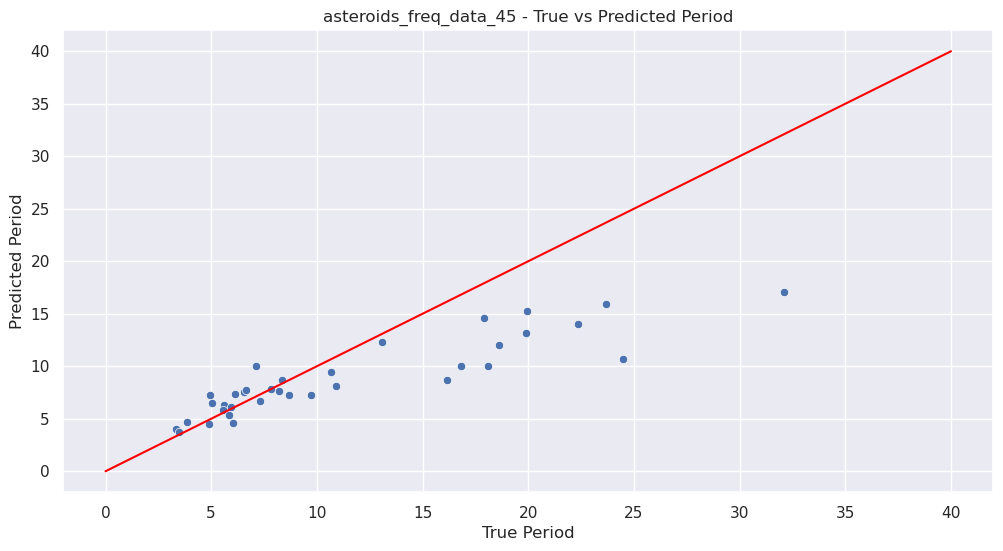



Processing dataset: asteroids_freq_data_192
----
Test RMSE: 0.5594427836046562
Test MAE: 0.41182419456857894
R2 Score: 0.8243026608345101
----
True: 5.3421 | Pred: 7.8112
True: 5.8904 | Pred: 4.7157
True: 4.8504 | Pred: 4.3457
True: 7.1649 | Pred: 6.8726
True: 14.3123 | Pred: 12.8293
True: 26.4879 | Pred: 15.6885
True: 9.1804 | Pred: 7.7725
True: 11.6150 | Pred: 6.4746
True: 4.5452 | Pred: 4.4310
True: 4.5452 | Pred: 4.4310
True: 15.8287 | Pred: 16.9609
True: 18.1191 | Pred: 10.7359
True: 5.8904 | Pred: 4.7157
True: 7.1658 | Pred: 7.8961
True: 12.5831 | Pred: 10.3384


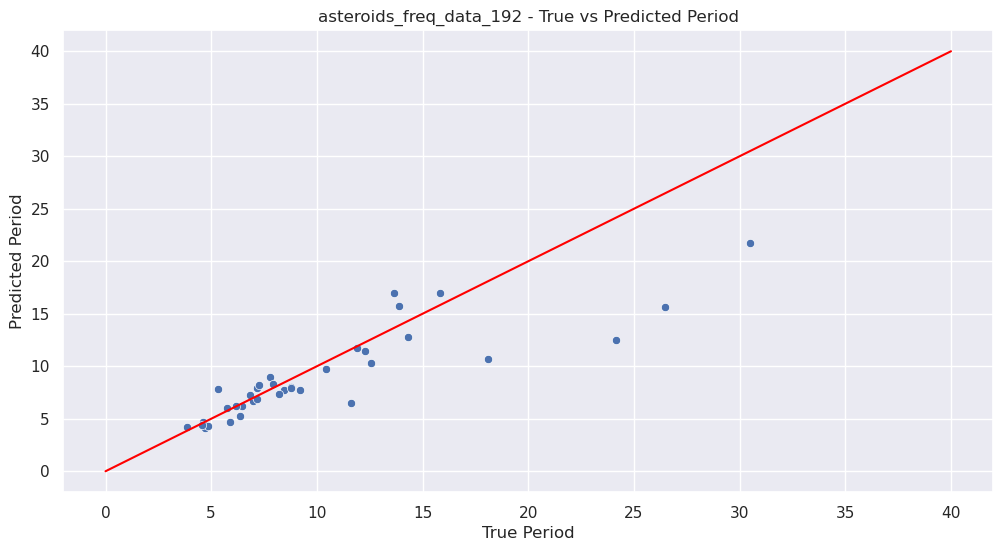



Processing dataset: asteroids_freq_data_94
----
Test RMSE: 0.6227413360965404
Test MAE: 0.4679217205344086
R2 Score: 0.7571834221867364
----
True: 6.5720 | Pred: 7.1128
True: 21.6704 | Pred: 17.5773
True: 11.7942 | Pred: 9.2931
True: 18.6089 | Pred: 13.1174
True: 14.0309 | Pred: 14.0761
True: 7.3202 | Pred: 7.6958
True: 13.1905 | Pred: 14.0372
True: 19.9020 | Pred: 16.7703
True: 7.3202 | Pred: 7.6958
True: 7.9319 | Pred: 8.6146
True: 5.8950 | Pred: 5.6066
True: 13.6252 | Pred: 11.1923
True: 7.9281 | Pred: 7.2648
True: 24.4787 | Pred: 8.6415
True: 19.9020 | Pred: 16.7703


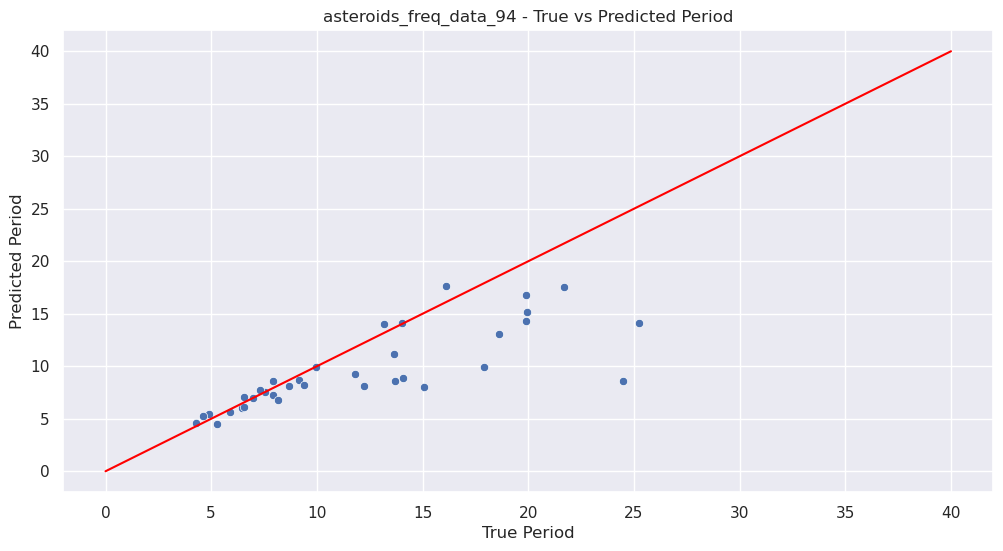



Processing dataset: asteroids_freq_data_180
----
Test RMSE: 0.6185893541820467
Test MAE: 0.4762232532552355
R2 Score: 0.7851879126006157
----
True: 9.1804 | Pred: 10.8322
True: 6.1708 | Pred: 6.7964
True: 13.8759 | Pred: 13.4034
True: 7.1658 | Pred: 11.2989
True: 12.2700 | Pred: 13.6569
True: 8.7908 | Pred: 7.7854
True: 7.1649 | Pred: 7.5788
True: 6.4411 | Pred: 6.8219
True: 14.3123 | Pred: 13.8751
True: 18.1191 | Pred: 15.1331
True: 4.5452 | Pred: 4.4039
True: 8.7624 | Pred: 6.1082
True: 5.8904 | Pred: 5.2374
True: 18.1191 | Pred: 15.1331
True: 10.4083 | Pred: 9.6809


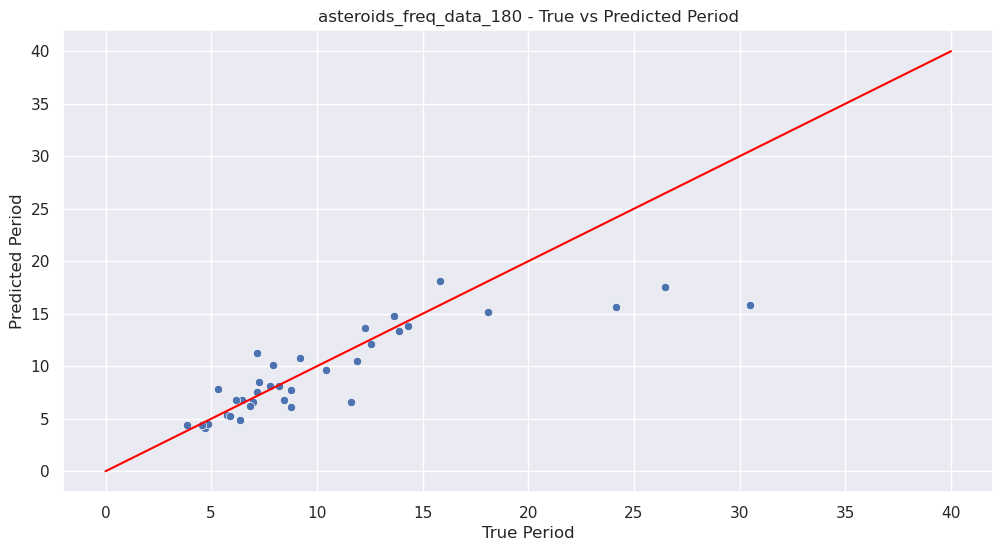



Processing dataset: asteroids_freq_data_44
----
Test RMSE: 0.810810091290157
Test MAE: 0.6535188225454751
R2 Score: 0.8240848655758337
----
True: 3.7412 | Pred: 4.0839
True: 5.8950 | Pred: 5.2366
True: 12.1746 | Pred: 13.4611
True: 5.5525 | Pred: 5.4202
True: 2.8287 | Pred: 3.4535
True: 13.1720 | Pred: 9.1462
True: 2.8287 | Pred: 3.4535
True: 14.2566 | Pred: 16.7943
True: 19.8846 | Pred: 16.2382
True: 13.1720 | Pred: 9.1462
True: 2.8303 | Pred: 3.5080
True: 11.9439 | Pred: 9.5870
True: 3.9349 | Pred: 5.5018
True: 2.8287 | Pred: 3.4535
True: 7.7155 | Pred: 9.5979


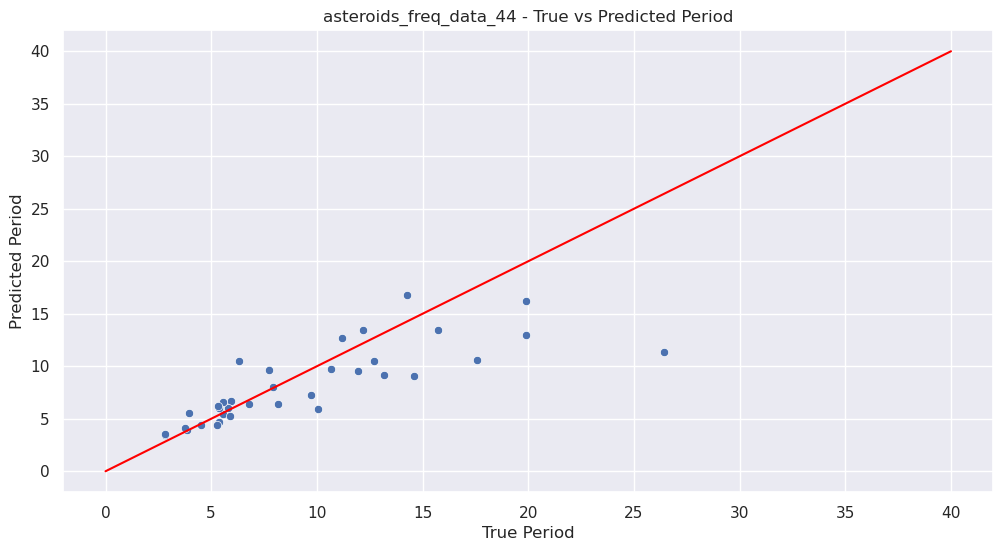

In [70]:
for file_stem, best in best_params.items():
    print(f"\n\nProcessing dataset: {file_stem}")
    print("----")

    feature_file = FEATURES_DIR / f"{file_stem}.json"

    # best = best.copy()

    # tree_method = ["auto", "exact", "approx", "hist"]

    # best["tree_method"] = tree_method[best["tree_method"]]
    # best["early_stopping_rounds"] = int(best["early_stopping_rounds"])
    # best["max_bin"] = int(best["max_bin"])
    # best["max_depth"] = int(best["max_depth"])
    # best["max_leaves"] = int(best["max_leaves"])
    # best["n_estimators"] = int(best["n_estimators"])
    # best["num_parallel_tree"] = int(best["num_parallel_tree"])

    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(feature_file)  # type: ignore

    model = XGBRegressor(
        **best,
        n_jobs=-1,
        random_state=8888,
    )

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )

    predictions = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, predictions)

    print(f"Test RMSE: {rmse}")
    print(f"Test MAE: {np.mean(np.abs(y_test - predictions))}")
    print(f"R2 Score: {model.score(X_test, y_test)}")
    print("----")
    for i in np.random.choice(len(y_test), 15):
        print(f"True: {24 / y_test[i]:.4f} | Pred: {24 / predictions[i]:.4f}")

    # plot scatter plot of predictions vs true values using sns

    sns.scatterplot(x=24 / y_test, y=24 / predictions)
    sns.lineplot(x=[0, 40], y=[0, 40], color="red")
    plt.xlabel("True Period")
    plt.ylabel("Predicted Period")
    plt.title(f"{file_stem} - True vs Predicted Period")

    plt.show()

In [78]:
preds = [4.5, 6, 5.5]  # period in hours for predictions
true = [5, 6, 7]  # period in hours for true values

preds_f = [24 / x for x in preds] # frequency in days (JD) for predictions
true_f = [24 / x for x in true] # frequency in days (JD) for true values

rmse_p = np.sqrt(np.mean((np.array(preds) - np.array(true))**2))
rmse_f = np.sqrt(np.mean((np.array(preds_f) - np.array(true_f))**2))

rmse_p, rmse_f

(np.float64(0.9128709291752769), np.float64(0.6215011067923734))